# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



frame.shape:  (210, 160, 3)


Text(0.5,1,'original image')

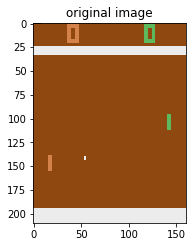

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

print('frame.shape: ', frame.shape)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')


frame.shape:  (210, 160, 3)
img.shape:  (80, 80)


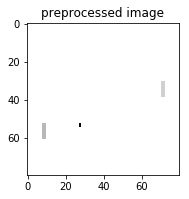

In [4]:
import numpy as np

# preprocess a single frame
# crop image and downsample to 80x80
# stack two frames together as input
# [34:-16:2,::2] means (210 - 34 - 16)/2 = 80, 160/2 = 80
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    #print('image[34:-16:2,::2].shape: ', image[34:-16:2,::2].shape)
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

plt.subplot(1,2,2)
plt.title('preprocessed image')

print('frame.shape: ', frame.shape)
img = preprocess_single(frame)
print('img.shape: ', img.shape)

# 80 x 80 black and white image
plt.imshow(img, cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# use your own policy!
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy.    
An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress.

outfile:  I:\1-Deep-Reinforcement-Learining\Pong-PPO_vers_2\_tmp_e485a1df.html



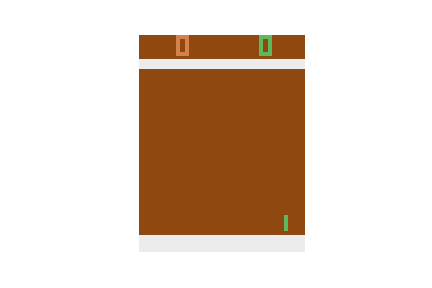
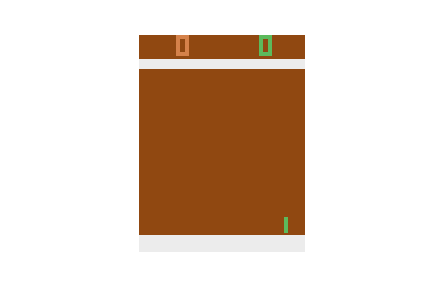
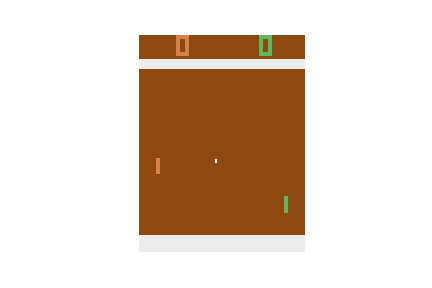
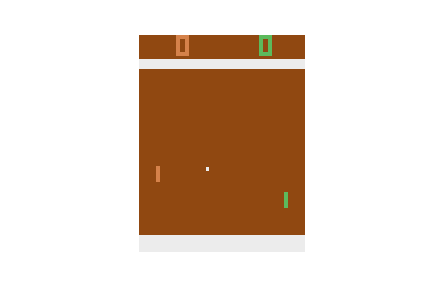
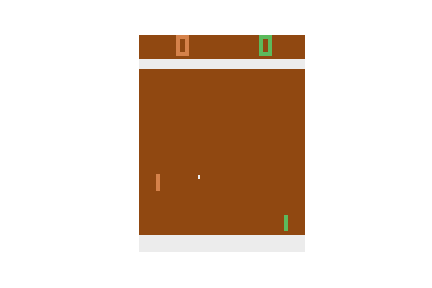
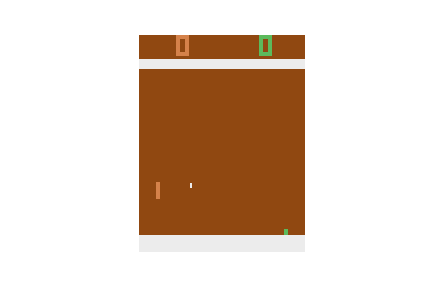
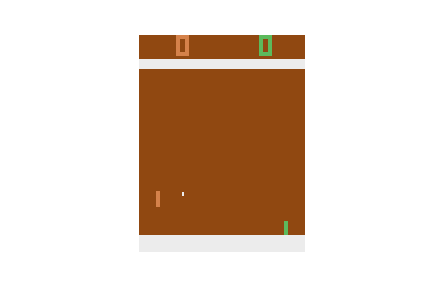
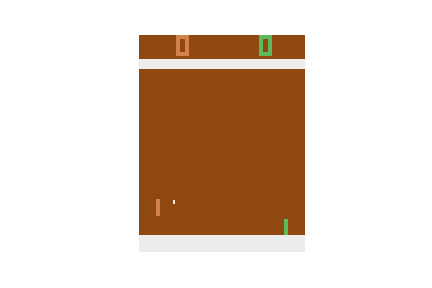
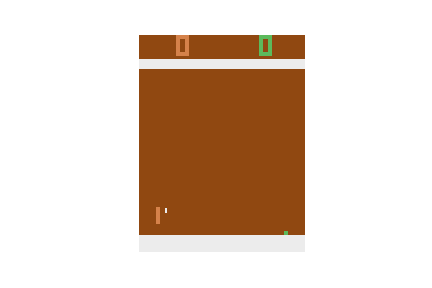
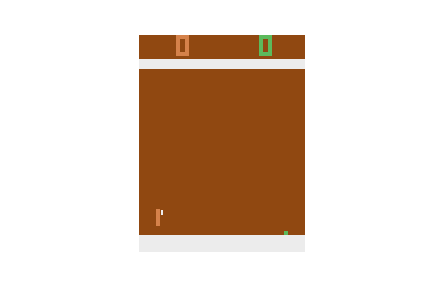
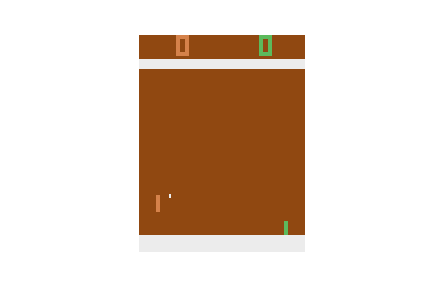
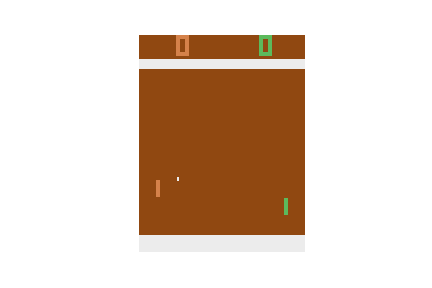
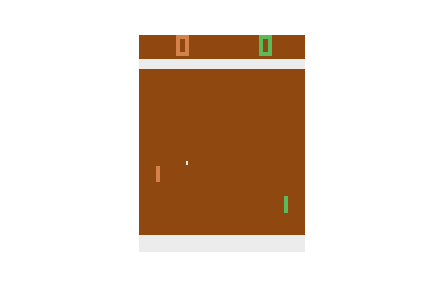
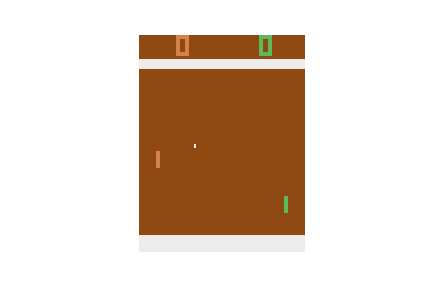
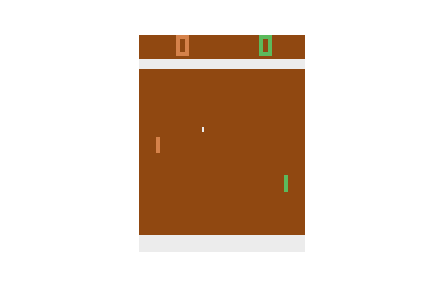
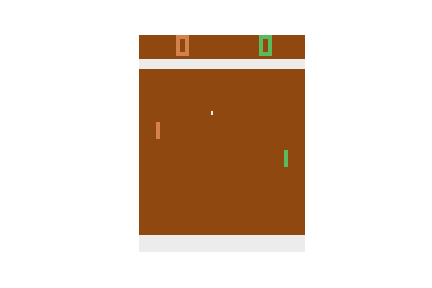
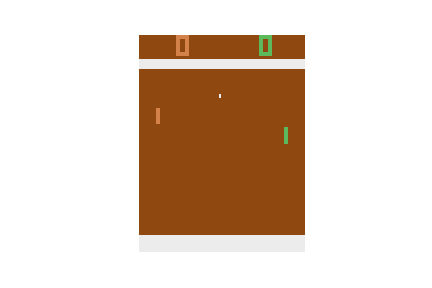
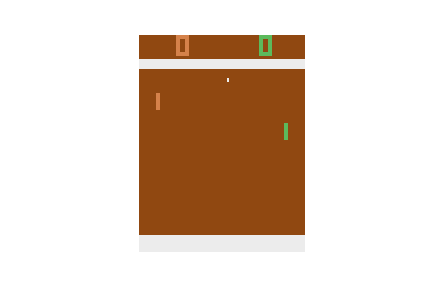
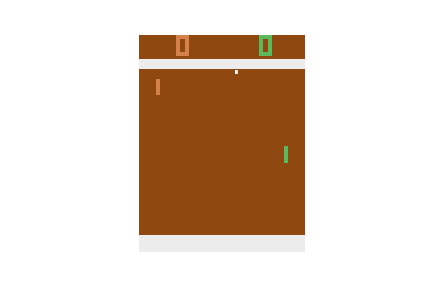
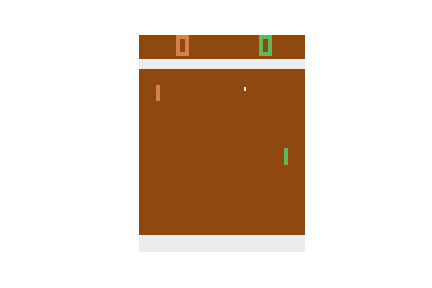
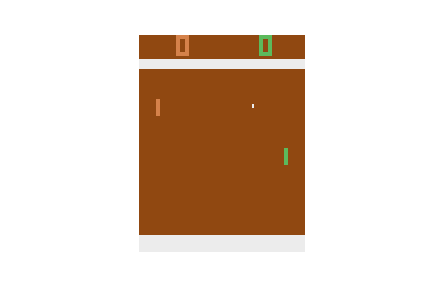
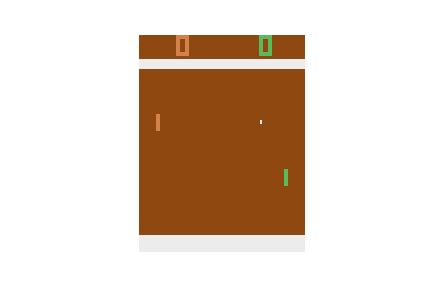
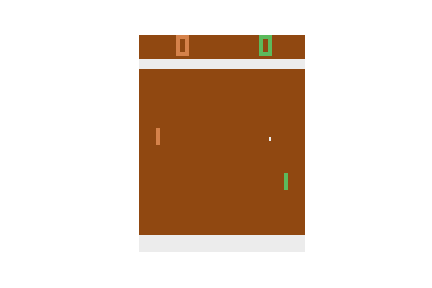
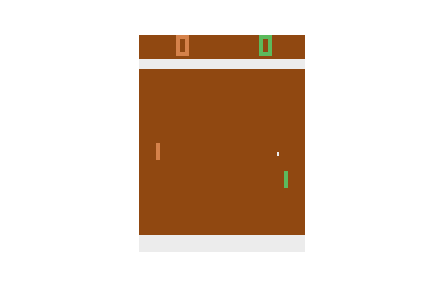
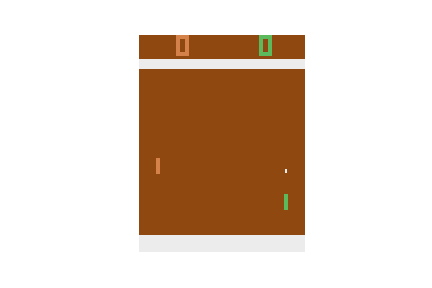
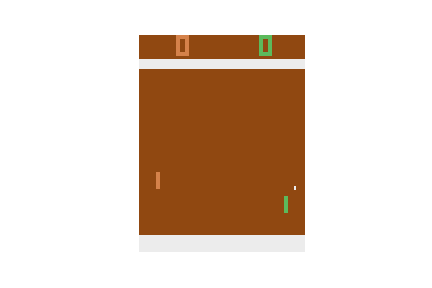
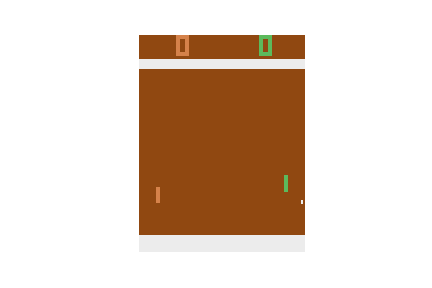
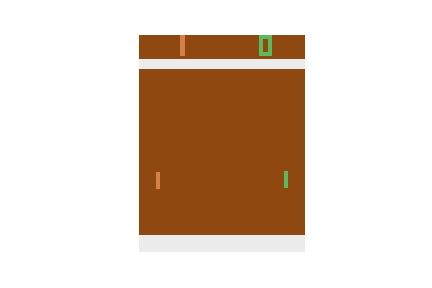
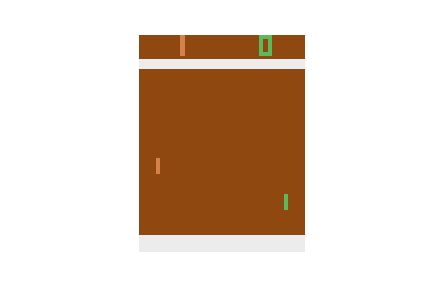
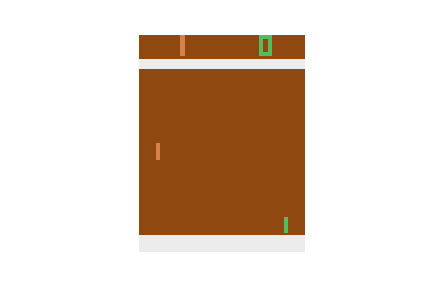
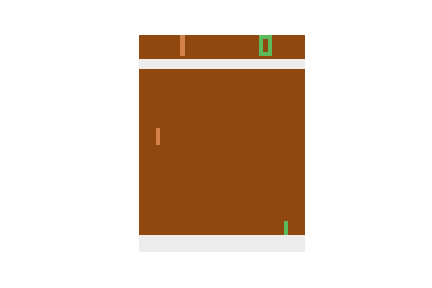
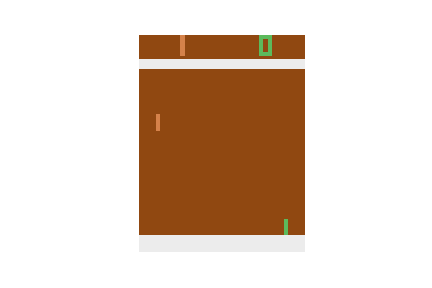
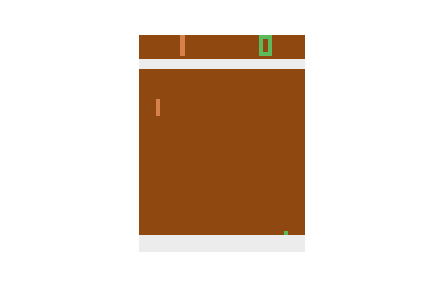
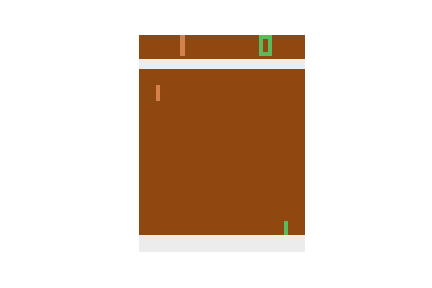
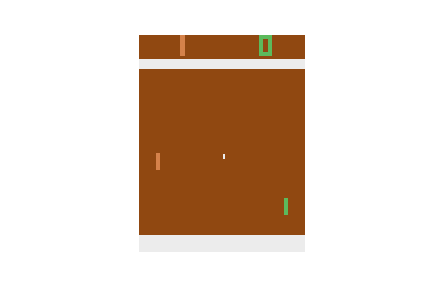
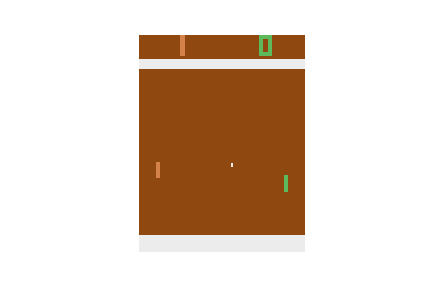
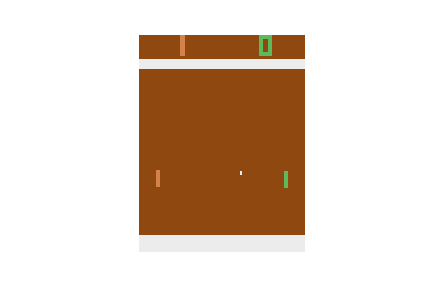
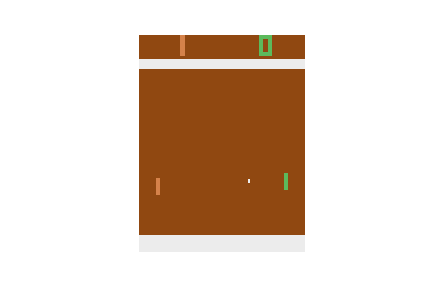
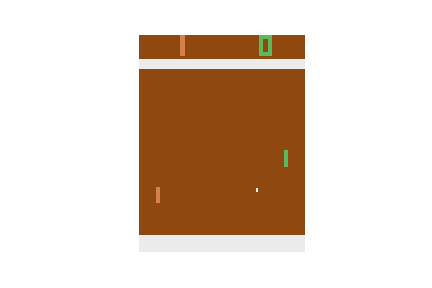
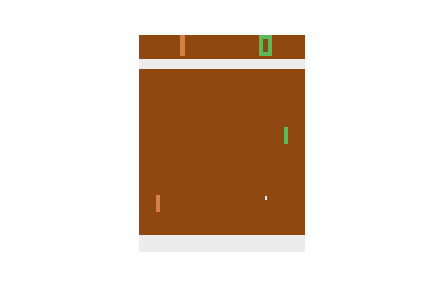
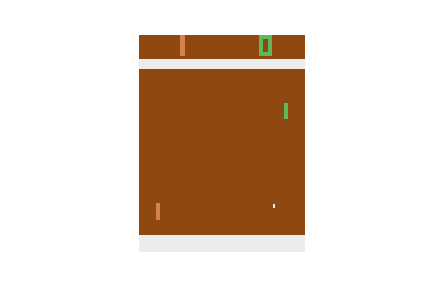
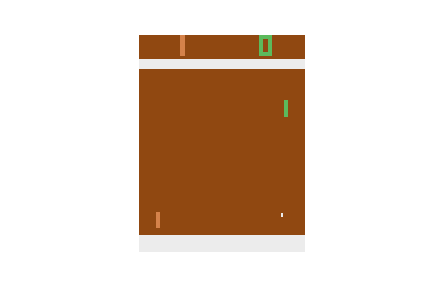
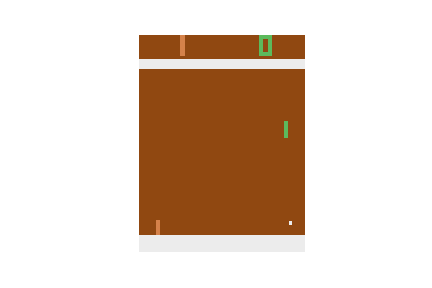
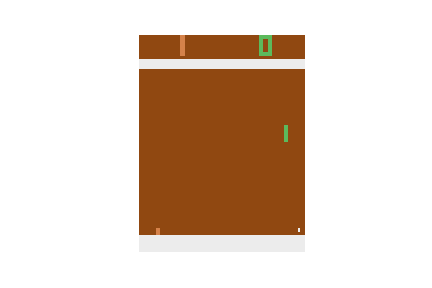
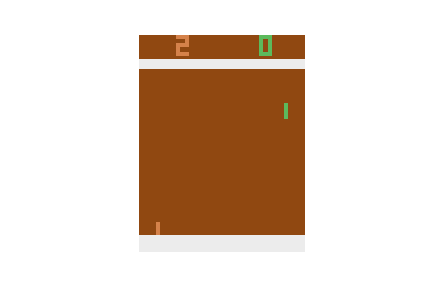
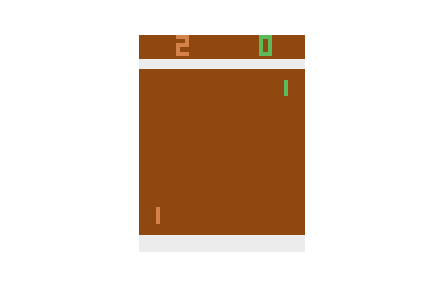
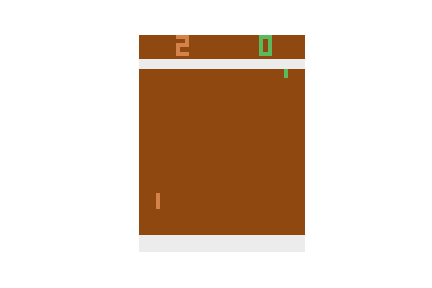
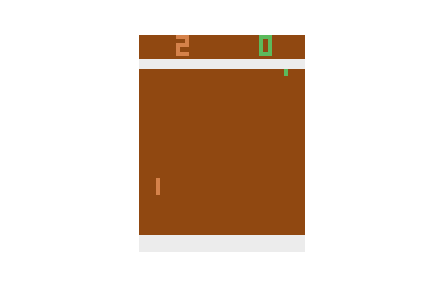
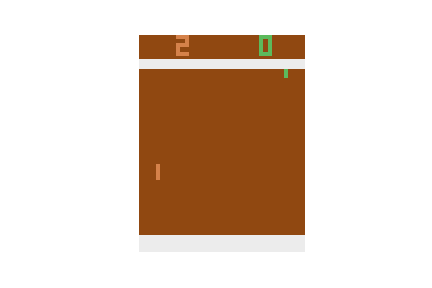
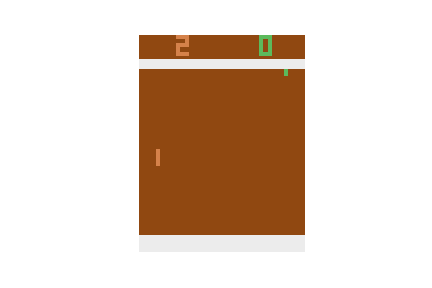
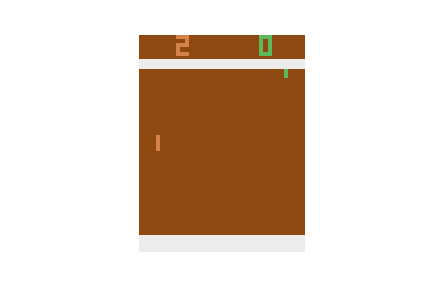
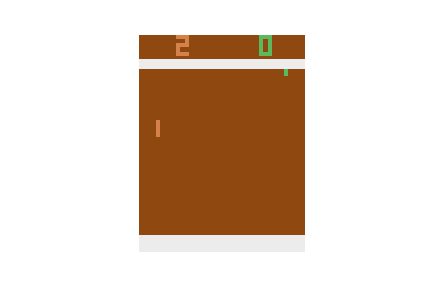
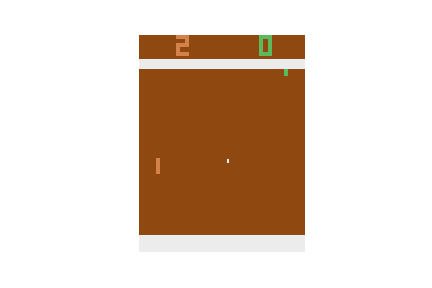
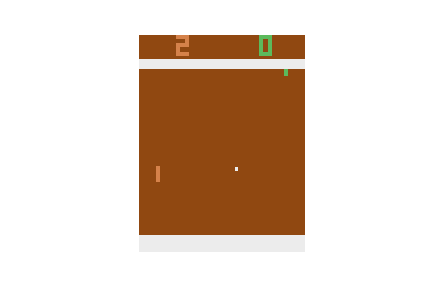
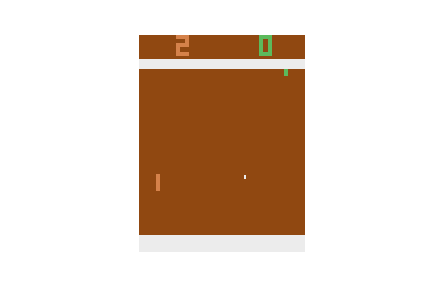
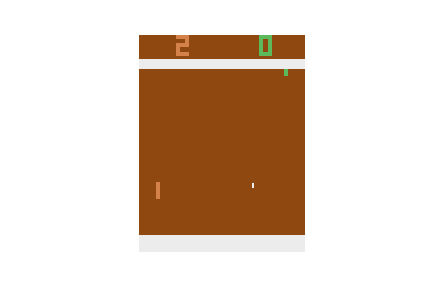
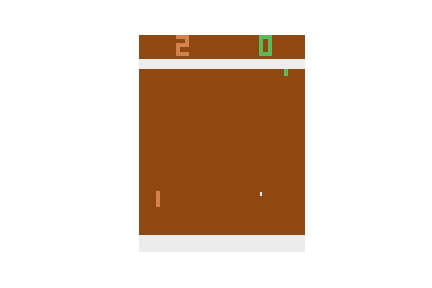
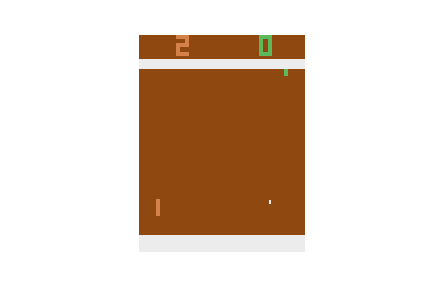
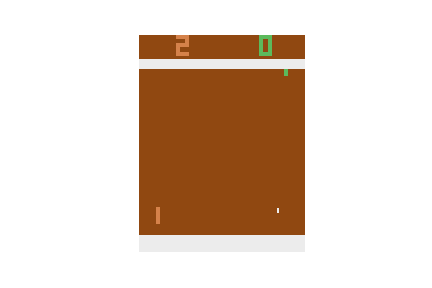
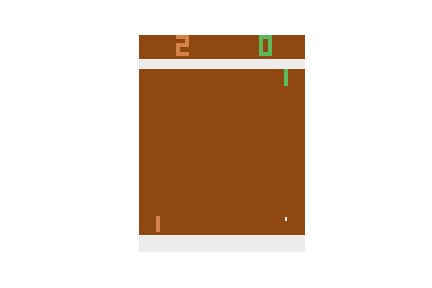
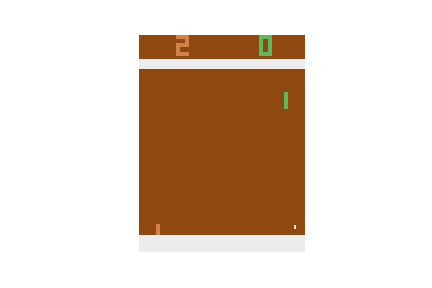
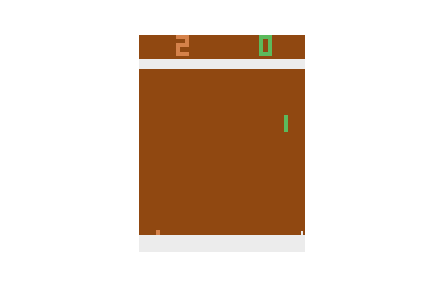
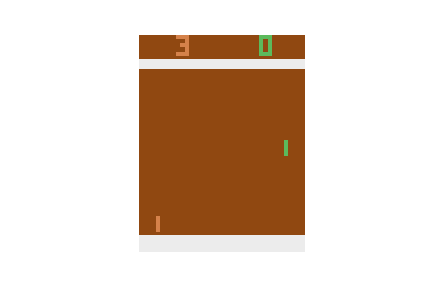
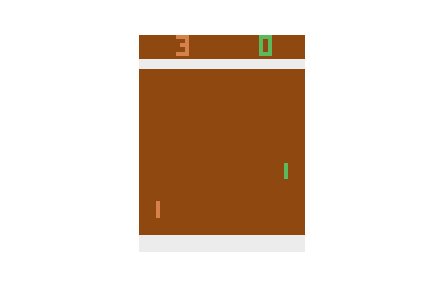
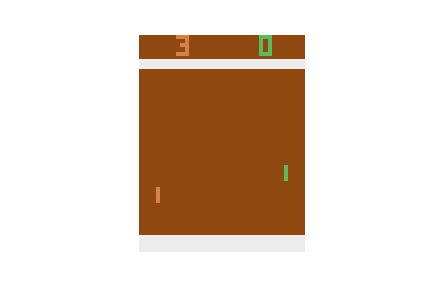
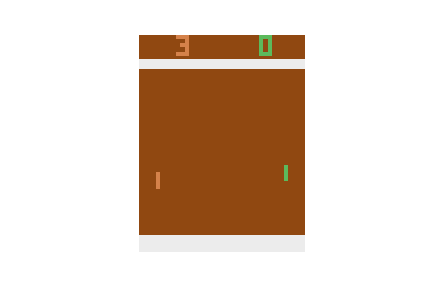
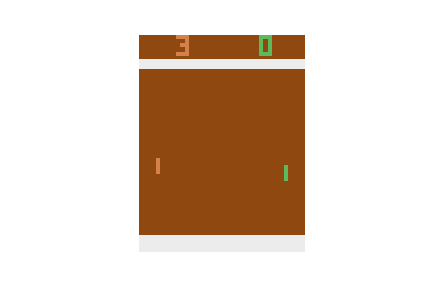
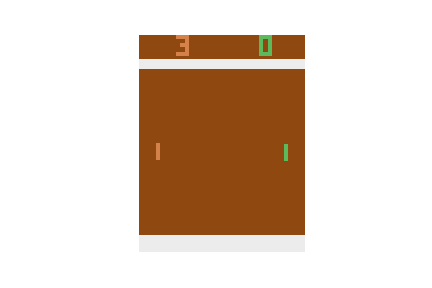
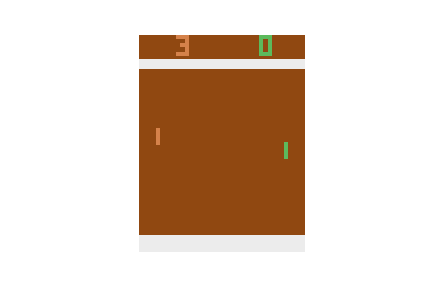
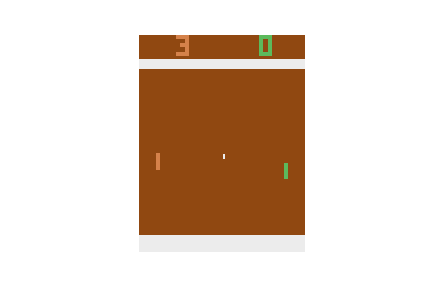
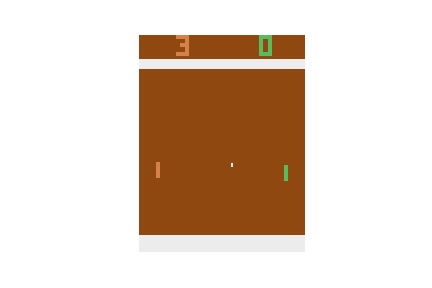
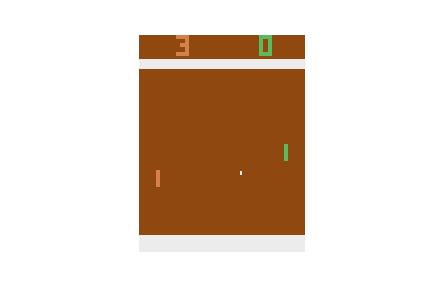
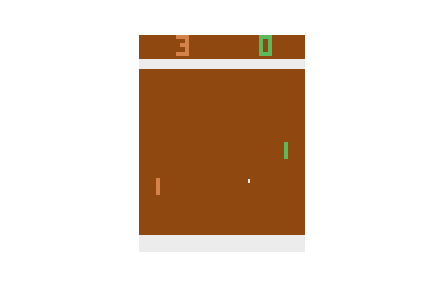
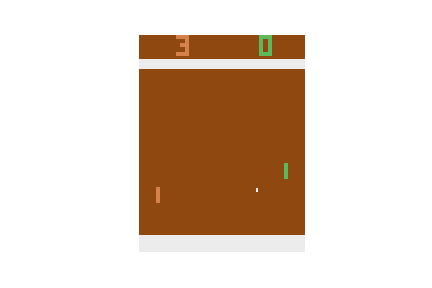
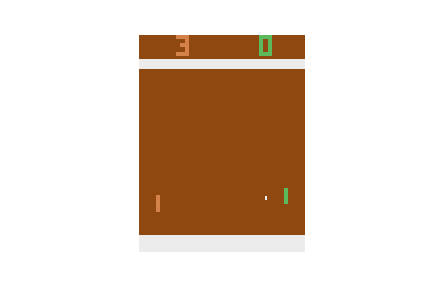
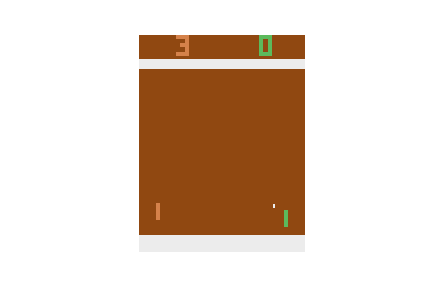
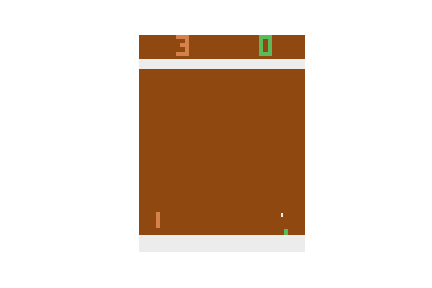
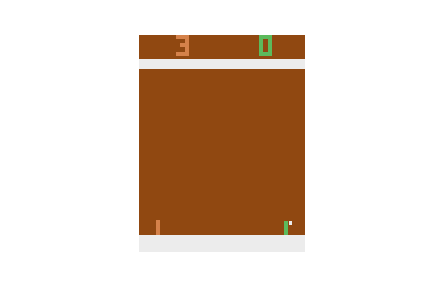
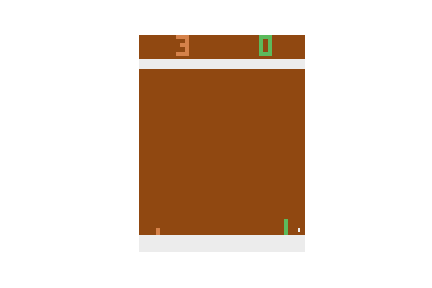
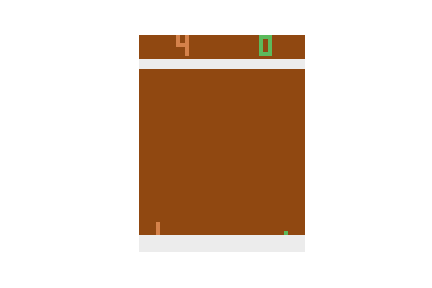
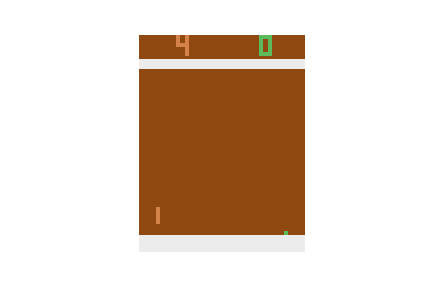
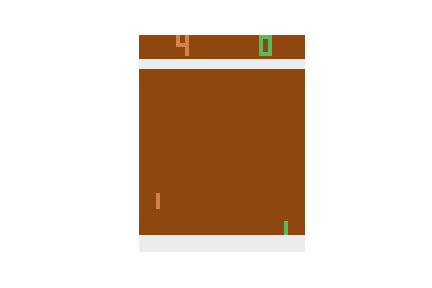
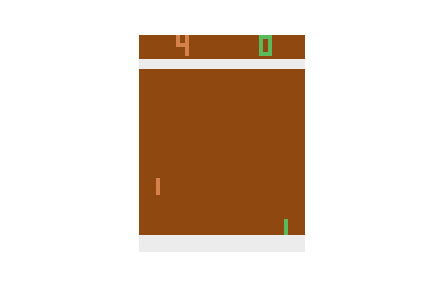
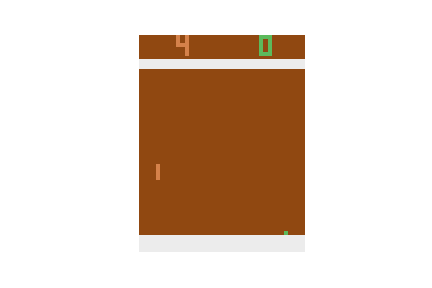
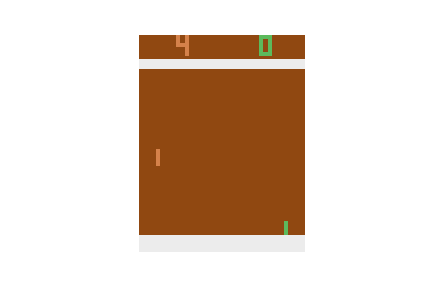
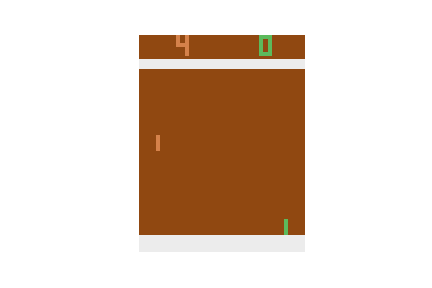
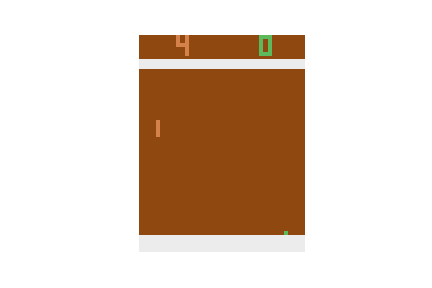
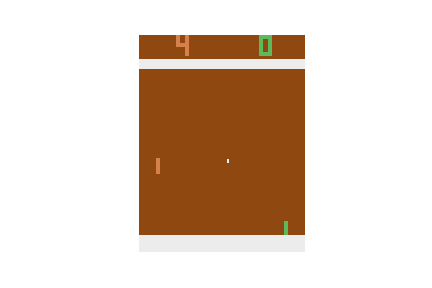
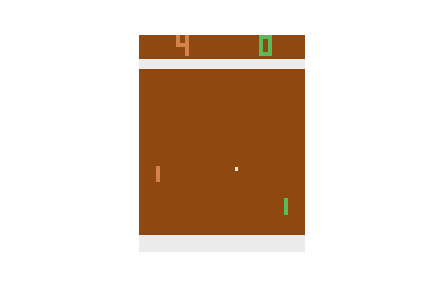
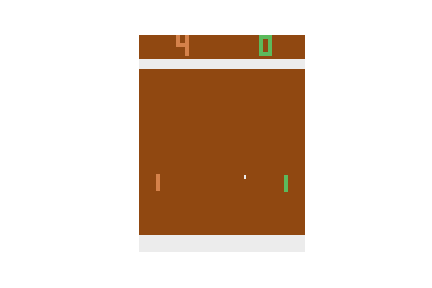
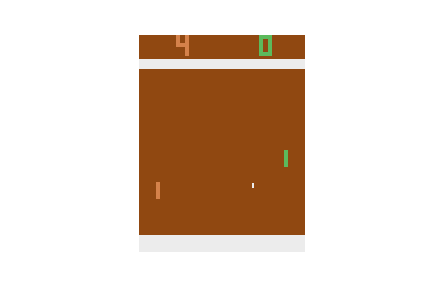
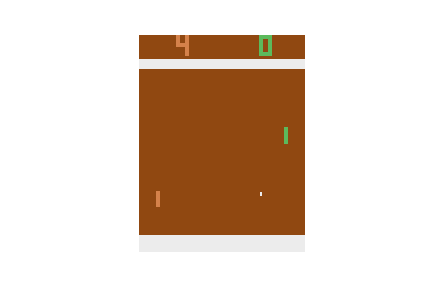
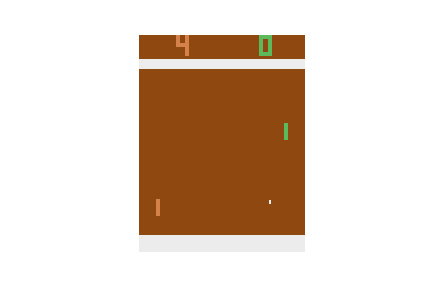
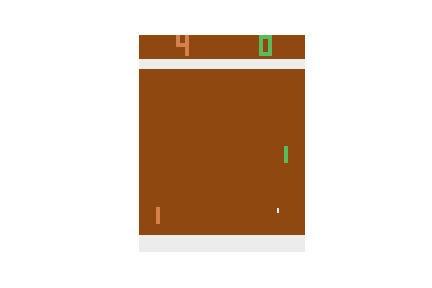
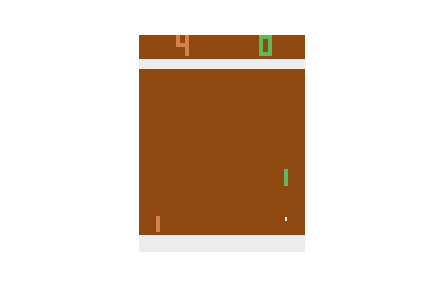
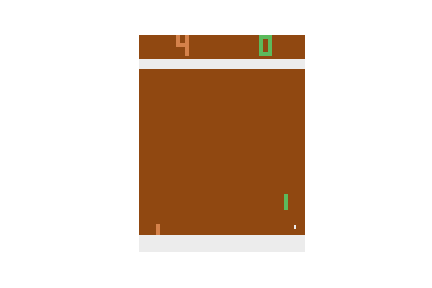
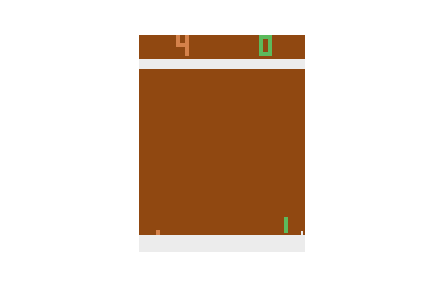
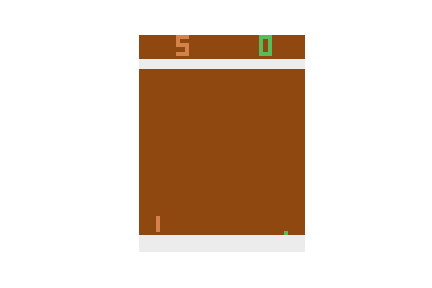
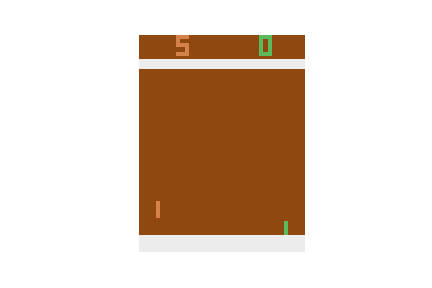
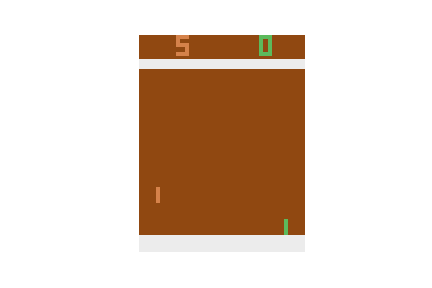
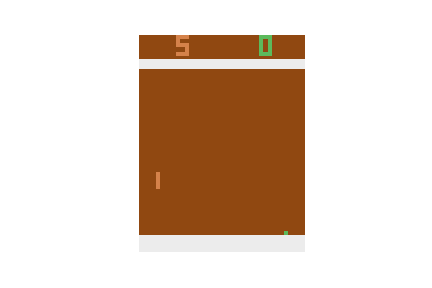
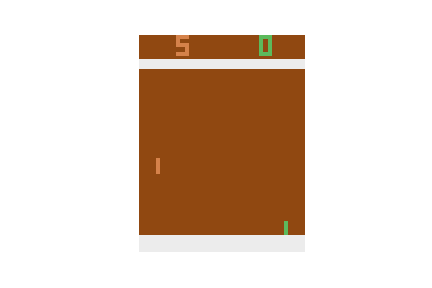
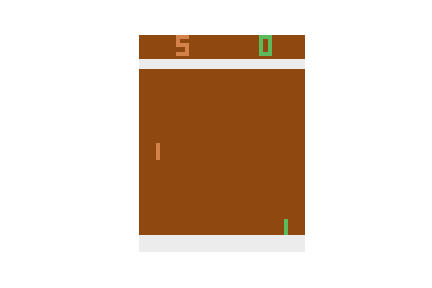
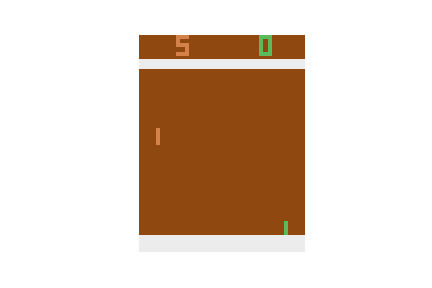
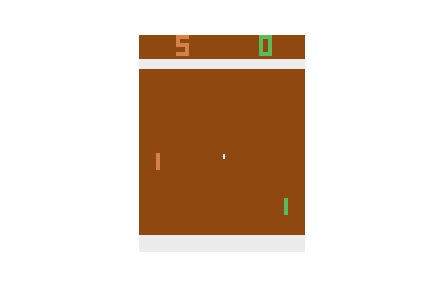
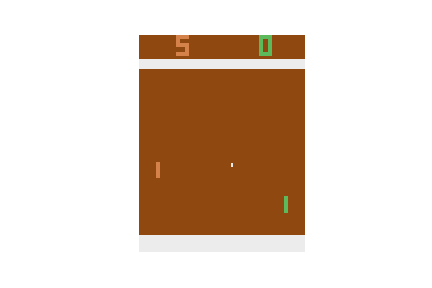
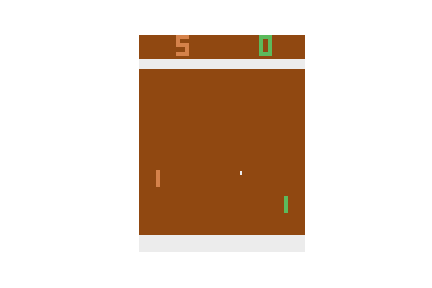
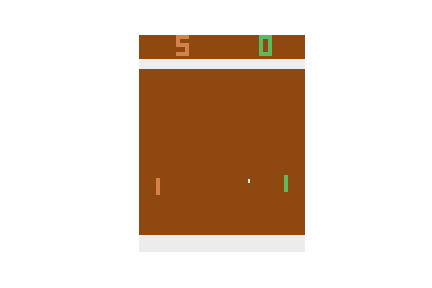
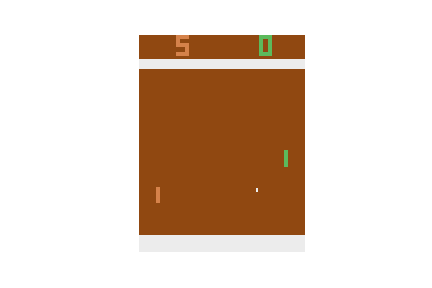
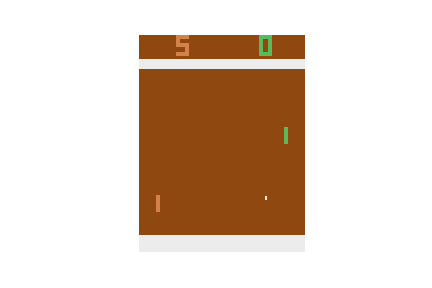
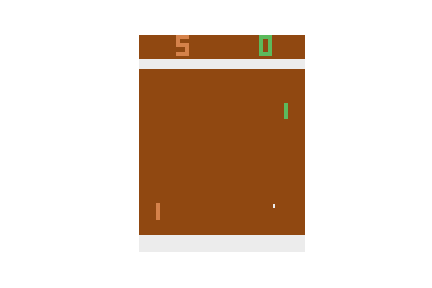
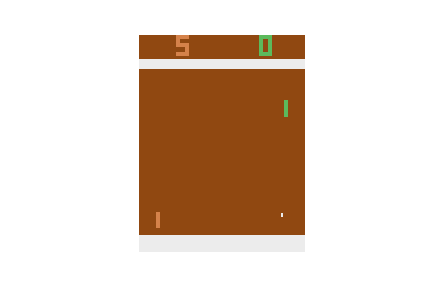
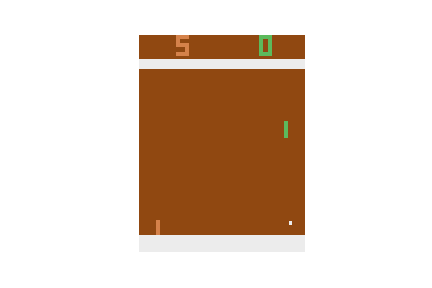
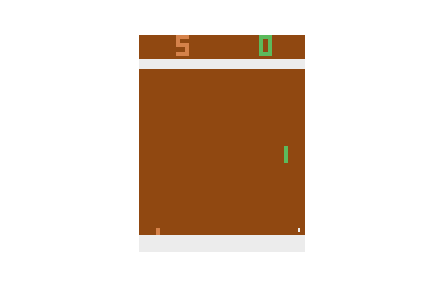
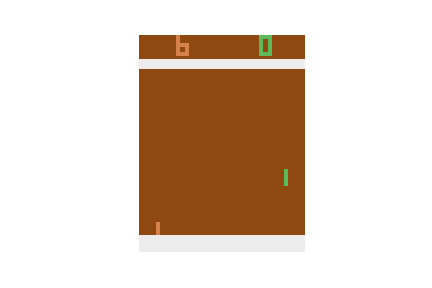
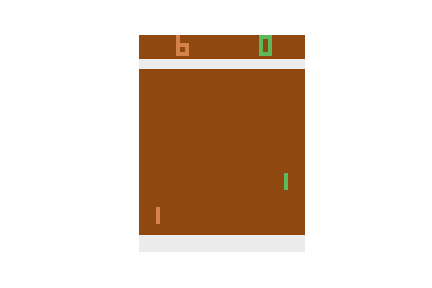
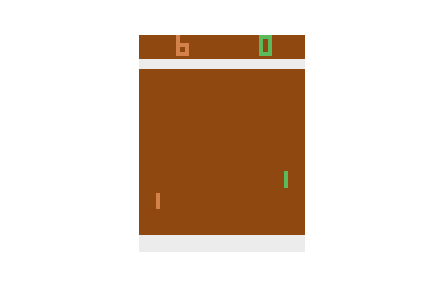
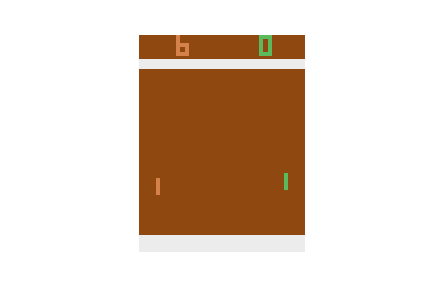
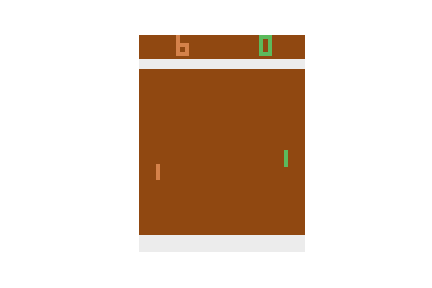
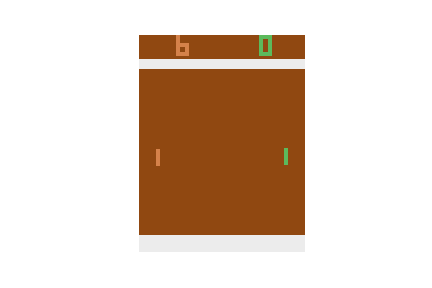
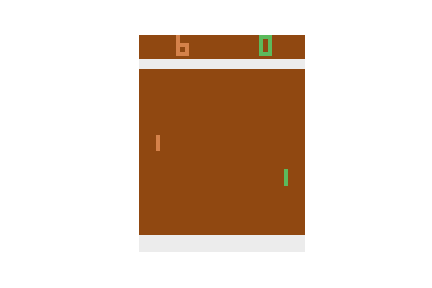
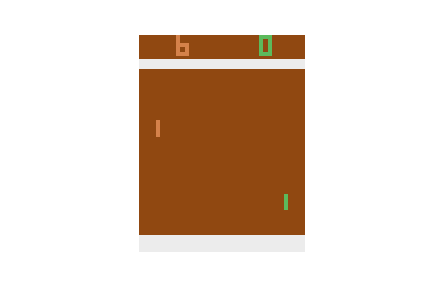
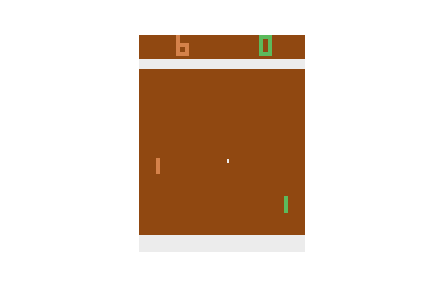
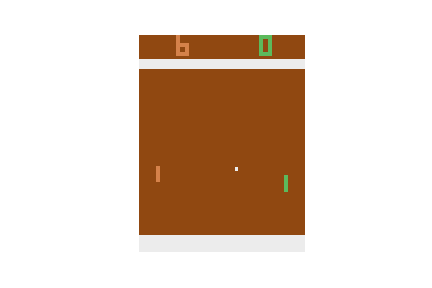
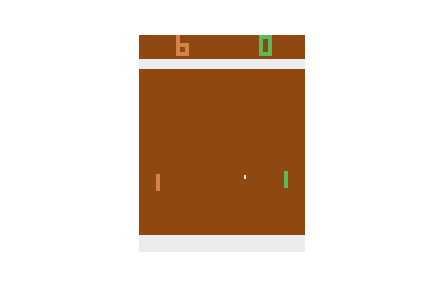
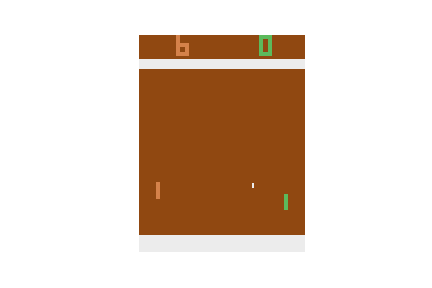
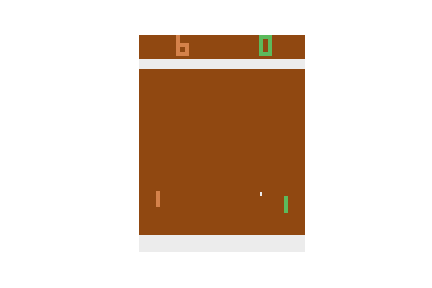
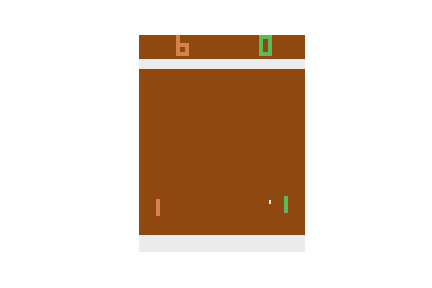
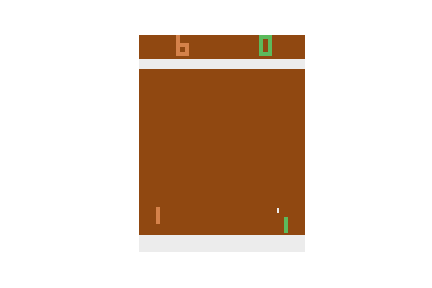
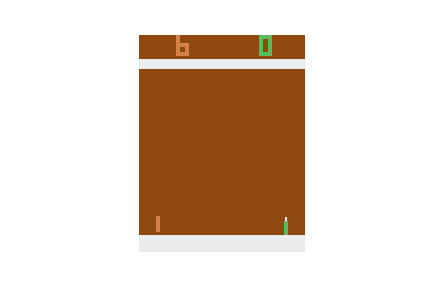
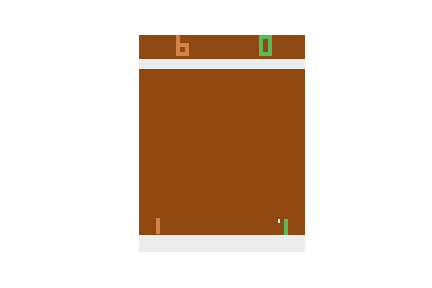
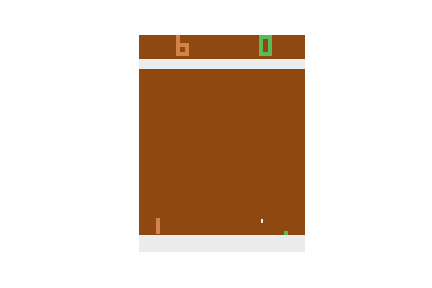
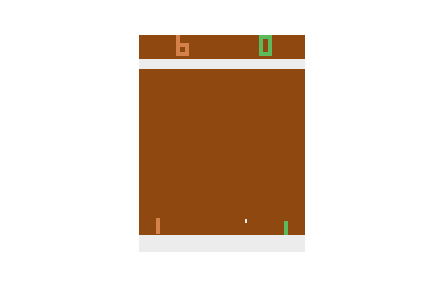
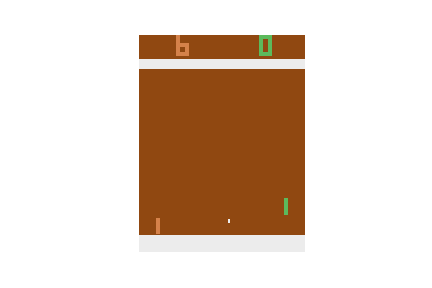
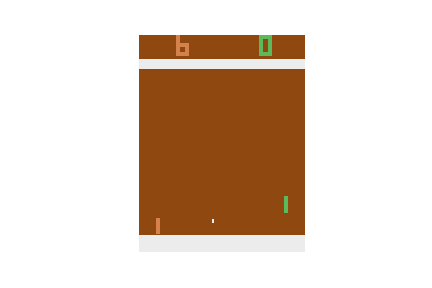
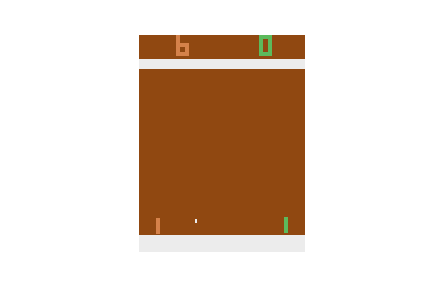
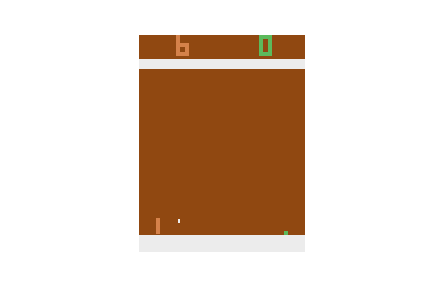
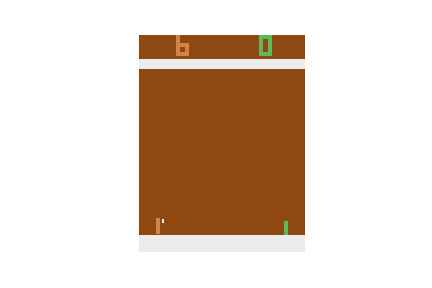
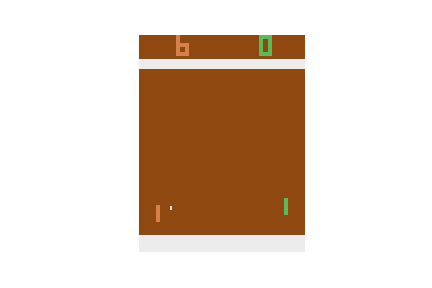
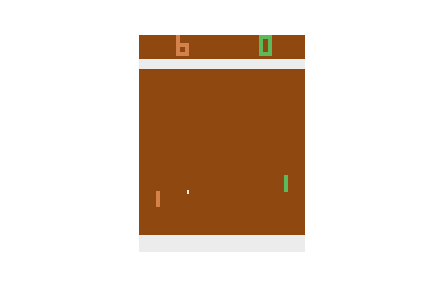
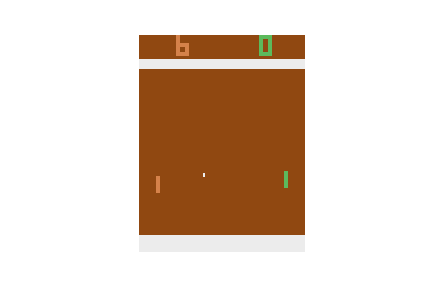
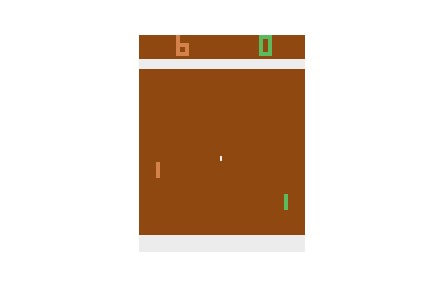
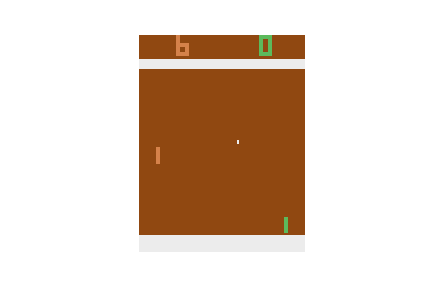
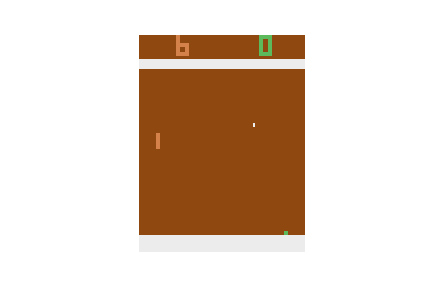
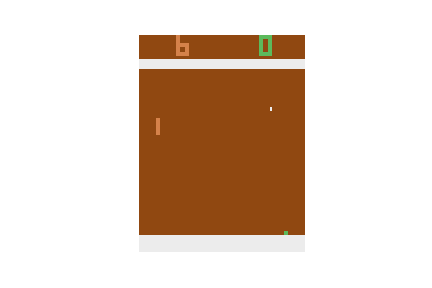
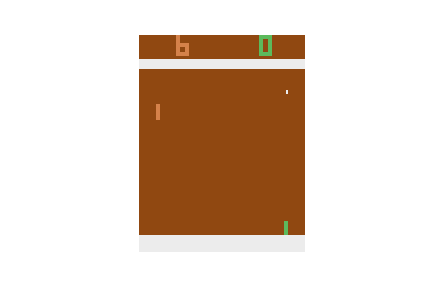
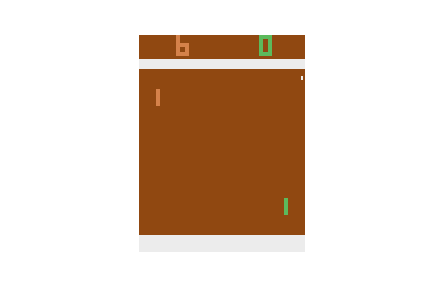
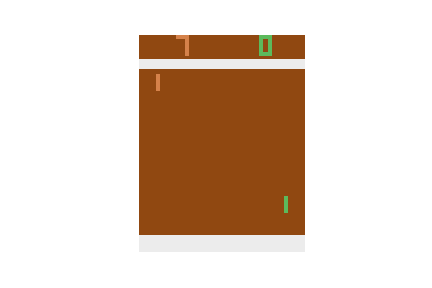
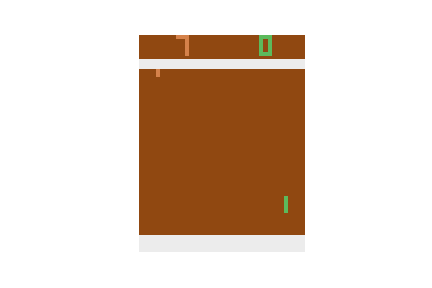
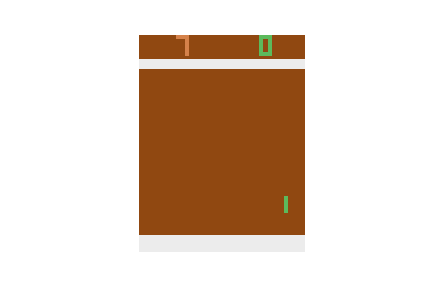
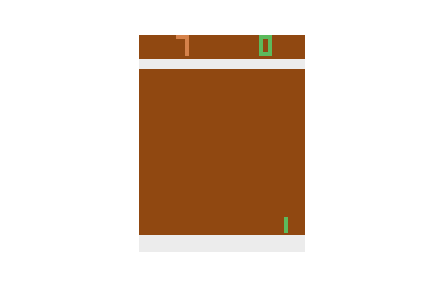
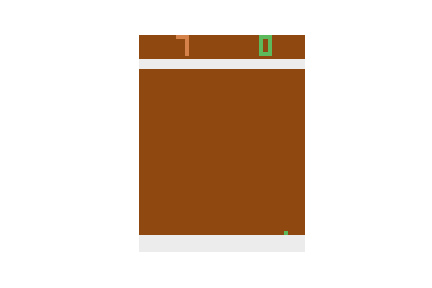
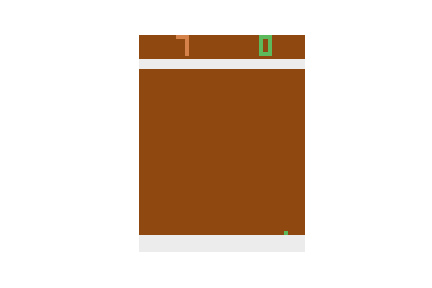
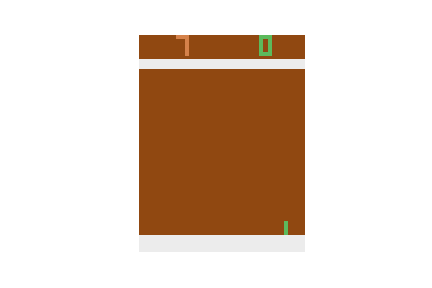
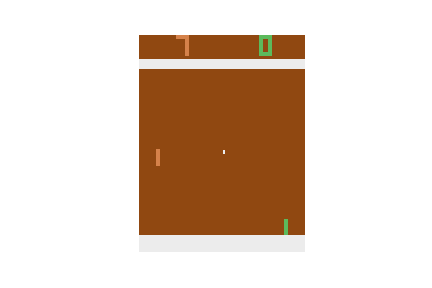
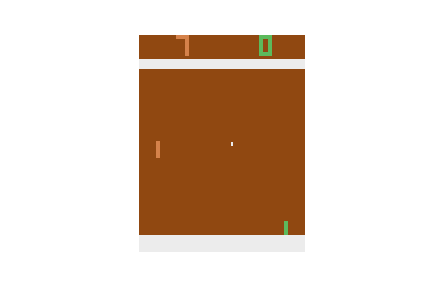
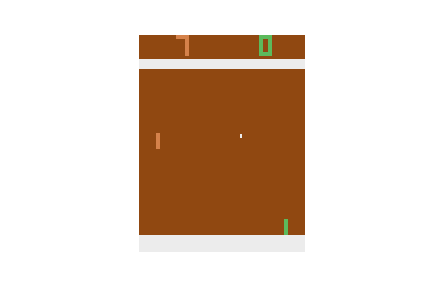
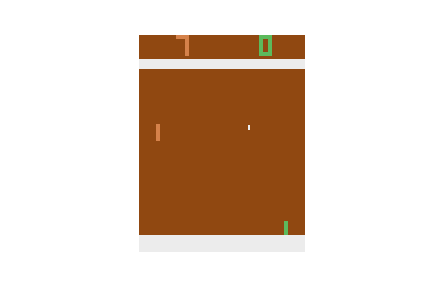
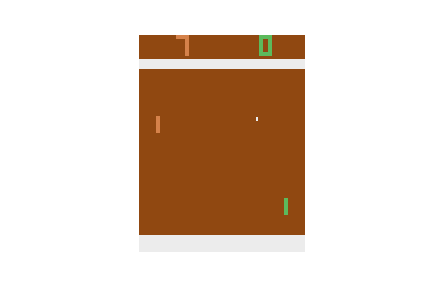
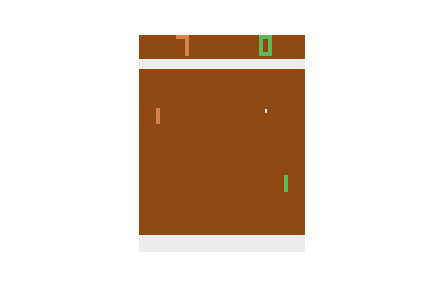
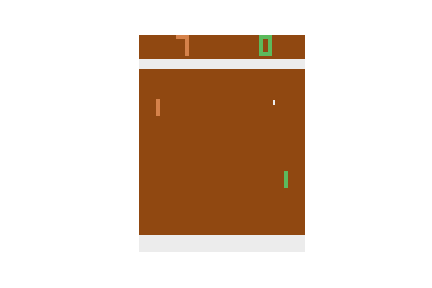
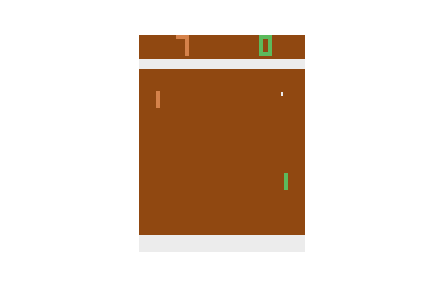
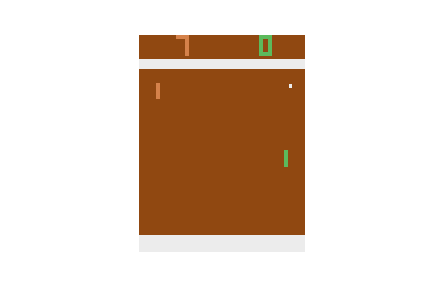
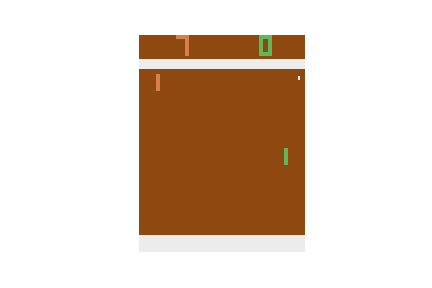
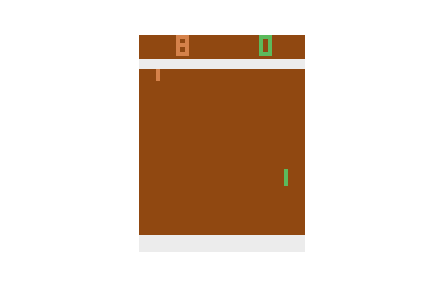
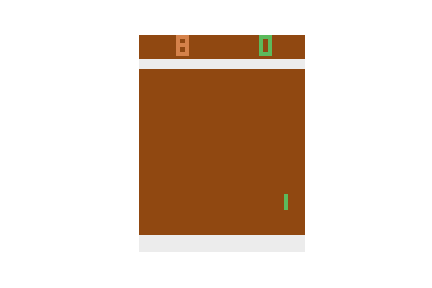
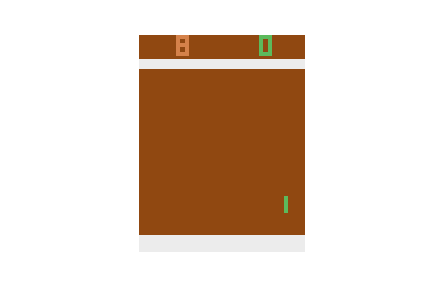
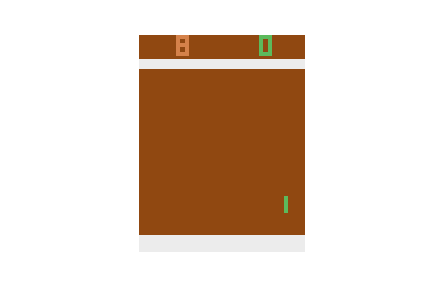
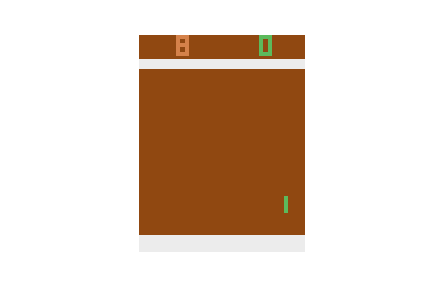
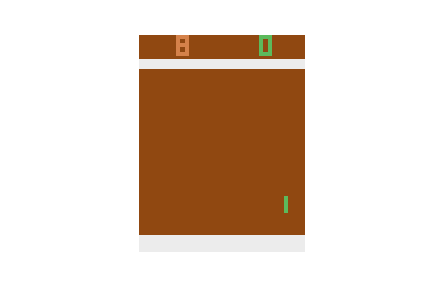
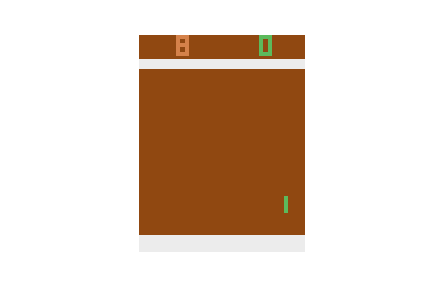
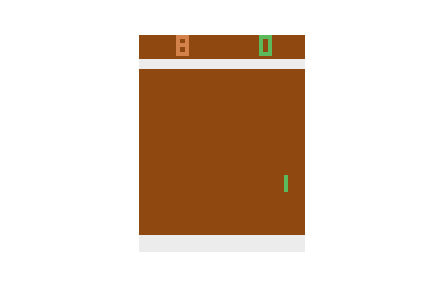
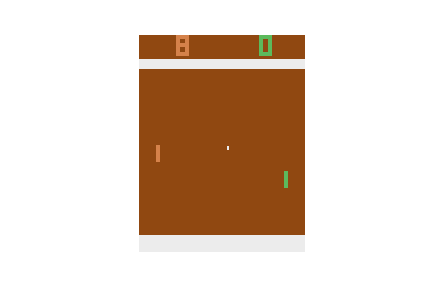
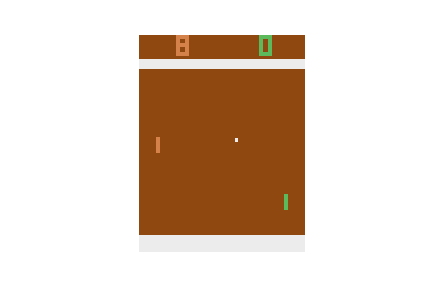
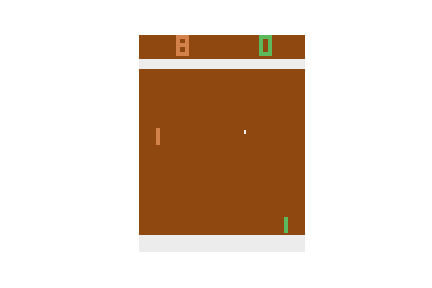
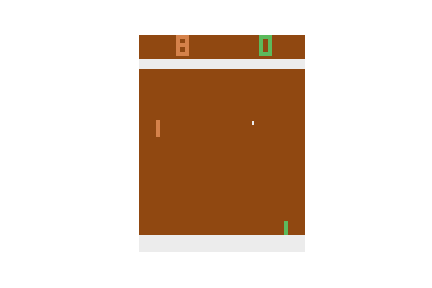
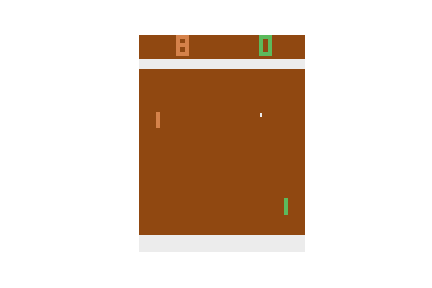
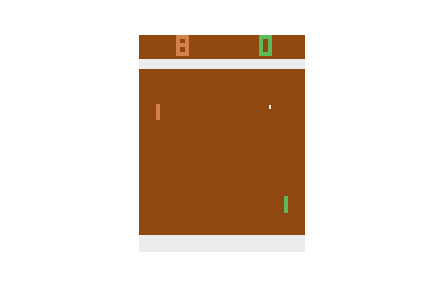
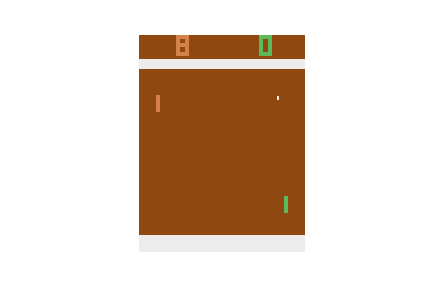
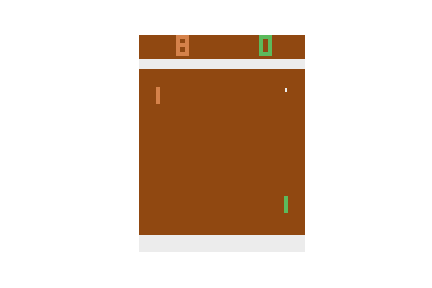
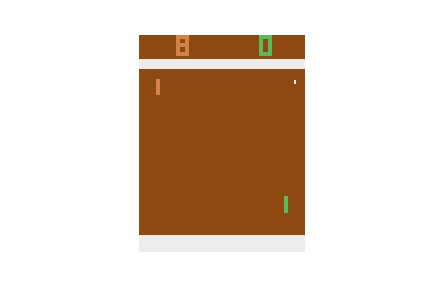
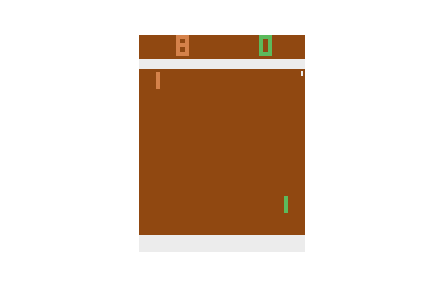
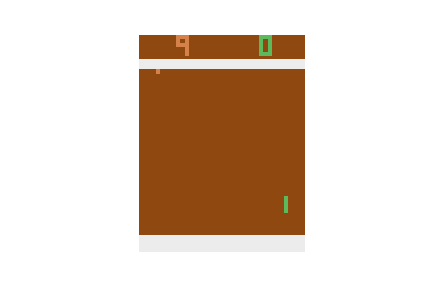
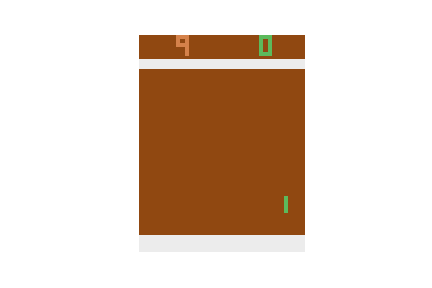
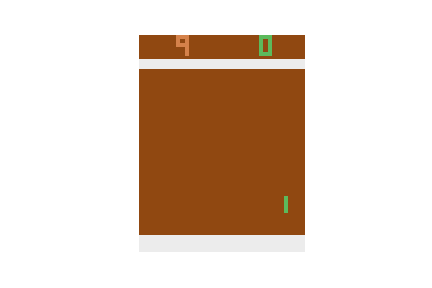
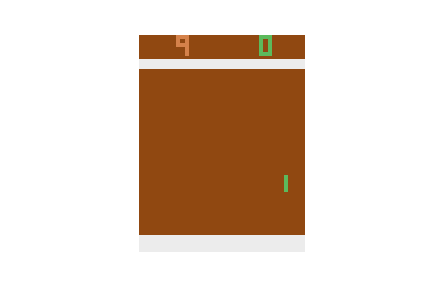
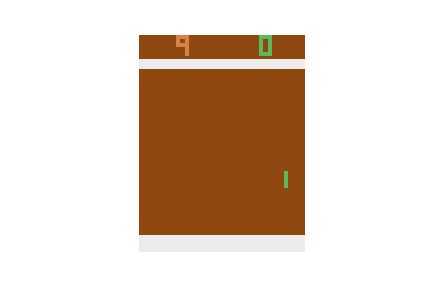
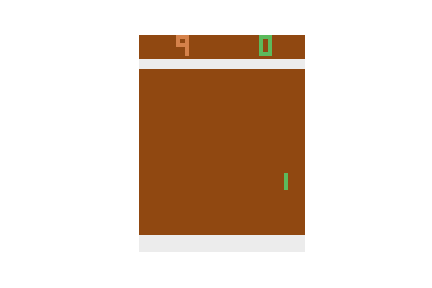
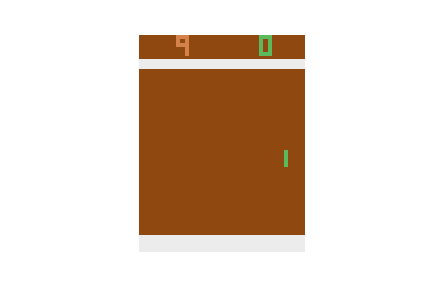
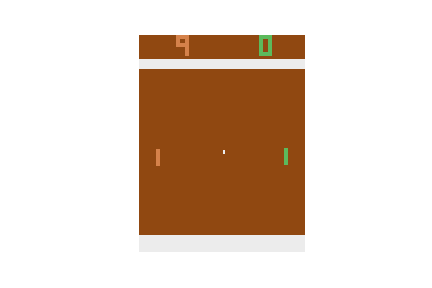
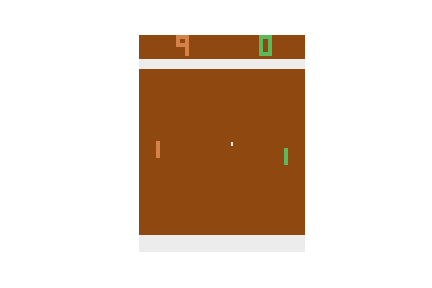
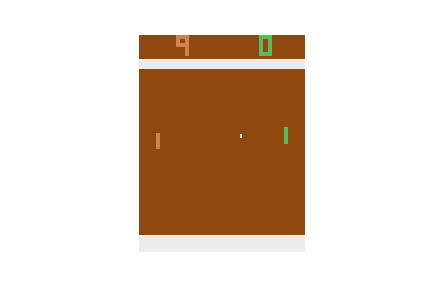
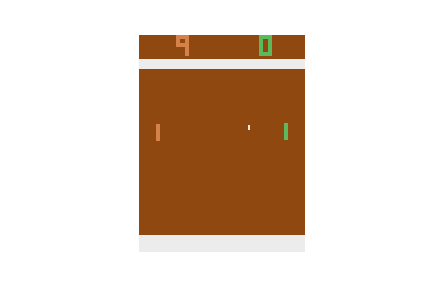
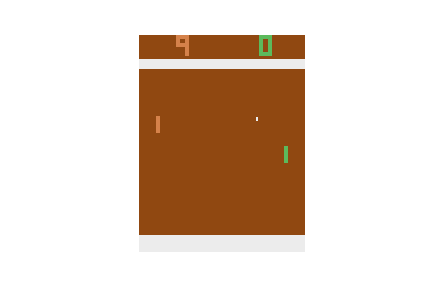
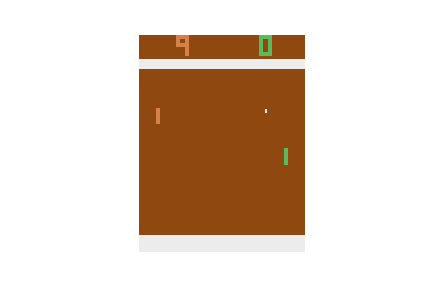
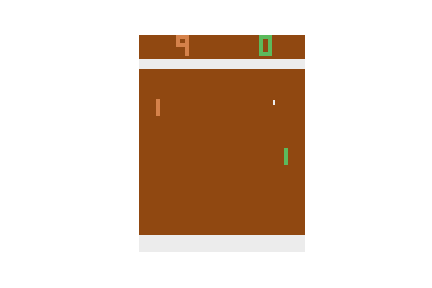
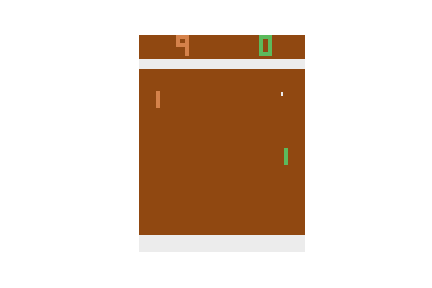
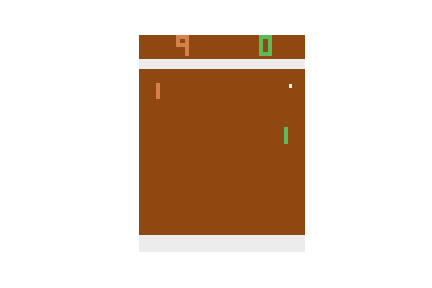
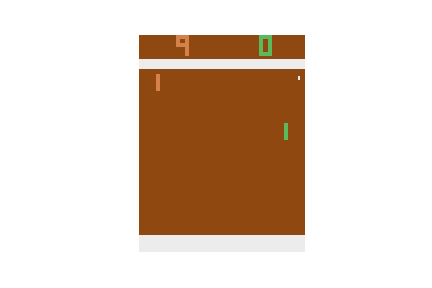
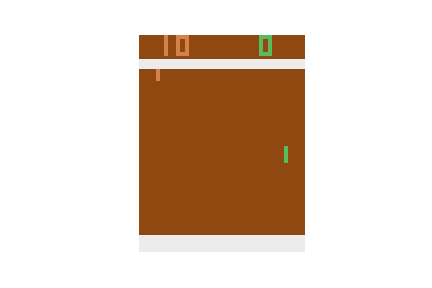

In [6]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [7]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>


In [8]:
Lsur= pong_utils.clipped_surrogate(policy, prob, state, action, reward)
print(Lsur)

tensor(1.00000e-03 *
       6.9278, device='cuda:0')


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [9]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
# episode = 500
episode = 800


# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

#use parallel n = 8 environments for train
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
# tmax = 200 # it' s very good for 2000 episodes
tmax = 300
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        torch.save(policy.state_dict(), 'PPO_800epis.pth')
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>
id:  PongDeterministic-v4
self.env_specs[id]:  EnvSpec(PongDeterministic-v4)
my_env:  <AtariEnv<PongDeterministic-v4>>


Episode: 20, score: -13.875000
[-15. -13. -15. -13. -14. -14. -15. -12.]


Episode: 40, score: -12.625000
[ -9. -11. -15. -13. -15. -15. -11. -12.]


Episode: 60, score: -14.375000
[-15. -15. -13. -15. -14. -15. -13. -15.]


Episode: 80, score: -14.750000
[-14. -14. -15. -15. -15. -15. -14. -16.]


Episode: 100, score: -11.750000
[-15. -11. -14. -11. -11. -11.  -9. -12.]


Episode: 120, score: -10.875000
[-11. -14. -15.  -9.  -9. -10. -10.  -9.]


Episode: 140, score: -12.875000
[-11. -12. -13. -11. -14. -15. -14. -13.]


Episode: 160, score: -11.500000
[-11. -12. -11. -14. -15. -10. -12.  -7.]


Episode: 180, score: -9.000000
[-10.  -9.  -8. -10. -12.  -9.  -9.  -5.]


Episode: 200, score: -8.375000
[-13. -10.  -9.  -5.  -3.  -9.  -6. -12.]


Episode: 220, score: -6.625000
[ -4.  -7.  -9.  -6. -10.  -6.  -7.  -4.]


Episode: 240, score: -5.000000
[-8. -3.  3. -5. -5. -6. -9. -7.]


Episode: 260, score: -4.250000
[-6. -7. -8. -6.  1. -3. -1. -4.]


Episode: 280, score: -1.625000
[-2. -7. -1.  0. -2. -1.  0.  0.]


Episode: 300, score: -1.500000
[ 0. -4.  0. -2. -2.  0. -1. -3.]


Episode: 320, score: -0.750000


[ 0.  1.  1.  0. -3. -3.  1. -3.]


Episode: 340, score: -0.500000
[ 0.  0. -4. -1.  1. -2.  1.  1.]


Episode: 360, score: 1.000000
[ 1.  1.  4.  1. -2.  4.  1. -2.]


Episode: 380, score: -0.750000
[ 1.  0. -2. -1.  0. -4.  0.  0.]


Episode: 400, score: 1.500000
[ 3. -2.  2.  3.  4.  1.  1.  0.]


Episode: 420, score: 1.125000
[ 2. -4.  4.  2.  1. -1.  4.  1.]


Episode: 440, score: 2.250000
[ 4.  4.  2.  4.  2.  2. -1.  1.]


Episode: 460, score: 1.250000
[ 0.  1.  4.  3.  0.  3. -1.  0.]


Episode: 480, score: 2.750000
[1. 1. 4. 4. 3. 4. 2. 3.]


Episode: 500, score: 2.000000
[ 0.  4.  4.  4.  1.  2. -3.  4.]


Episode: 520, score: 2.750000
[ 4.  4.  2.  4.  4.  3. -3.  4.]


Episode: 540, score: 3.375000
[4. 2. 4. 4. 3. 2. 4. 4.]


Episode: 560, score: 2.875000
[4. 4. 2. 0. 4. 4. 4. 1.]


Episode: 580, score: 3.875000
[4. 4. 3. 4. 4. 5. 3. 4.]


Episode: 600, score: 3.625000
[3. 3. 4. 3. 4. 4. 4. 4.]


Episode: 620, score: 4.000000
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 640, score: 3.875000
[4. 4. 4. 4. 2. 5. 4. 4.]


Episode: 660, score: 3.875000
[5. 4. 2. 5. 5. 4. 5. 1.]


Episode: 680, score: 3.875000
[ 5. -2.  5.  5.  3.  5.  5.  5.]


Episode: 700, score: 3.375000
[ 5. -1. -2.  5.  5.  5.  5.  5.]


Episode: 720, score: 3.500000
[-2.  3.  5.  2.  5.  5.  5.  5.]


Episode: 740, score: 4.875000
[5. 5. 5. 5. 5. 5. 5. 4.]


Episode: 760, score: 3.375000
[ 5.  5.  5.  5.  5.  5. -1. -2.]


Episode: 780, score: 4.375000
[3. 2. 5. 5. 5. 5. 5. 5.]


Episode: 800, score: 4.625000
[5. 5. 5. 5. 5. 5. 5. 2.]


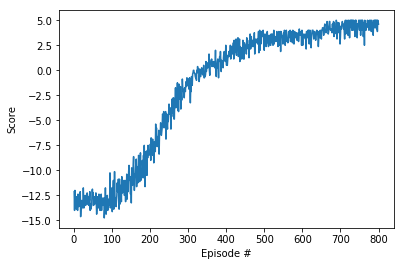

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(mean_rewards)+1), mean_rewards)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
# save your policy!
torch.save(policy.state_dict(), 'PPO_800epis.pth')

outfile:  I:\1-Deep-Reinforcement-Learining\Pong-PPO_vers_2\_tmp_3c6351c0.html



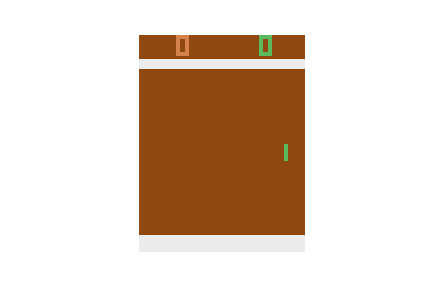
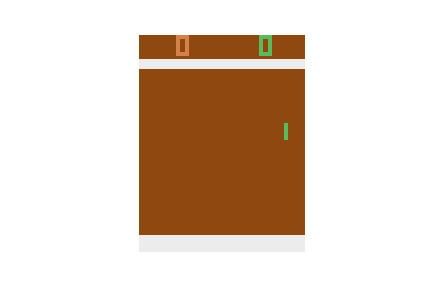
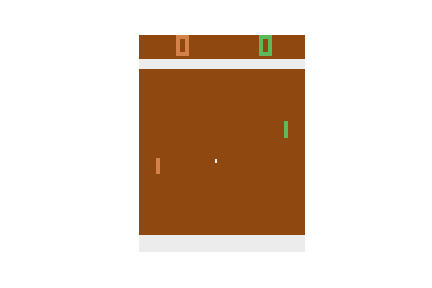
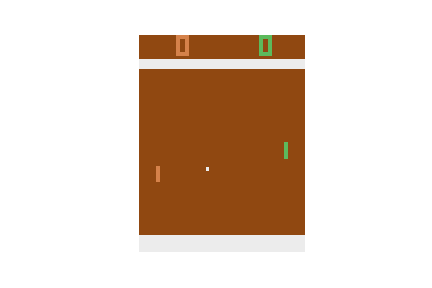
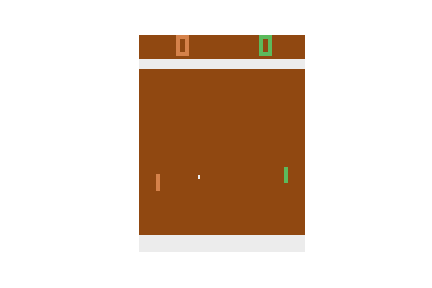
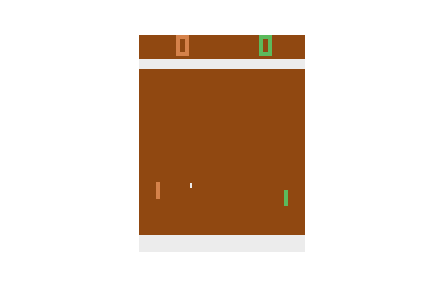
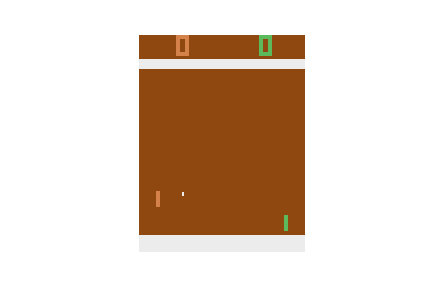
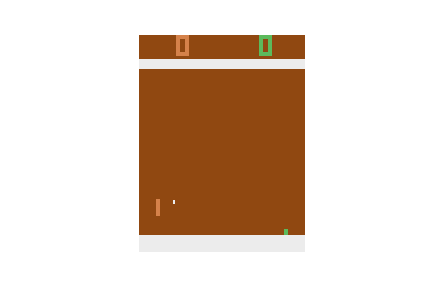
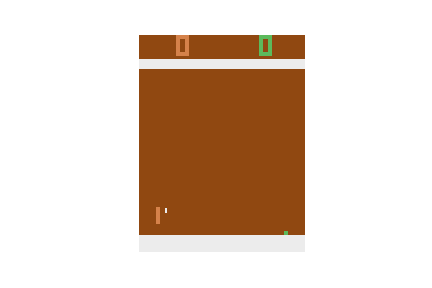
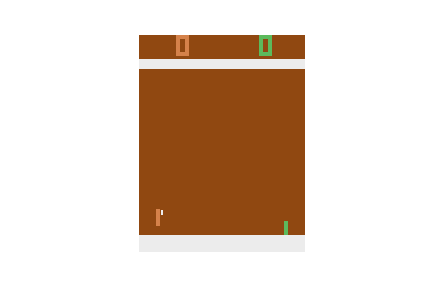
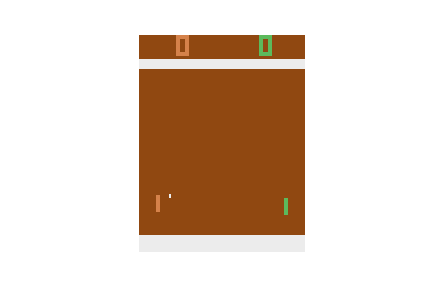
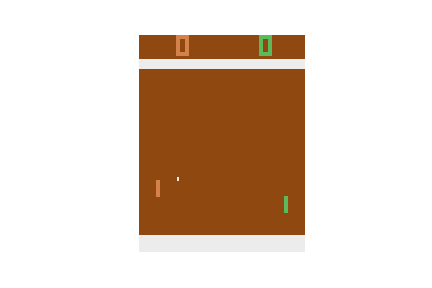
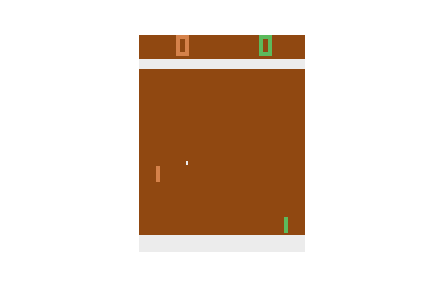
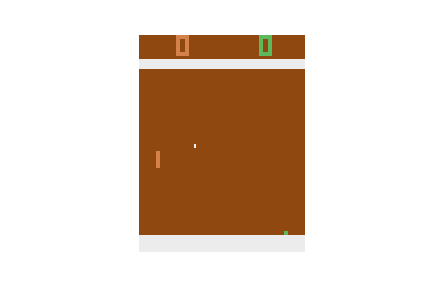
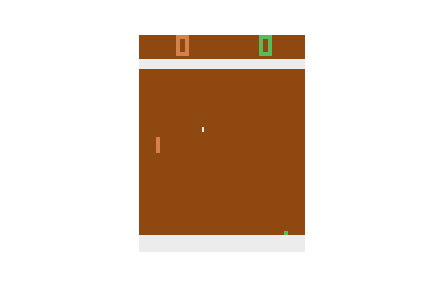
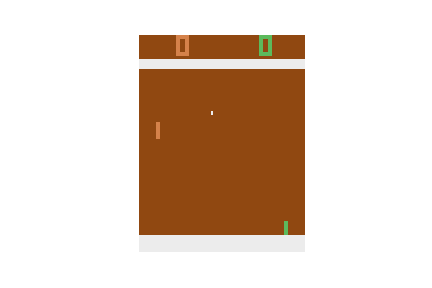
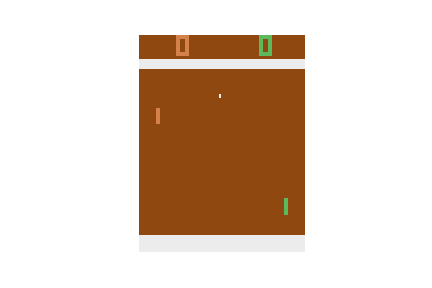
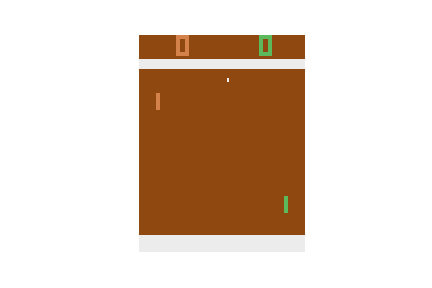
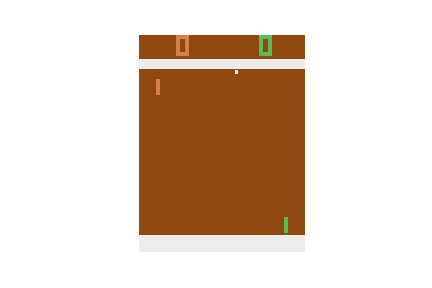
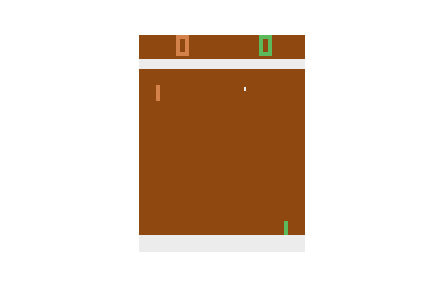
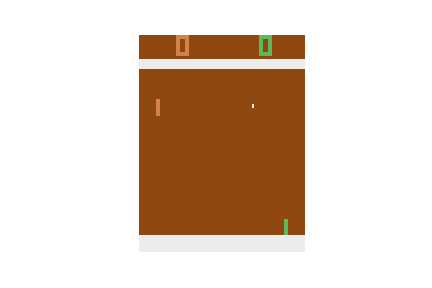
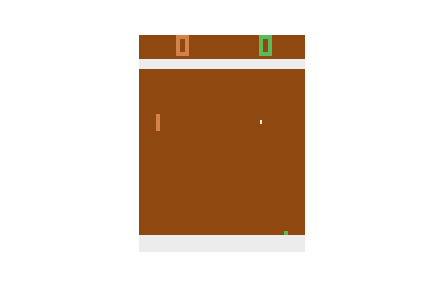
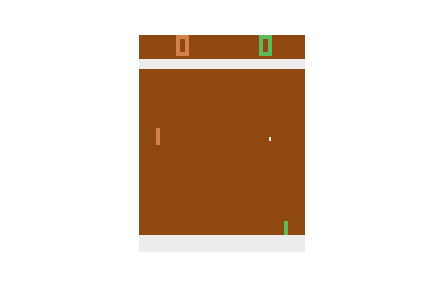
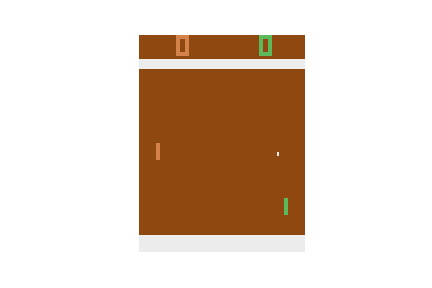
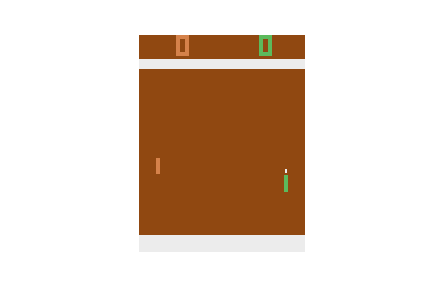
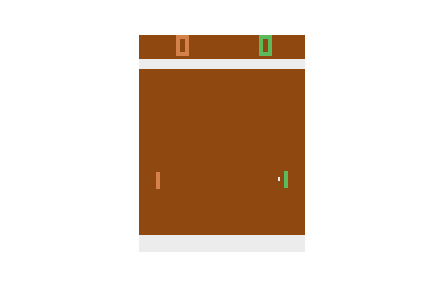
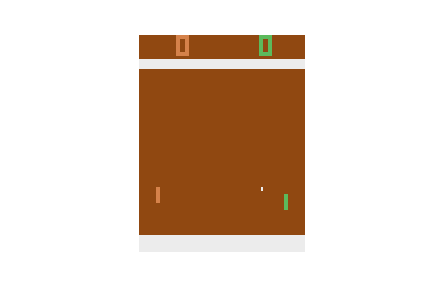
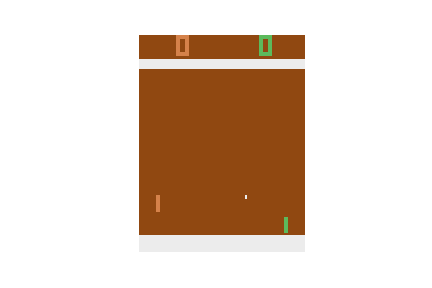
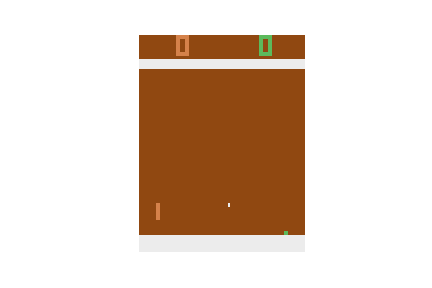
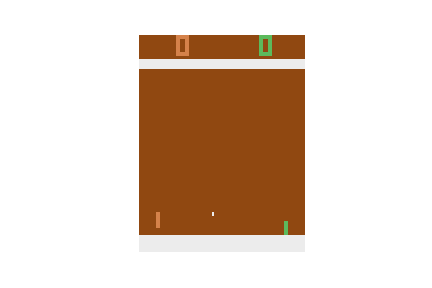
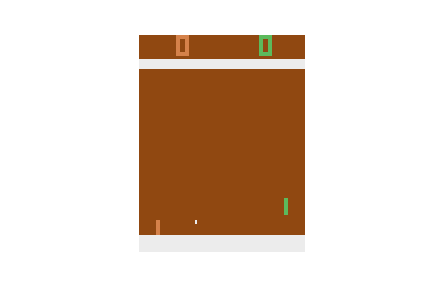
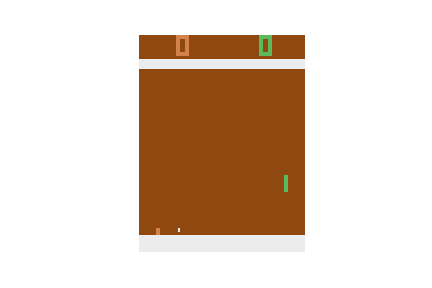
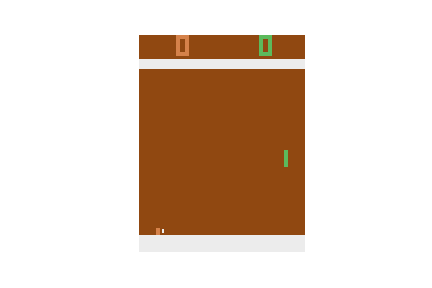
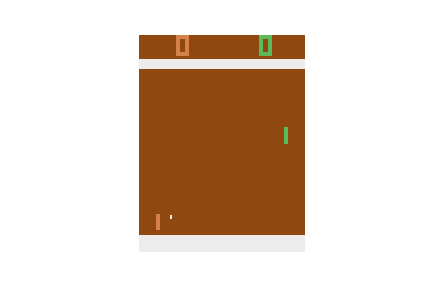
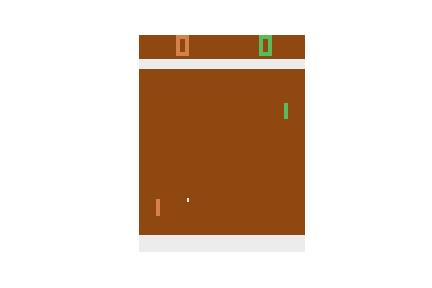
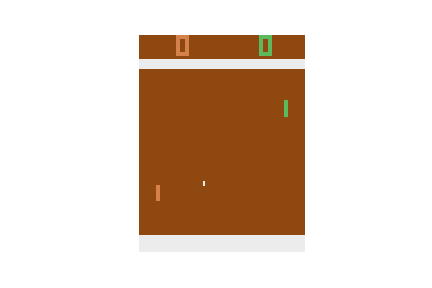
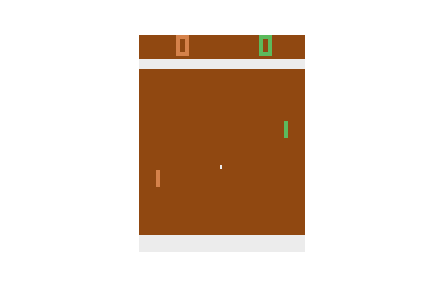
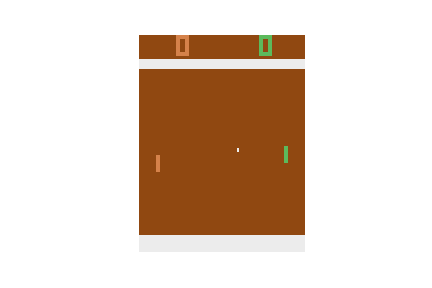
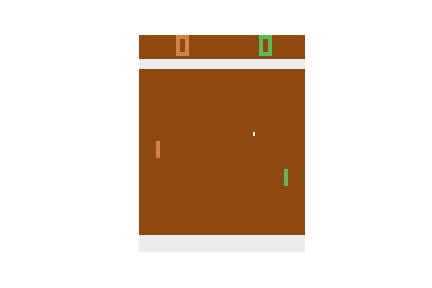
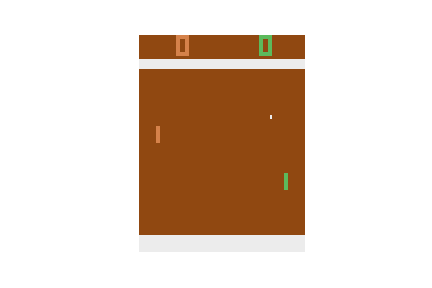
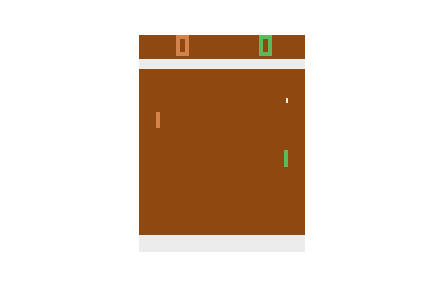
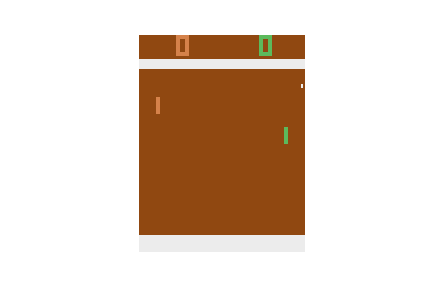
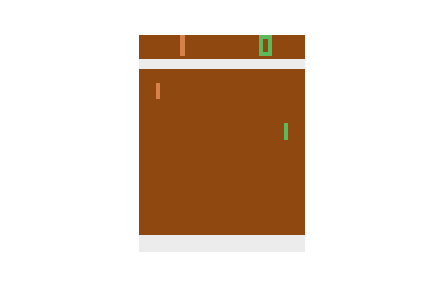
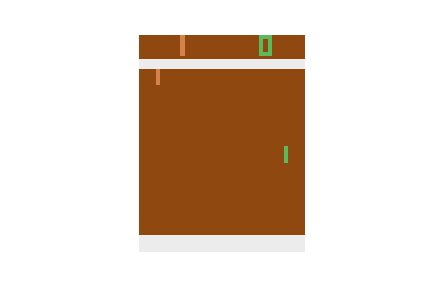
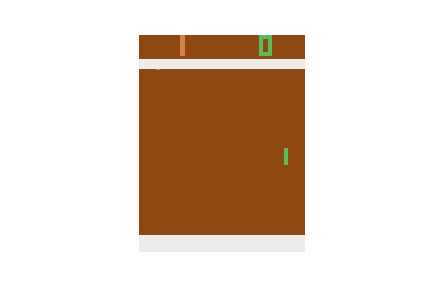
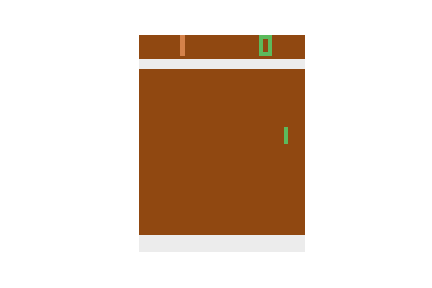
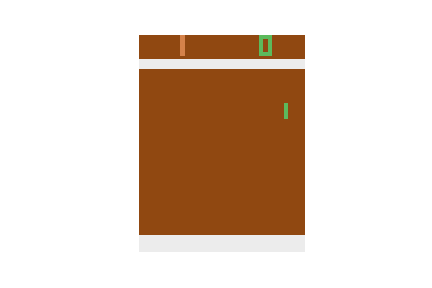
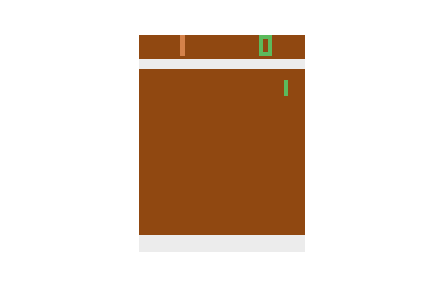
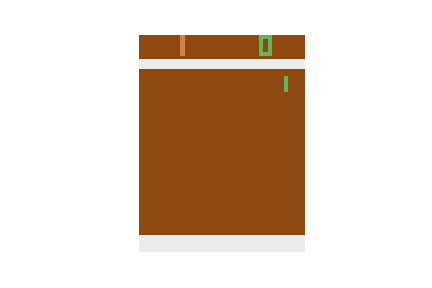
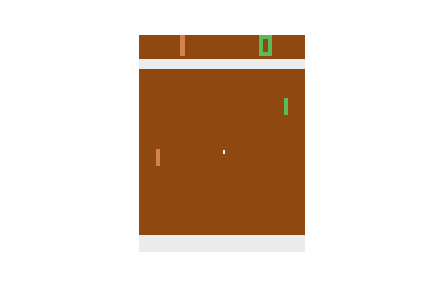
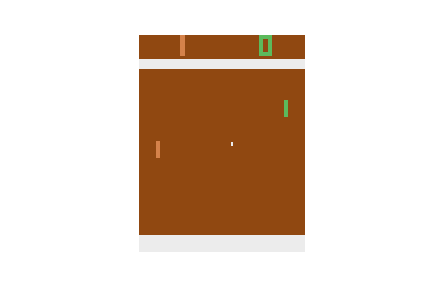
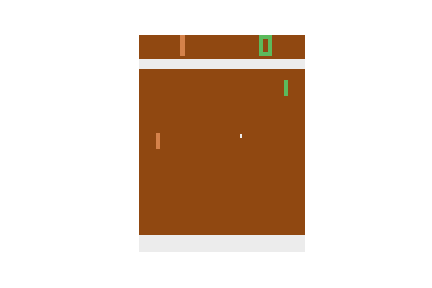
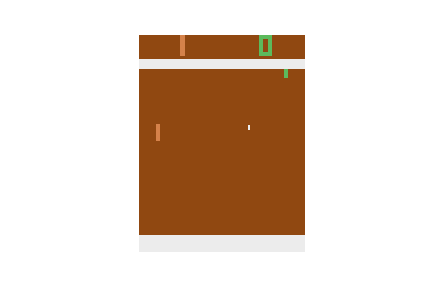
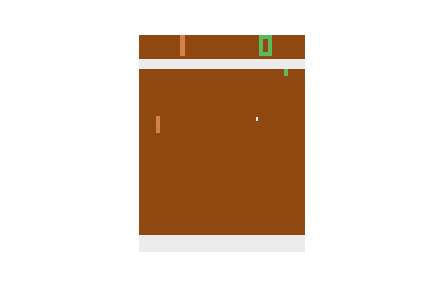
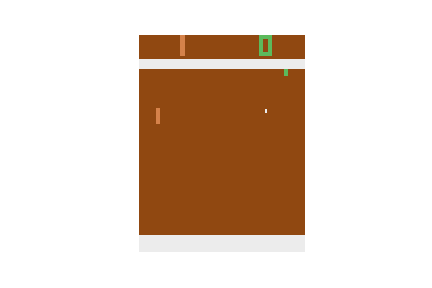
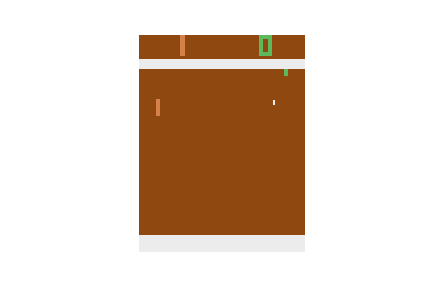
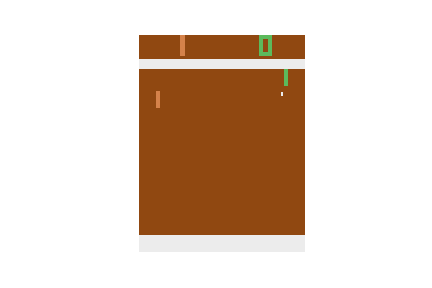
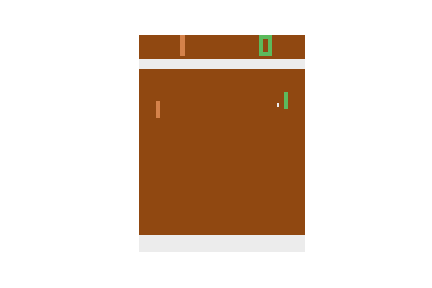
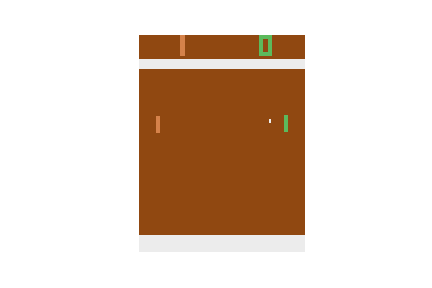
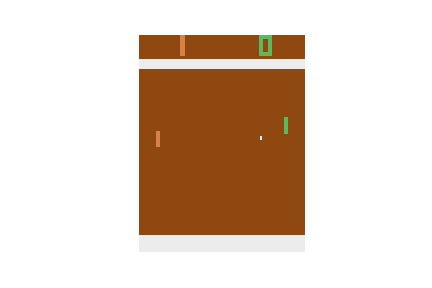
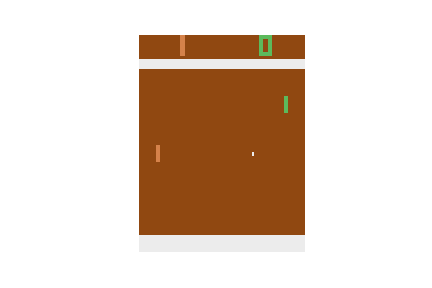
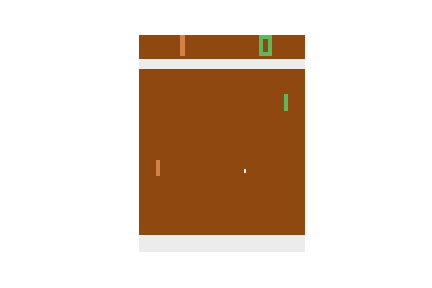
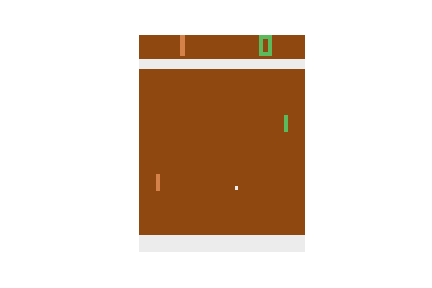
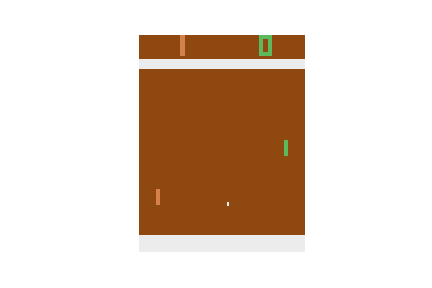
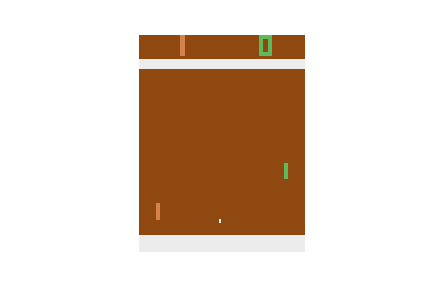
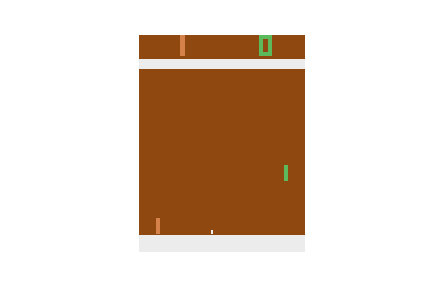
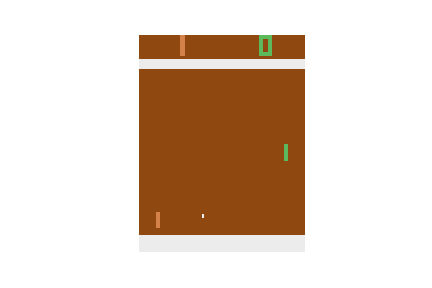
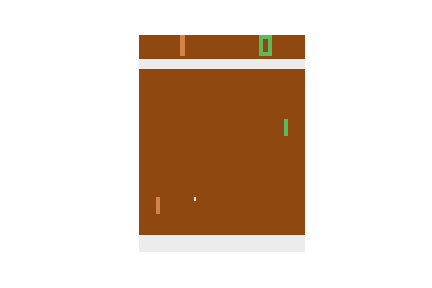
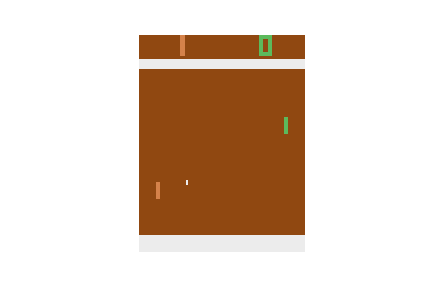
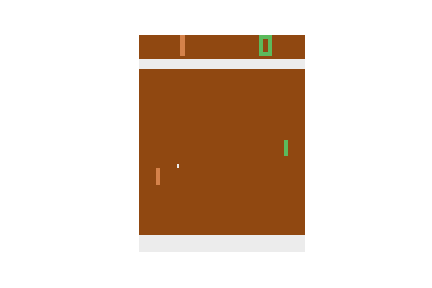
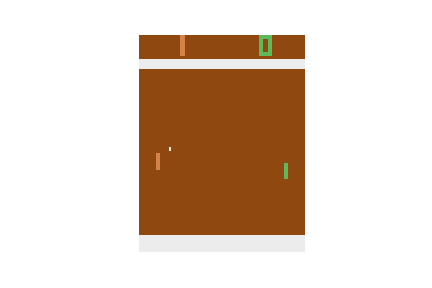
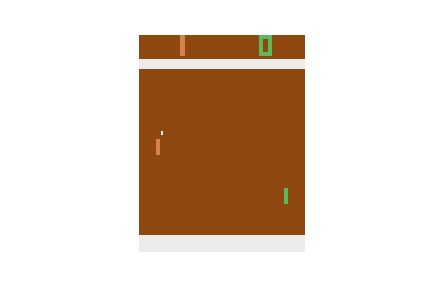
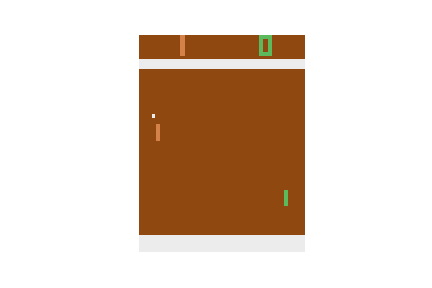
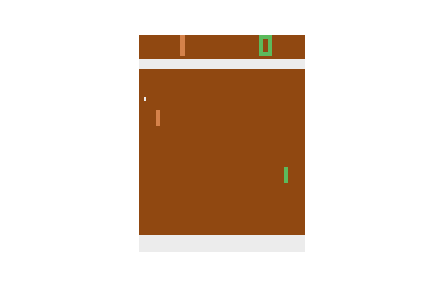
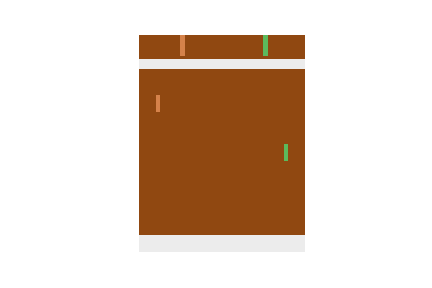
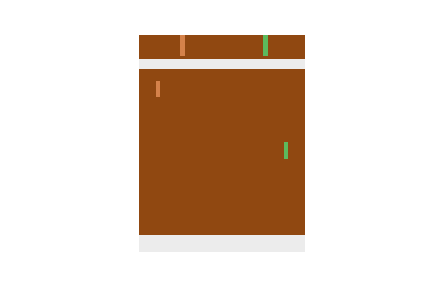
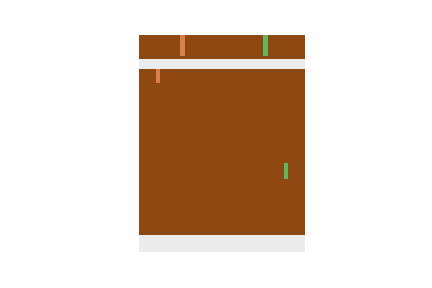
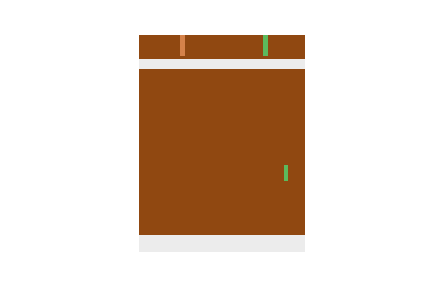
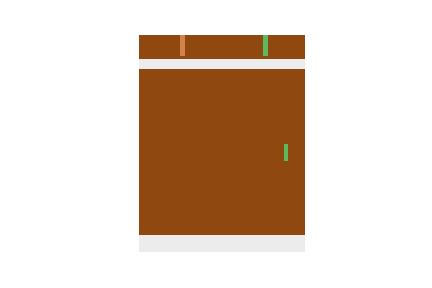
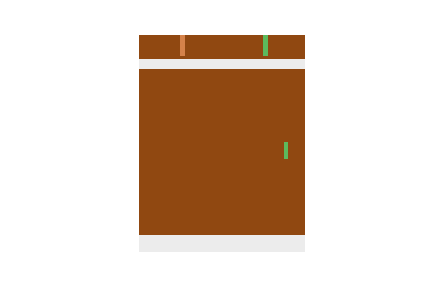
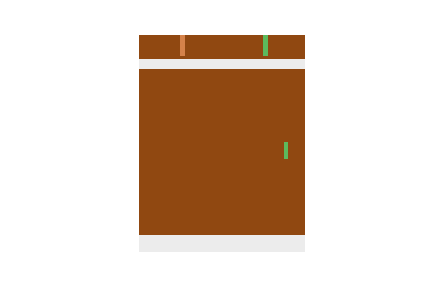
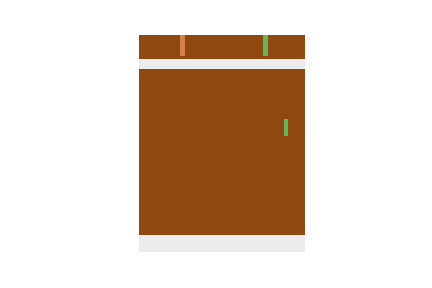
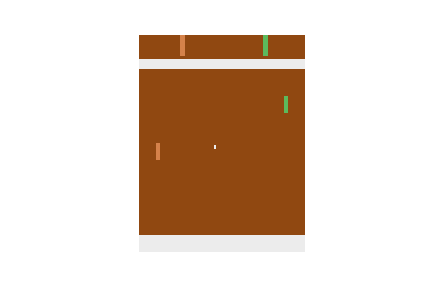
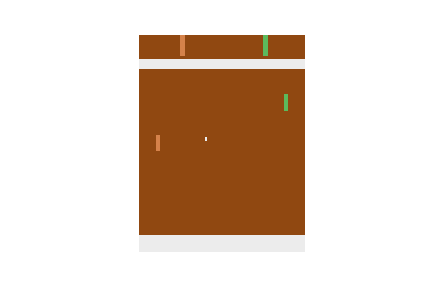
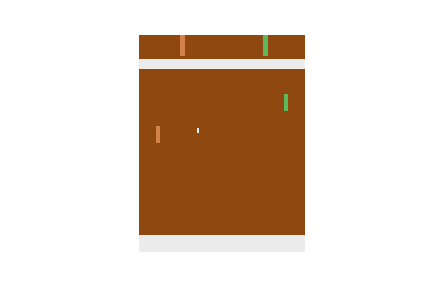
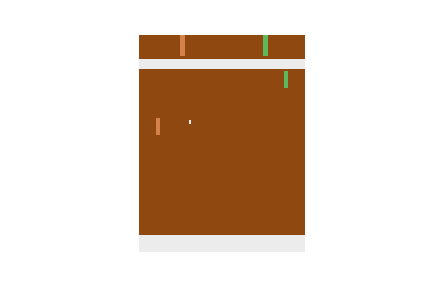
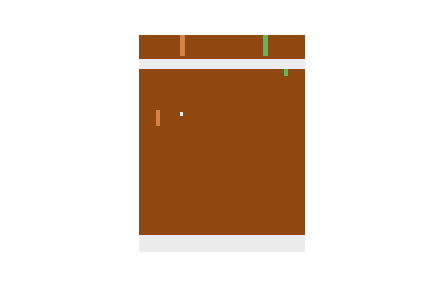
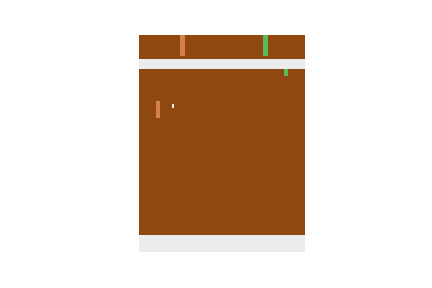
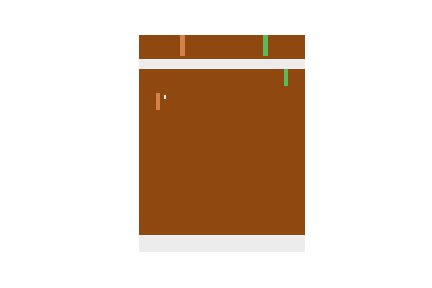
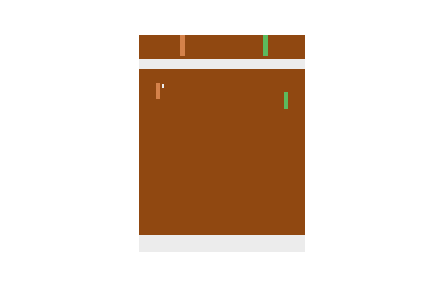
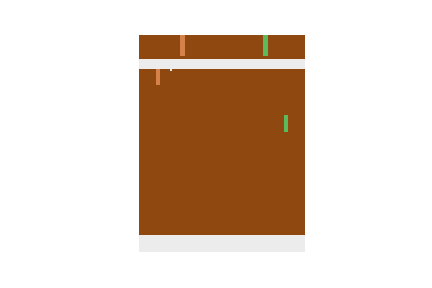
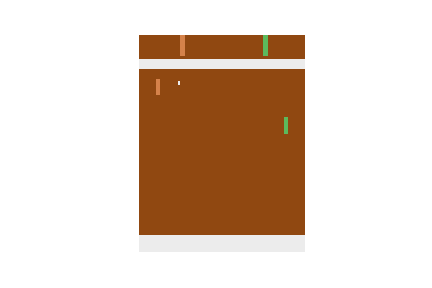
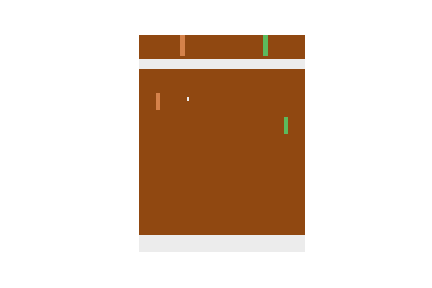
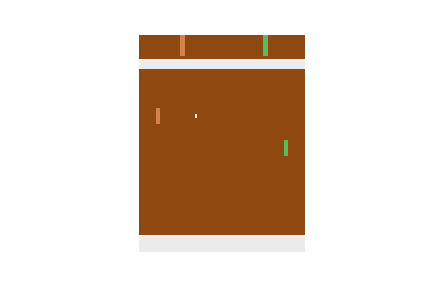
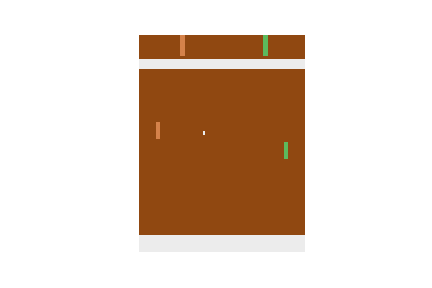
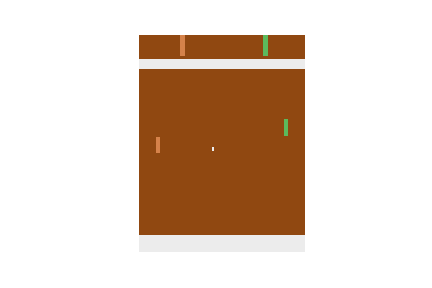
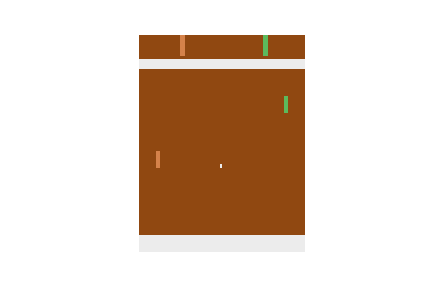
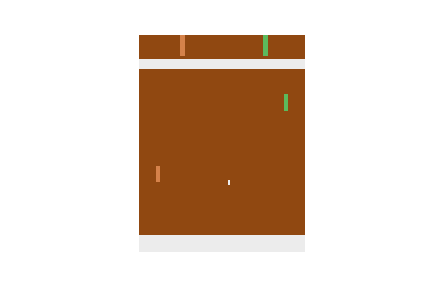
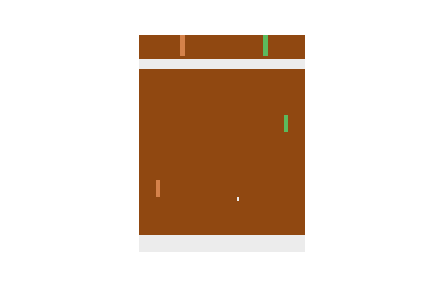
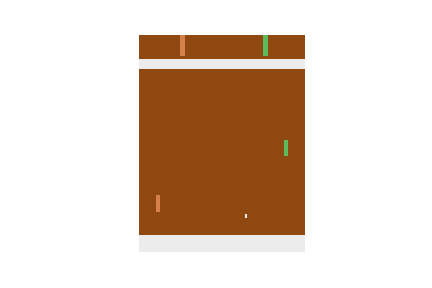
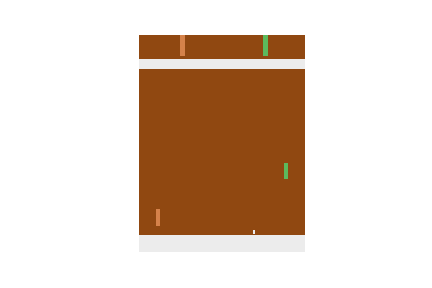
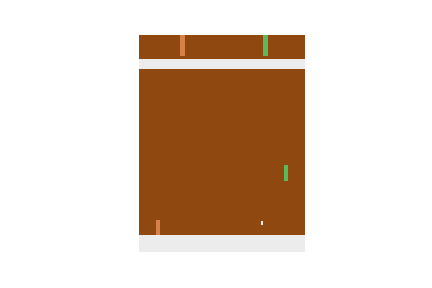
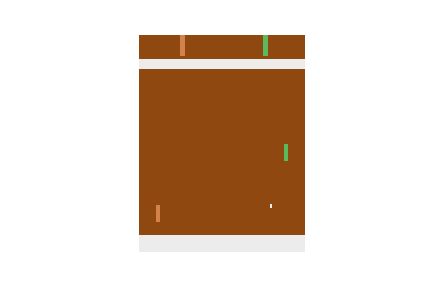
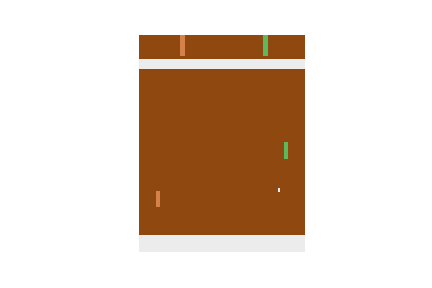
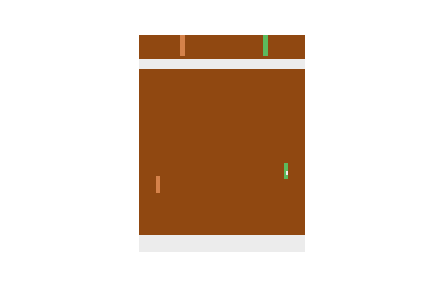
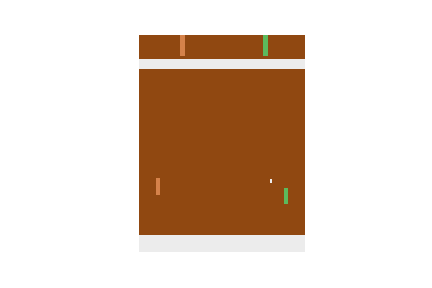
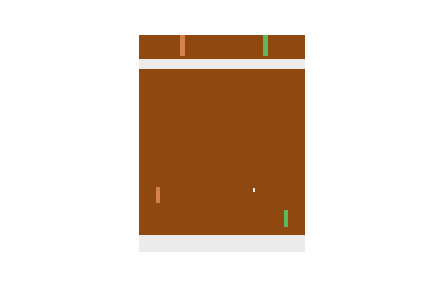
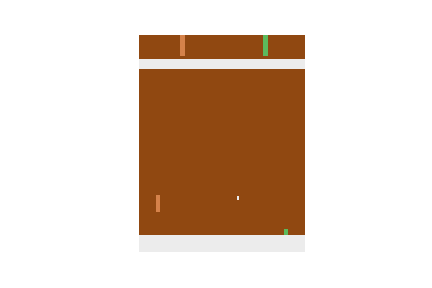
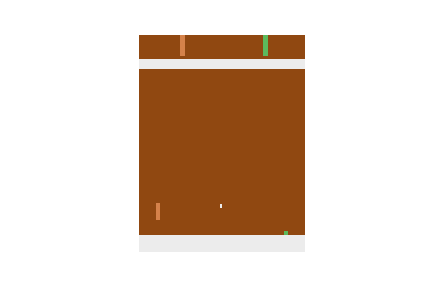
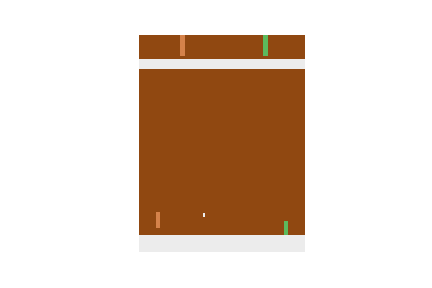
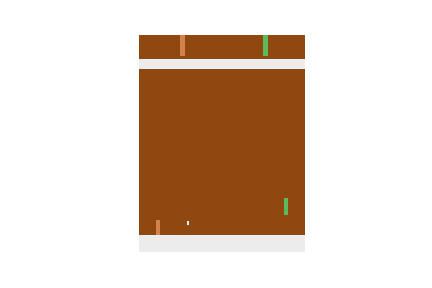
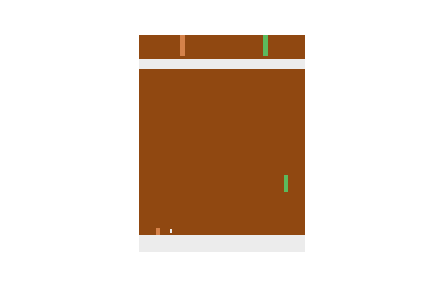
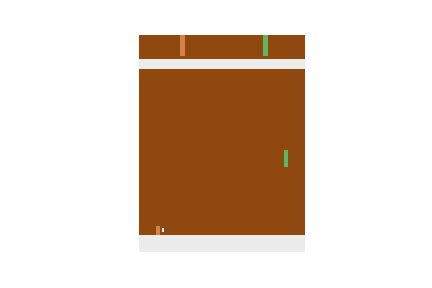
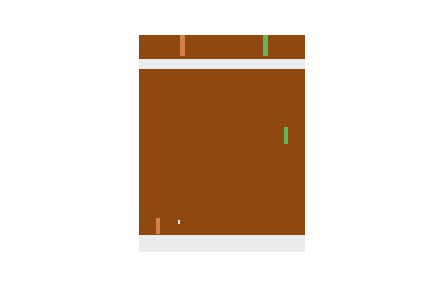
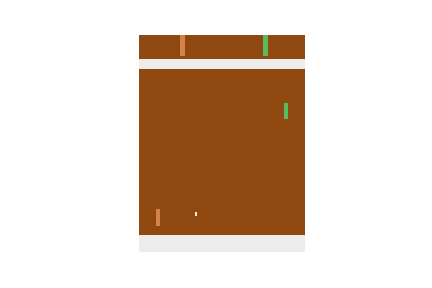
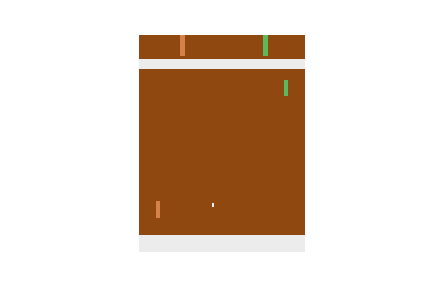
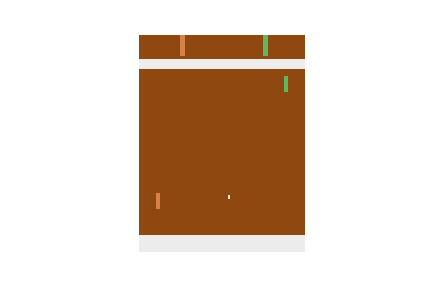
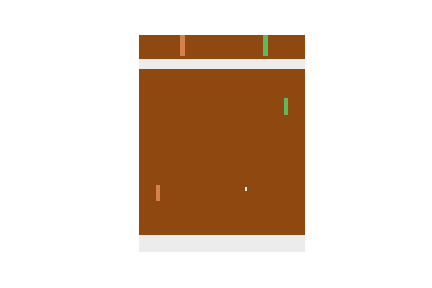
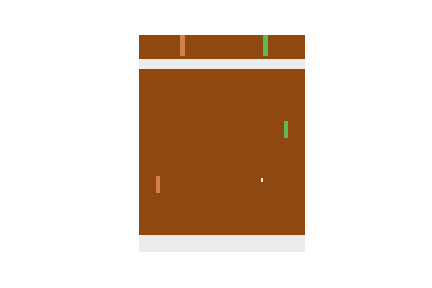
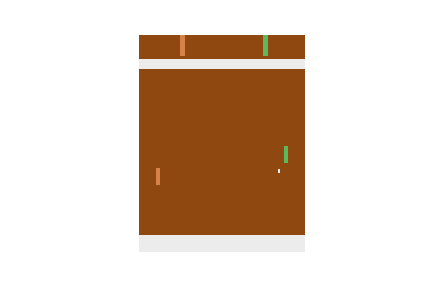
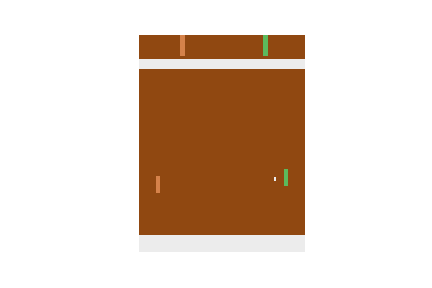
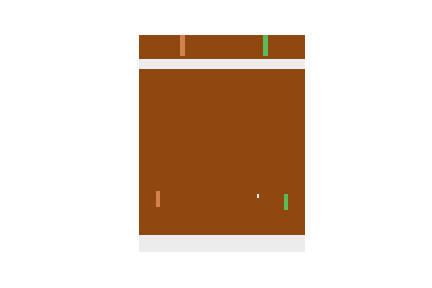
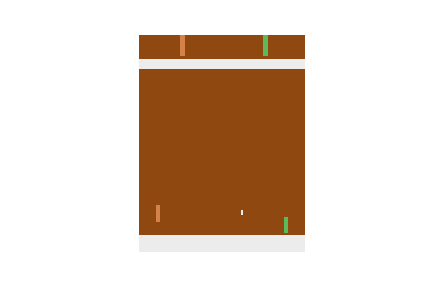
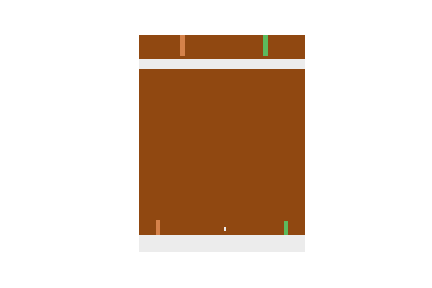
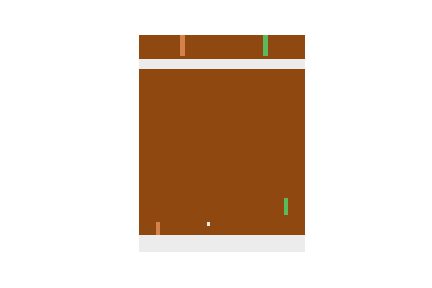
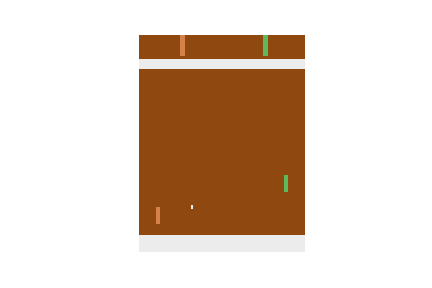
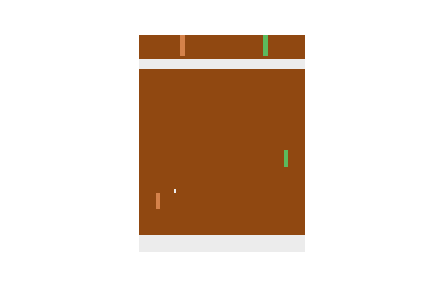
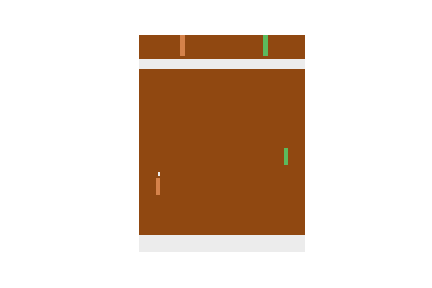
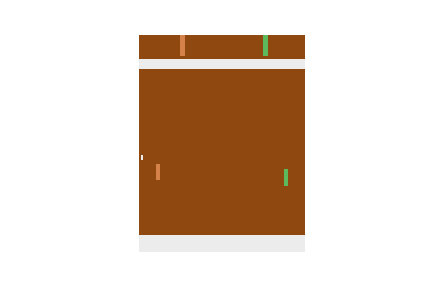
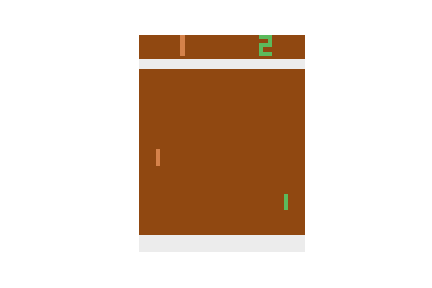
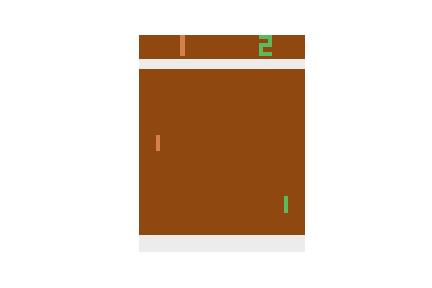
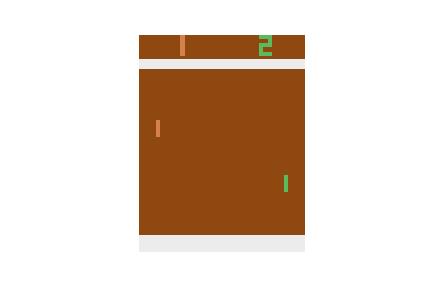
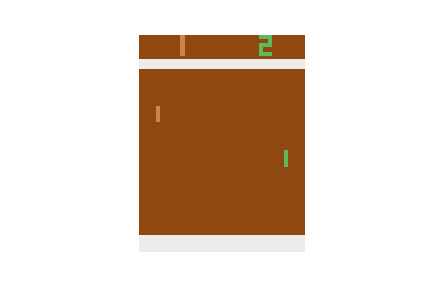
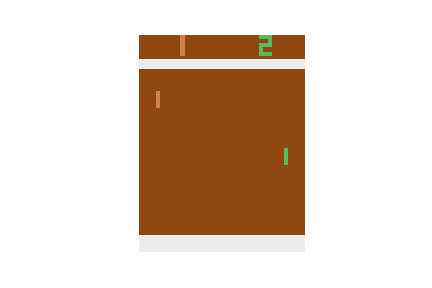
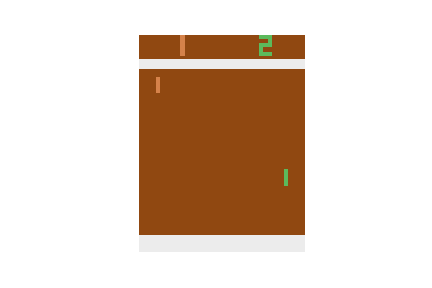
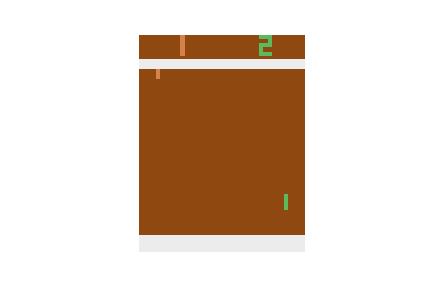
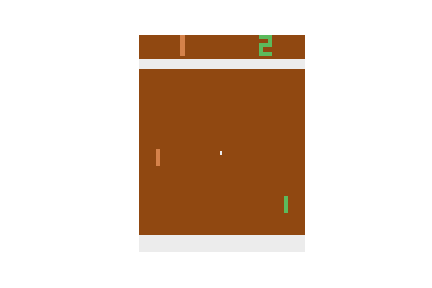
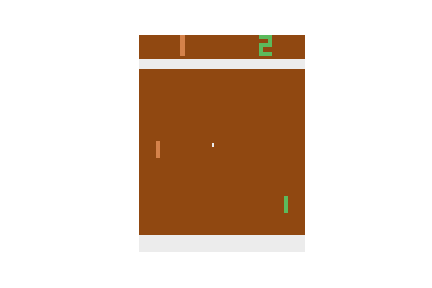
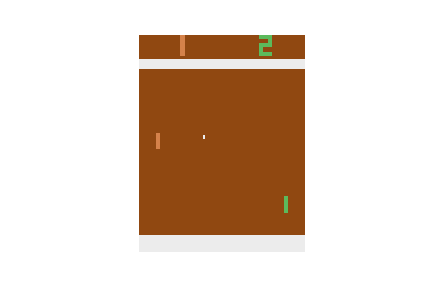
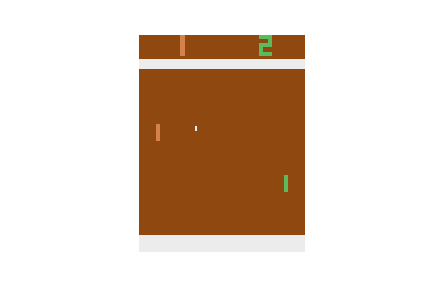
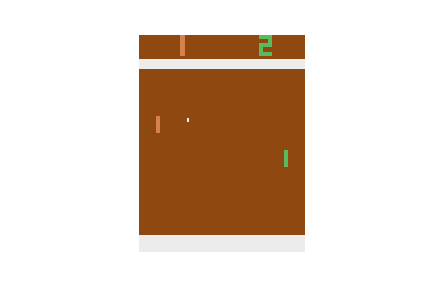
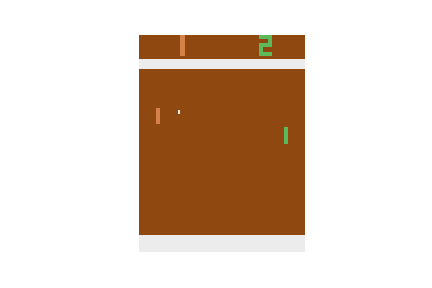
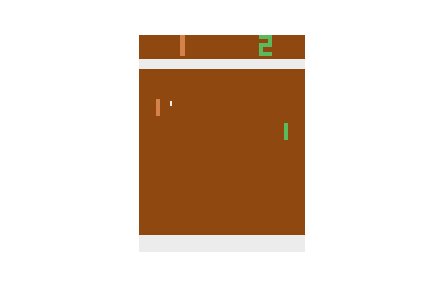
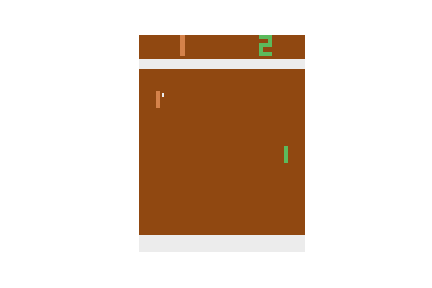
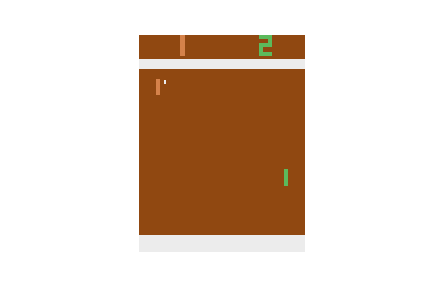
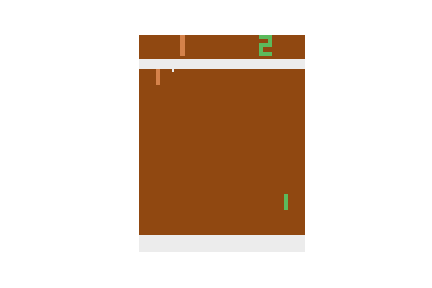
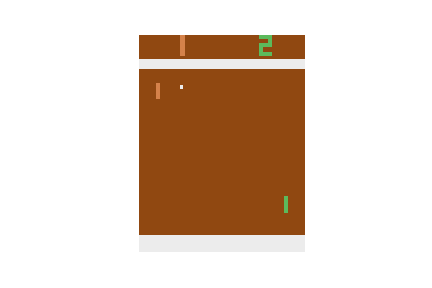
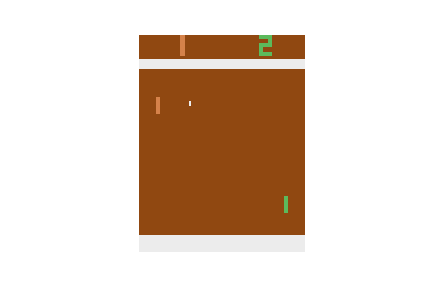
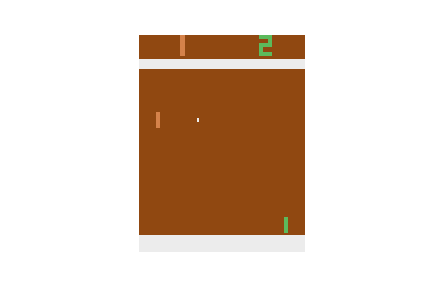
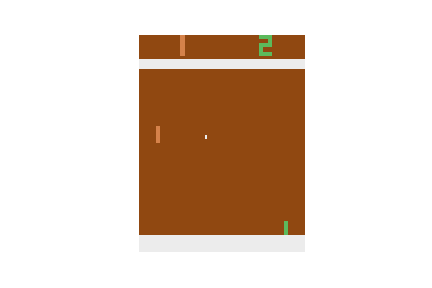
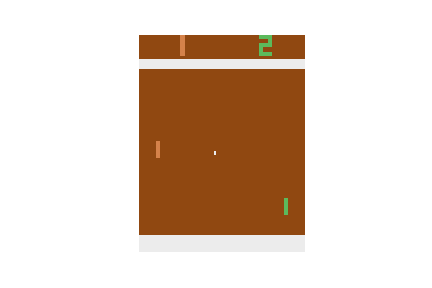
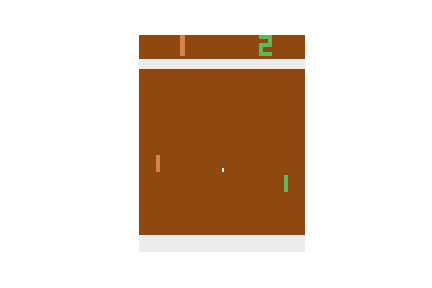
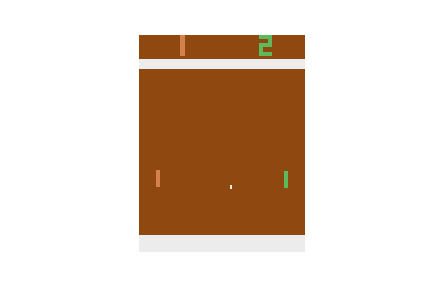
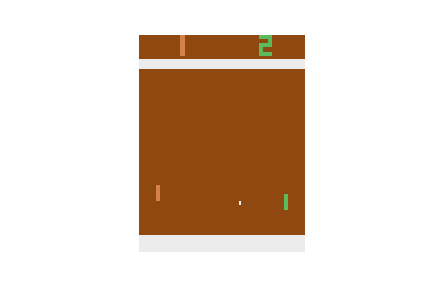
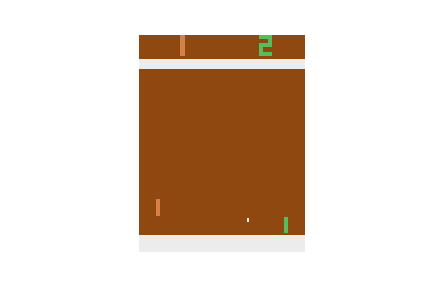
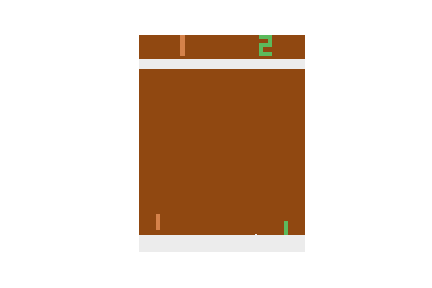
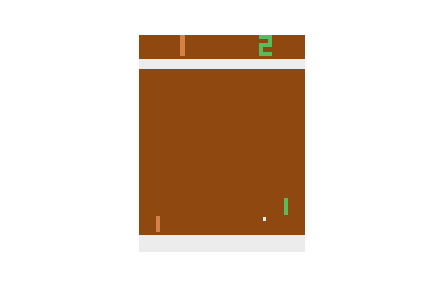
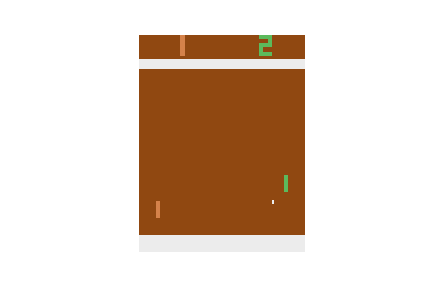
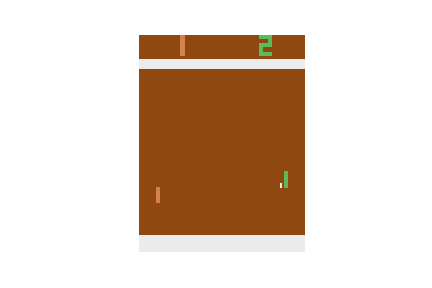
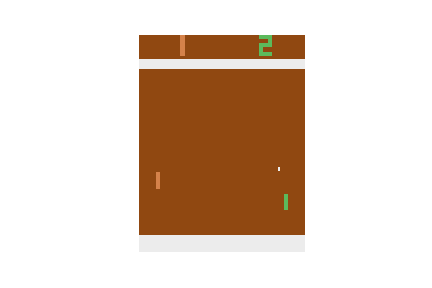
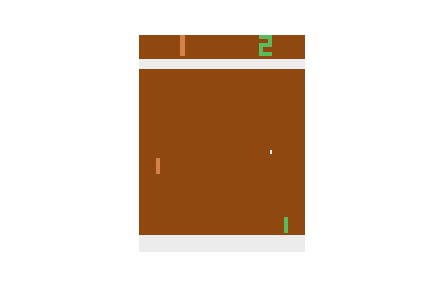
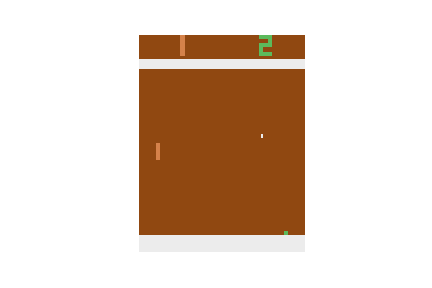
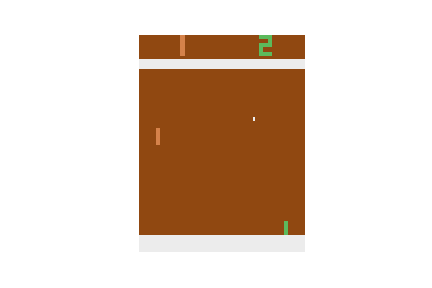
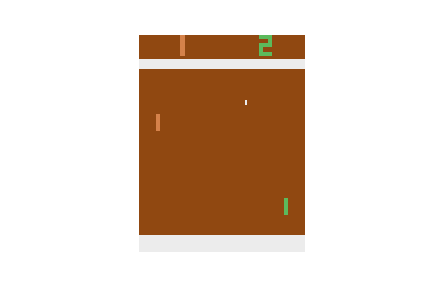
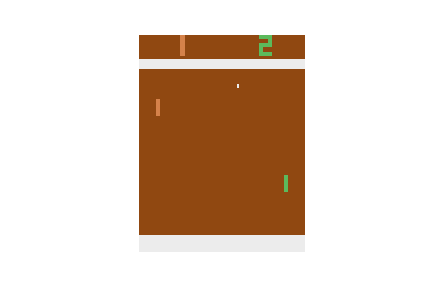
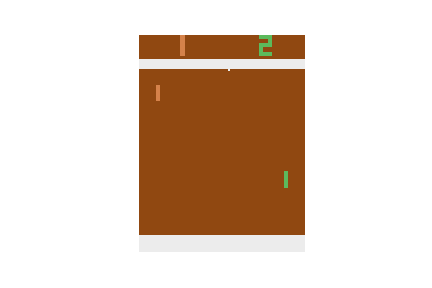
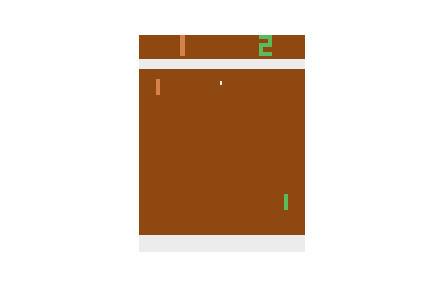
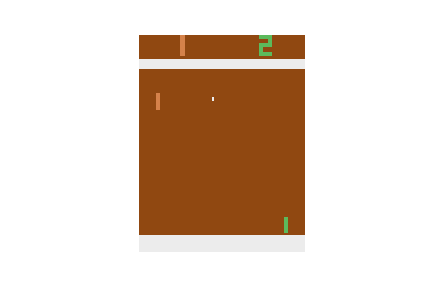
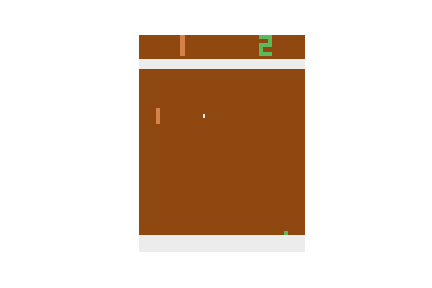
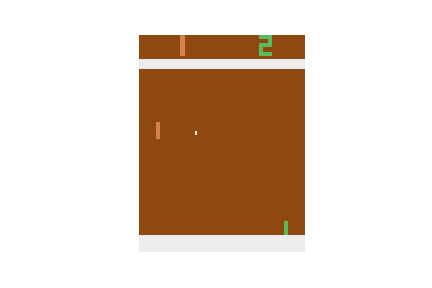
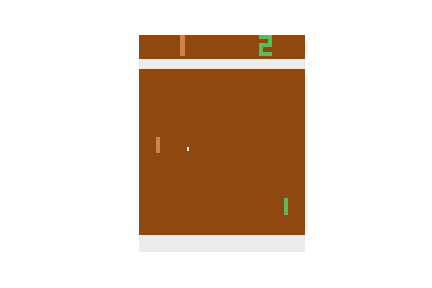
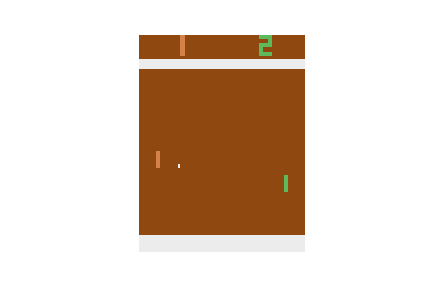
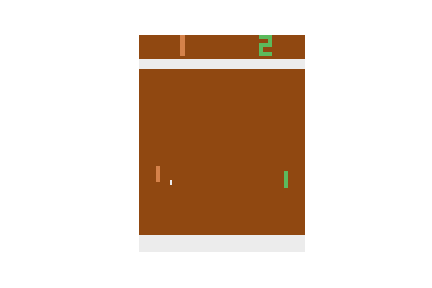
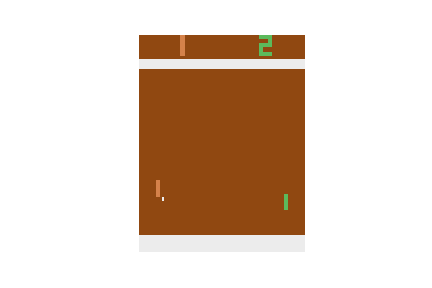
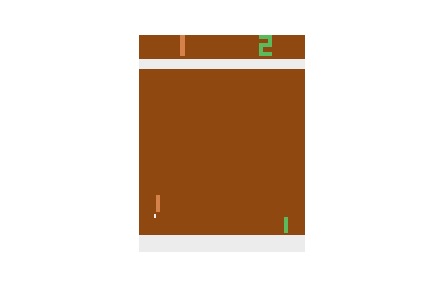
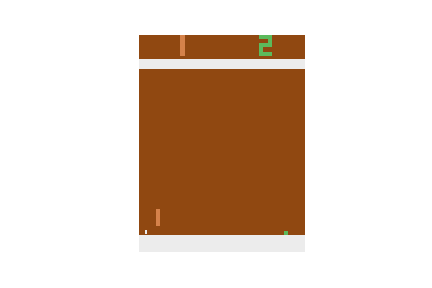
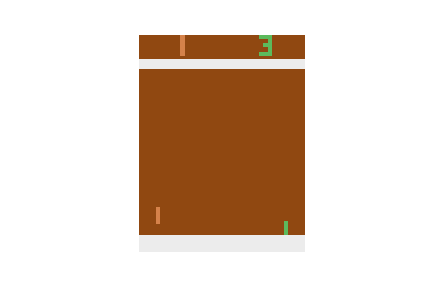
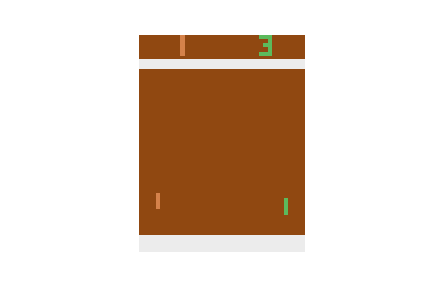
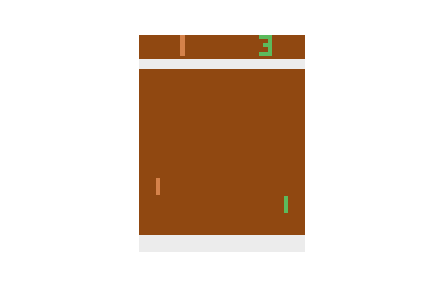
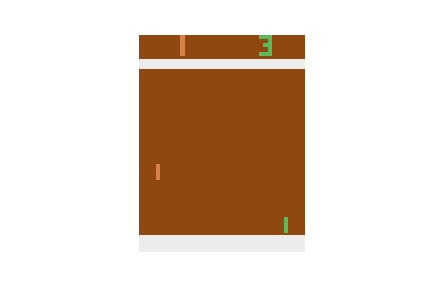
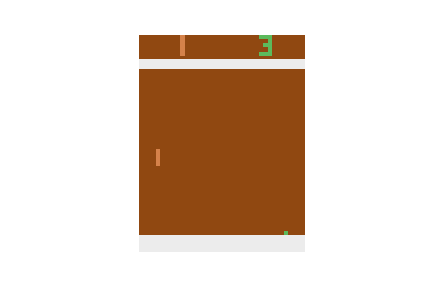
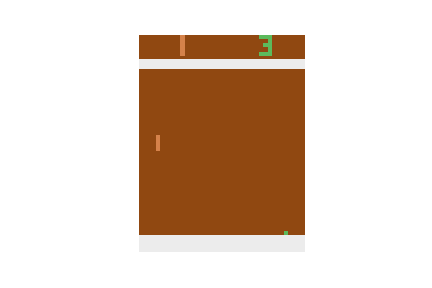
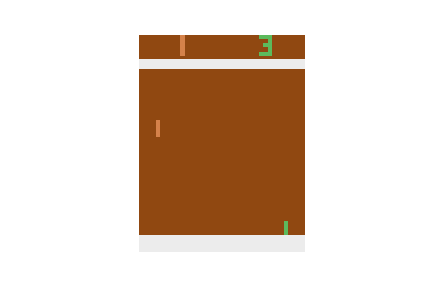
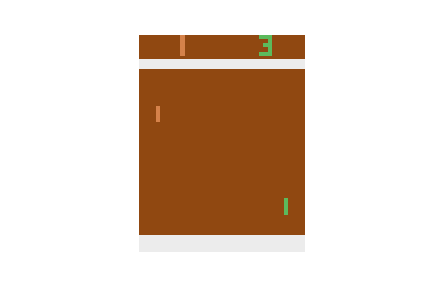
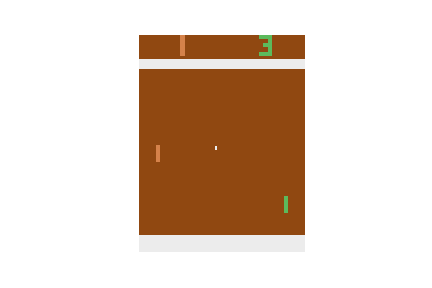
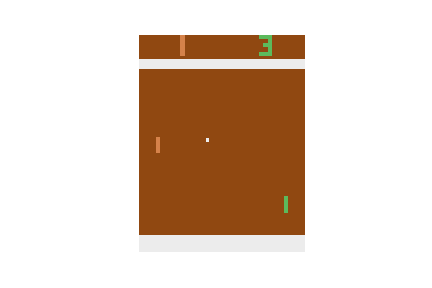
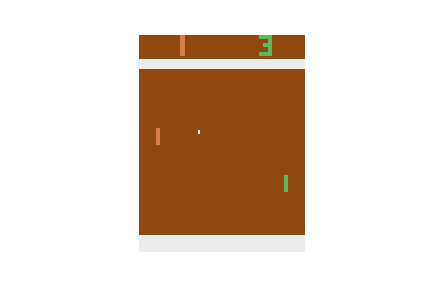
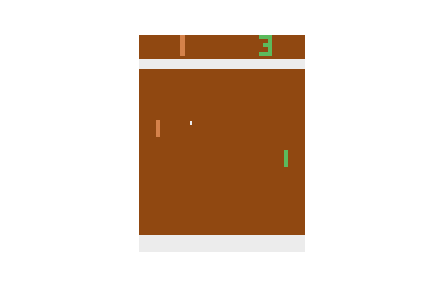
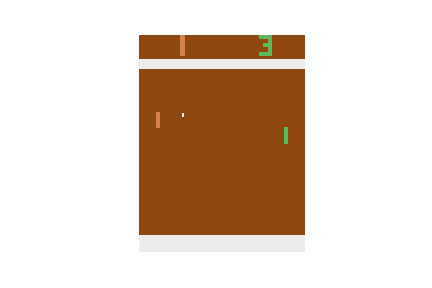
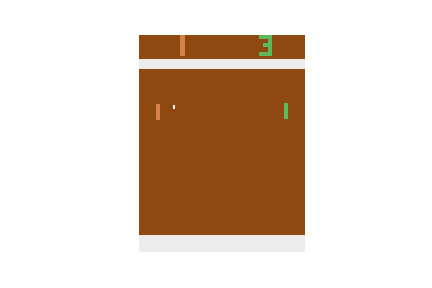
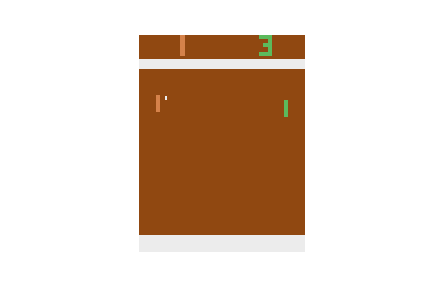
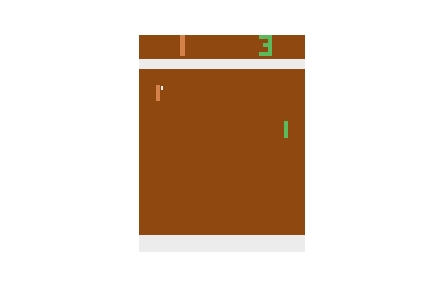
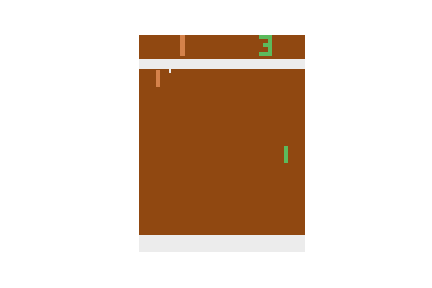
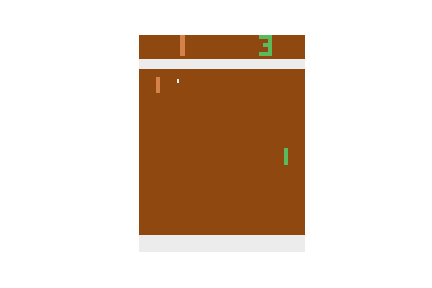
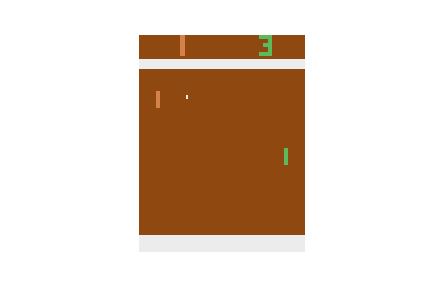
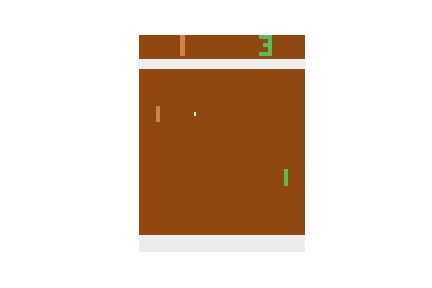
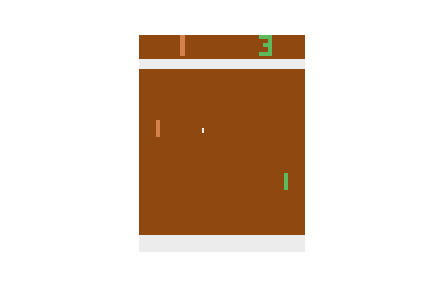
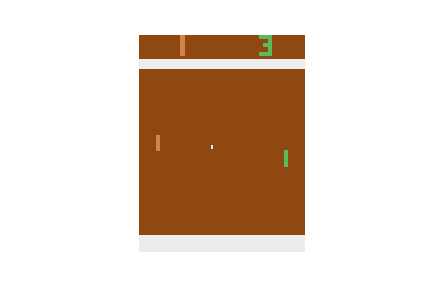
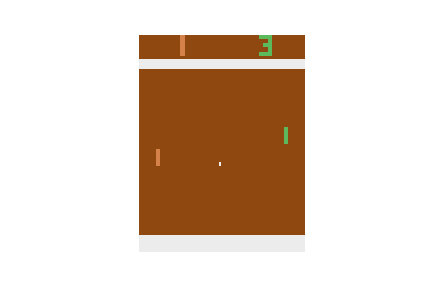
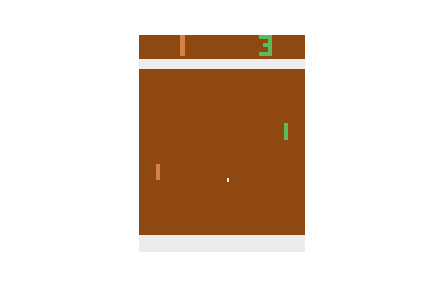
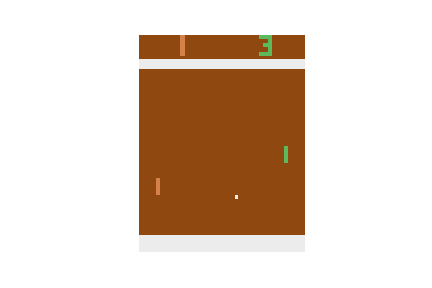
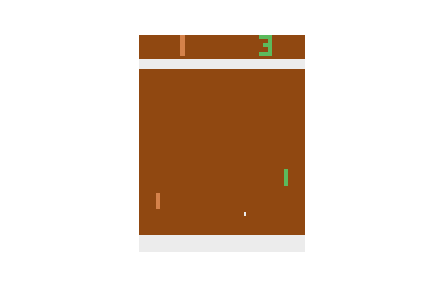
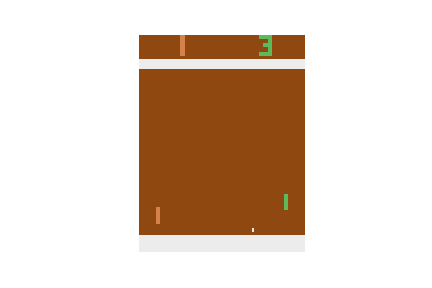
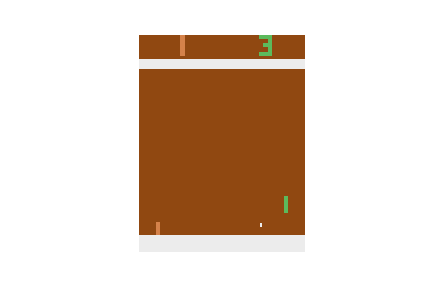
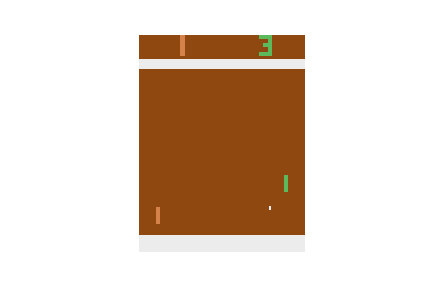
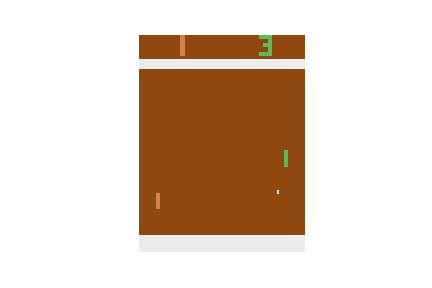
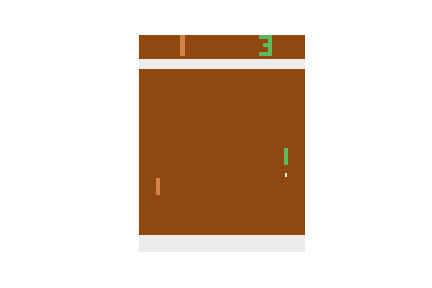
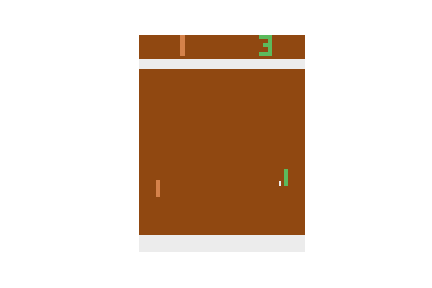
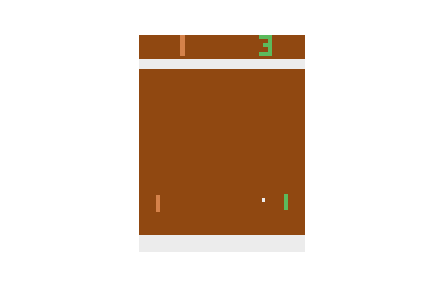
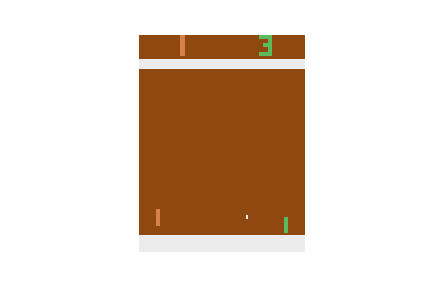
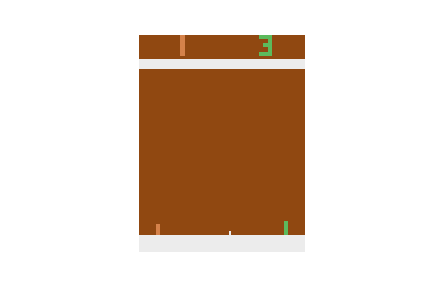
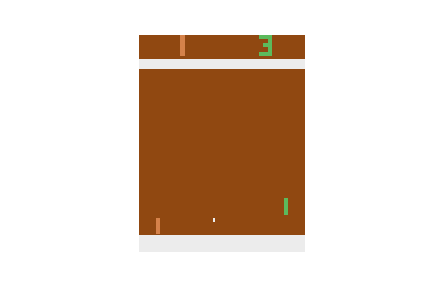
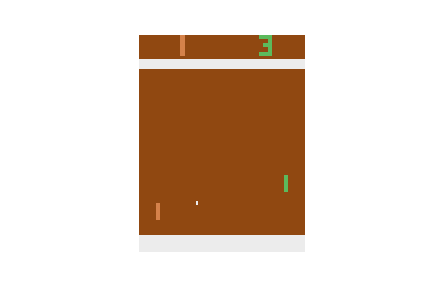
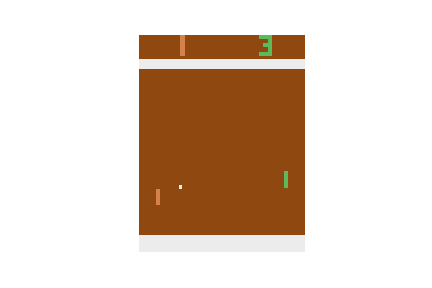
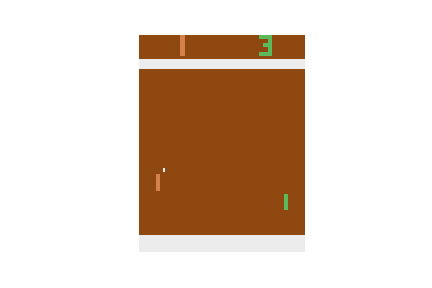
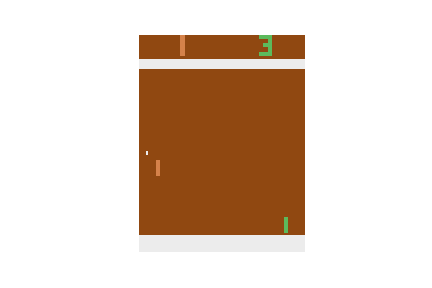
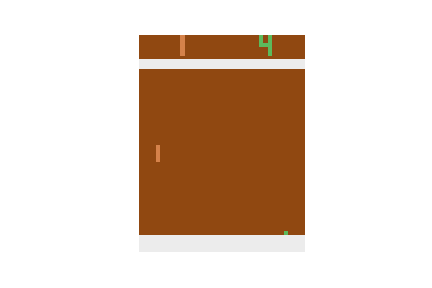
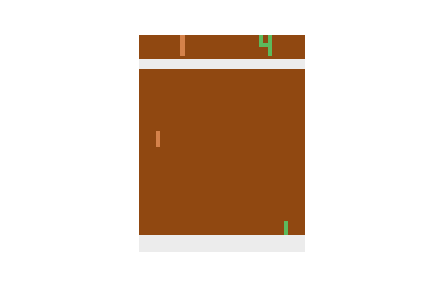
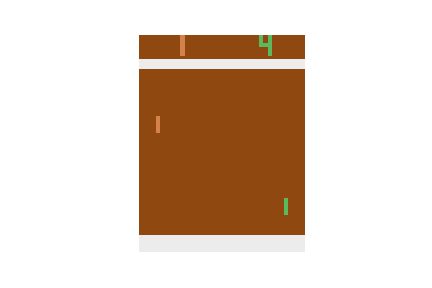
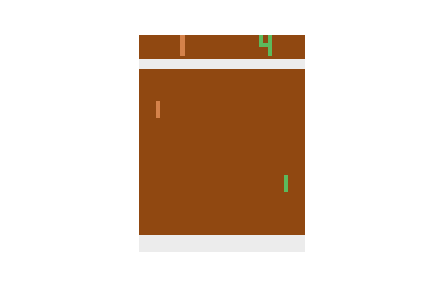
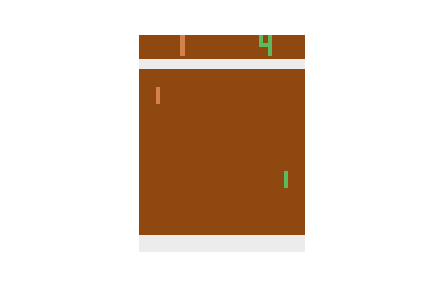
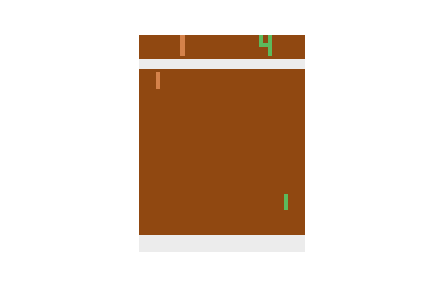
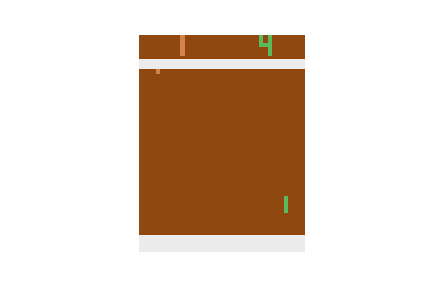
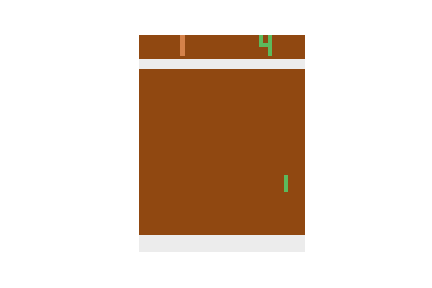
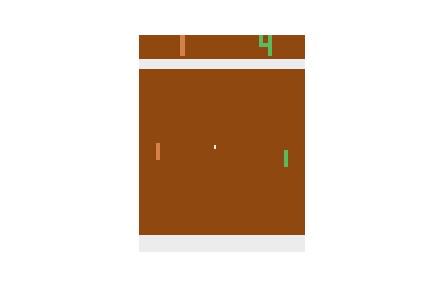
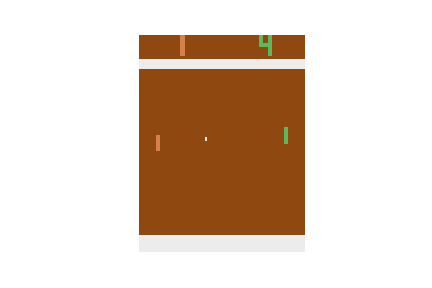
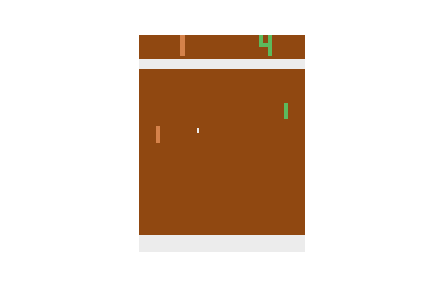
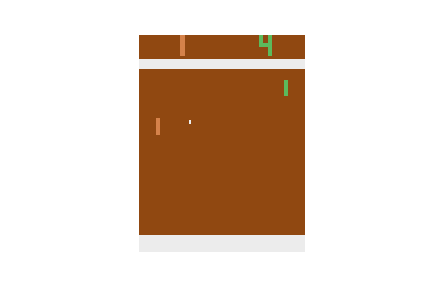
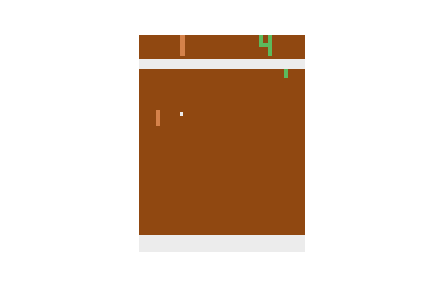
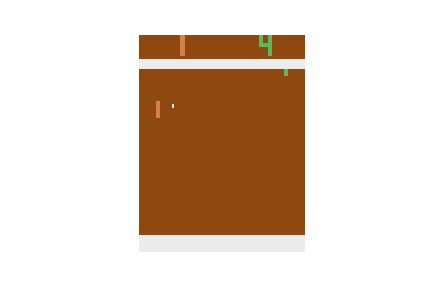
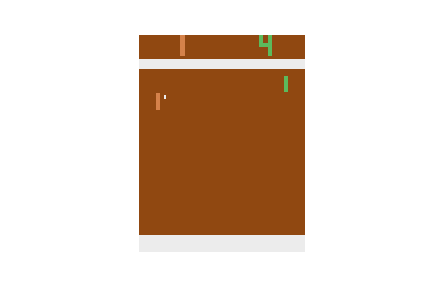
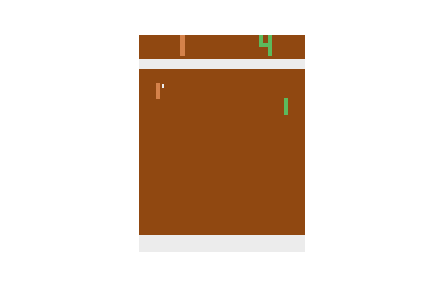
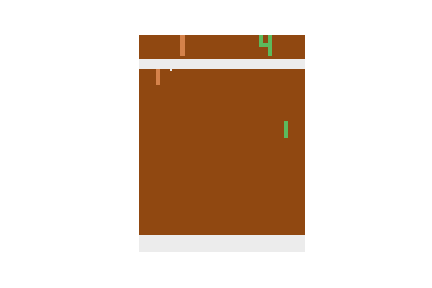
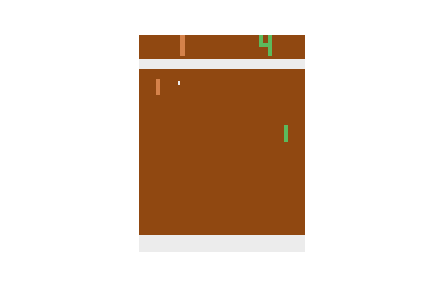
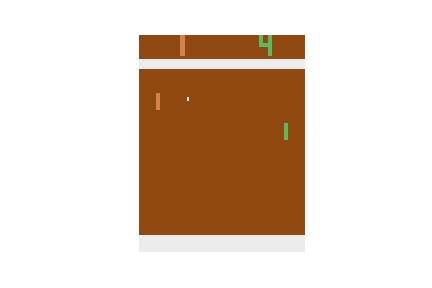
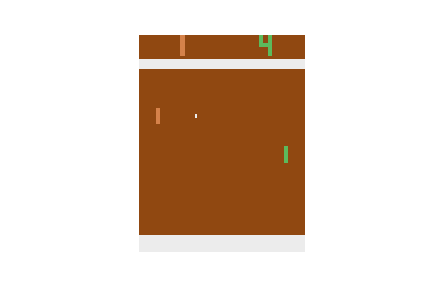
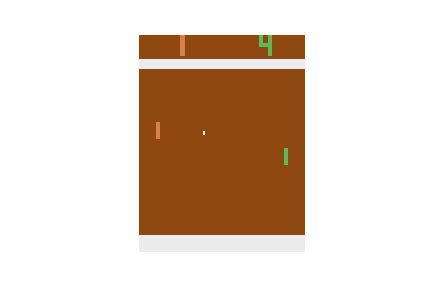
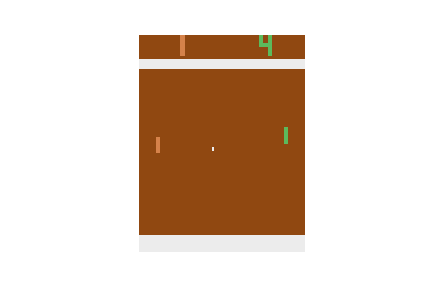
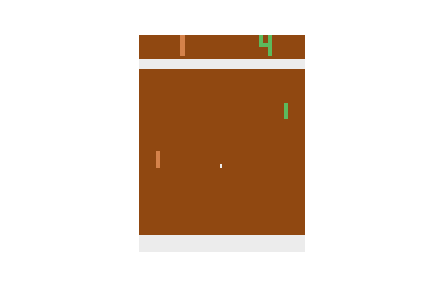
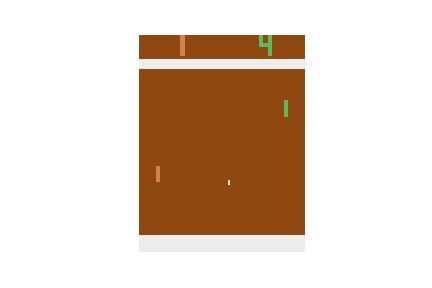
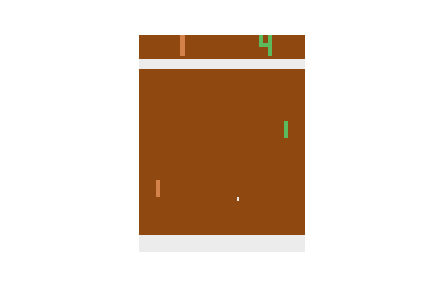
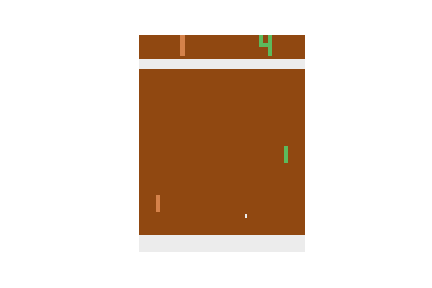
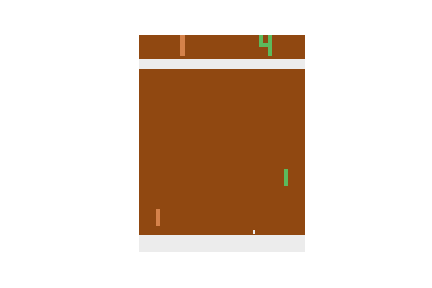
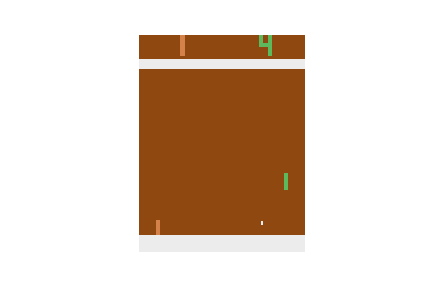
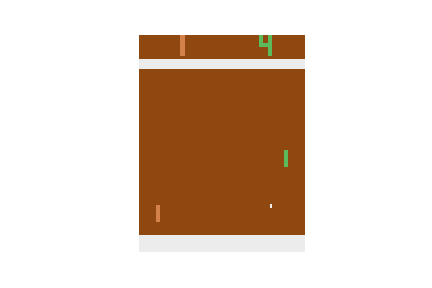
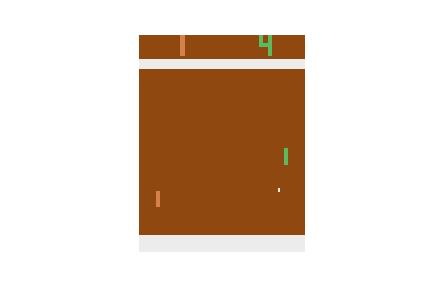
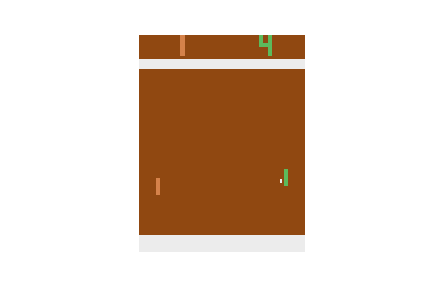
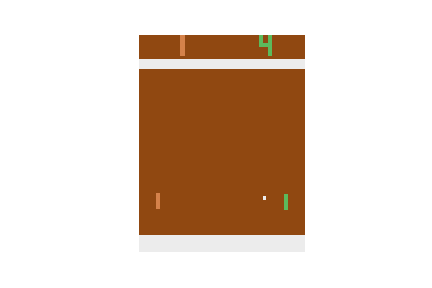
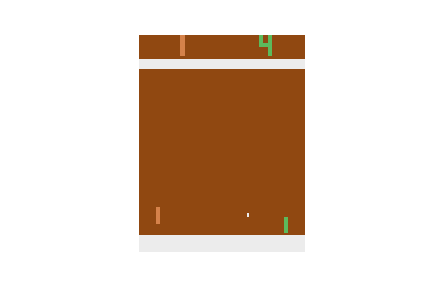
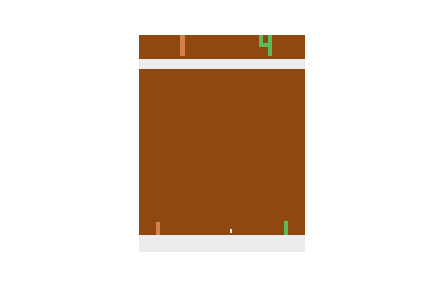
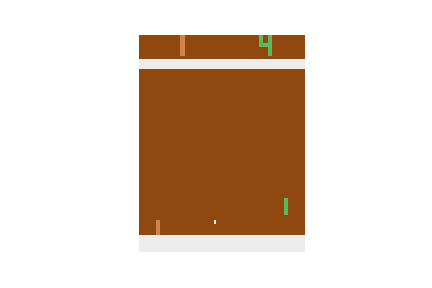
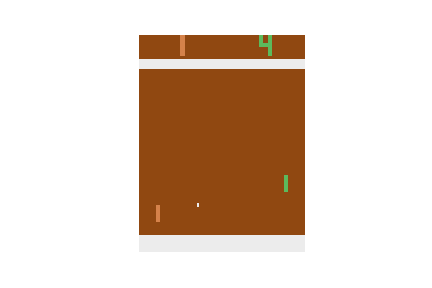
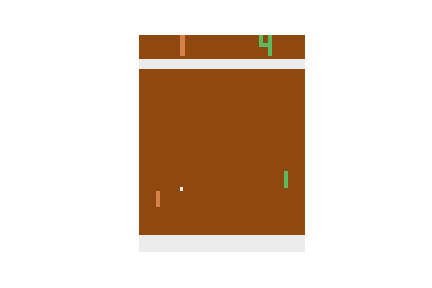
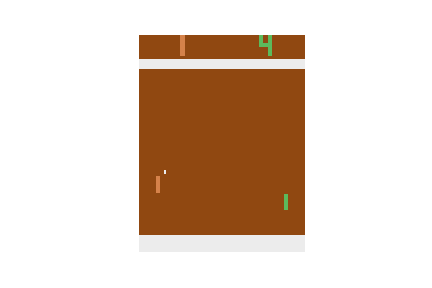
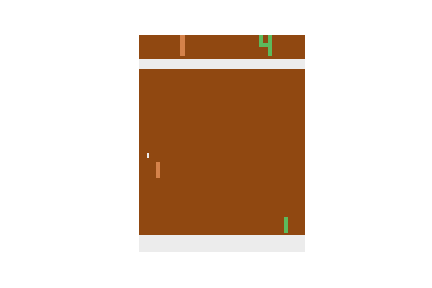
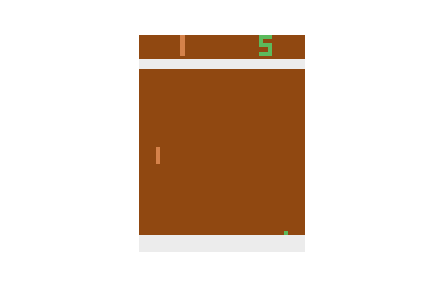
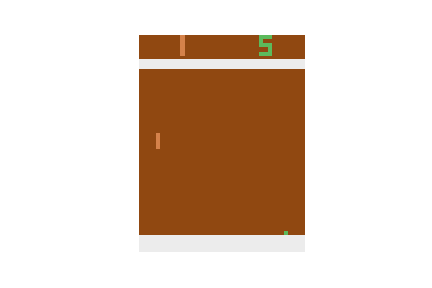
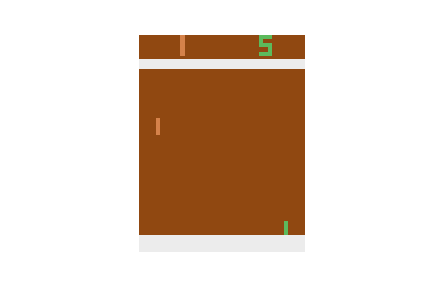
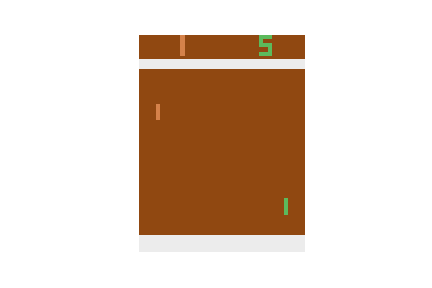
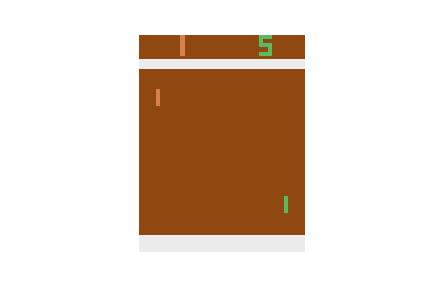
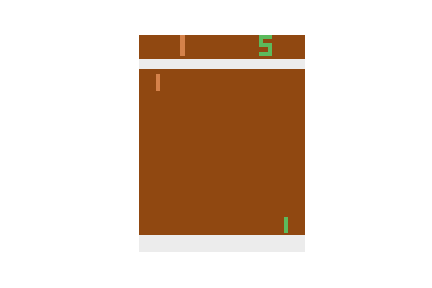
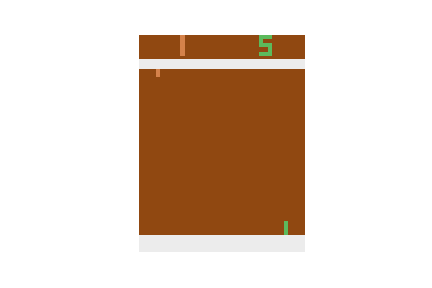
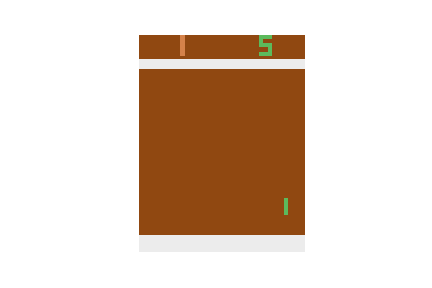
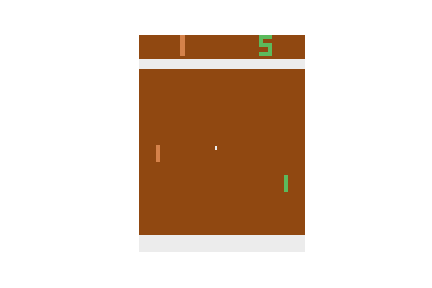
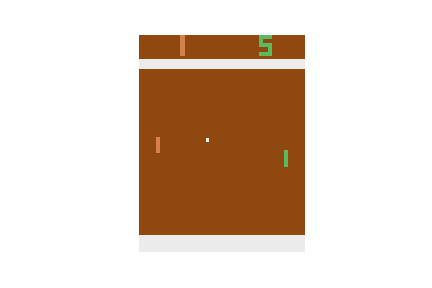
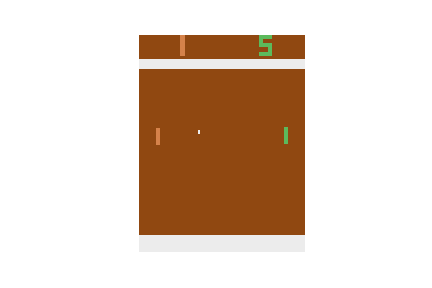
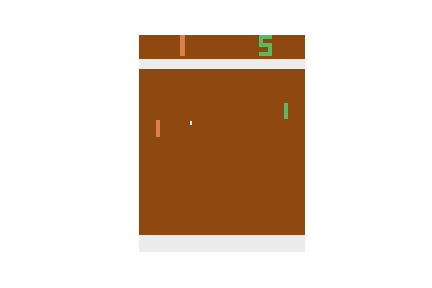
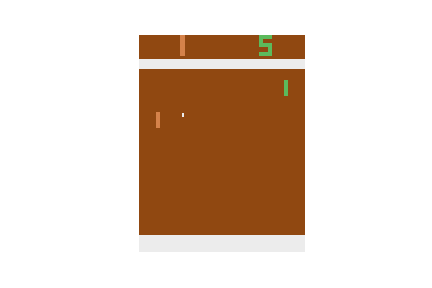
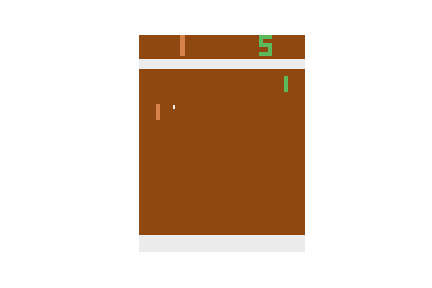
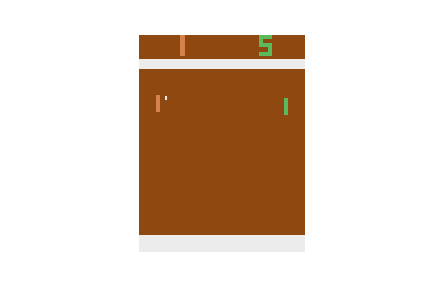
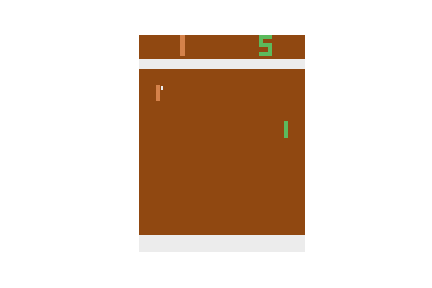
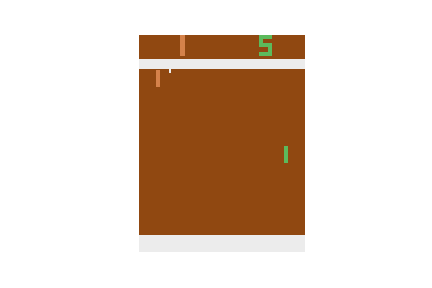
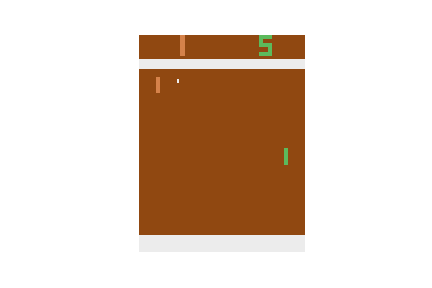
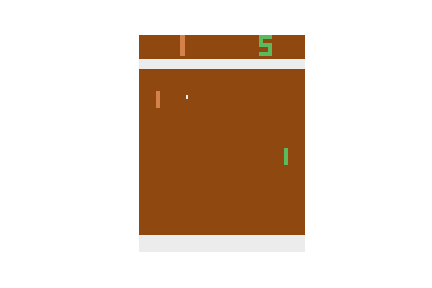
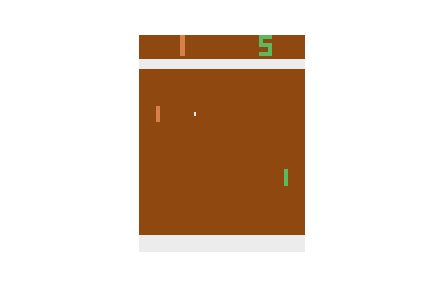
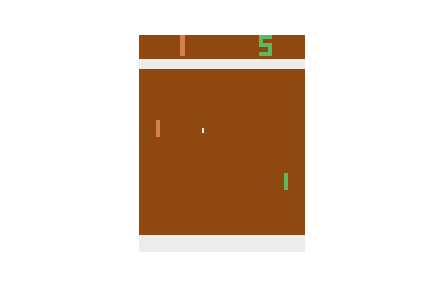
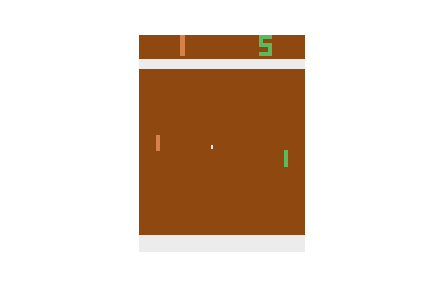
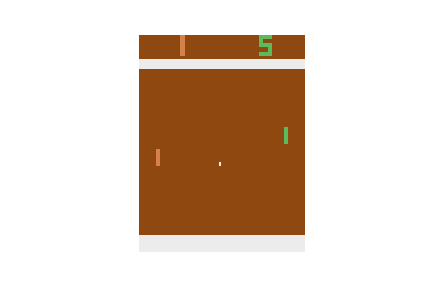
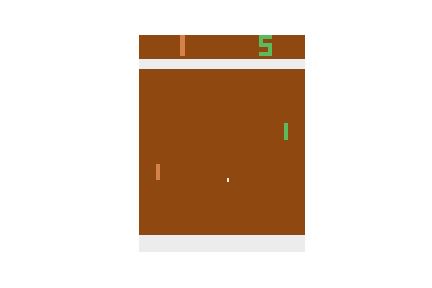
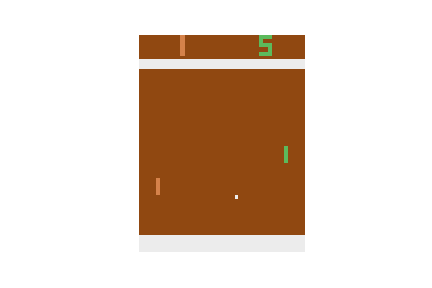
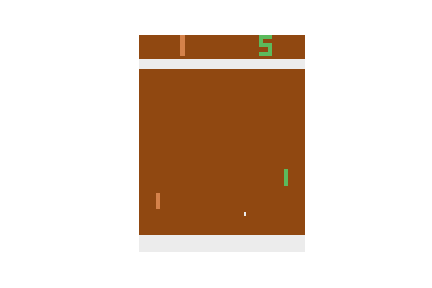
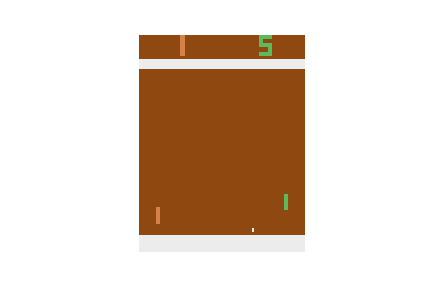
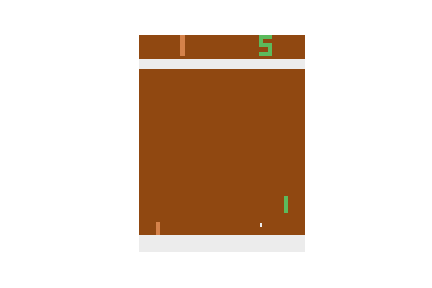
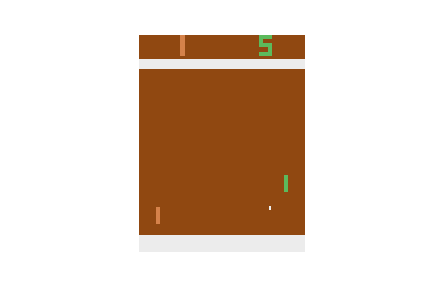
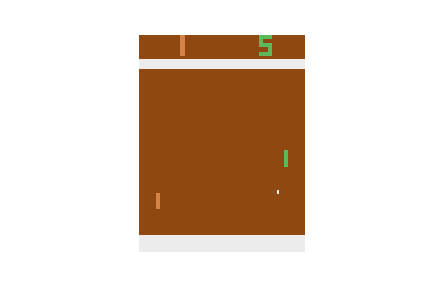
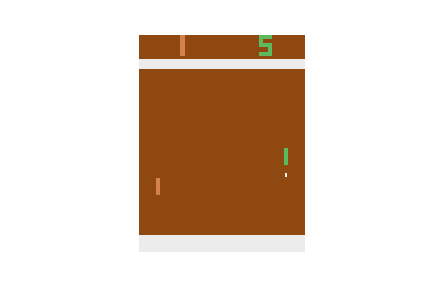
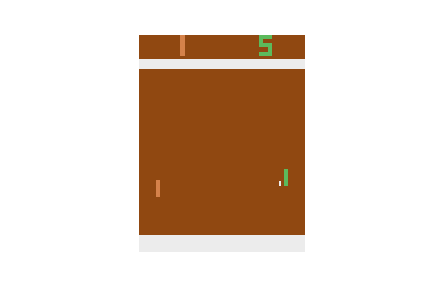
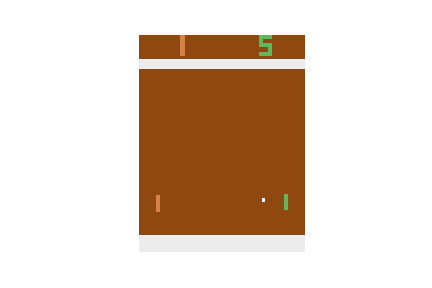
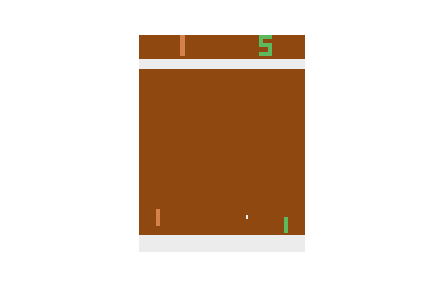
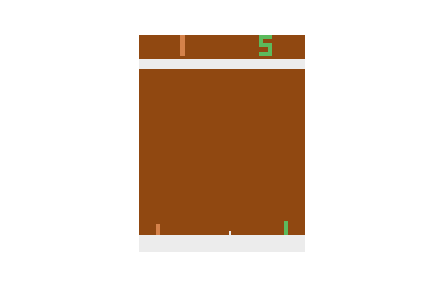
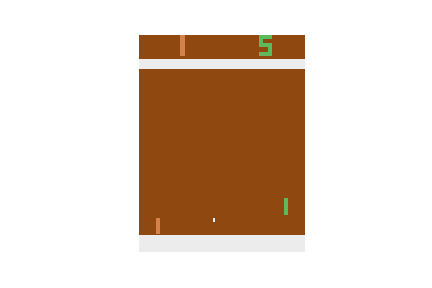
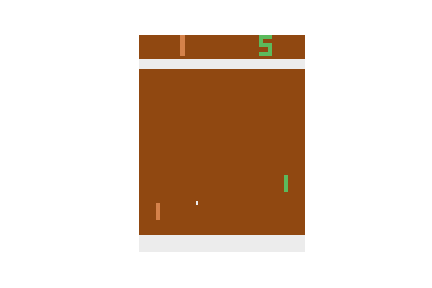
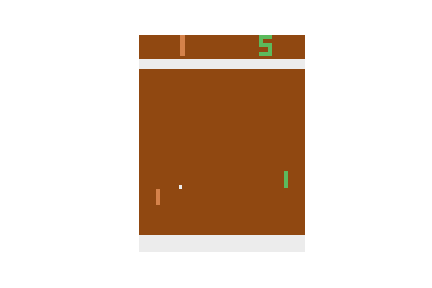
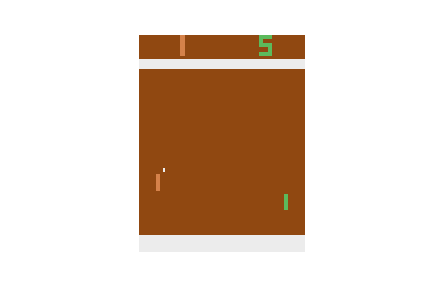
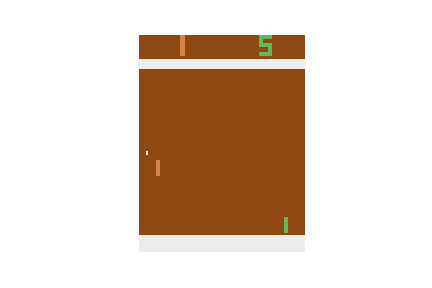
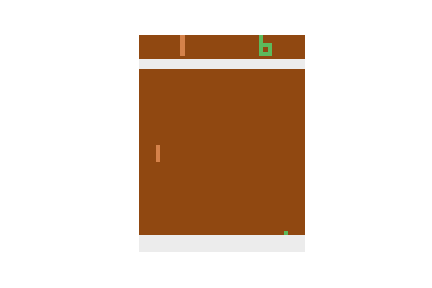
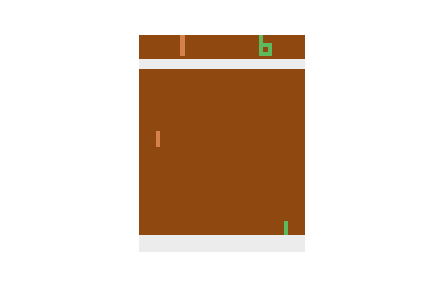
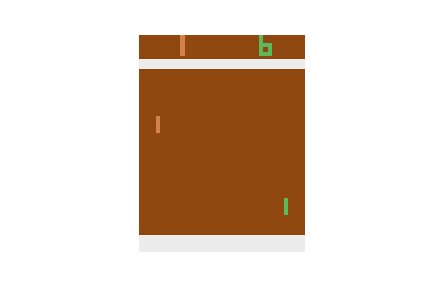
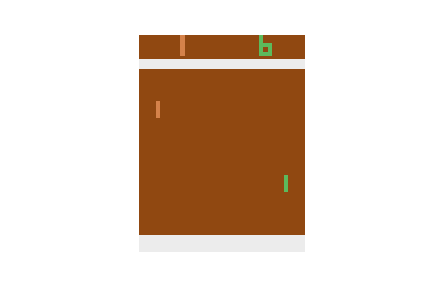
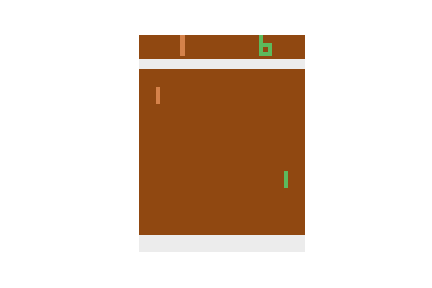
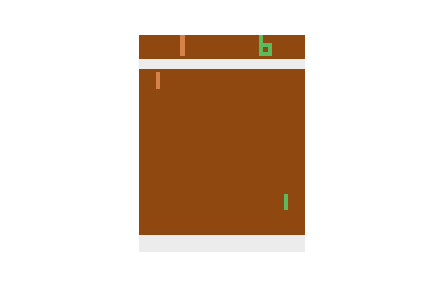
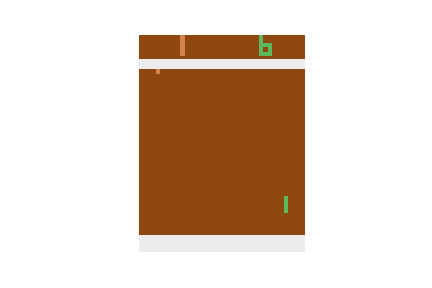
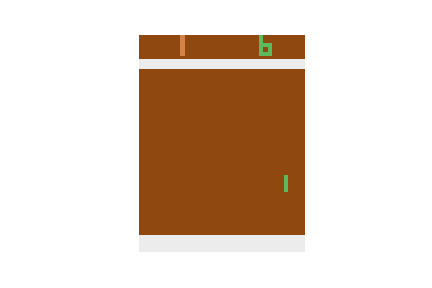
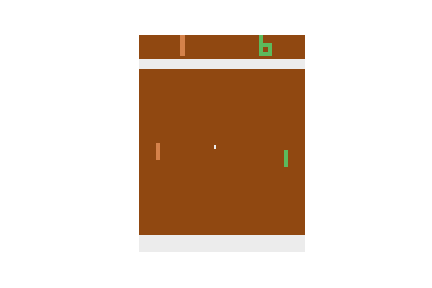
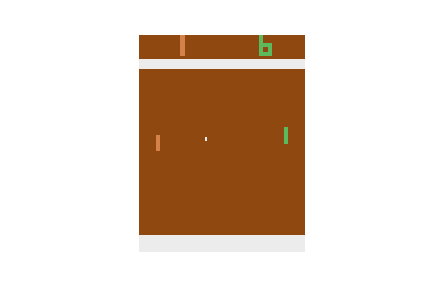
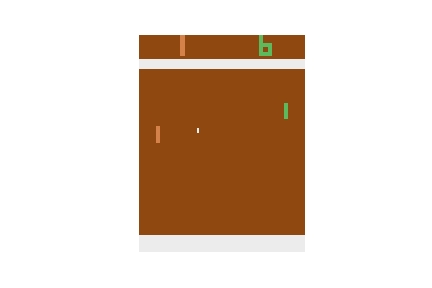
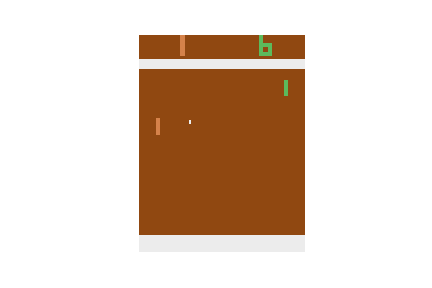
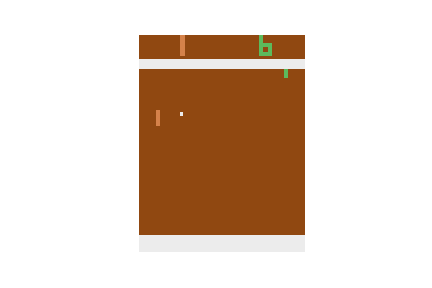
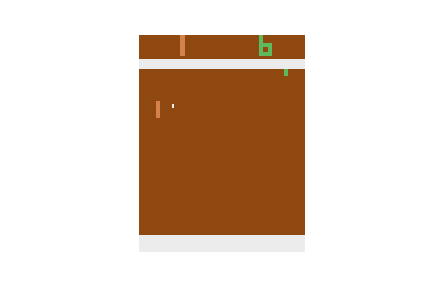
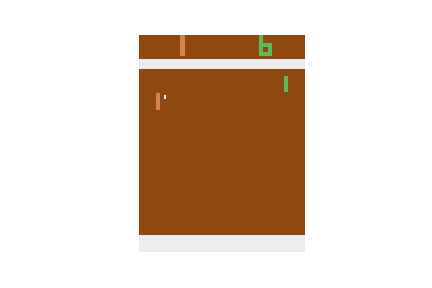
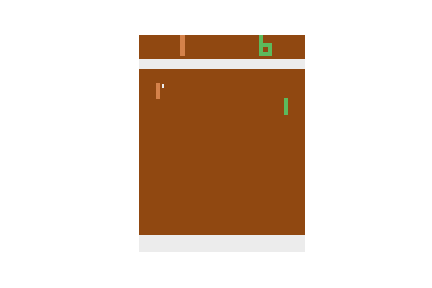
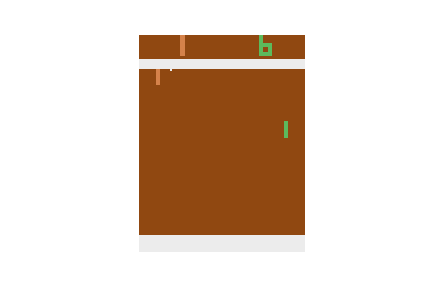
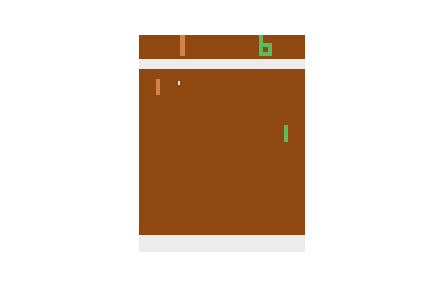
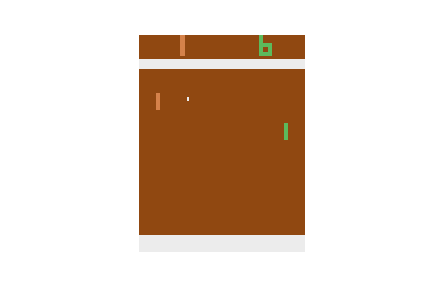
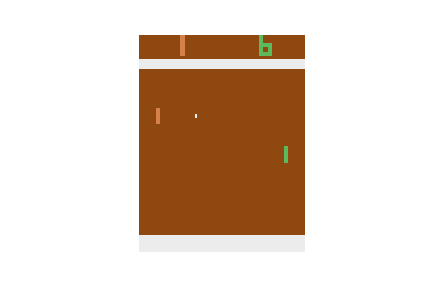
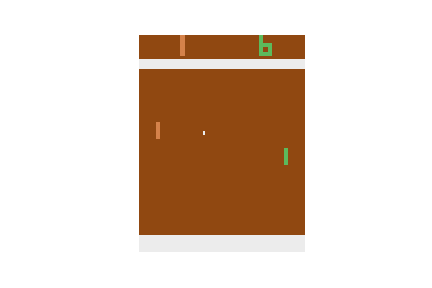
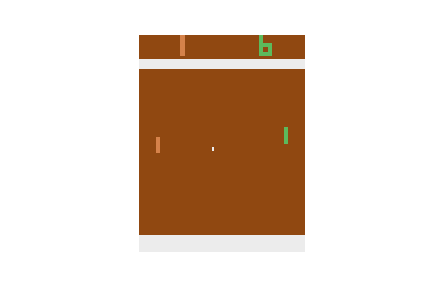
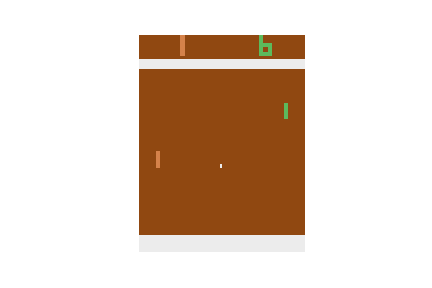
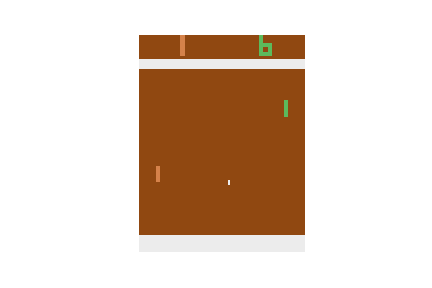
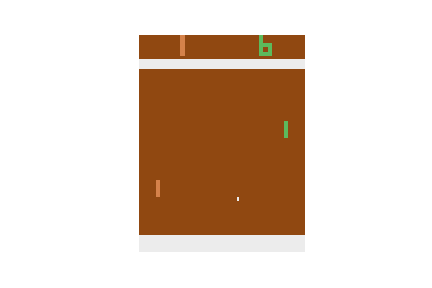
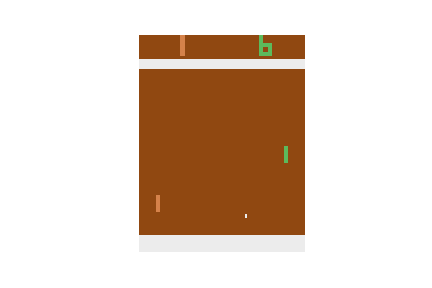
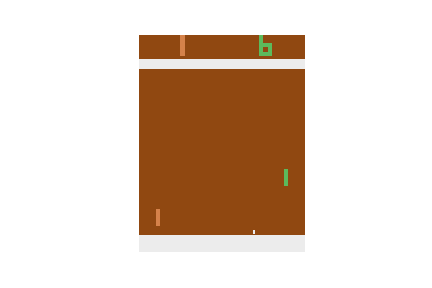
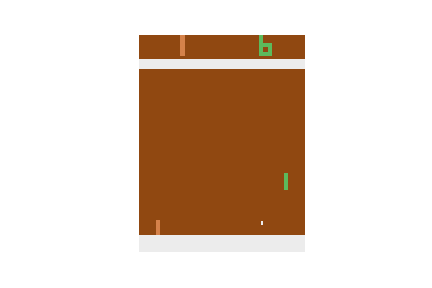
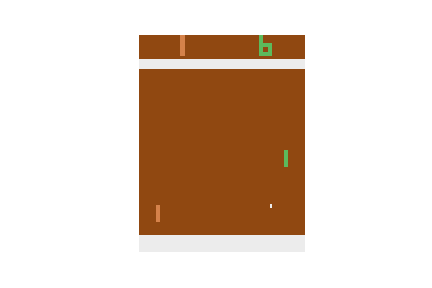
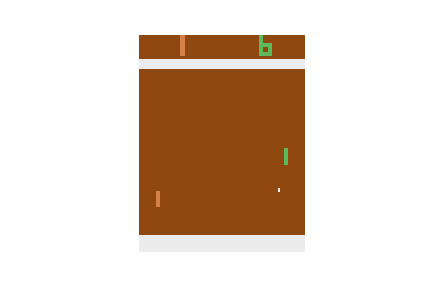
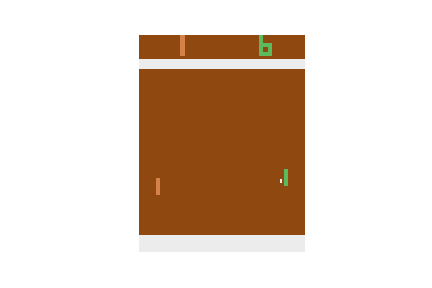
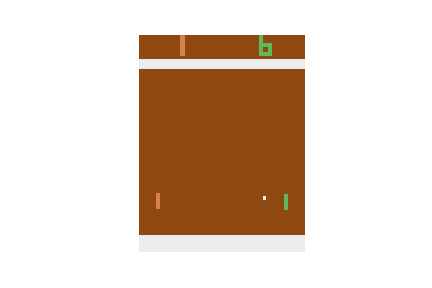
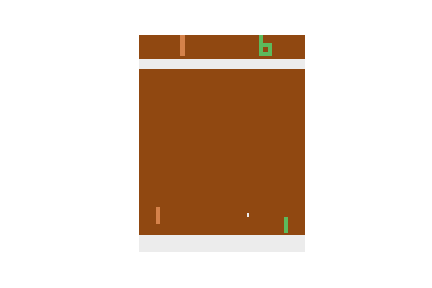
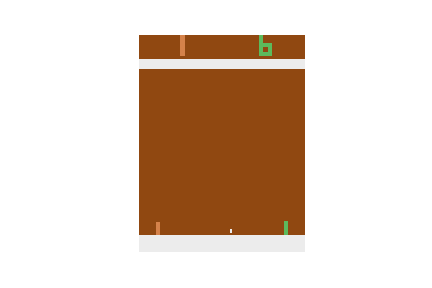
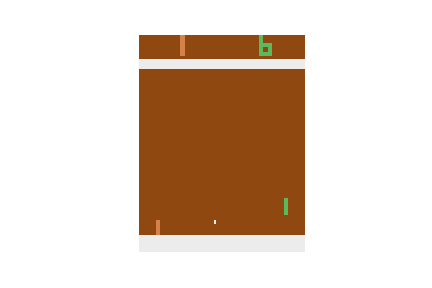
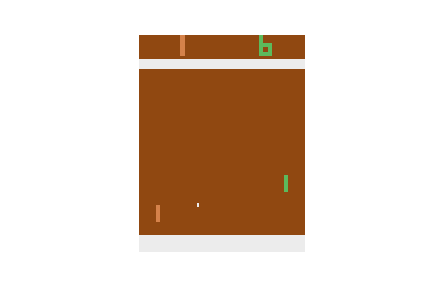
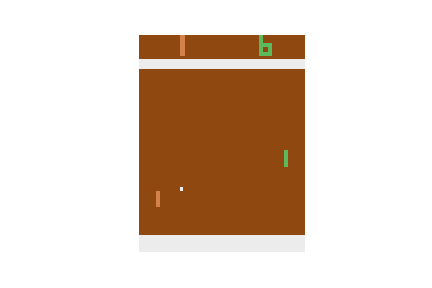
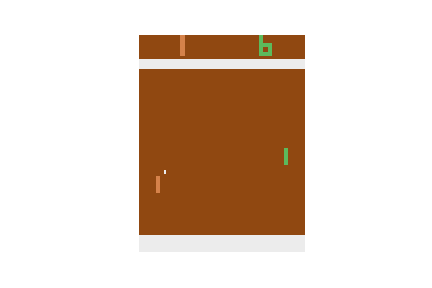
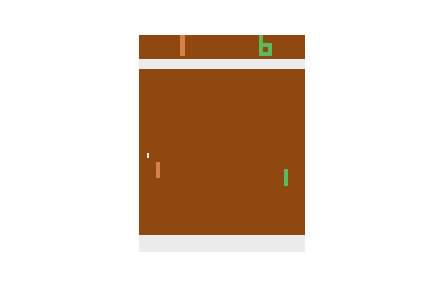
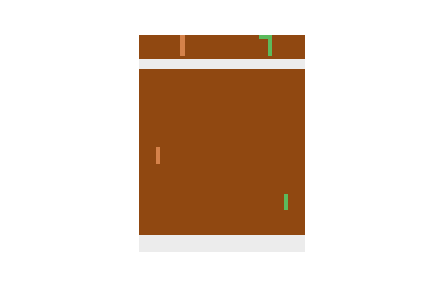
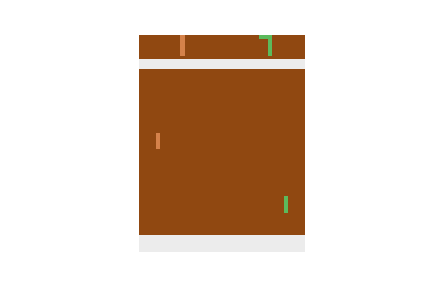
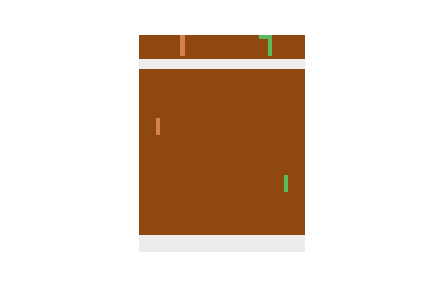
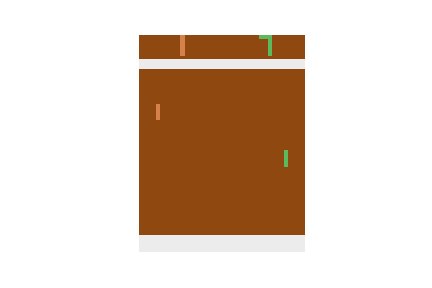
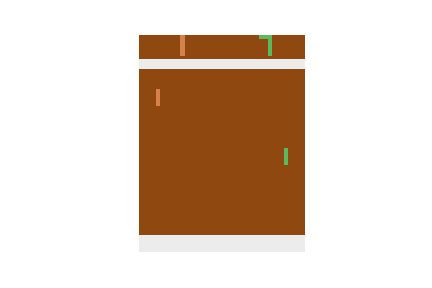
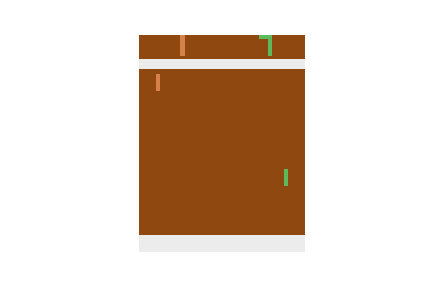
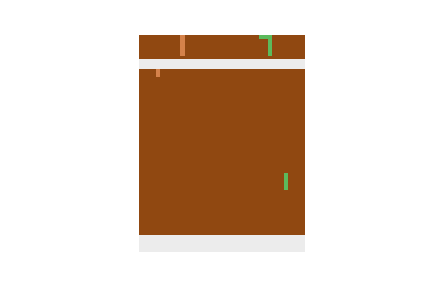
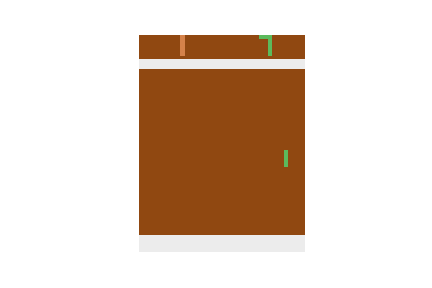
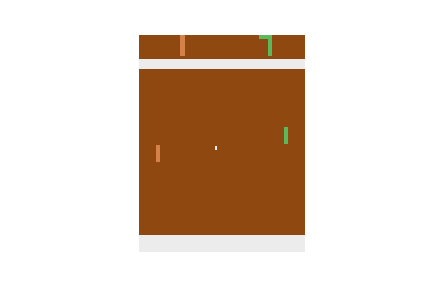
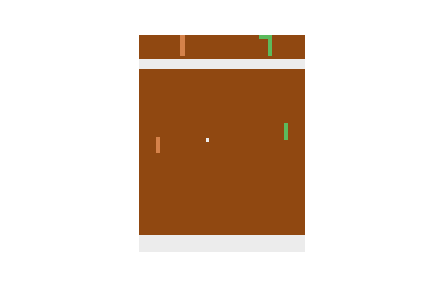
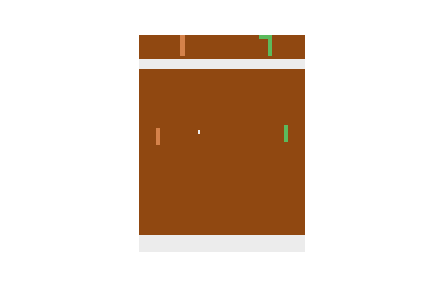
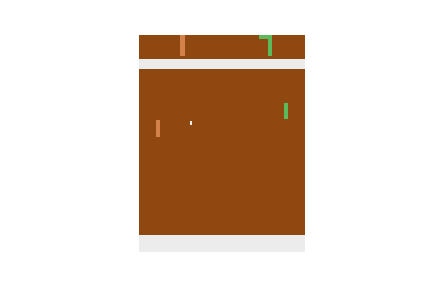
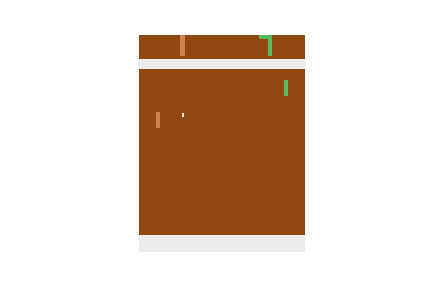
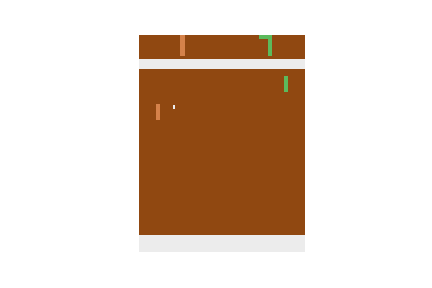
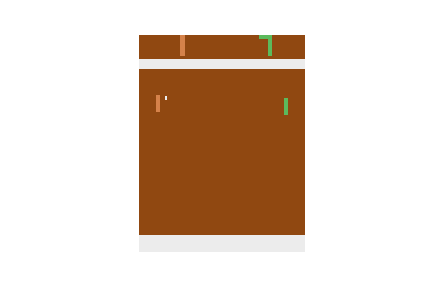
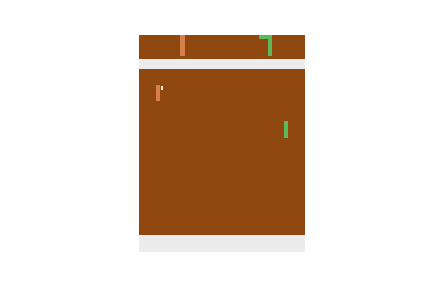
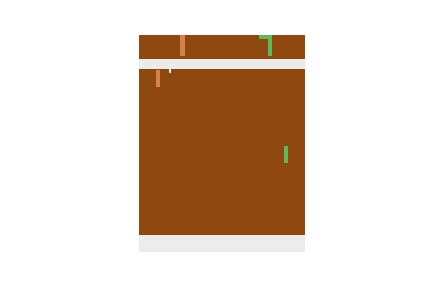
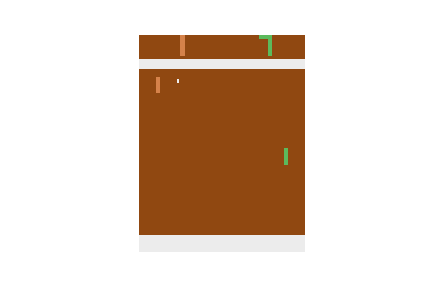
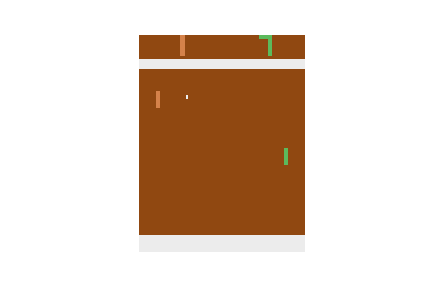
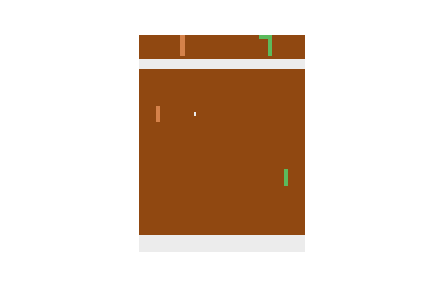
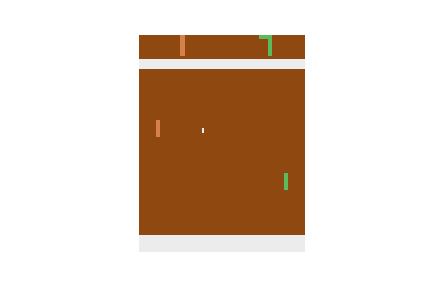
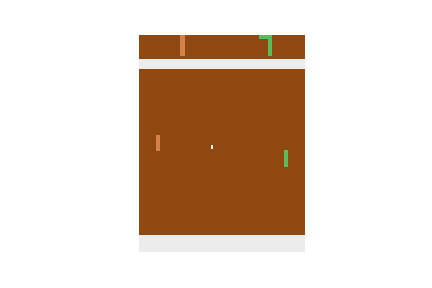
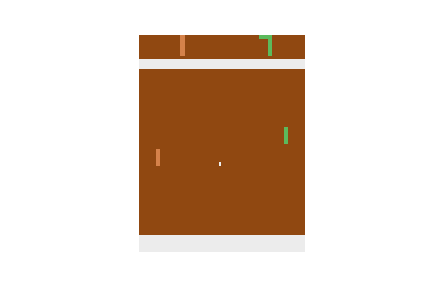
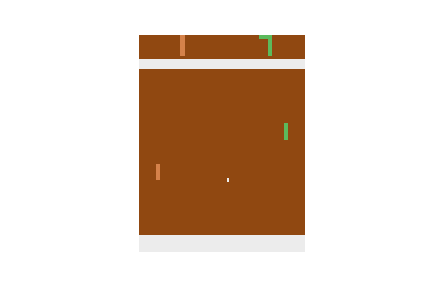
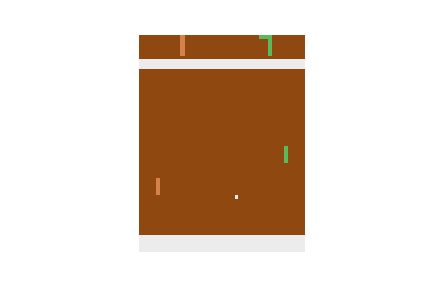
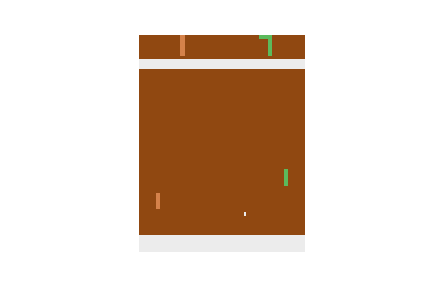
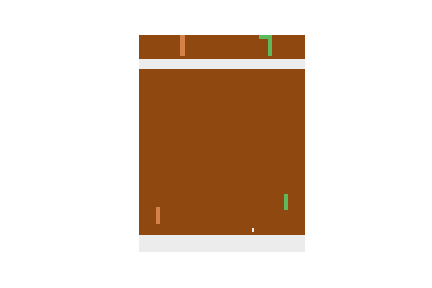
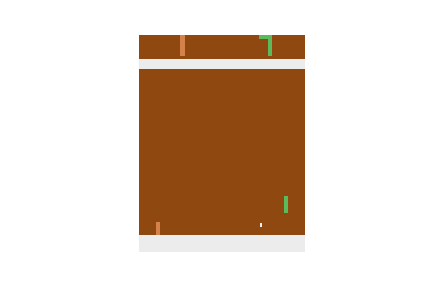
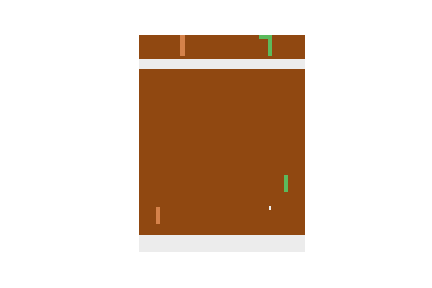
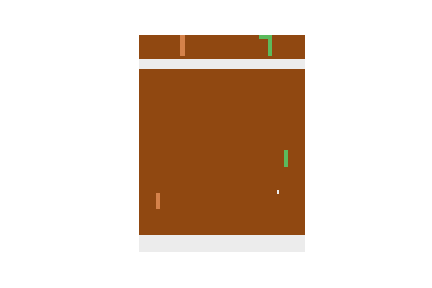
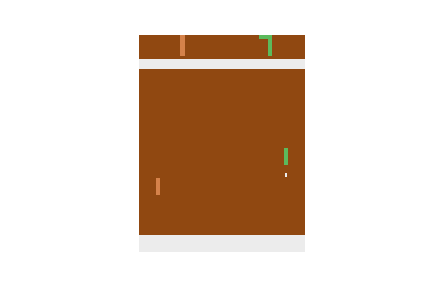
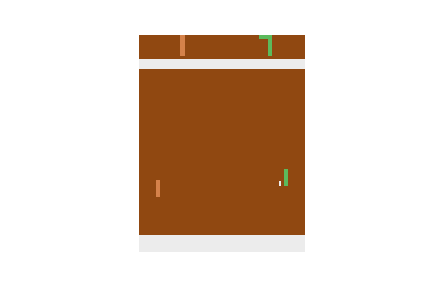
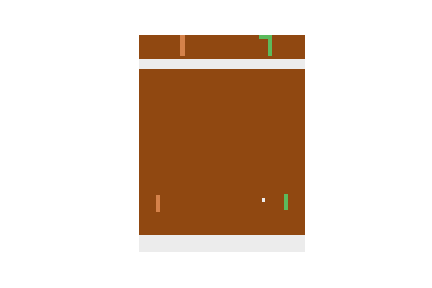
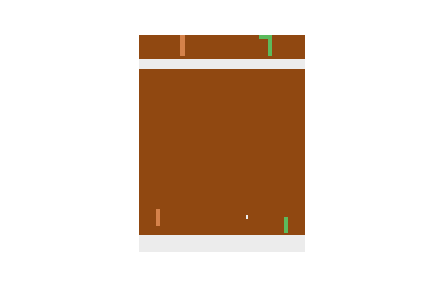
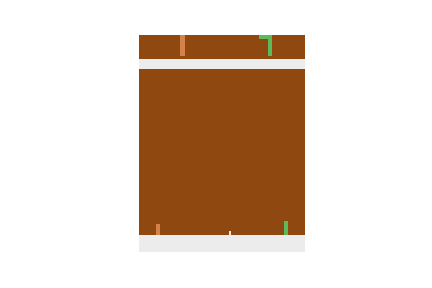
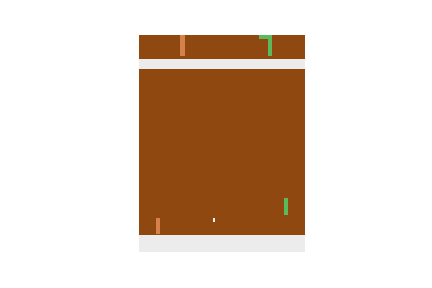
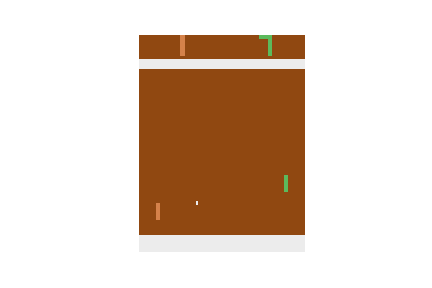
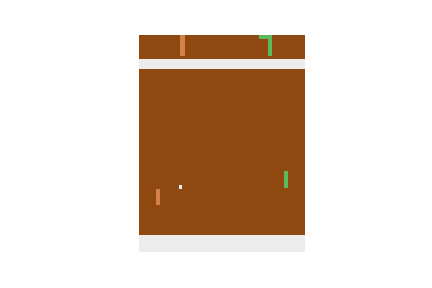
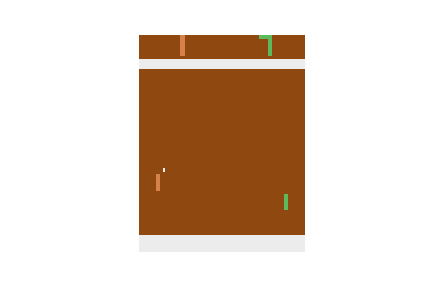
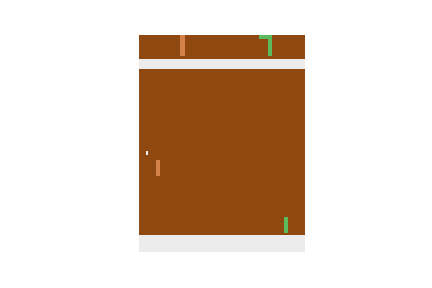
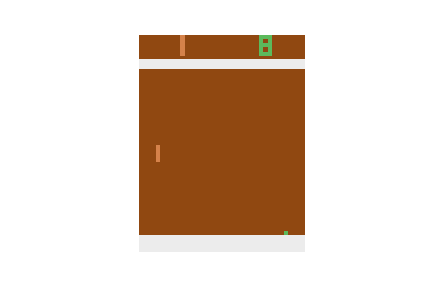
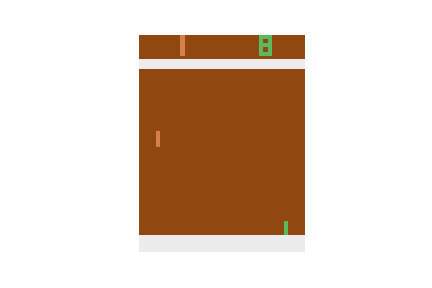
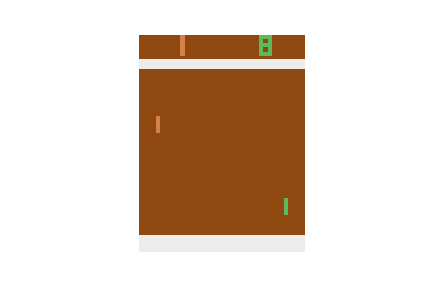
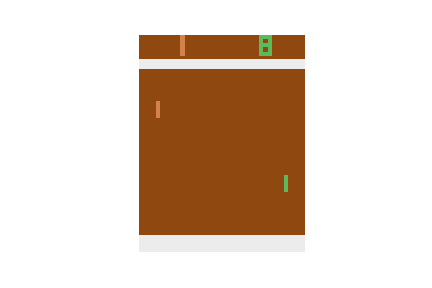
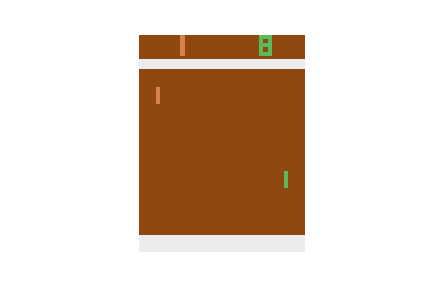
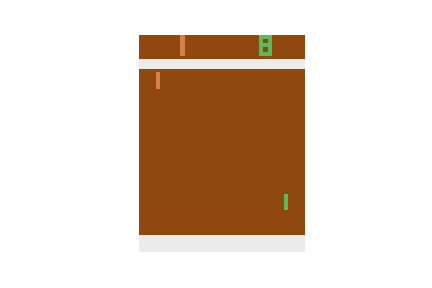
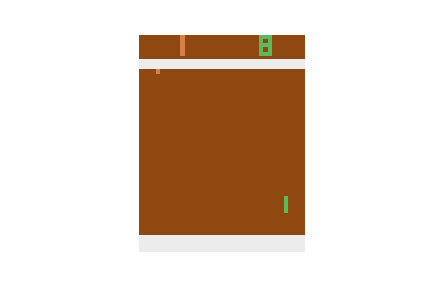
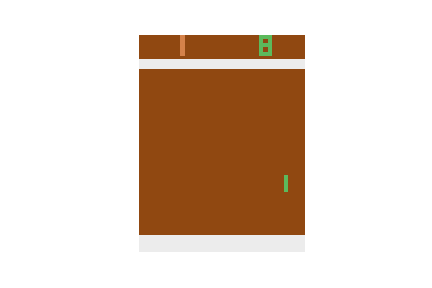
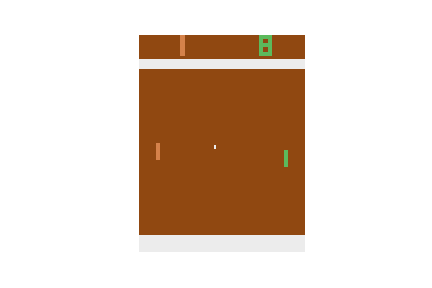
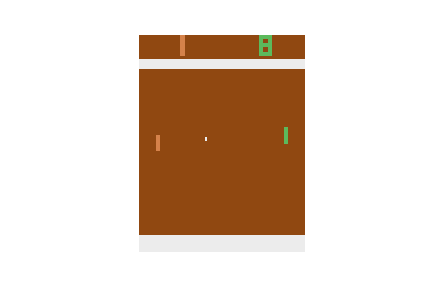
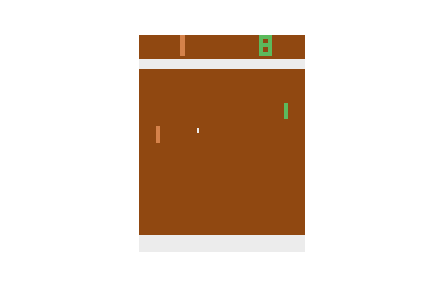
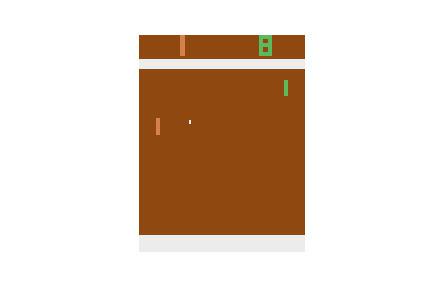
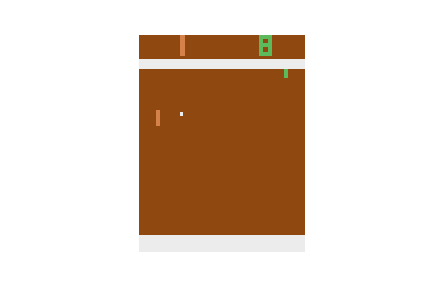
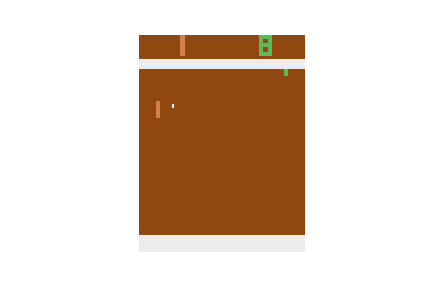
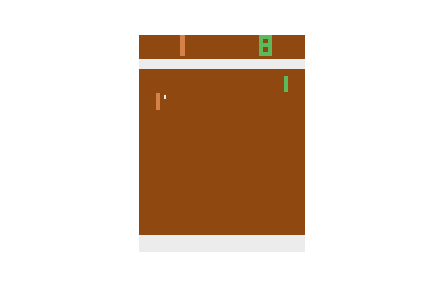
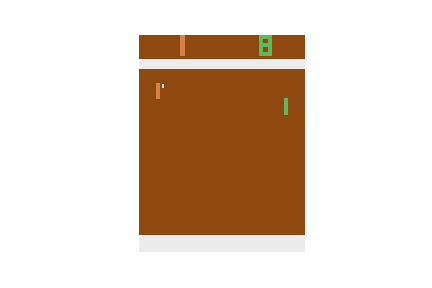
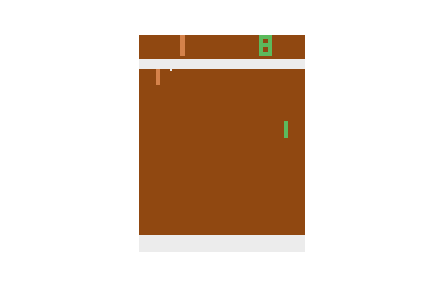
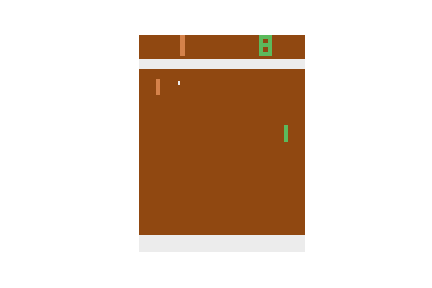
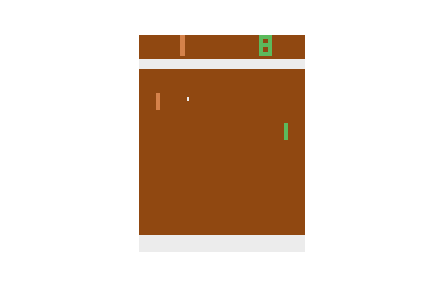
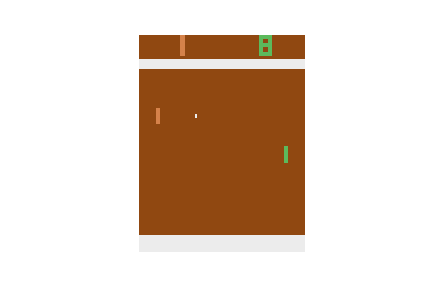
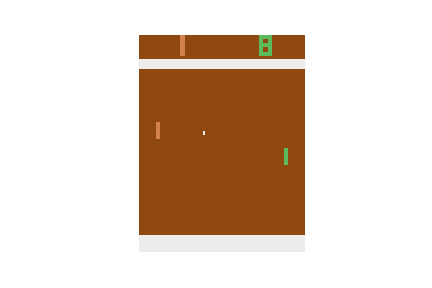
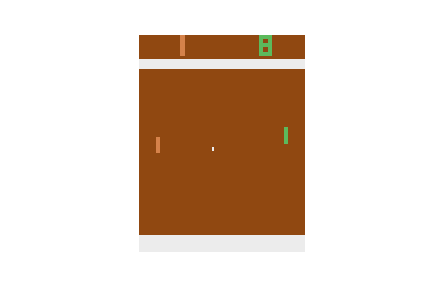
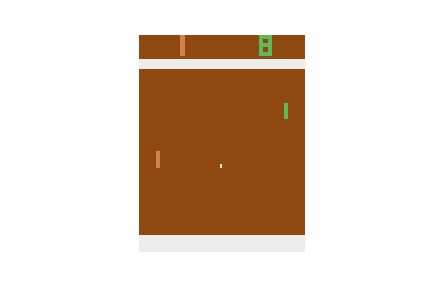
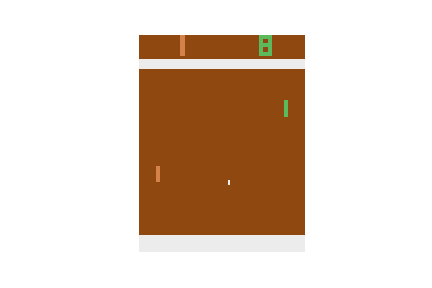
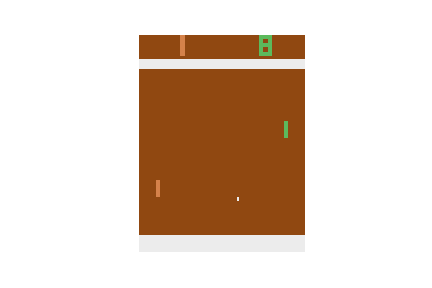
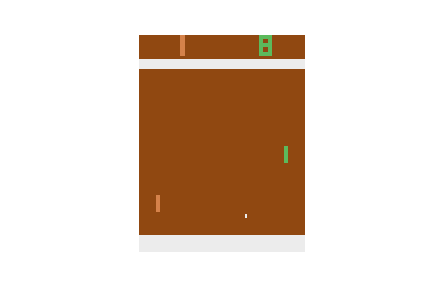
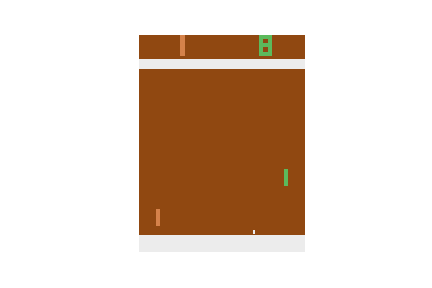
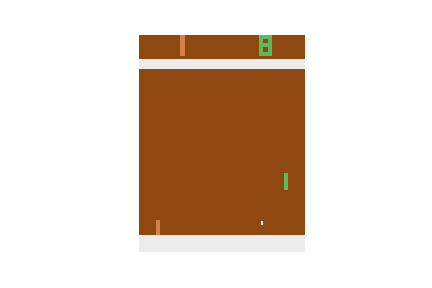
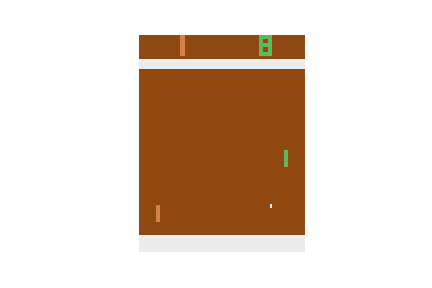
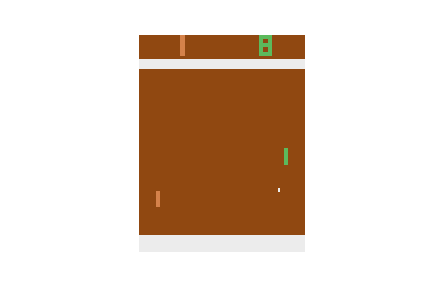
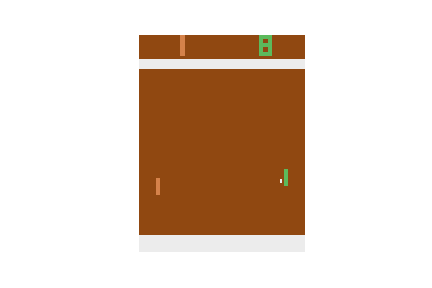
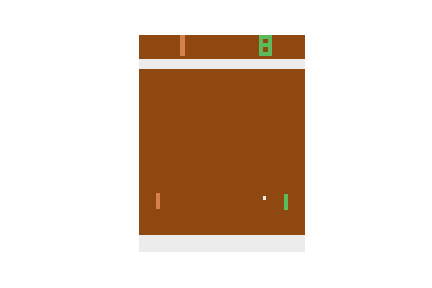
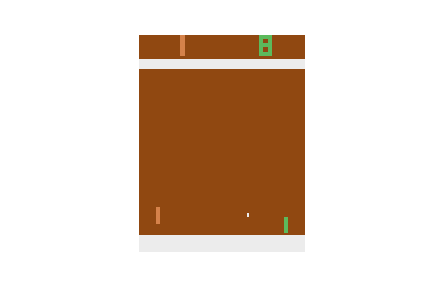
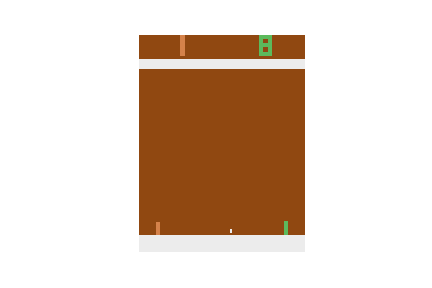
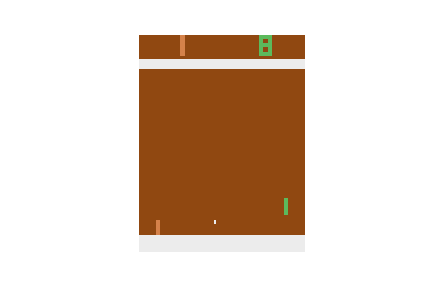
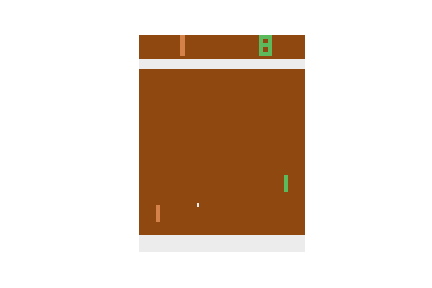
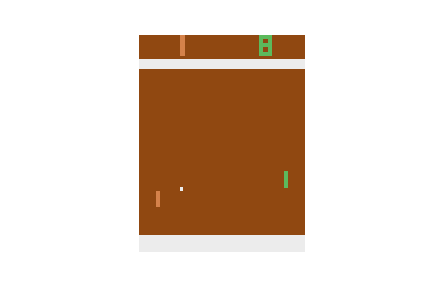
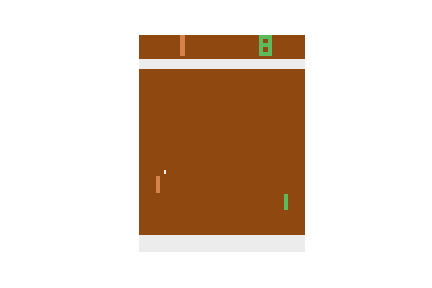
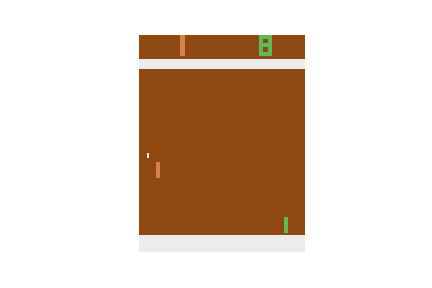
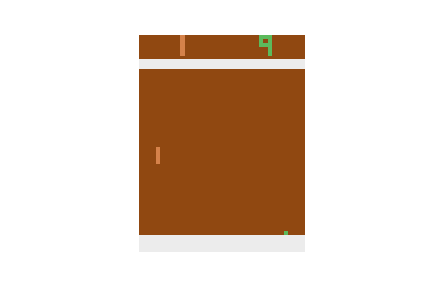
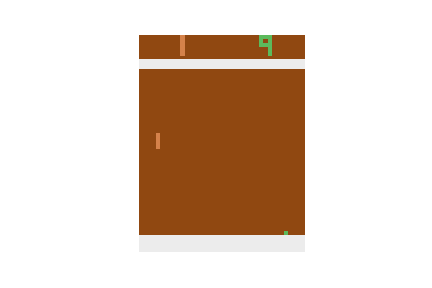
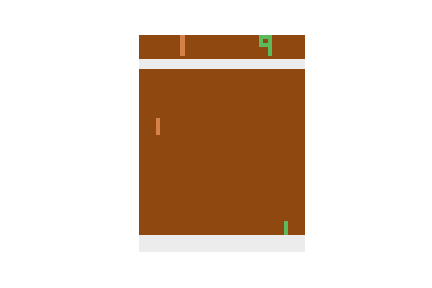
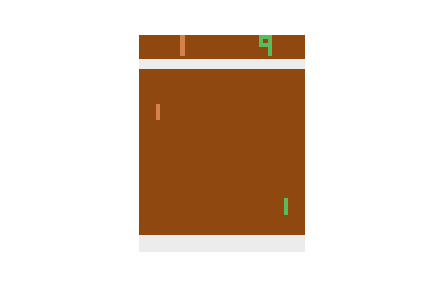
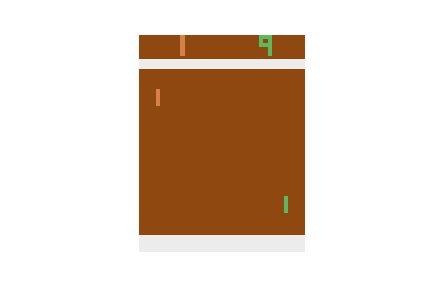
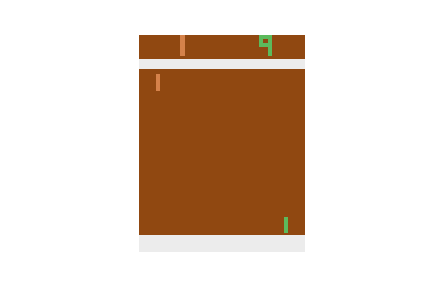
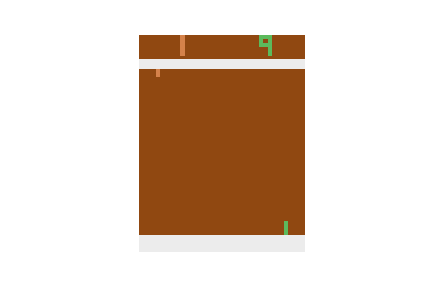
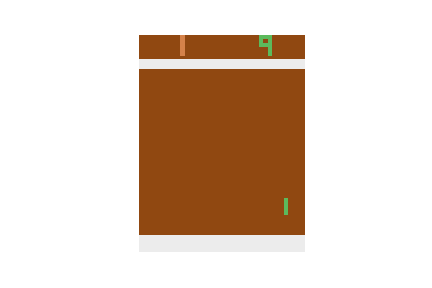
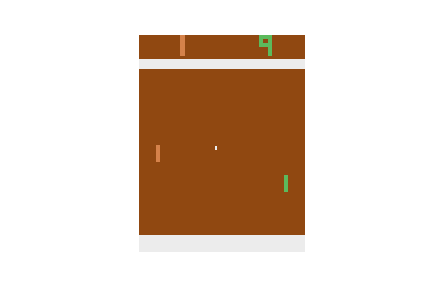
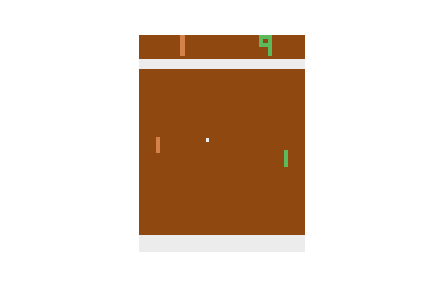
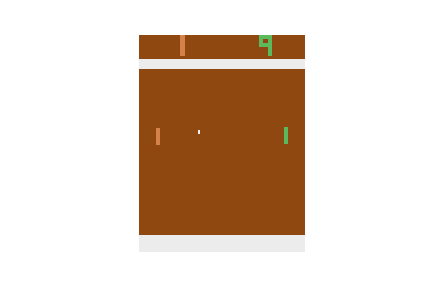
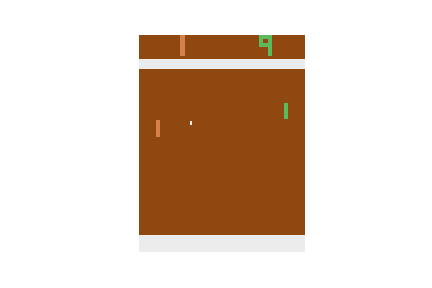
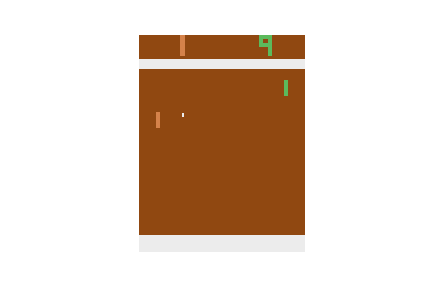
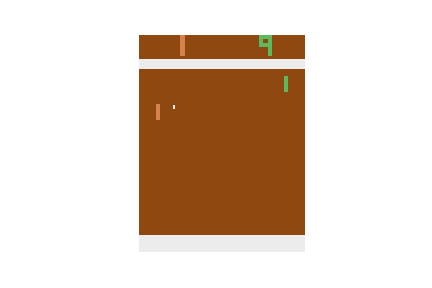
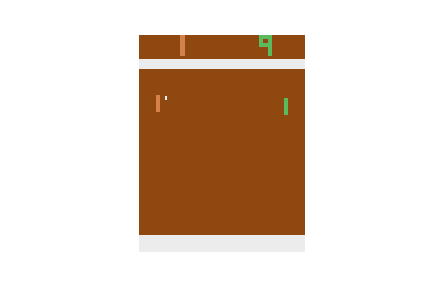
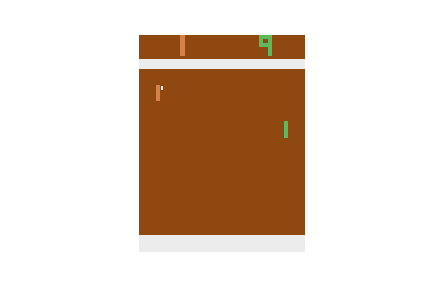
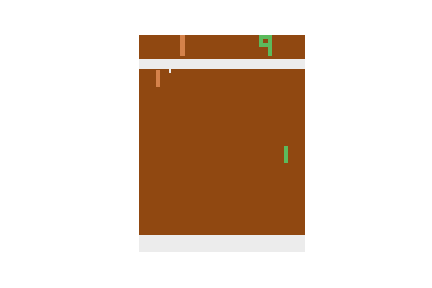
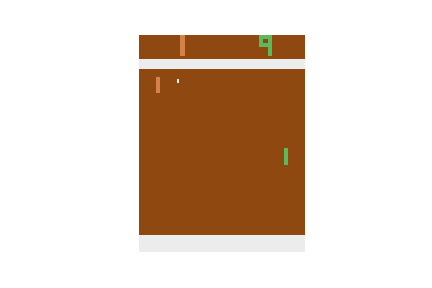
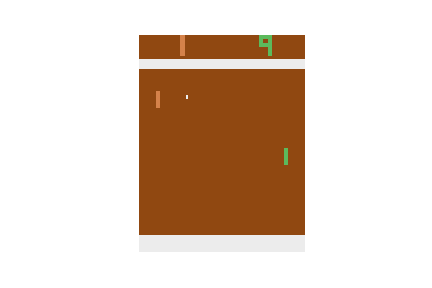
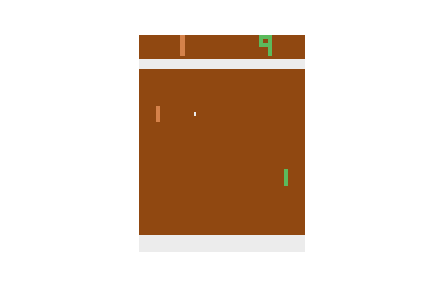
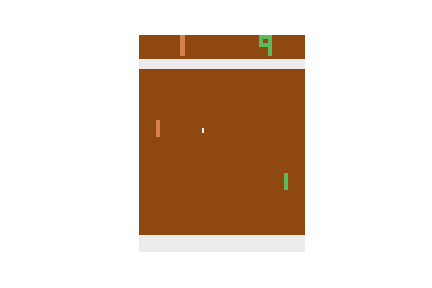
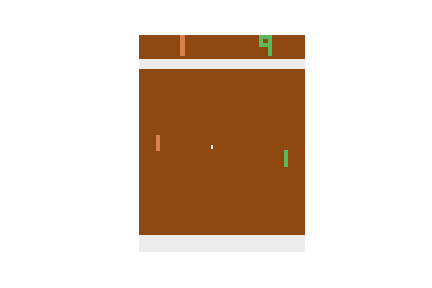
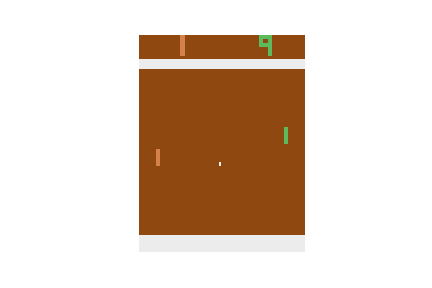
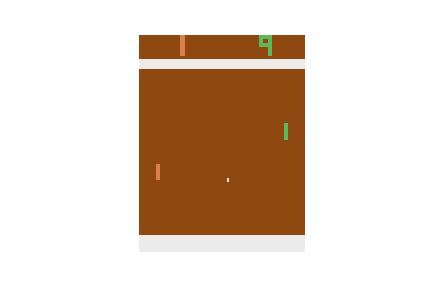
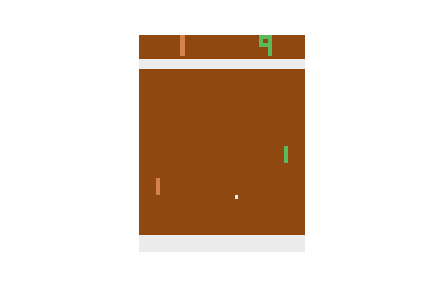
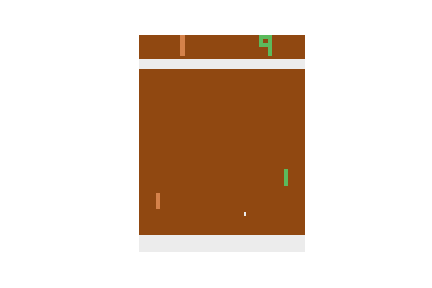
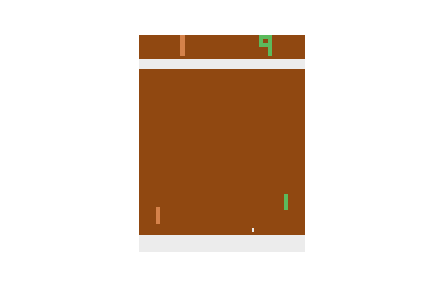
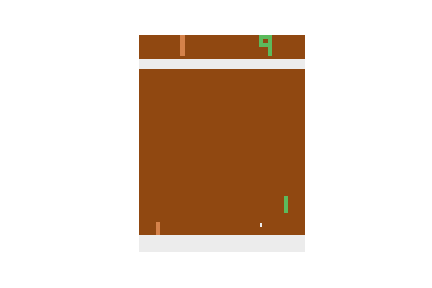
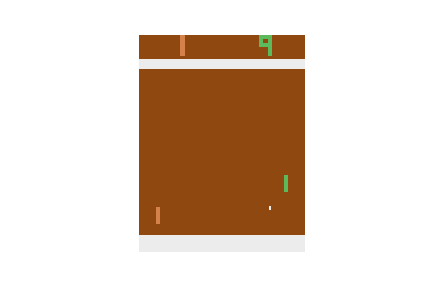
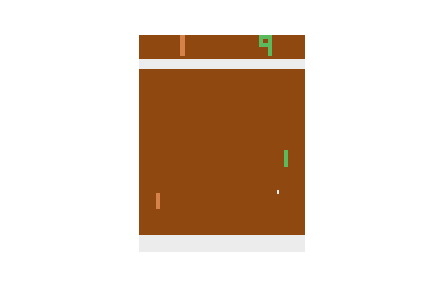
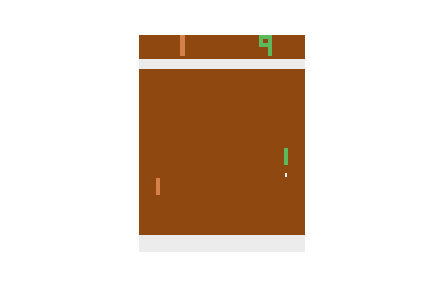
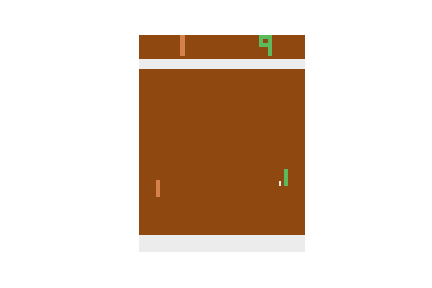
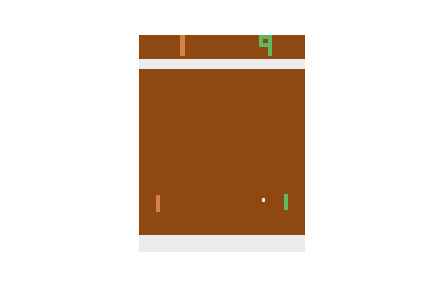
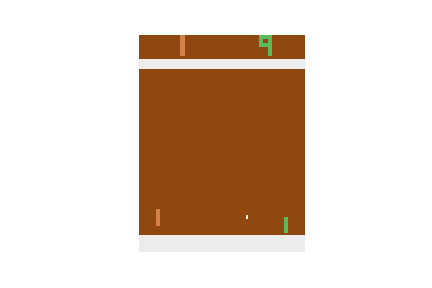
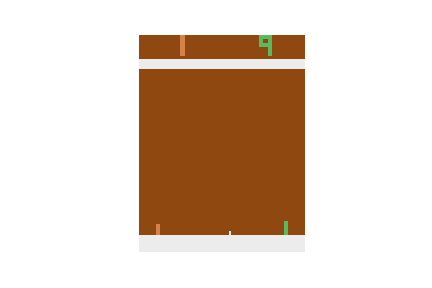
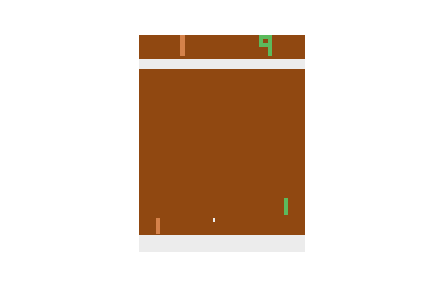
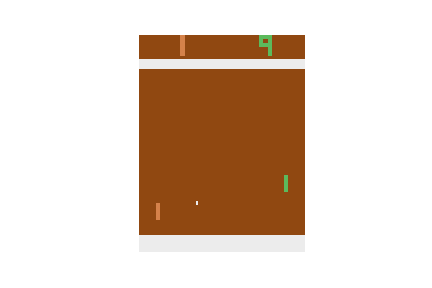
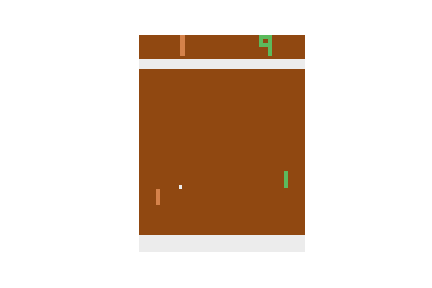
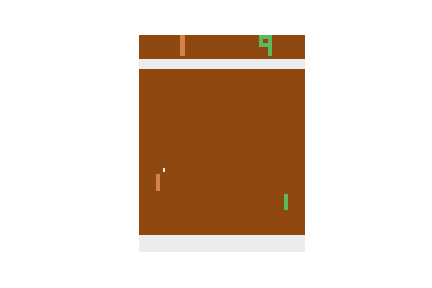
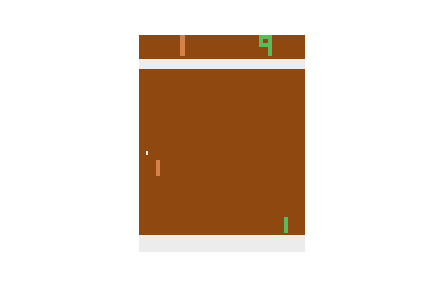
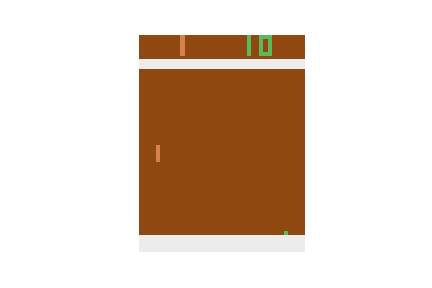
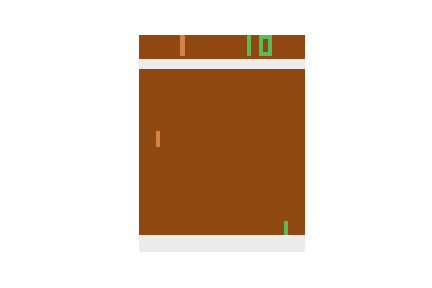
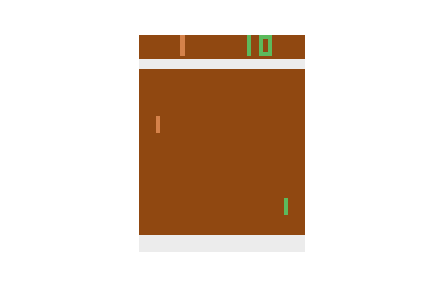
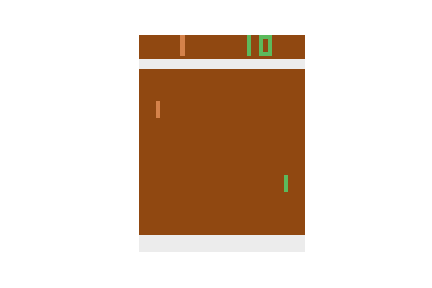
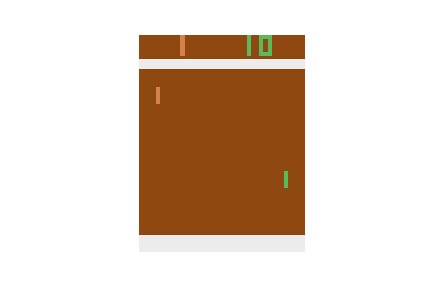
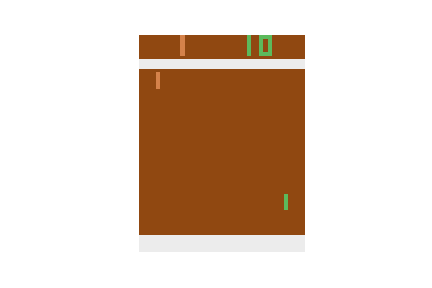
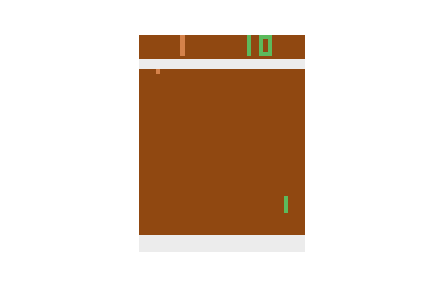
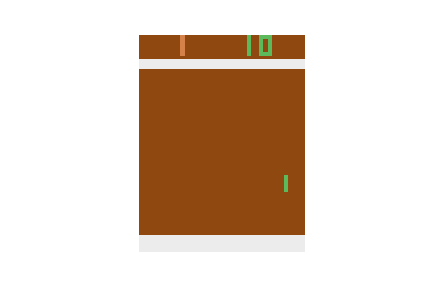
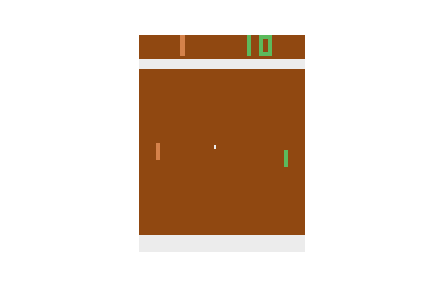
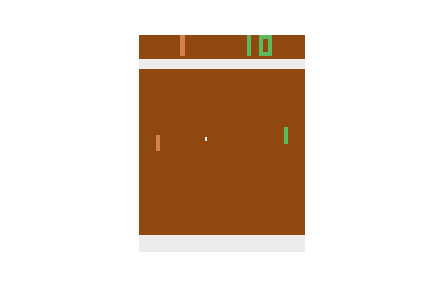
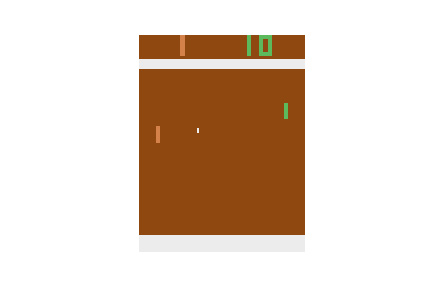
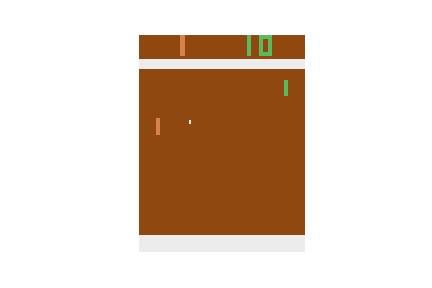
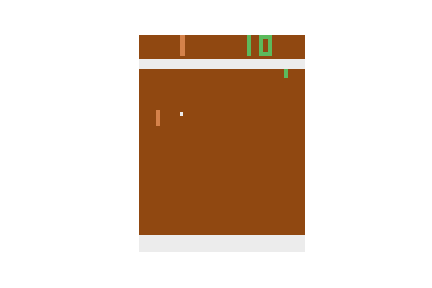
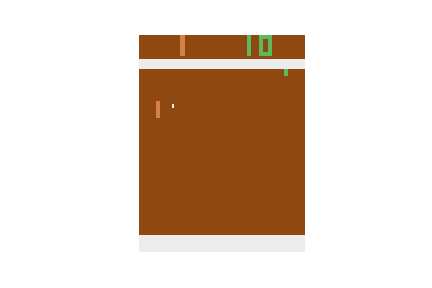
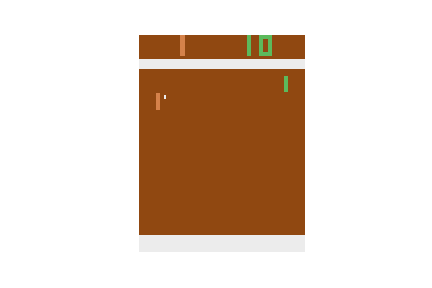
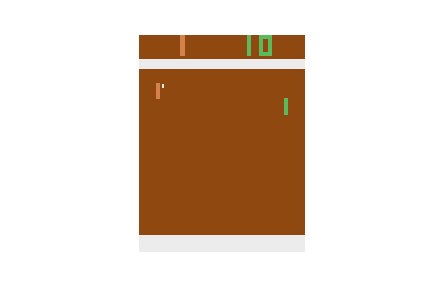
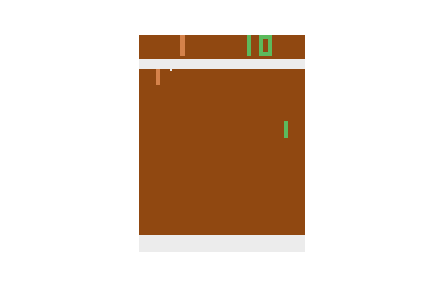
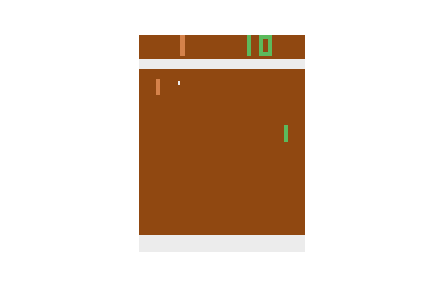
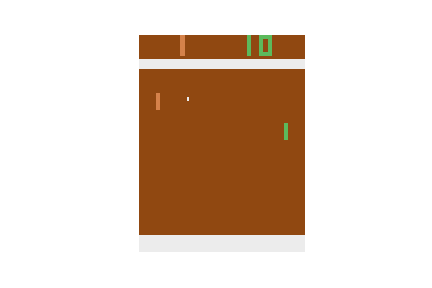
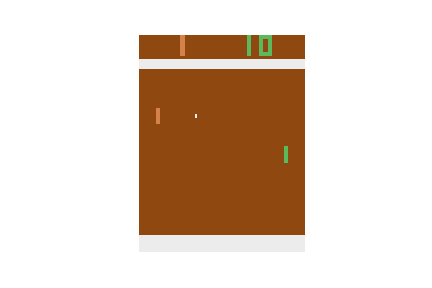
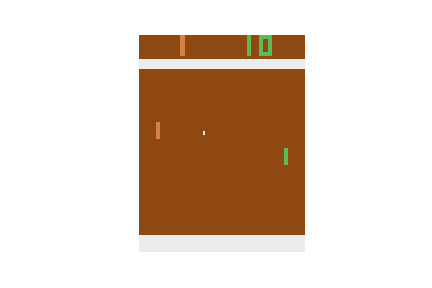
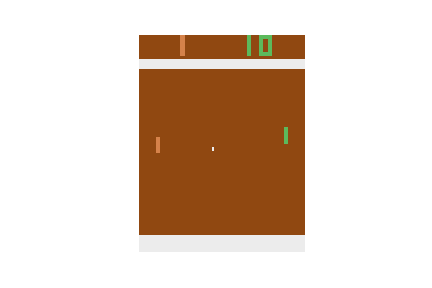
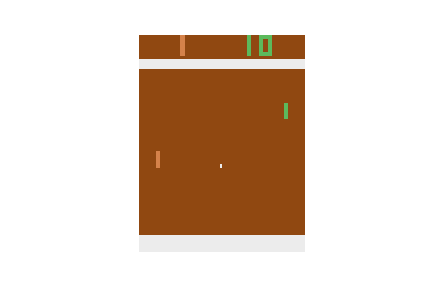
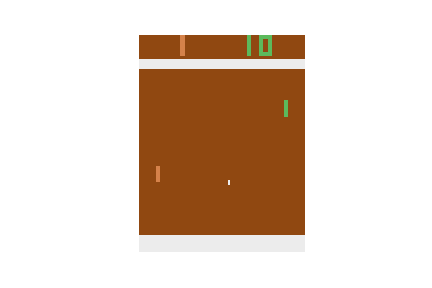
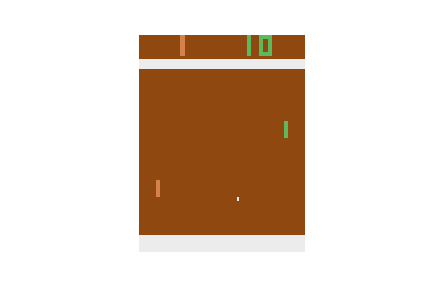
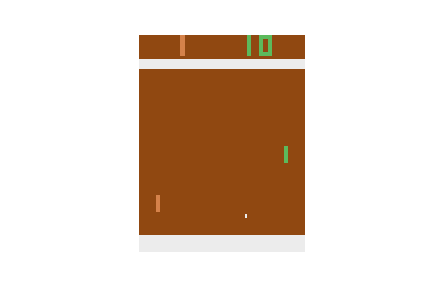
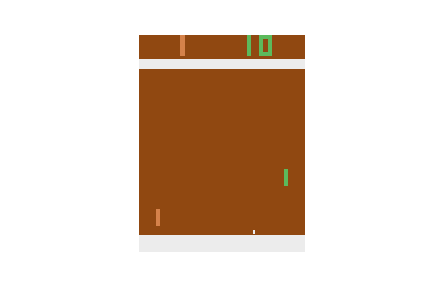
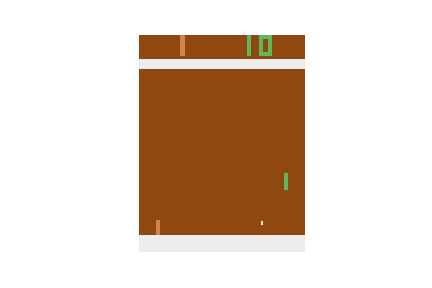
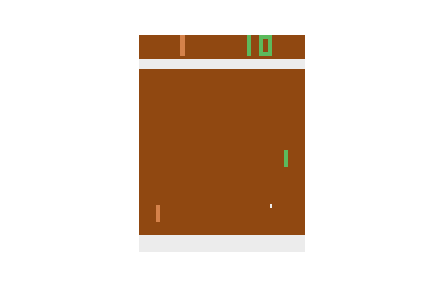
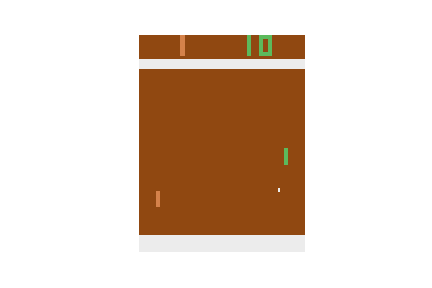
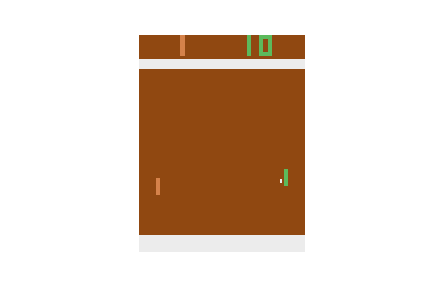
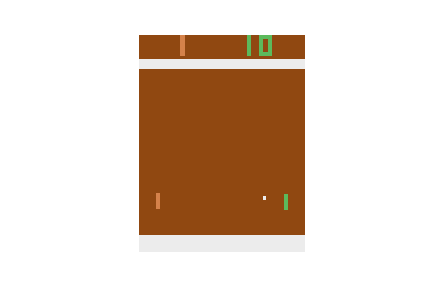
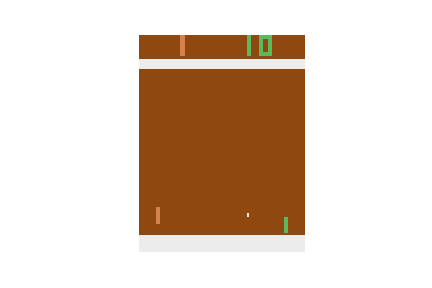
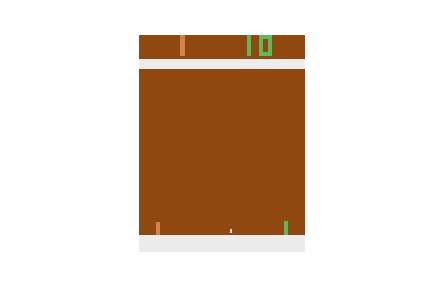
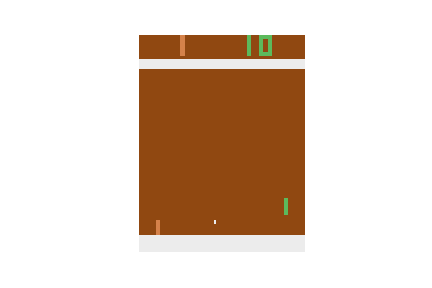
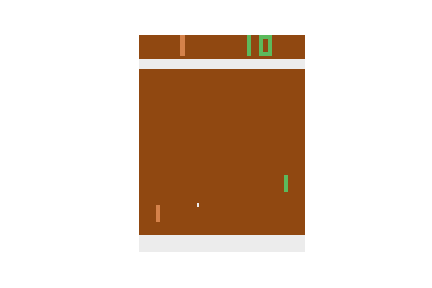
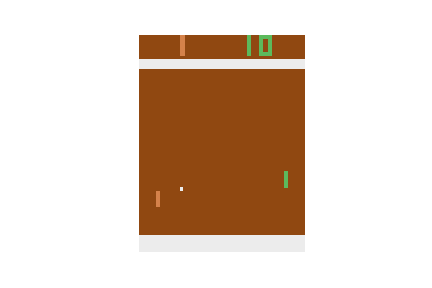
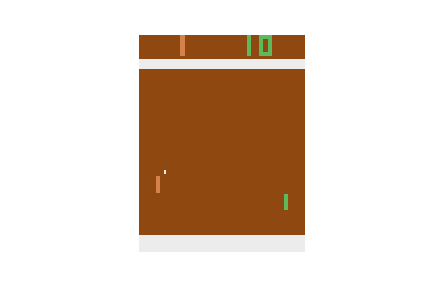
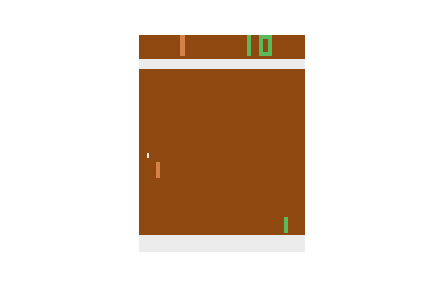
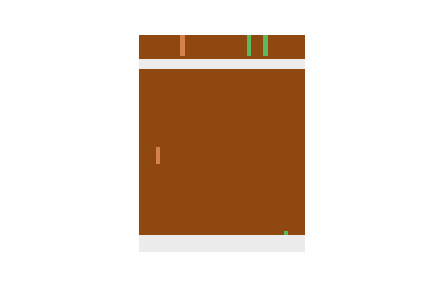
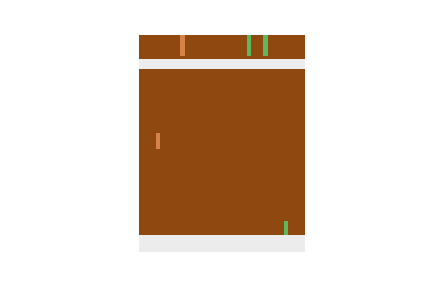
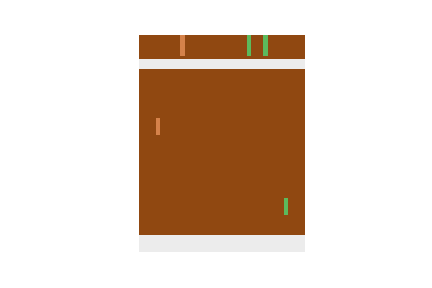
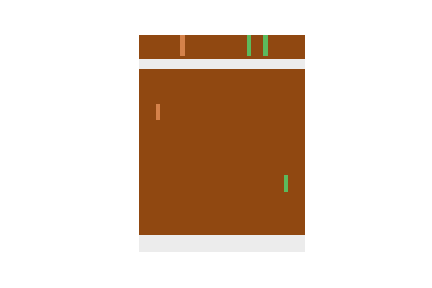
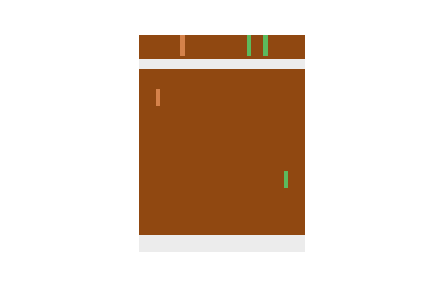
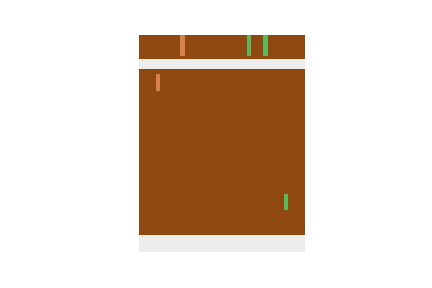
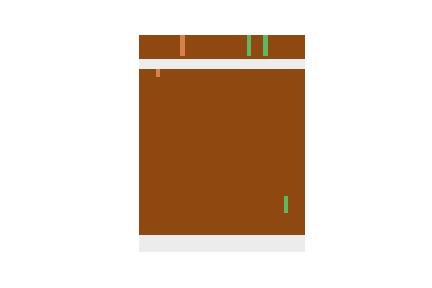
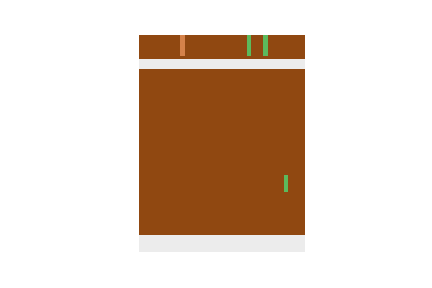
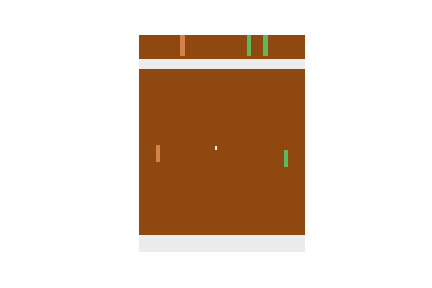
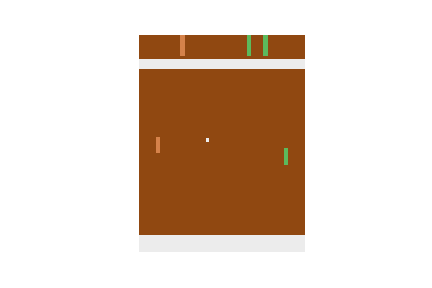
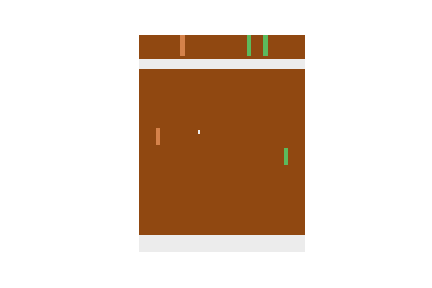
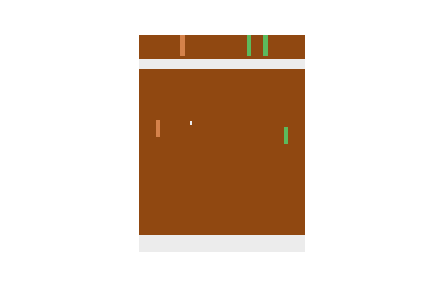
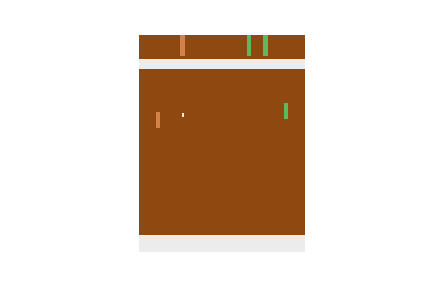
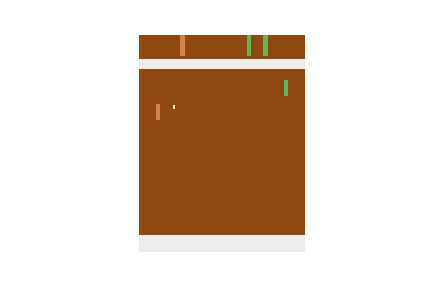
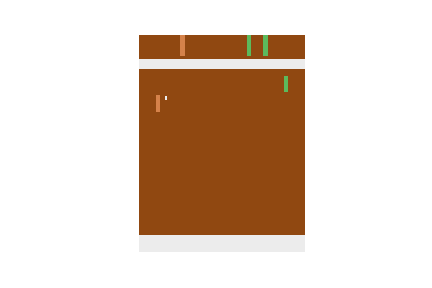
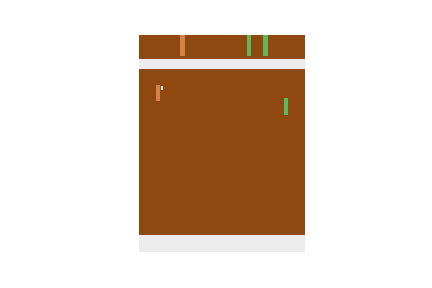
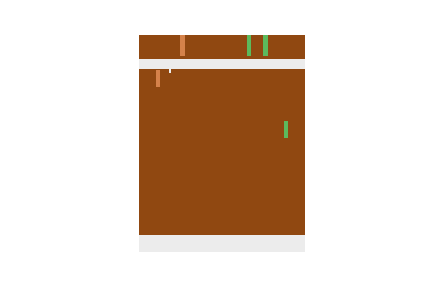
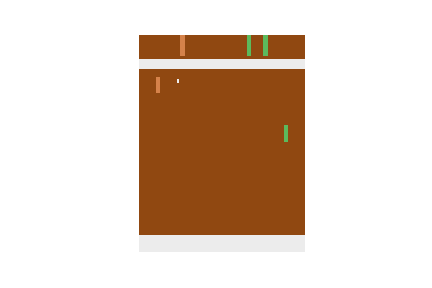
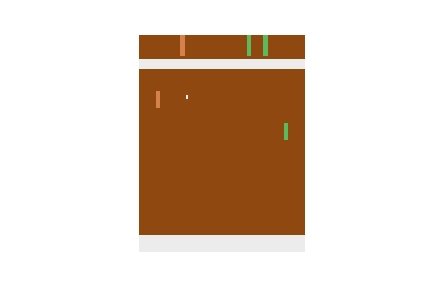
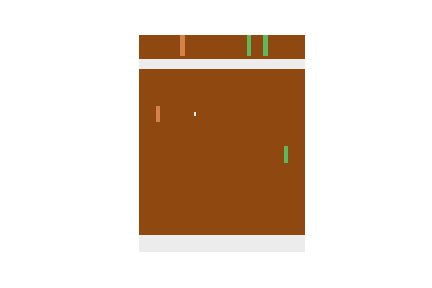
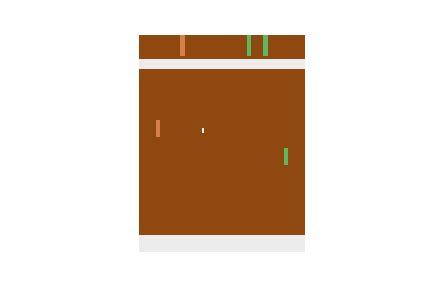
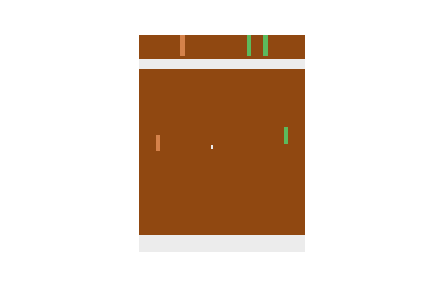
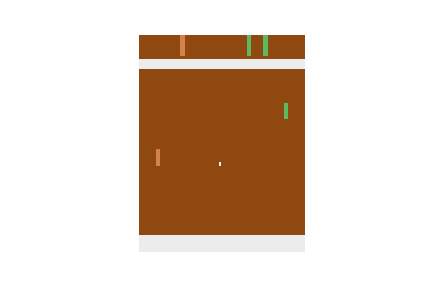
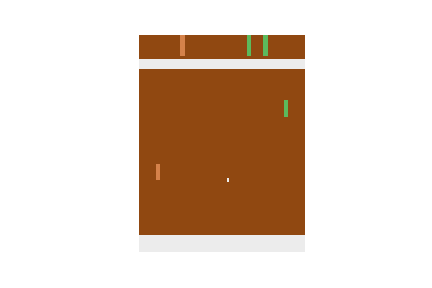
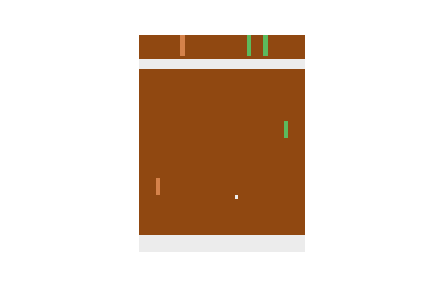
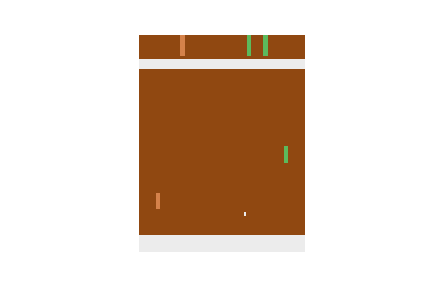
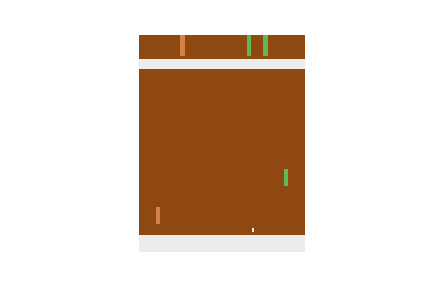
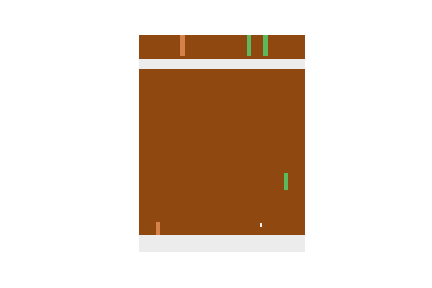
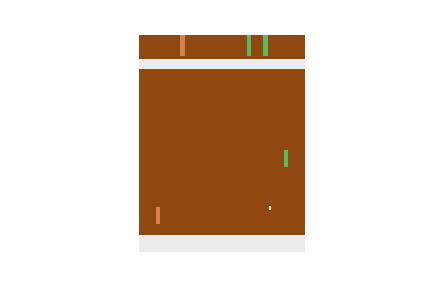
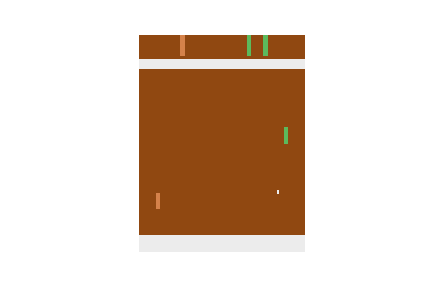
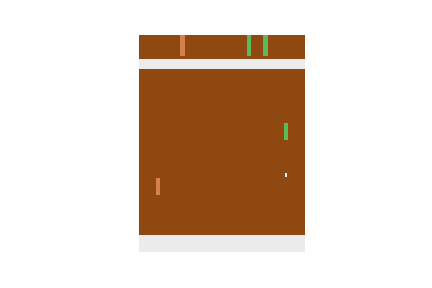
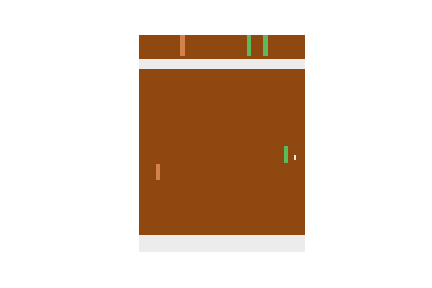
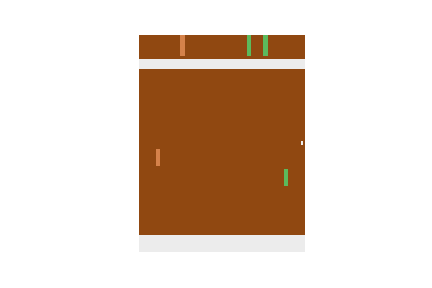
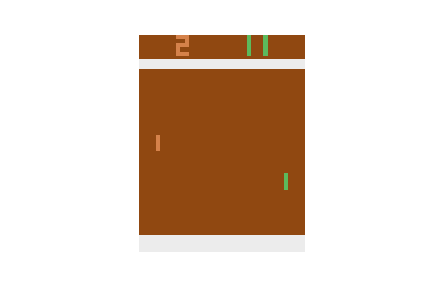
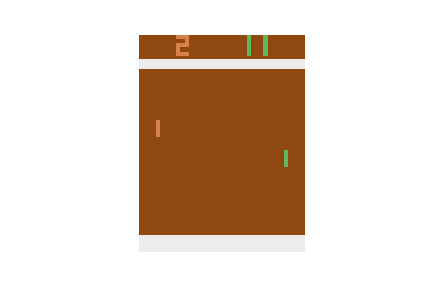
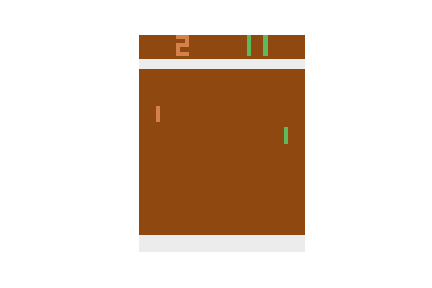
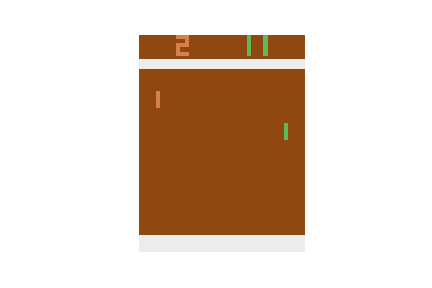
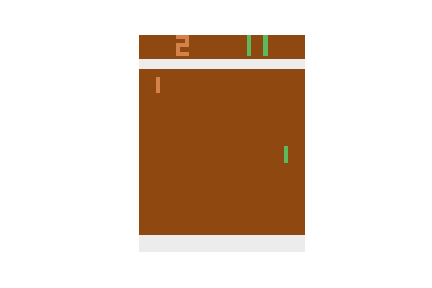
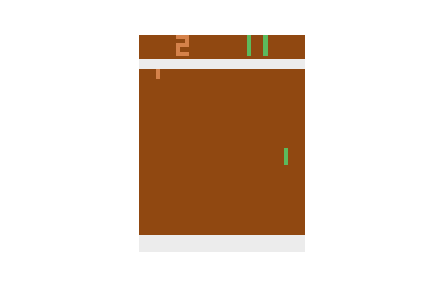
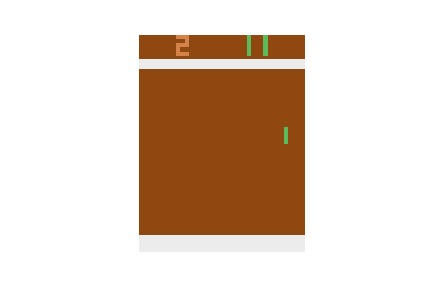
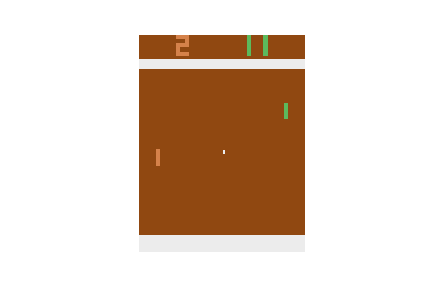
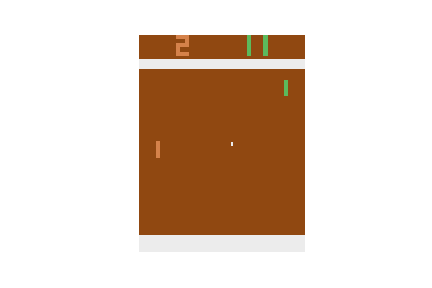
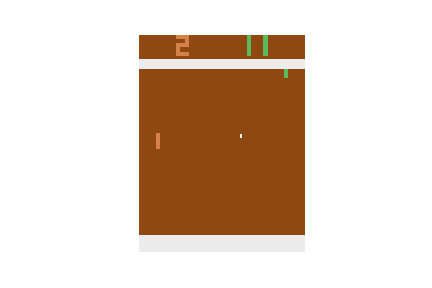
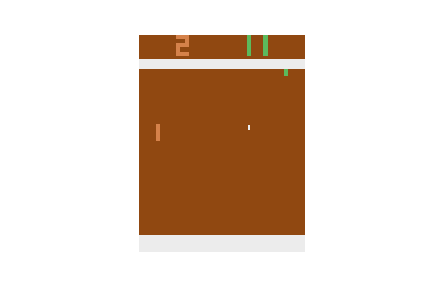
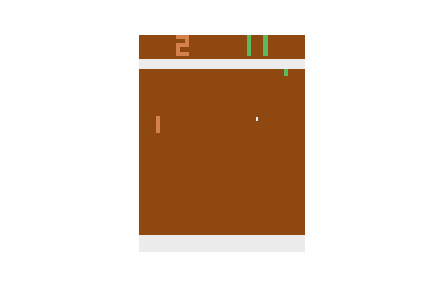
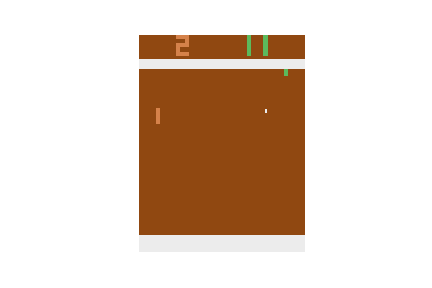
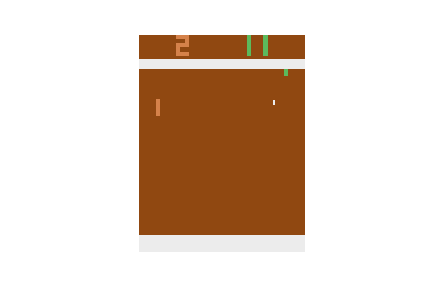
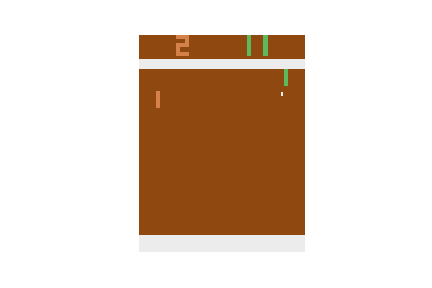
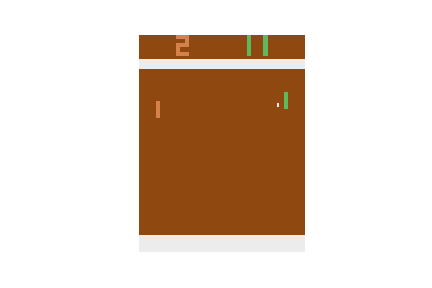
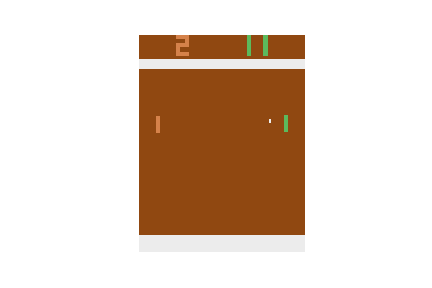
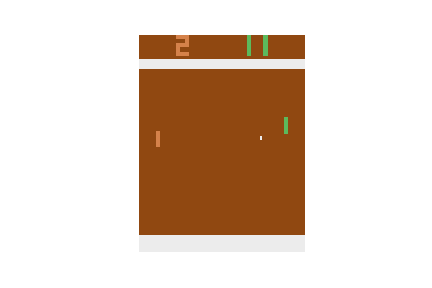
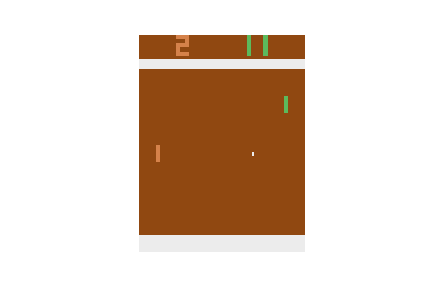
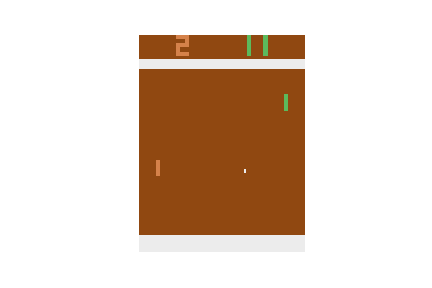
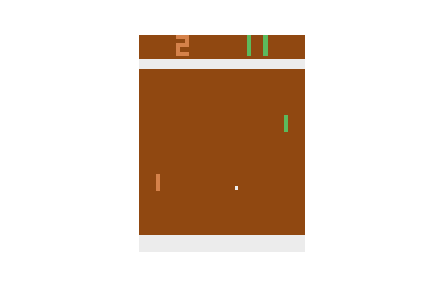
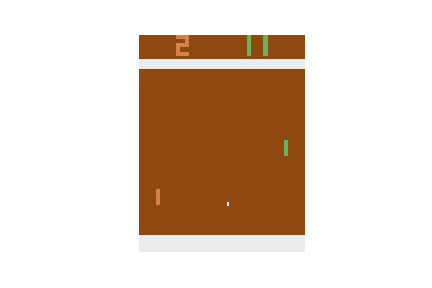
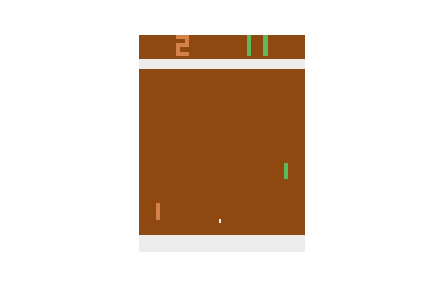
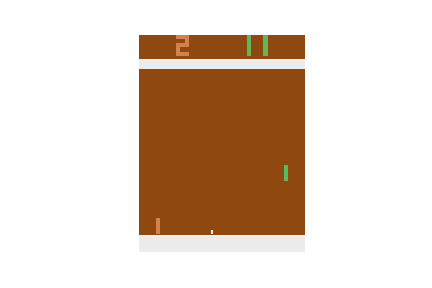
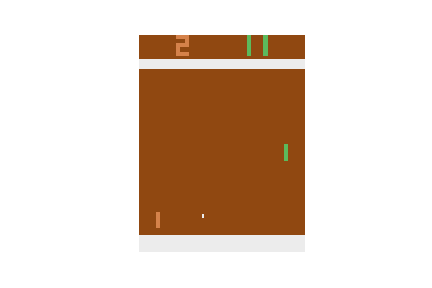
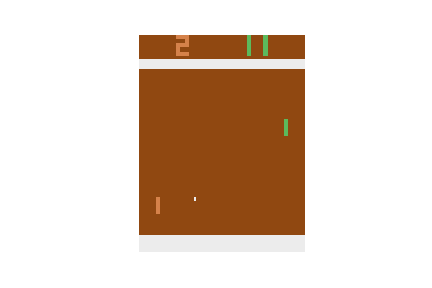
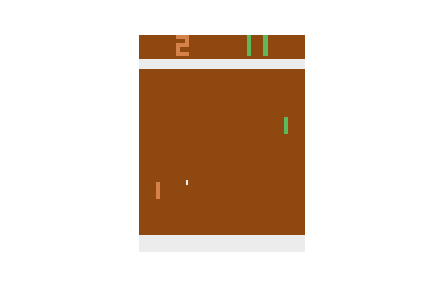
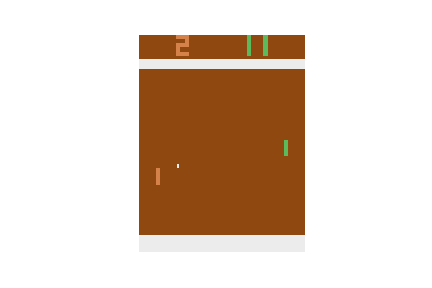
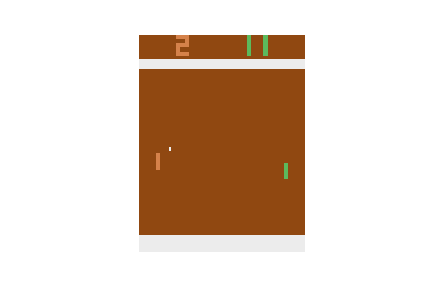
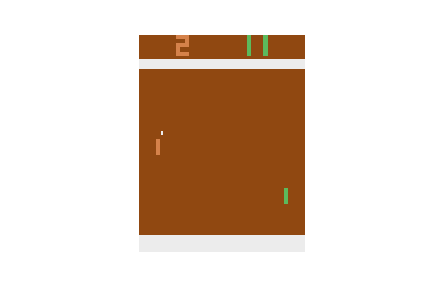
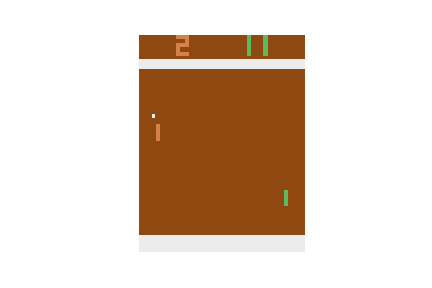
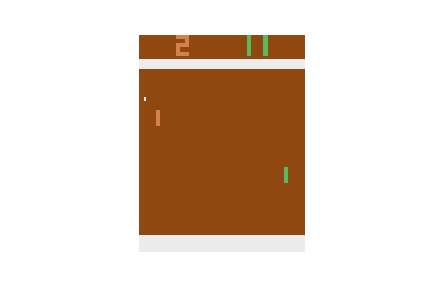
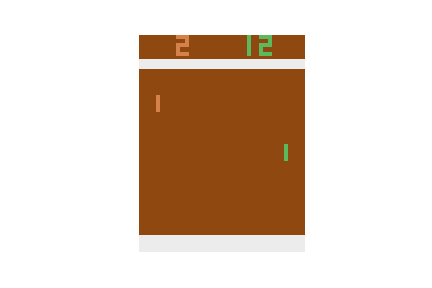
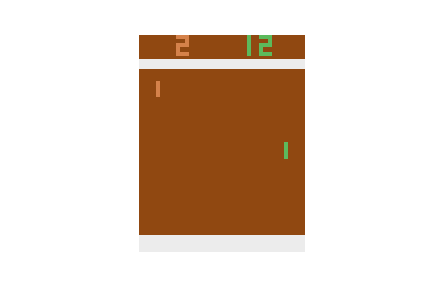
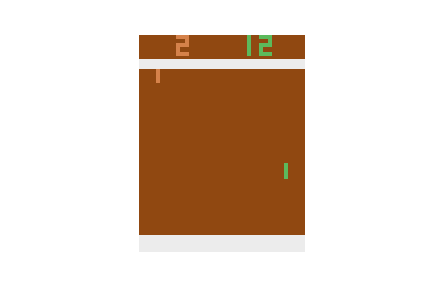
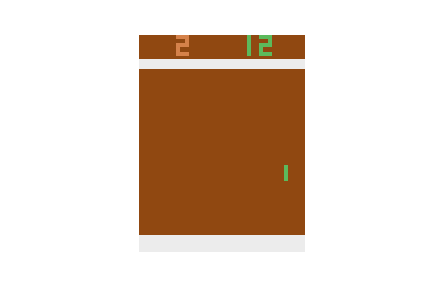
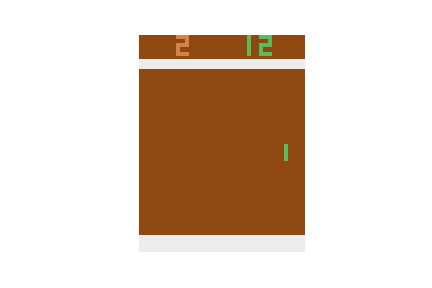
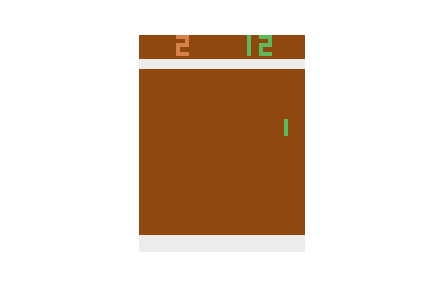
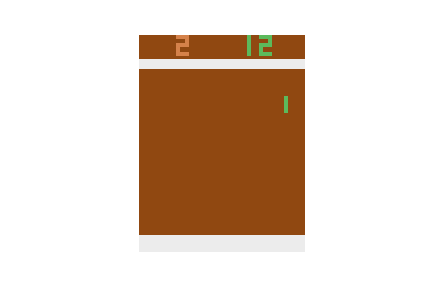
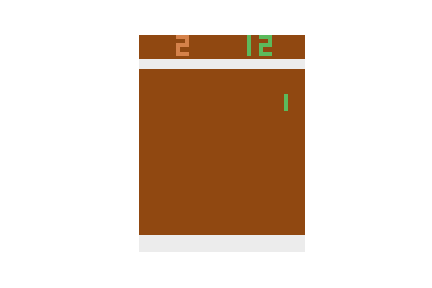
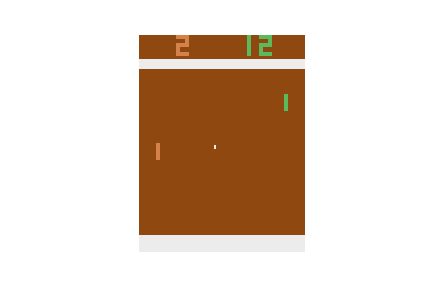
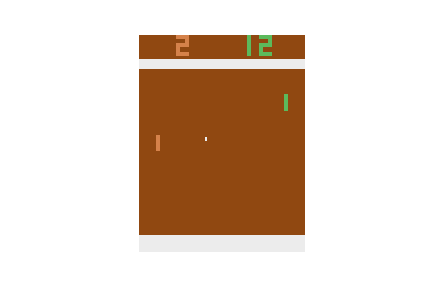
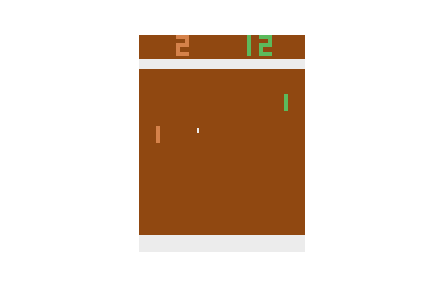
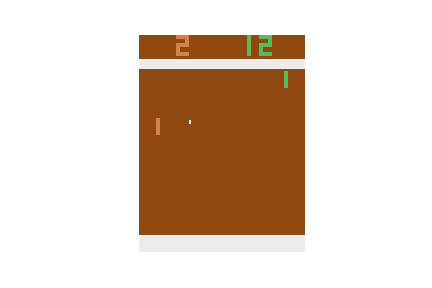
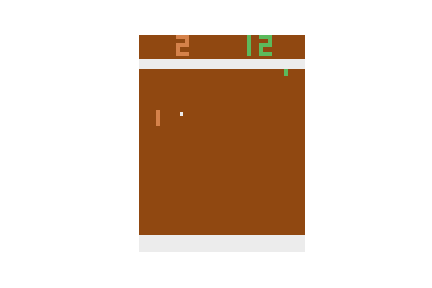
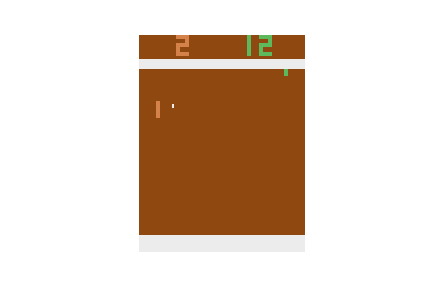
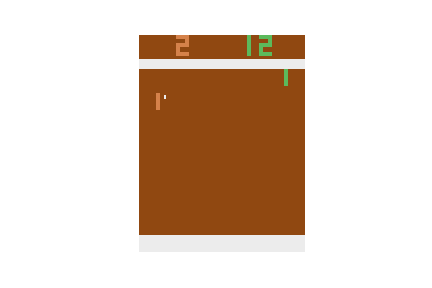
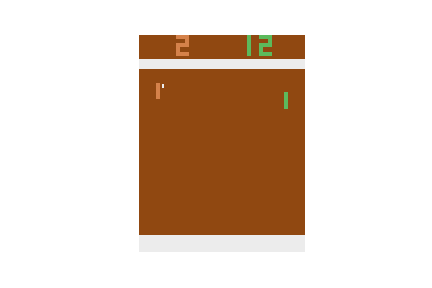
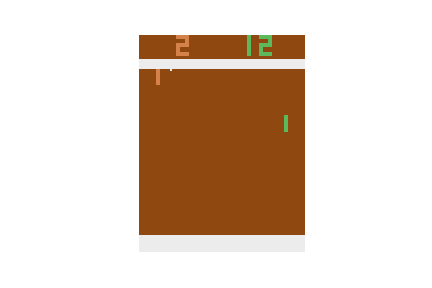
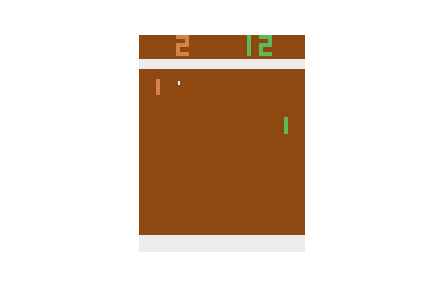
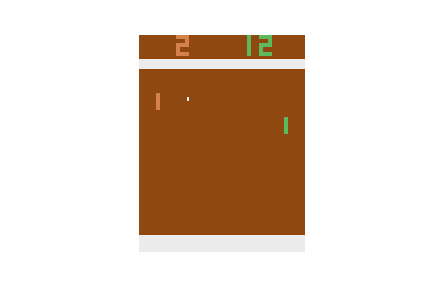
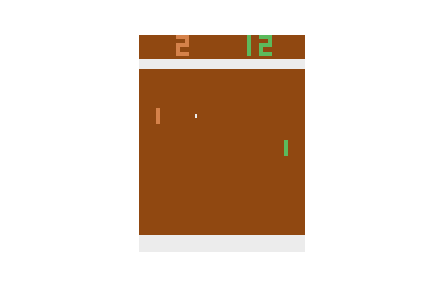
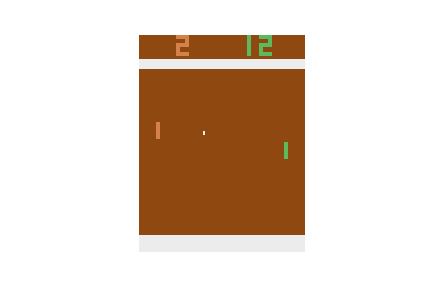
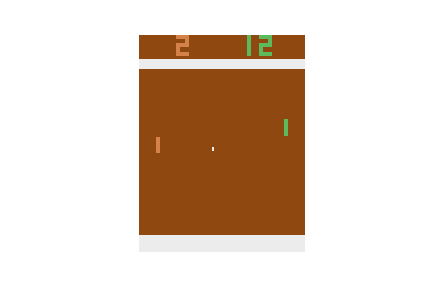
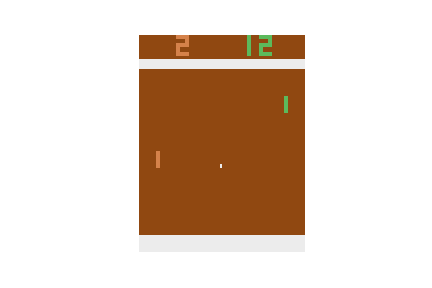
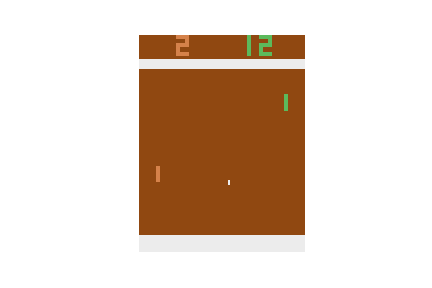
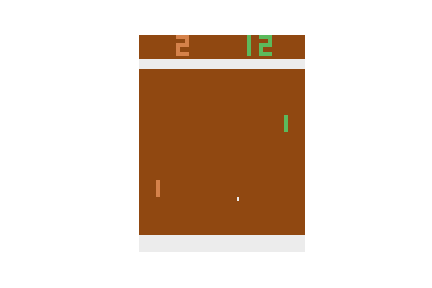
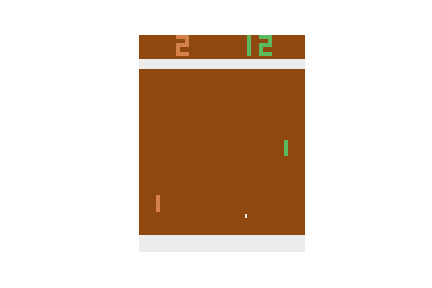
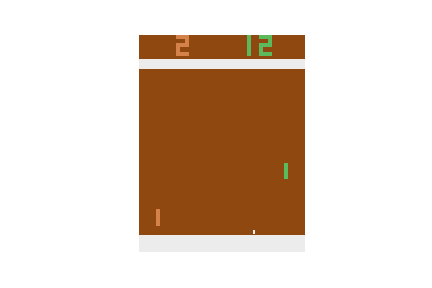
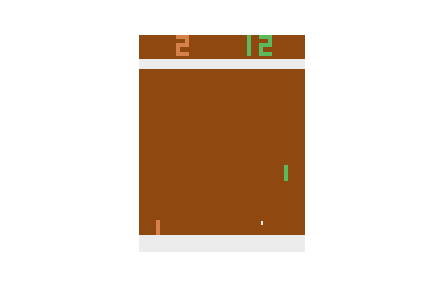
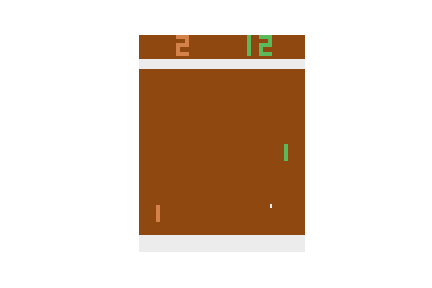
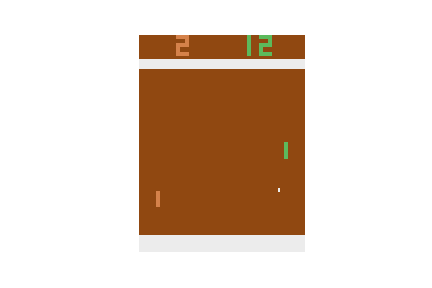
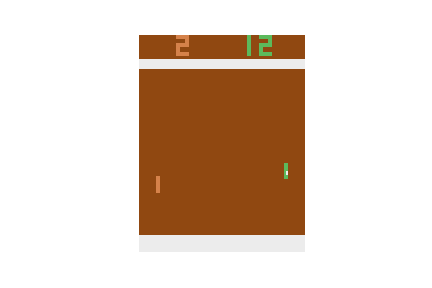
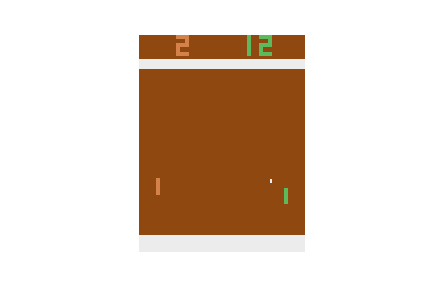
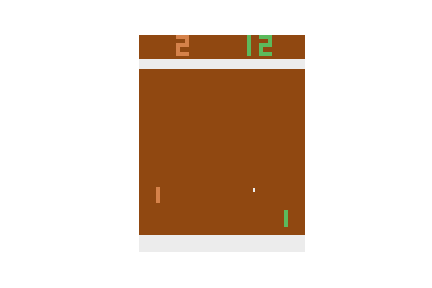
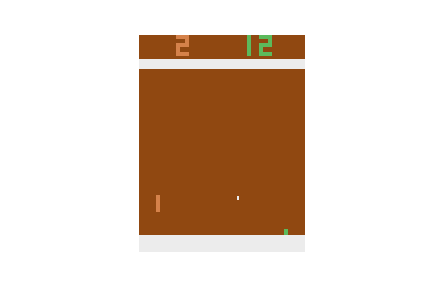
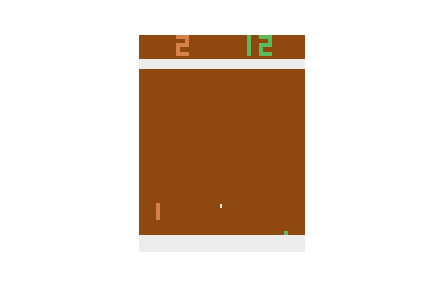
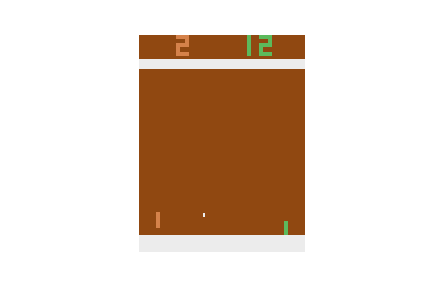
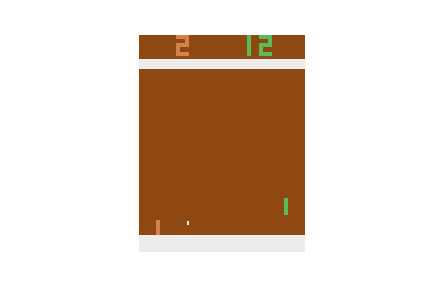
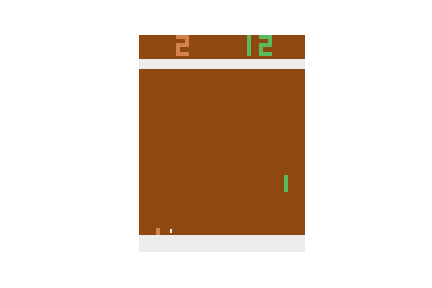
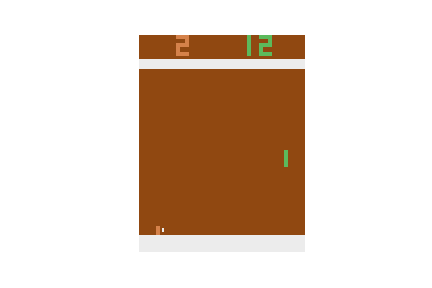
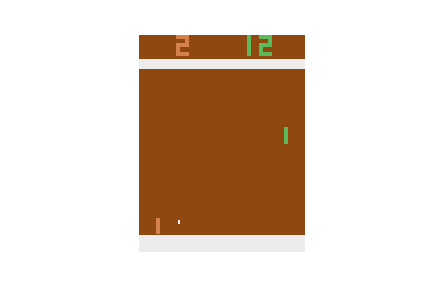
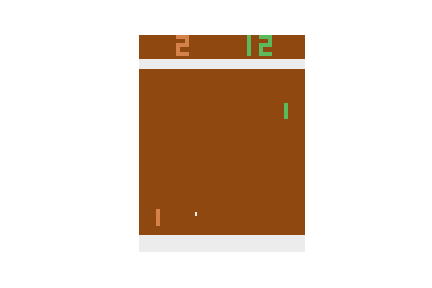
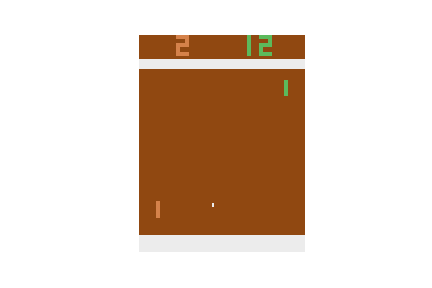
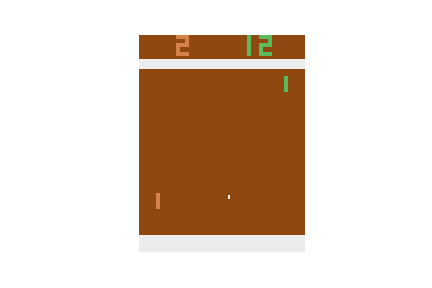
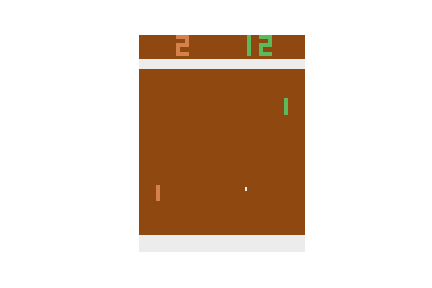
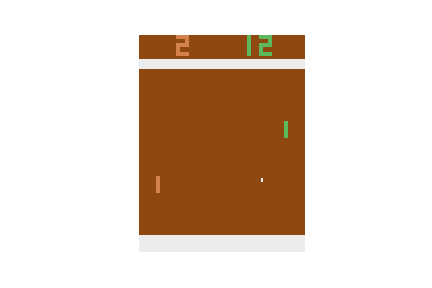
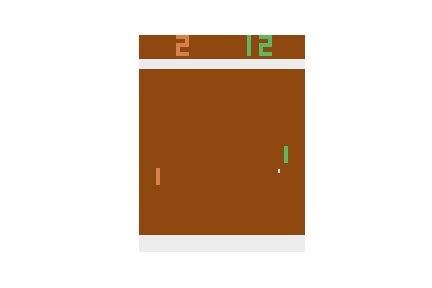
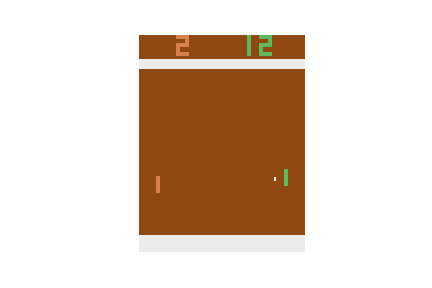
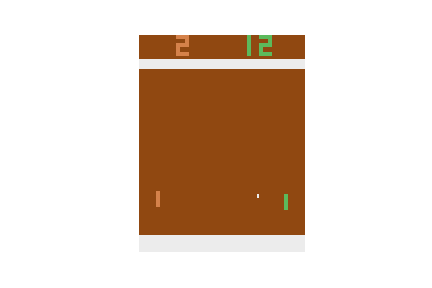
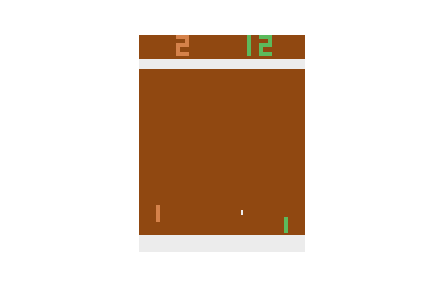
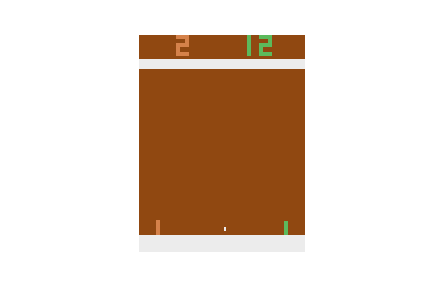
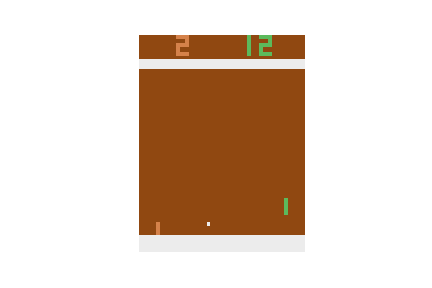
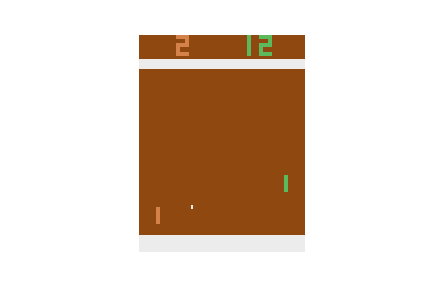
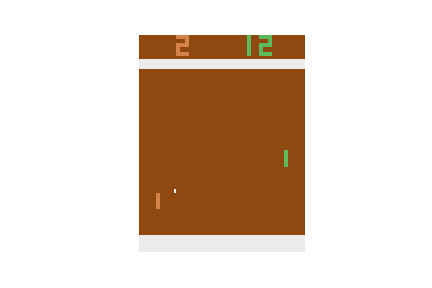
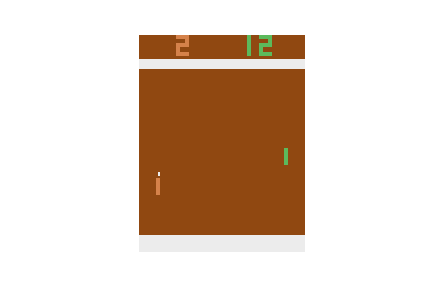
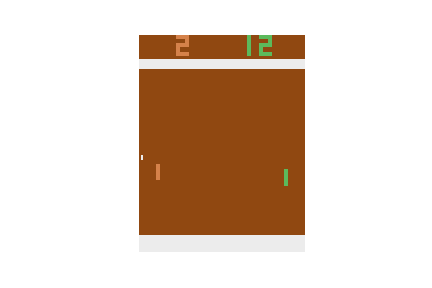
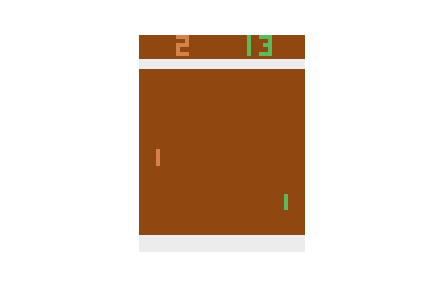
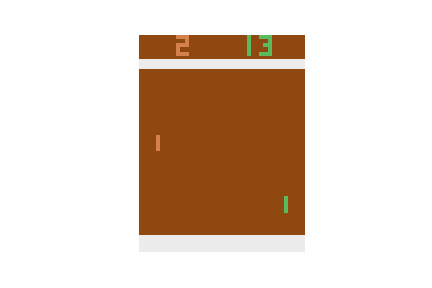
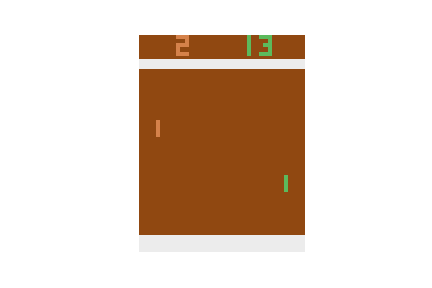
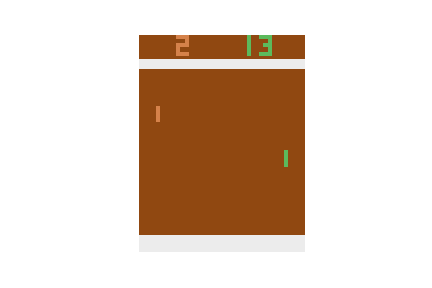
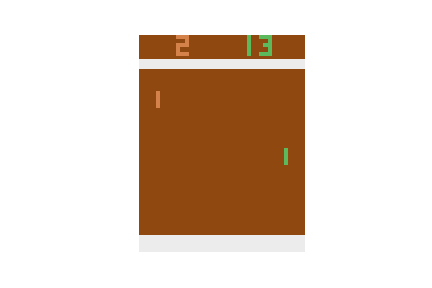
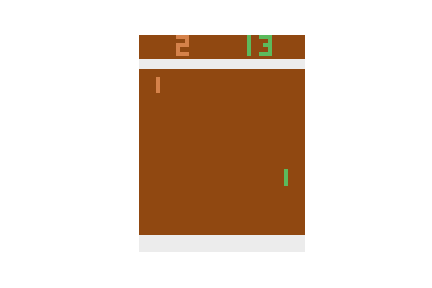
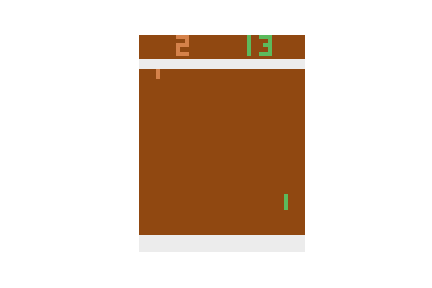
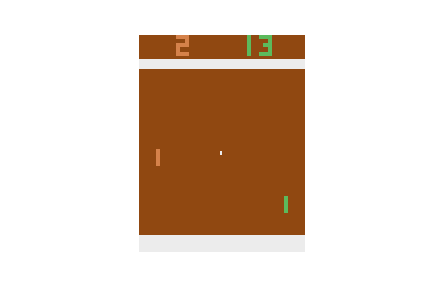
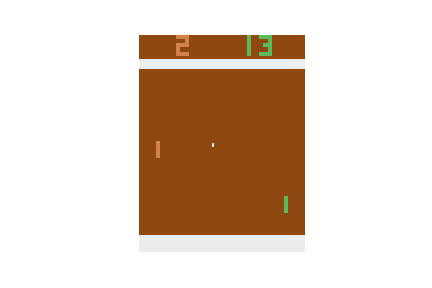
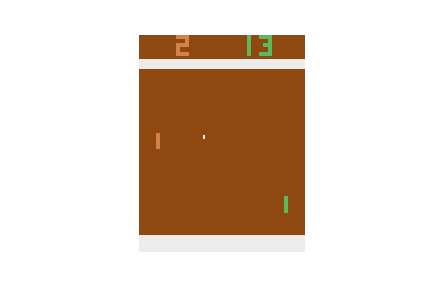
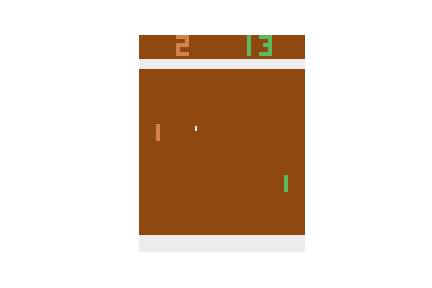
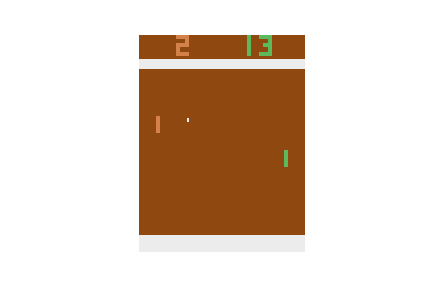
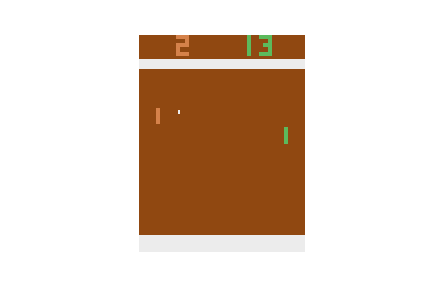
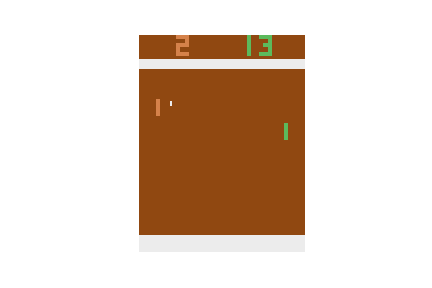
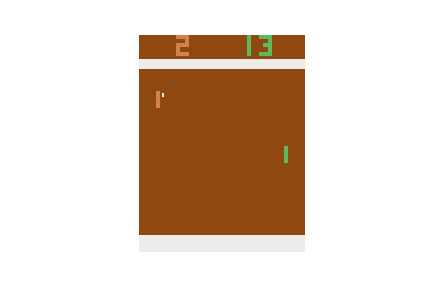
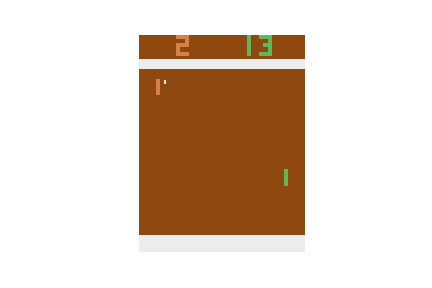
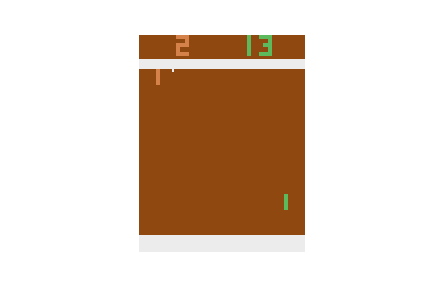
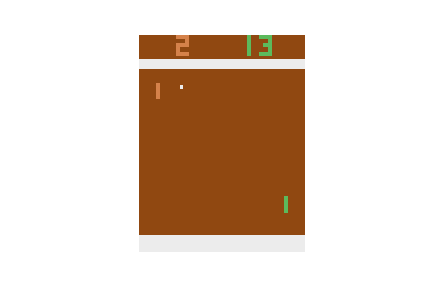
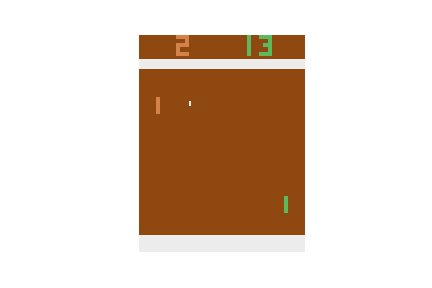
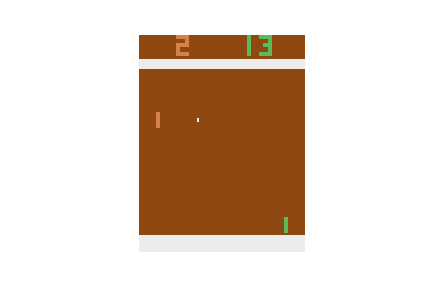
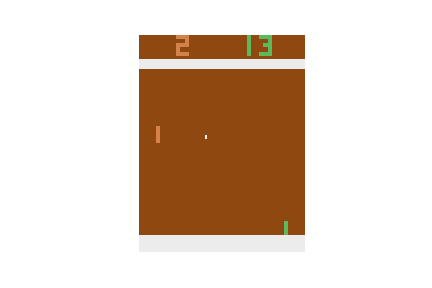
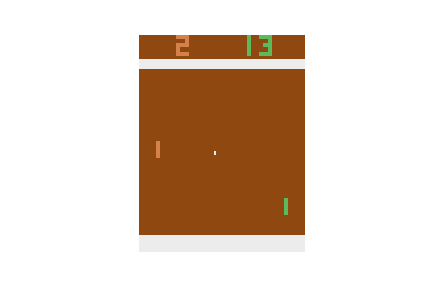
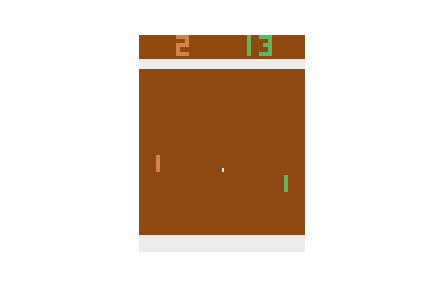
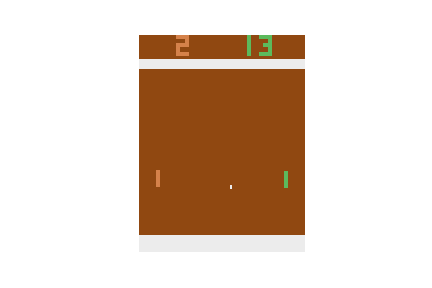
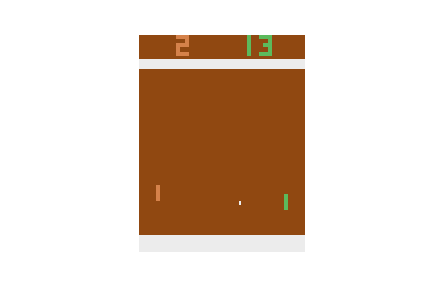
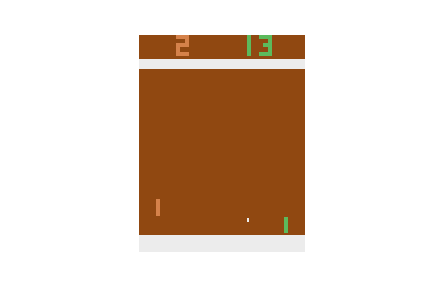
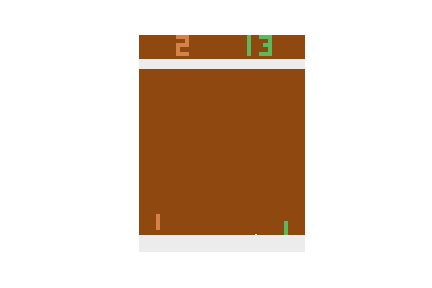
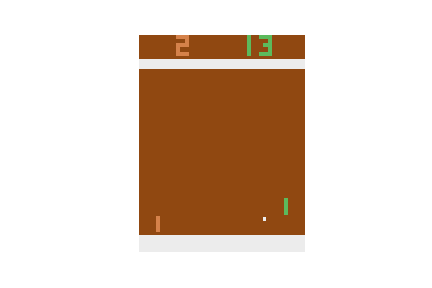
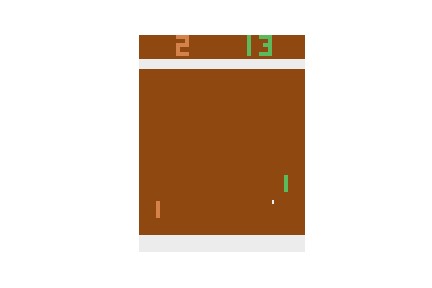
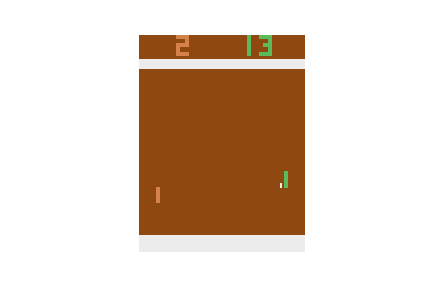
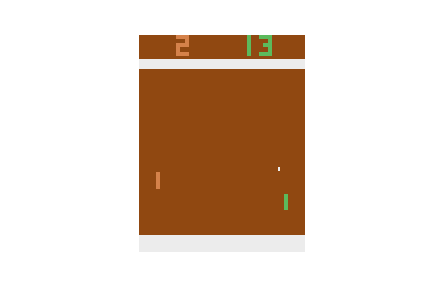
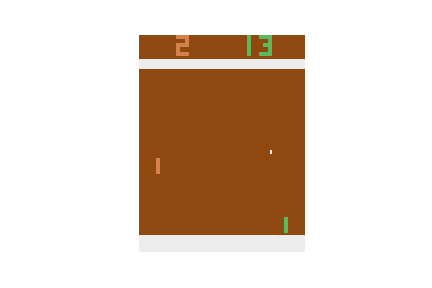
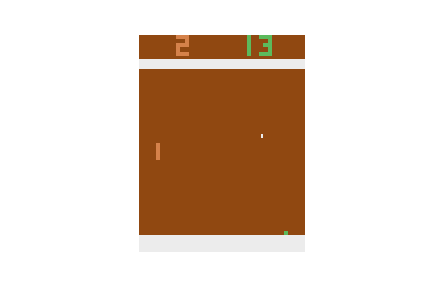
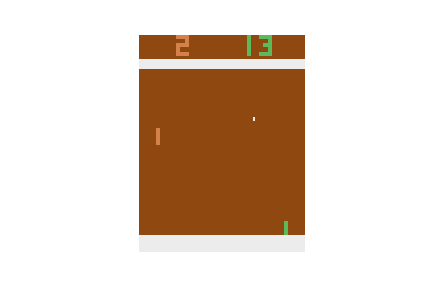
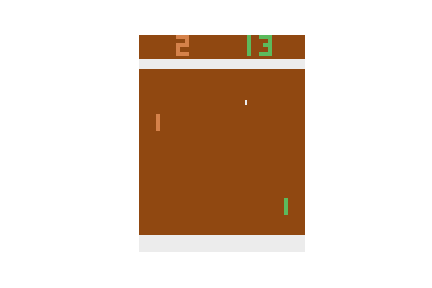
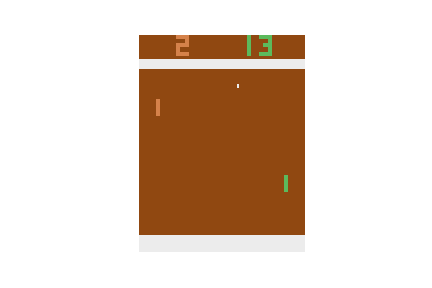
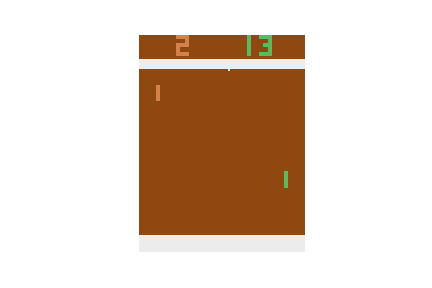
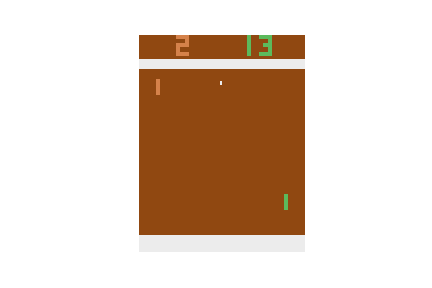
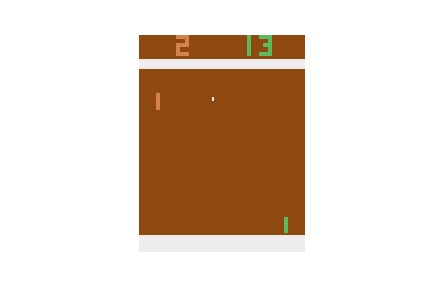
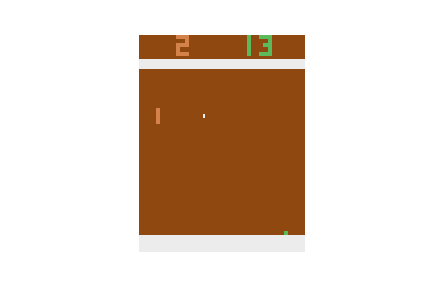
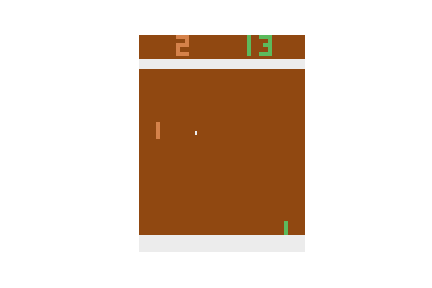
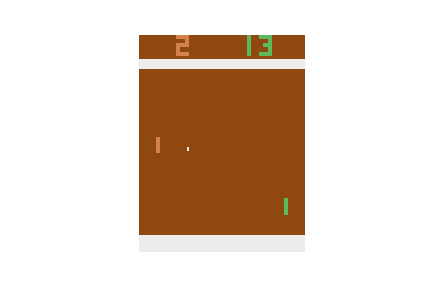
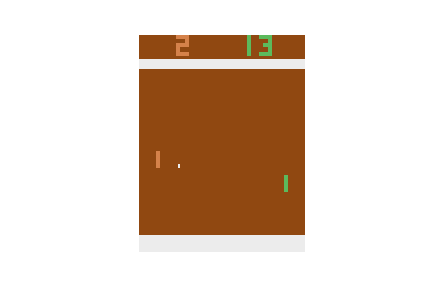
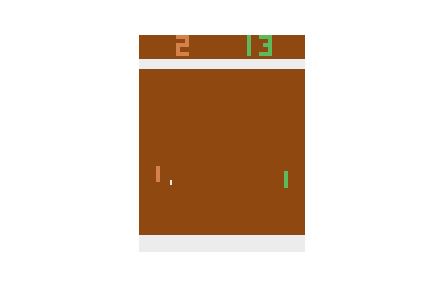
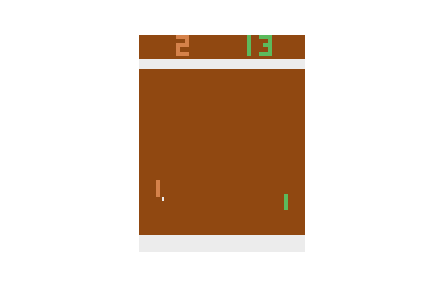
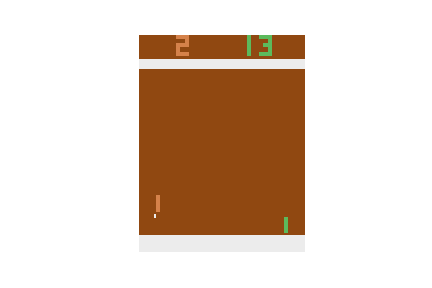
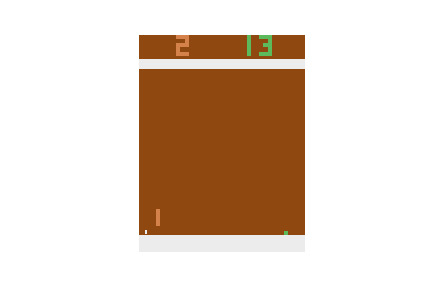
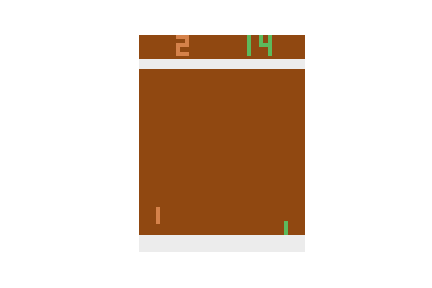
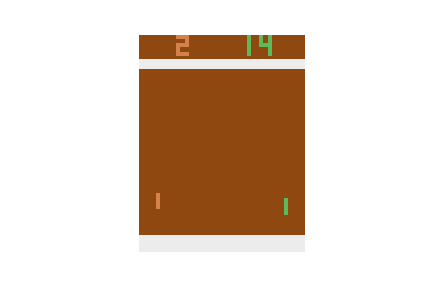
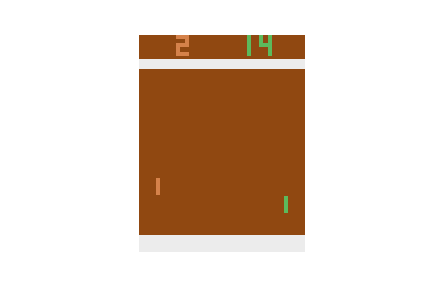
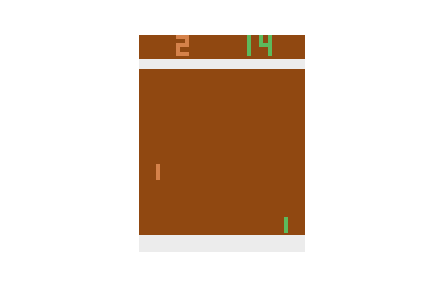
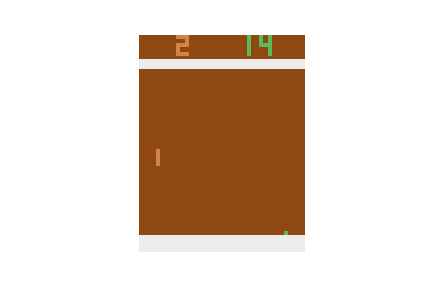
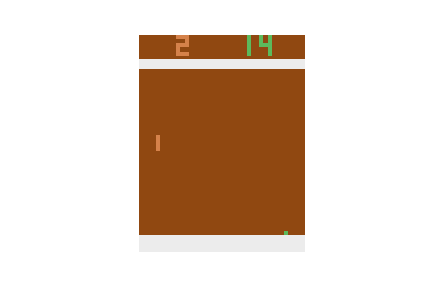
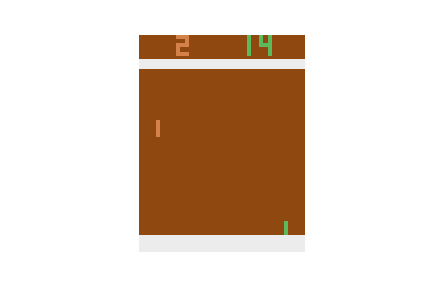
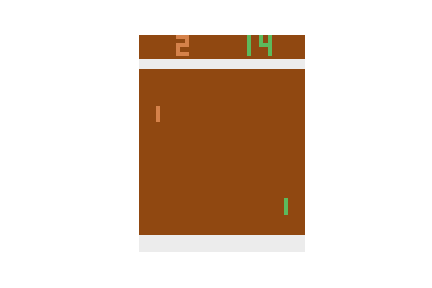
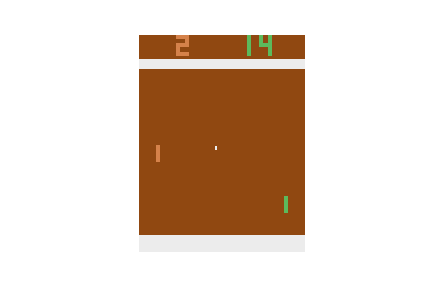
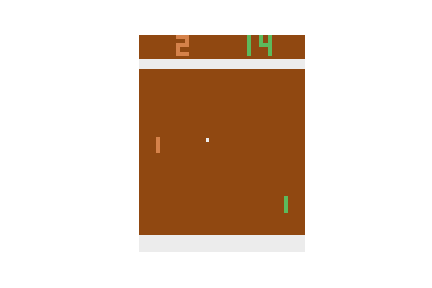
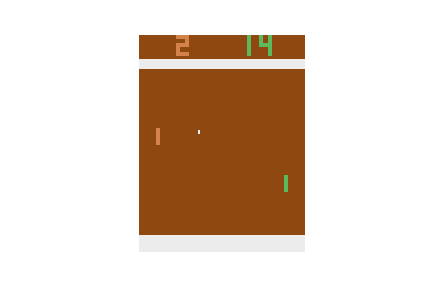
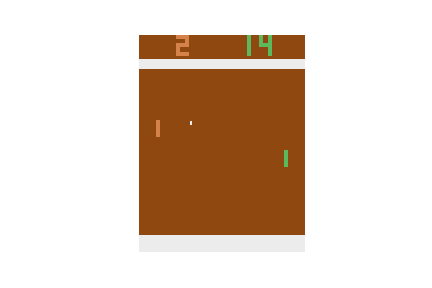
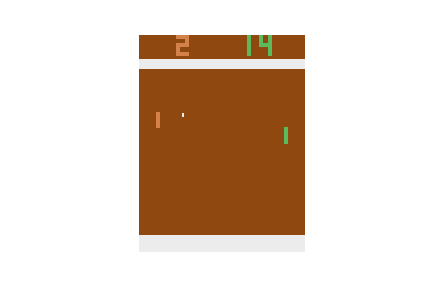
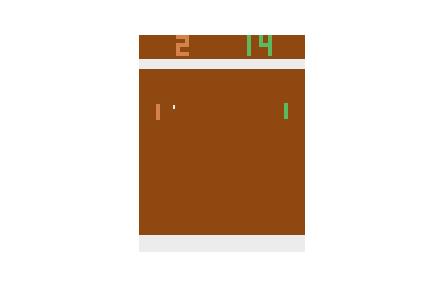
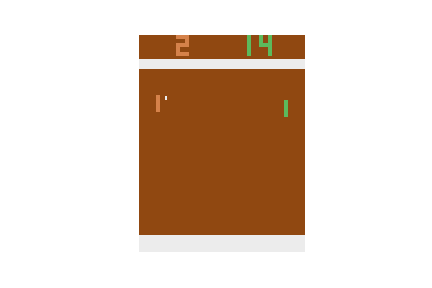
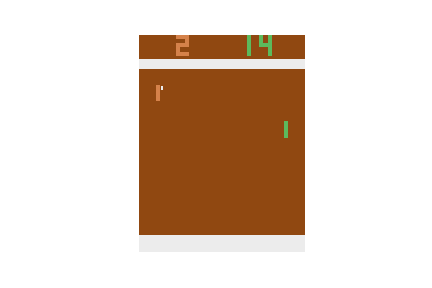
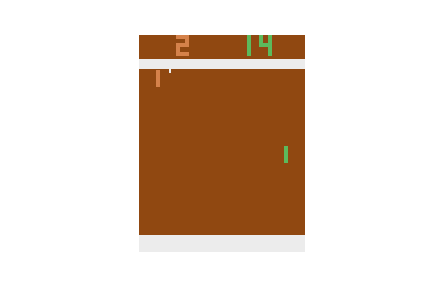
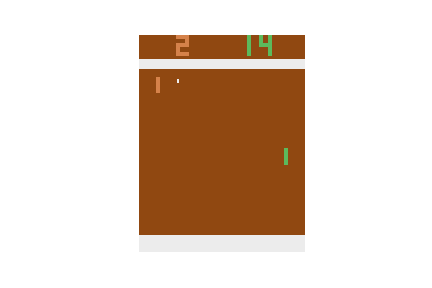
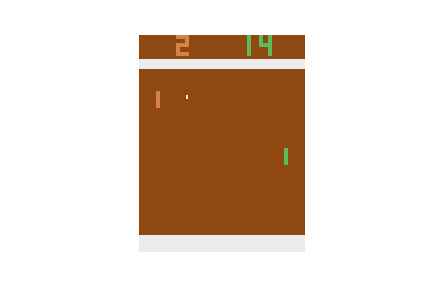
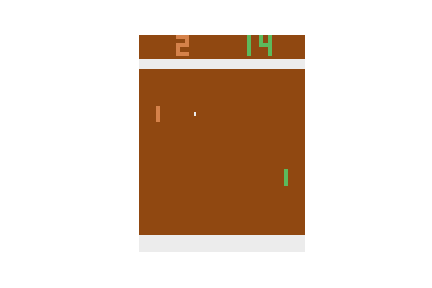
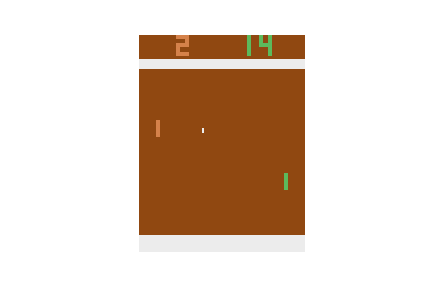
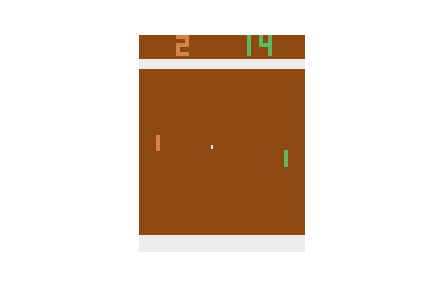
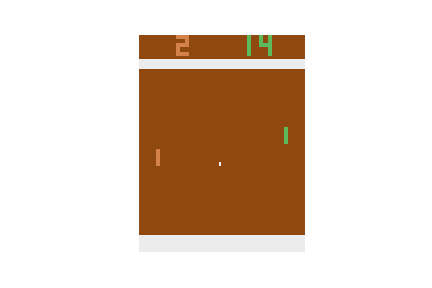
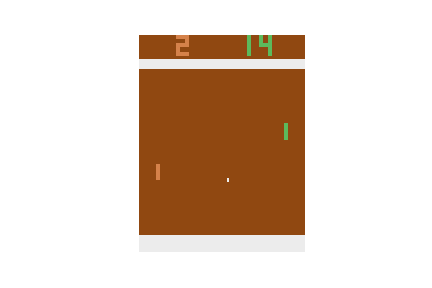
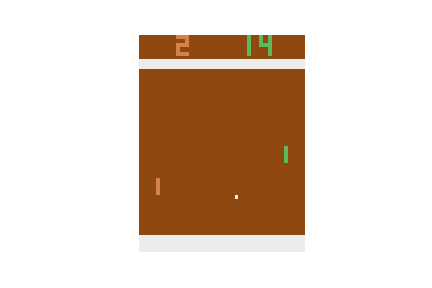
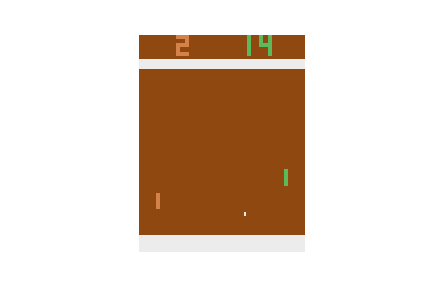
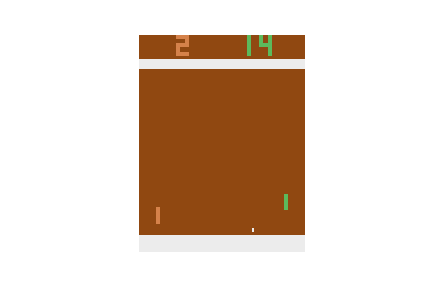
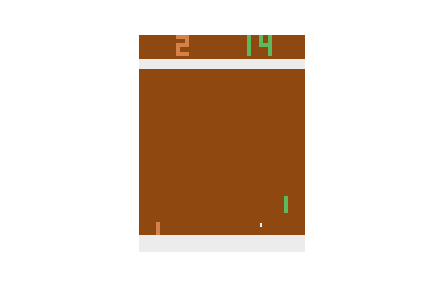
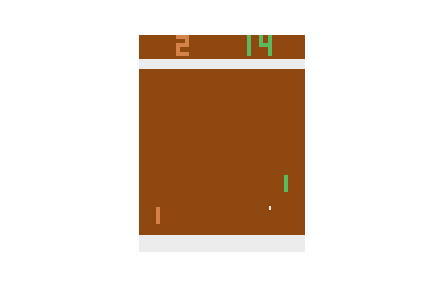
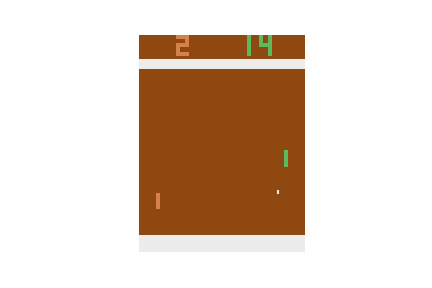
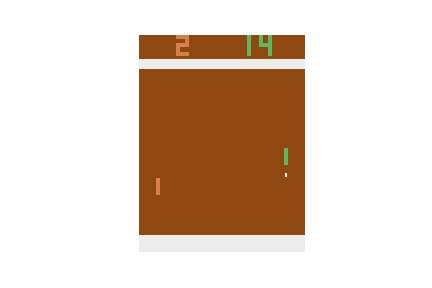
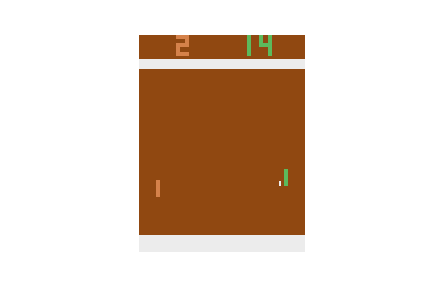
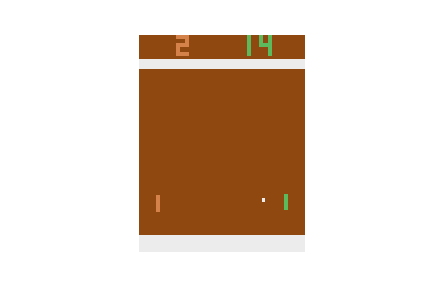
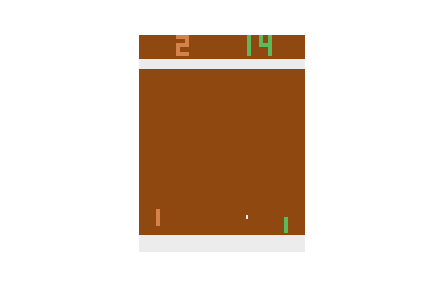
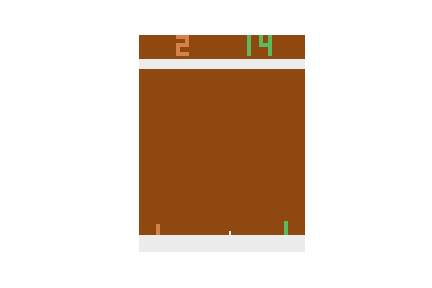
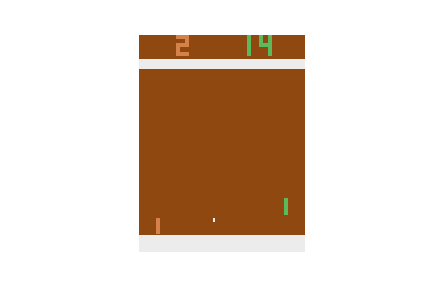
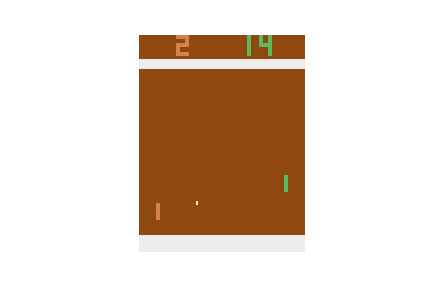
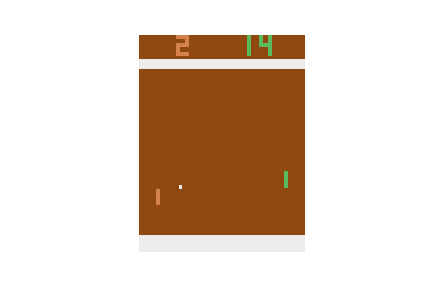
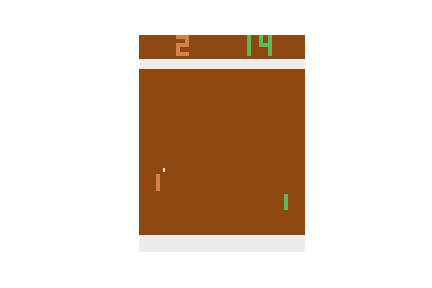
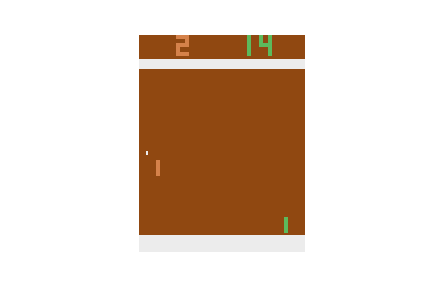
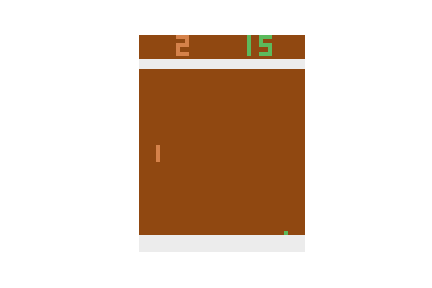
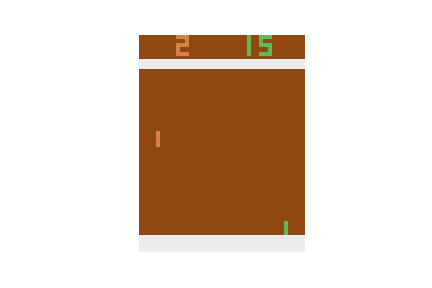
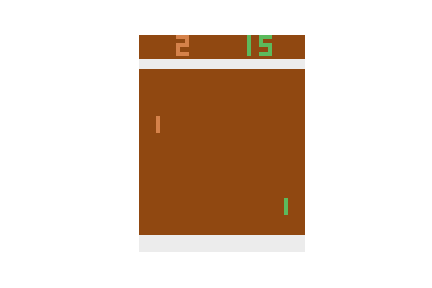
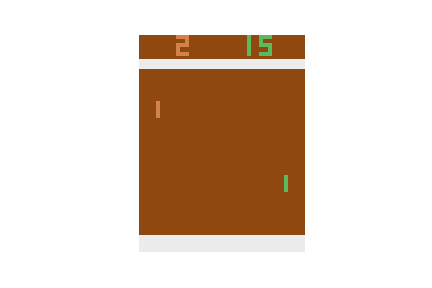
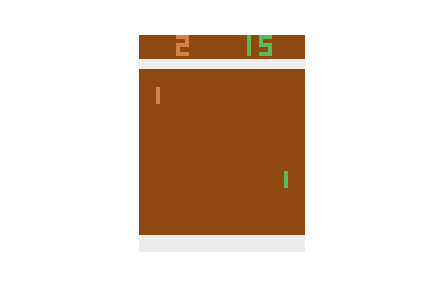
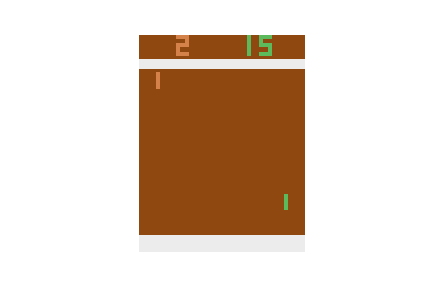
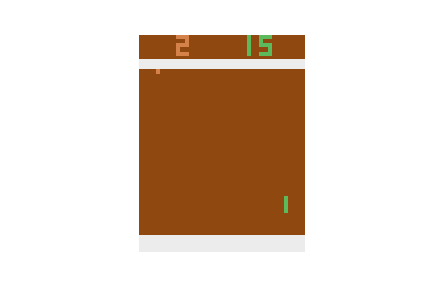
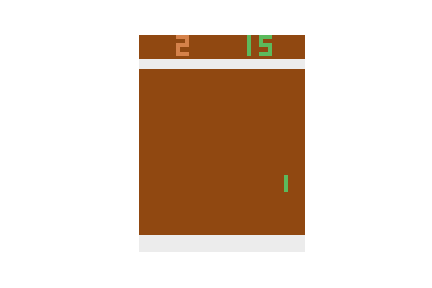
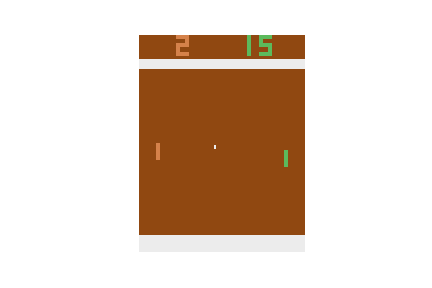
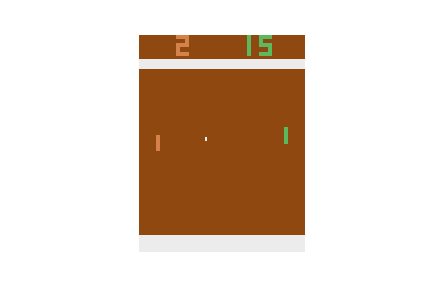
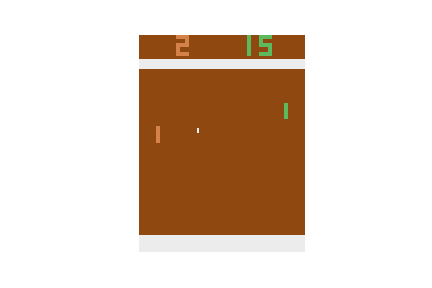
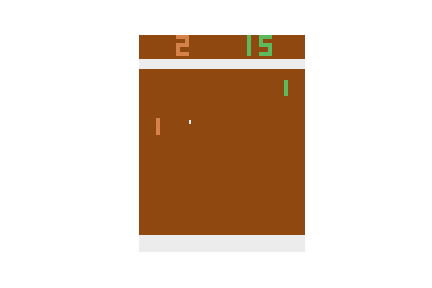
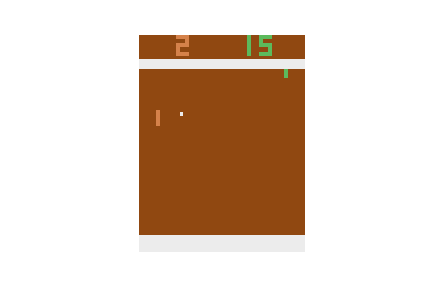
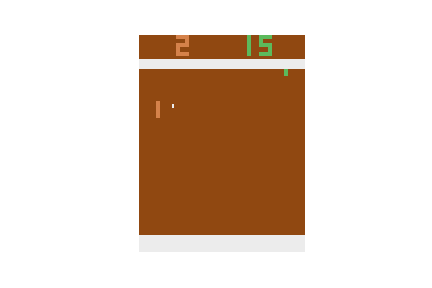
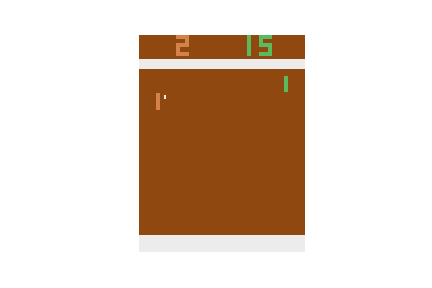
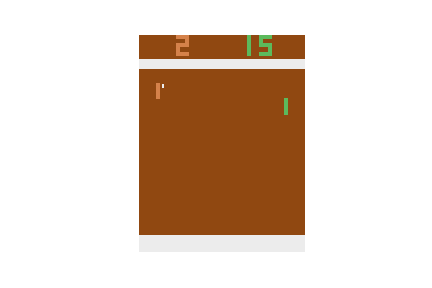
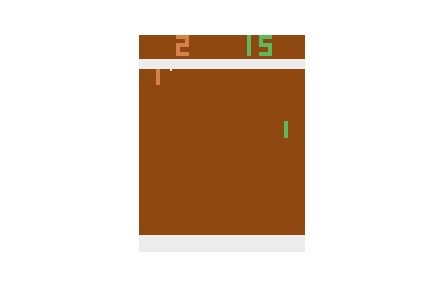
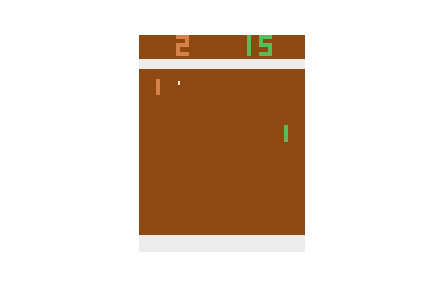
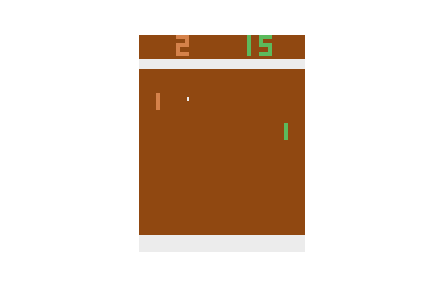
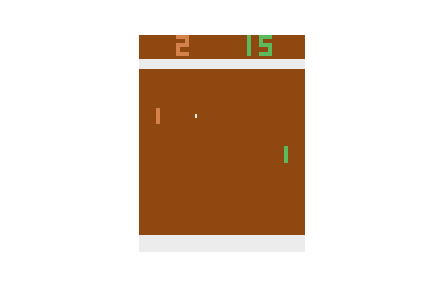
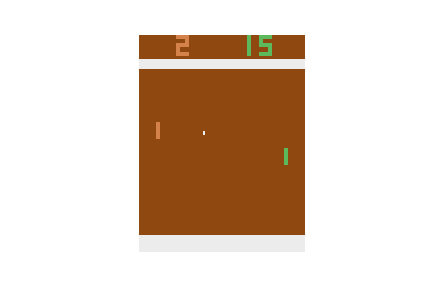
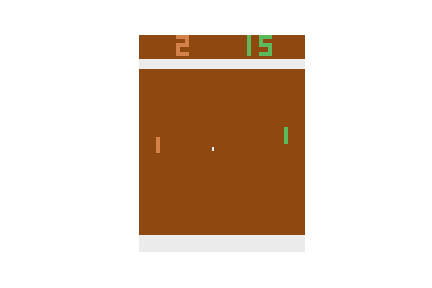
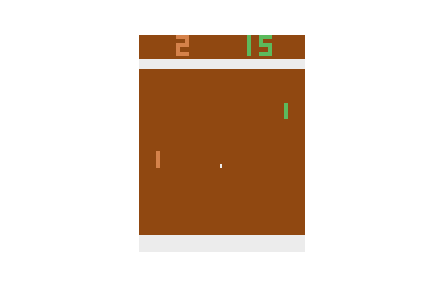
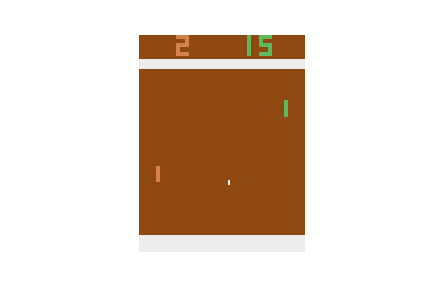
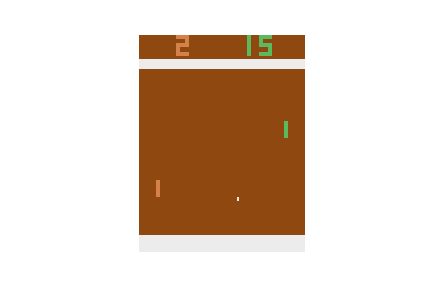
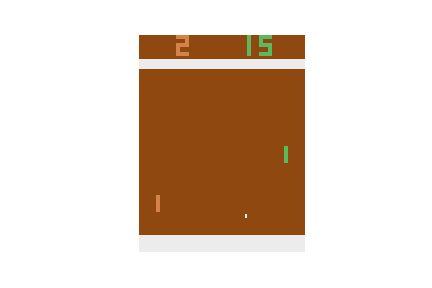
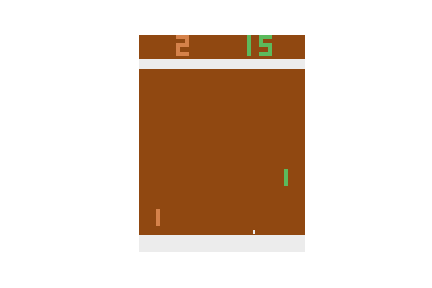
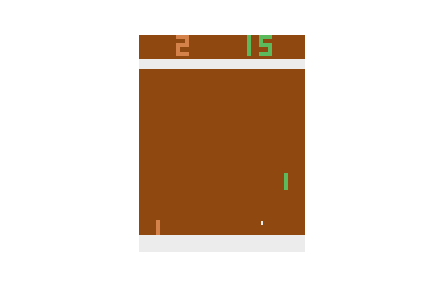
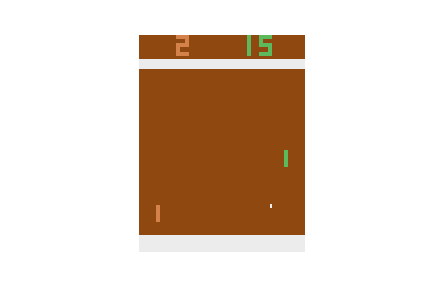
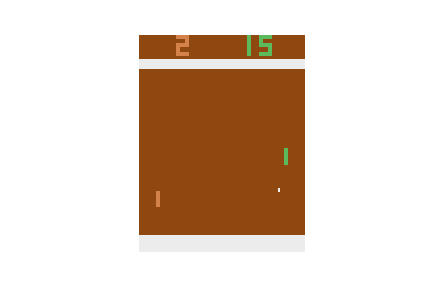
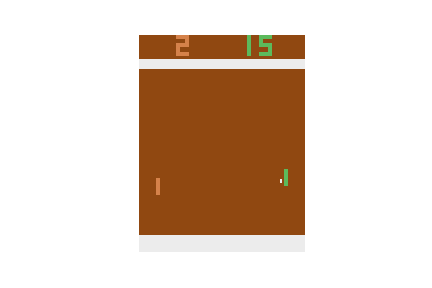
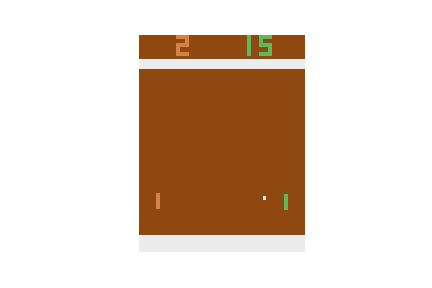
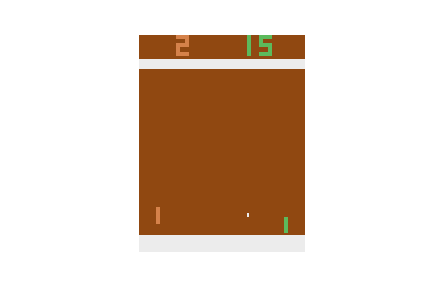
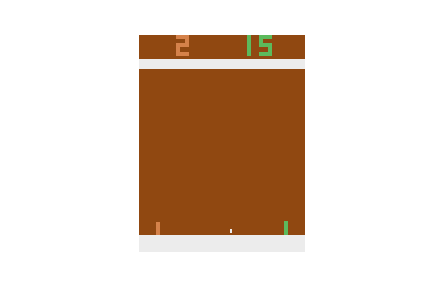
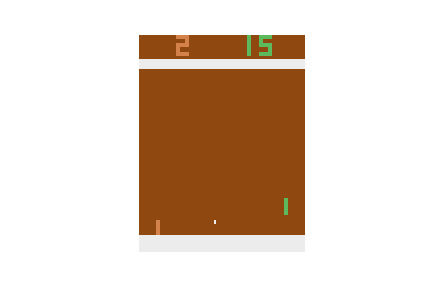
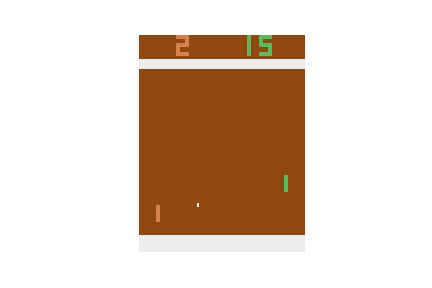
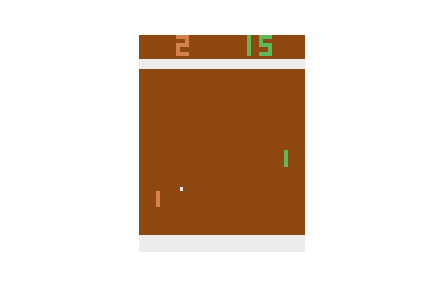
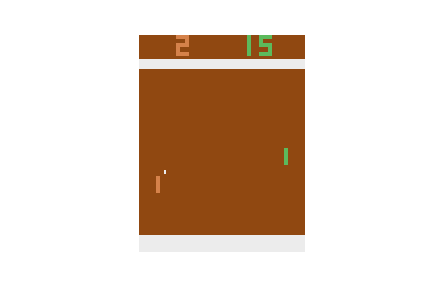
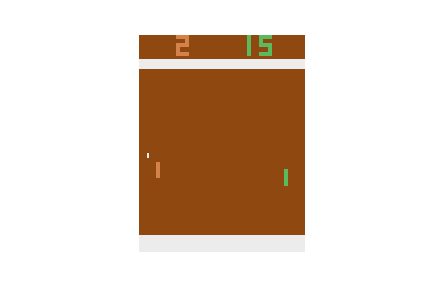
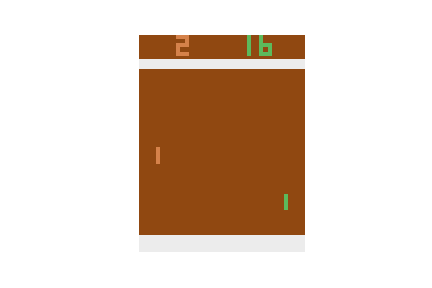
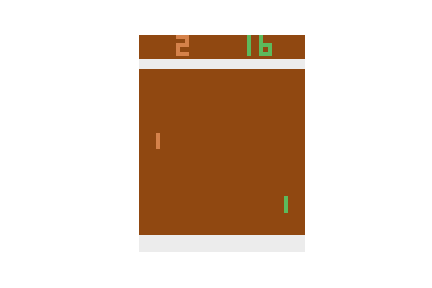
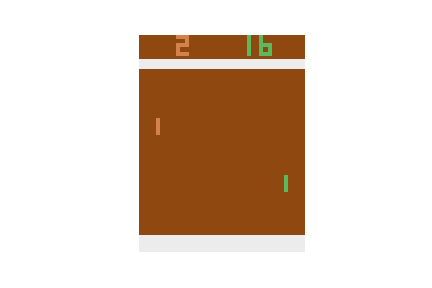
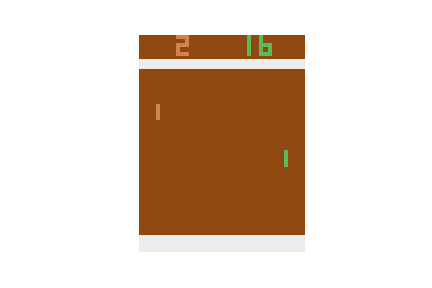
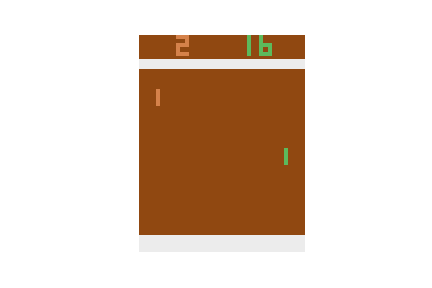
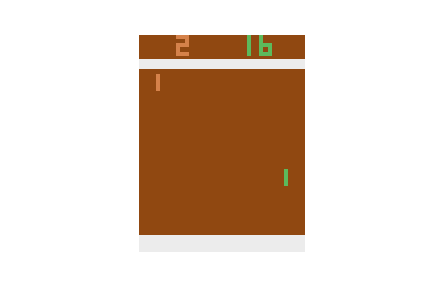
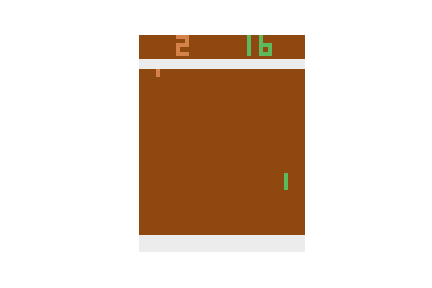
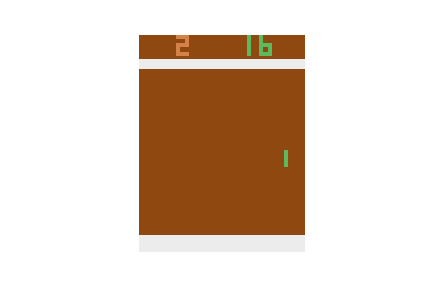
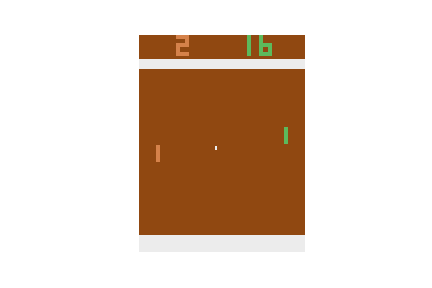
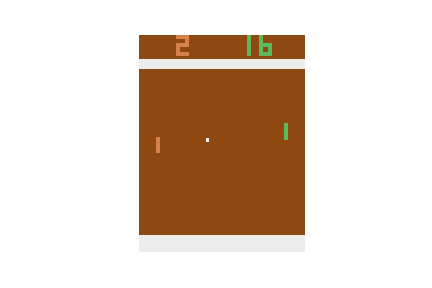
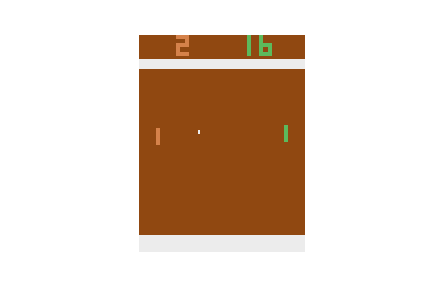
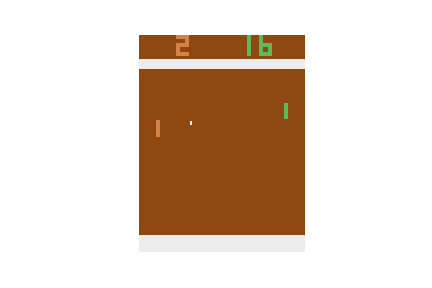
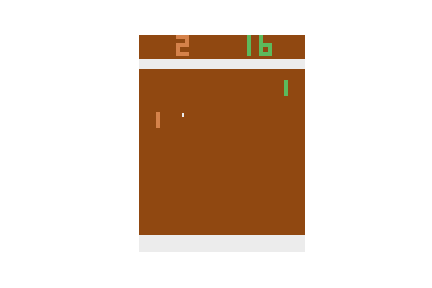
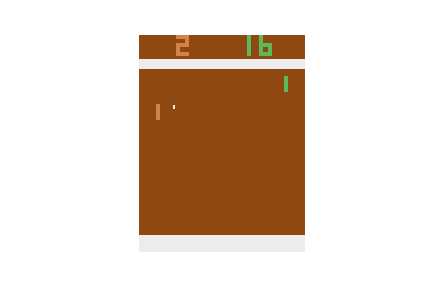
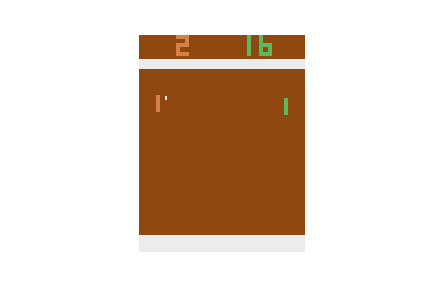
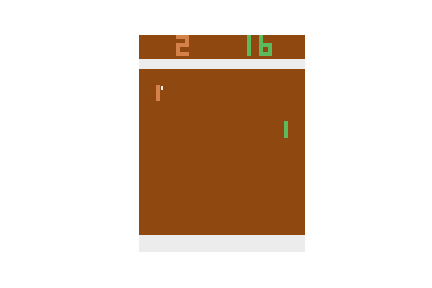
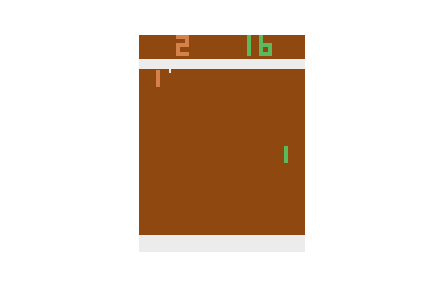
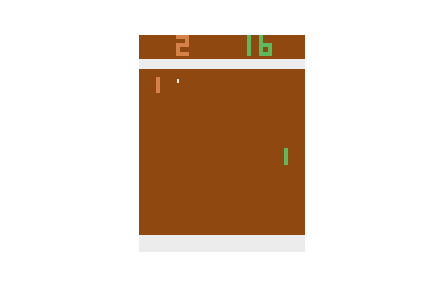
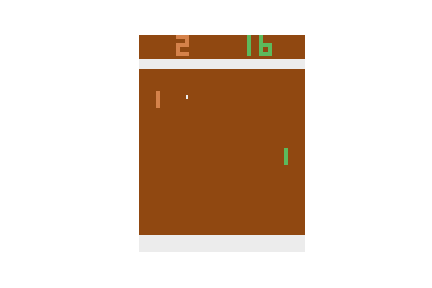
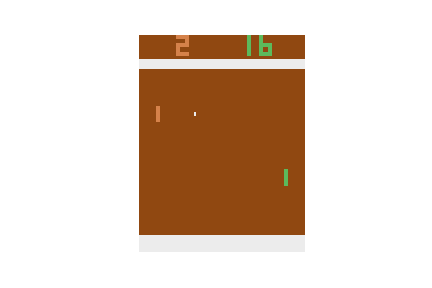
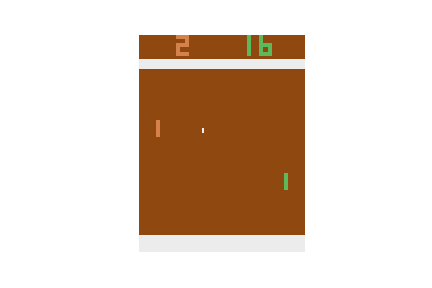
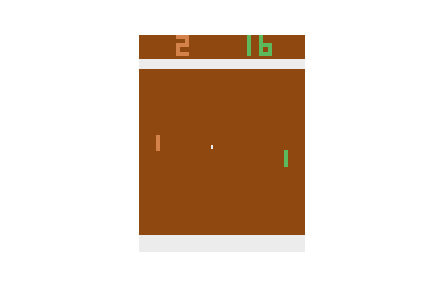
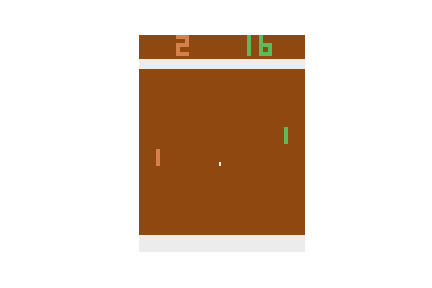
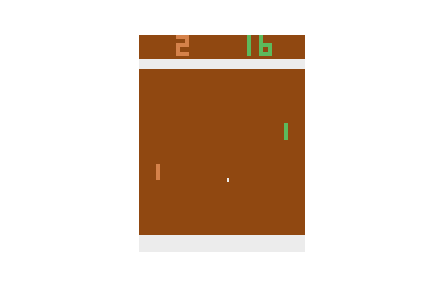
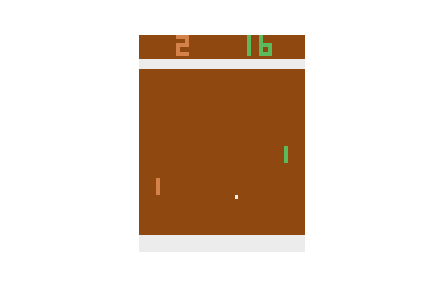
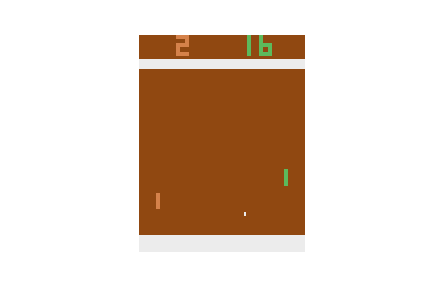
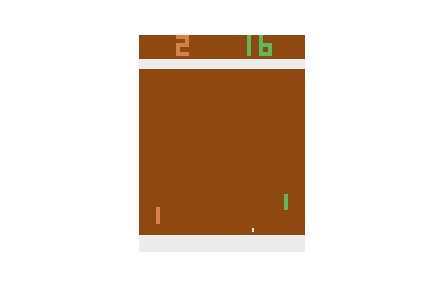
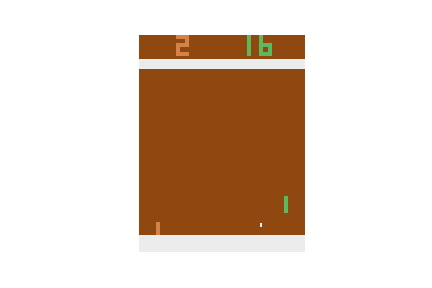
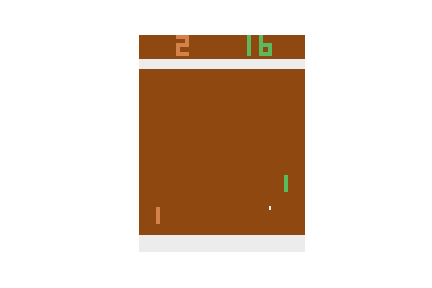
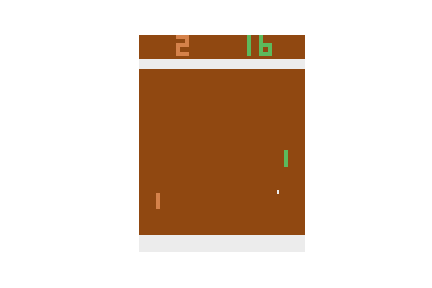
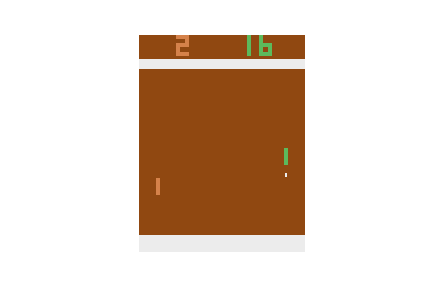
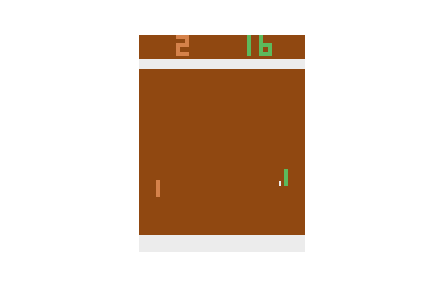
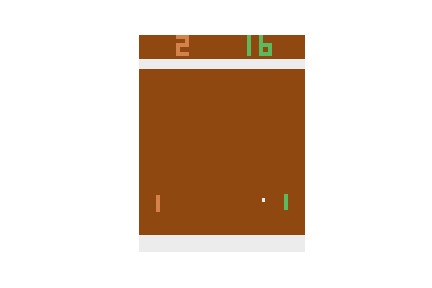
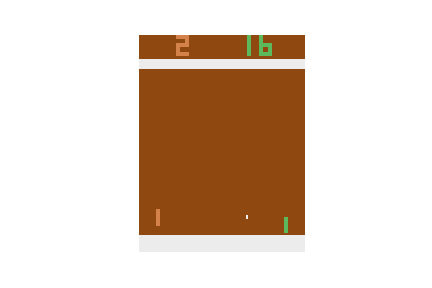
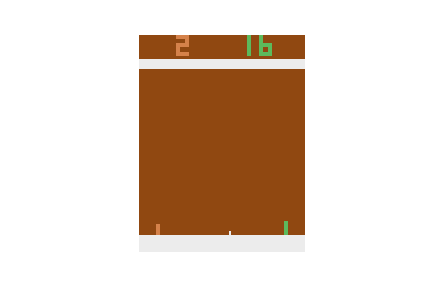
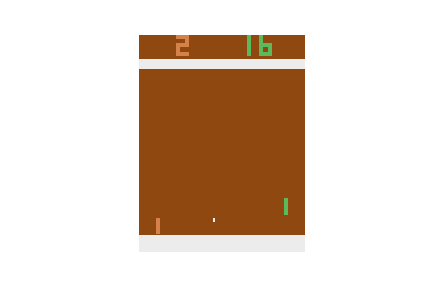
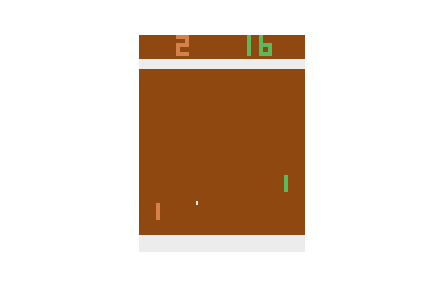
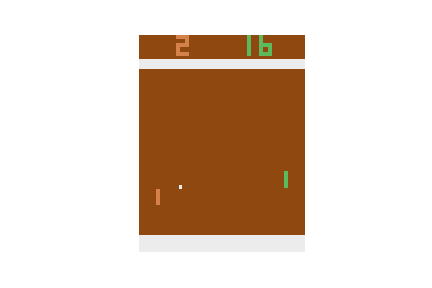
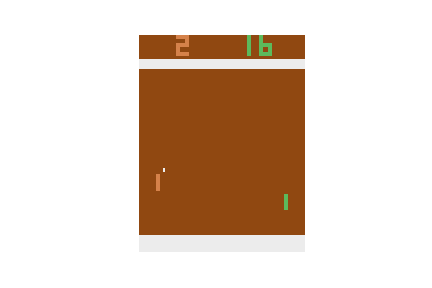
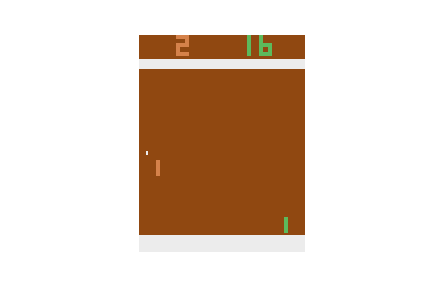
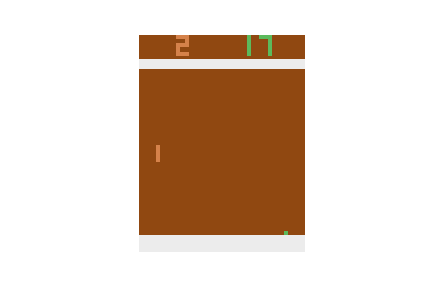
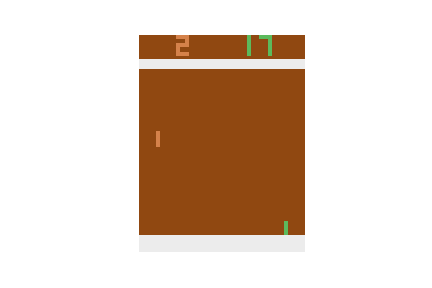
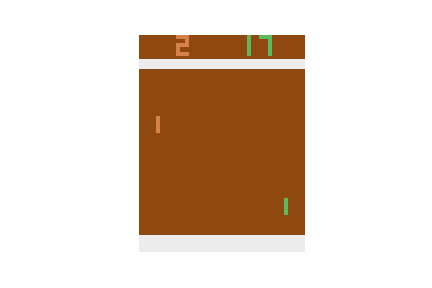
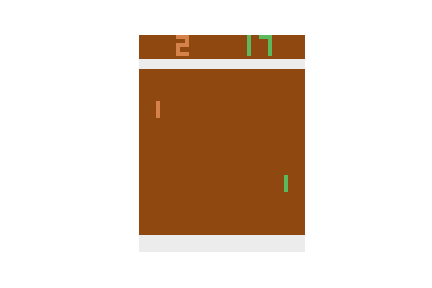
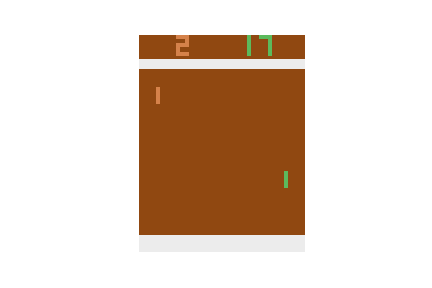
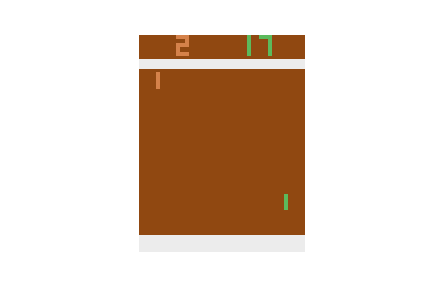
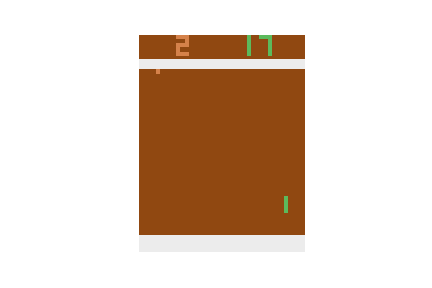
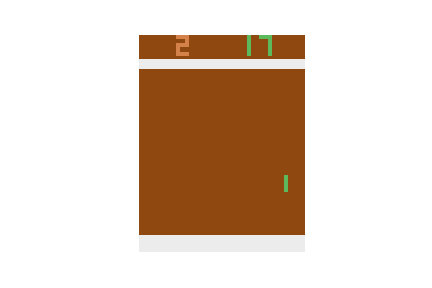
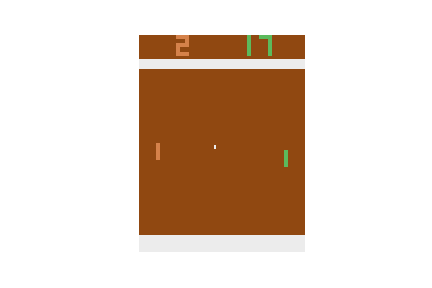
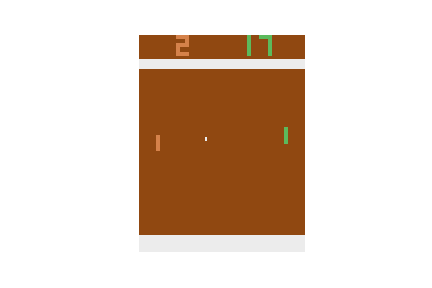
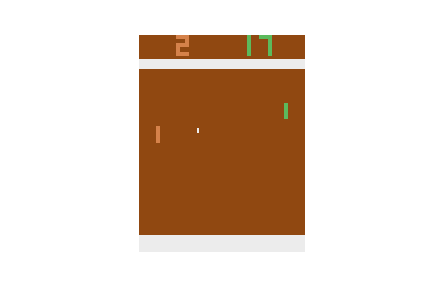
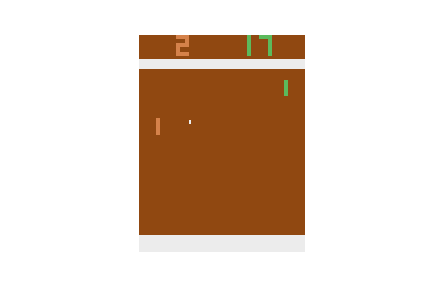
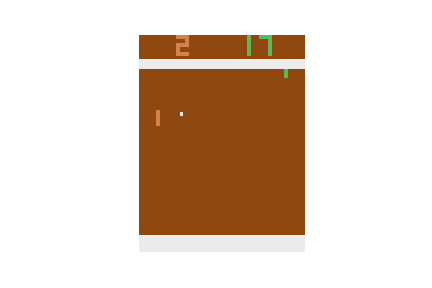
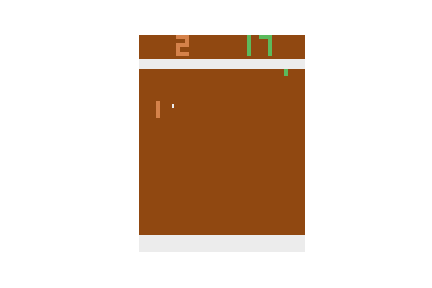
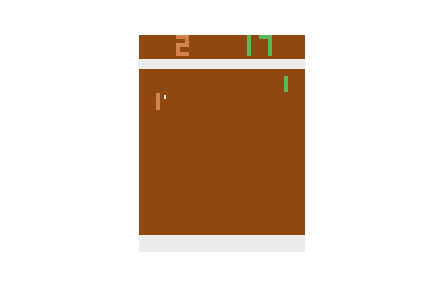
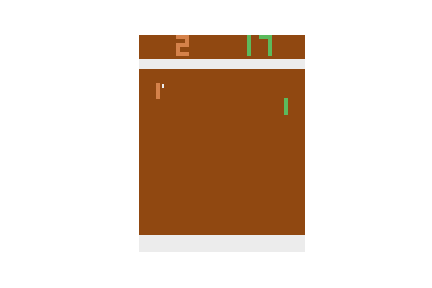
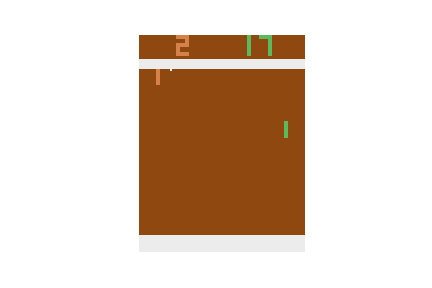
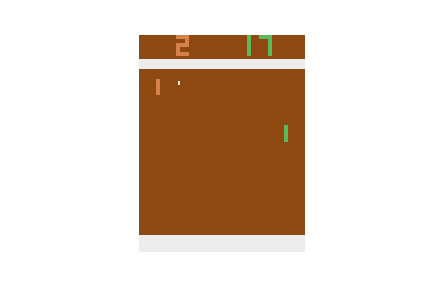
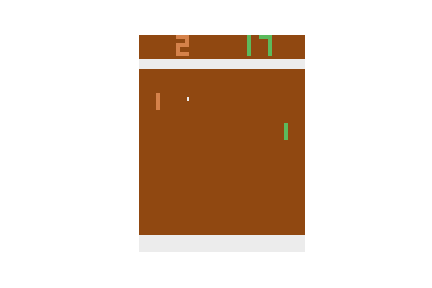
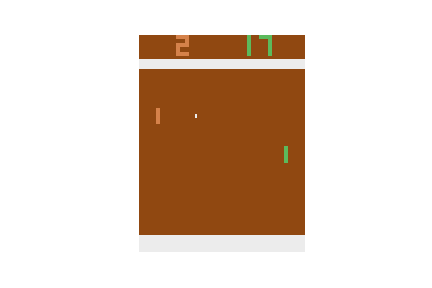
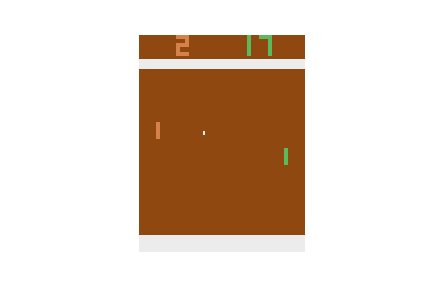
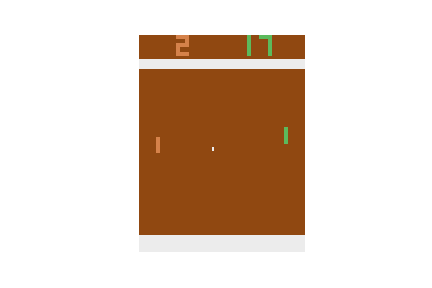
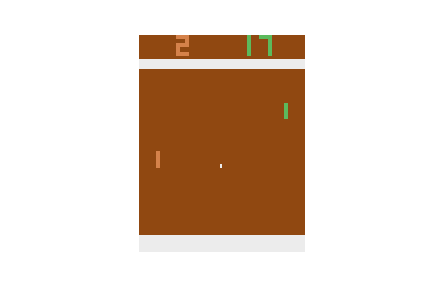
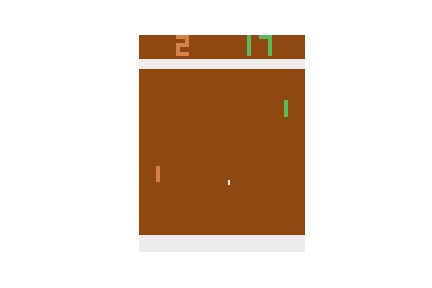
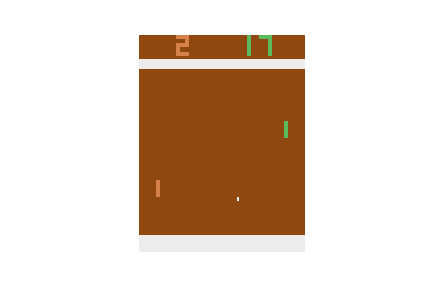
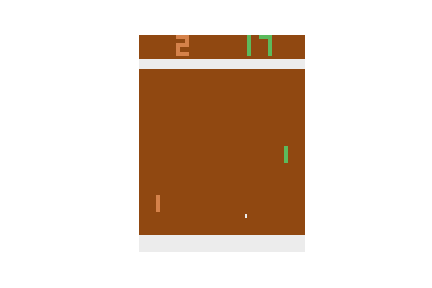
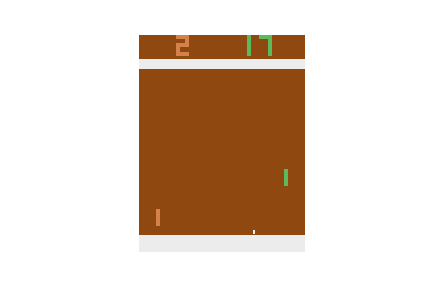
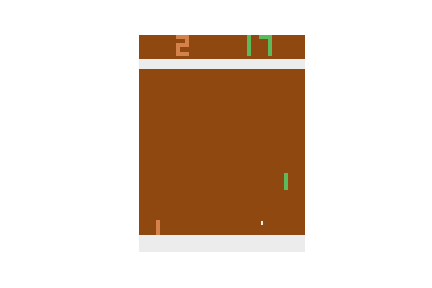
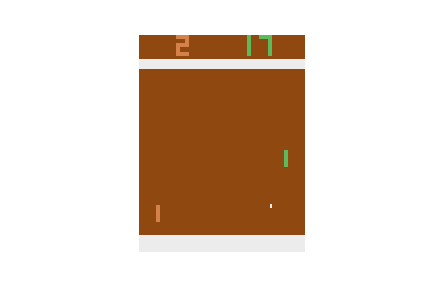
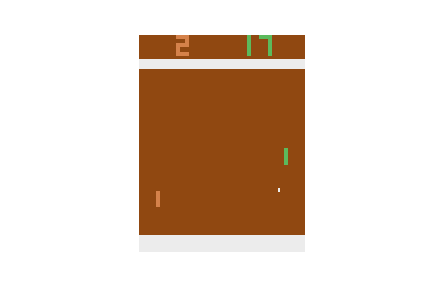
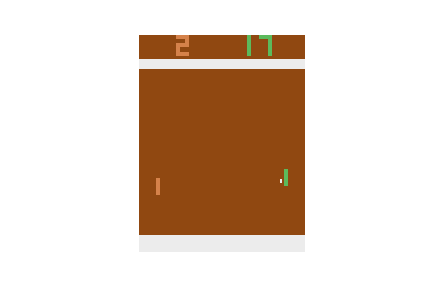
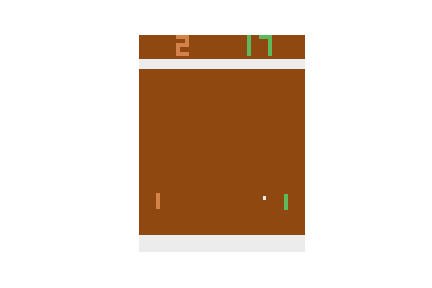
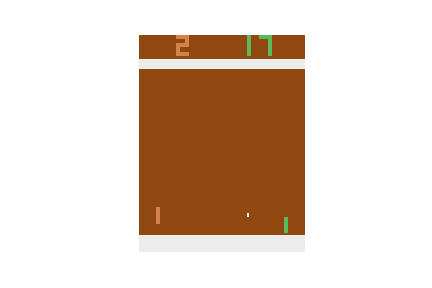
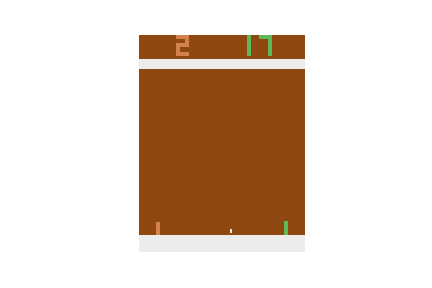
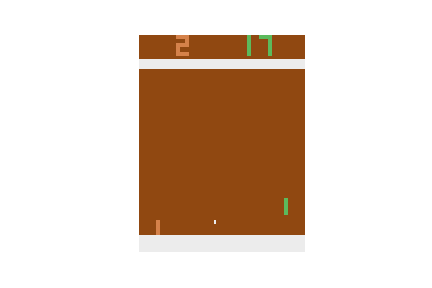
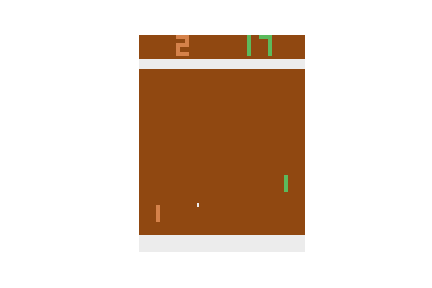
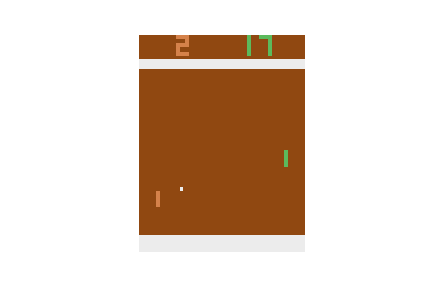
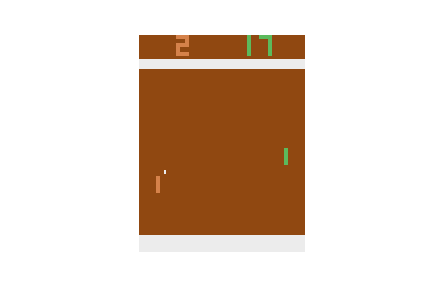
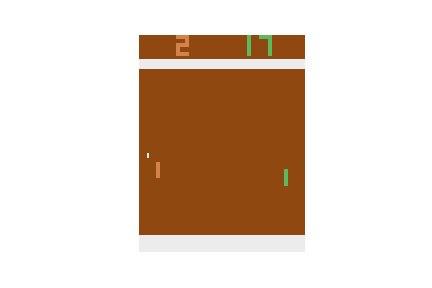
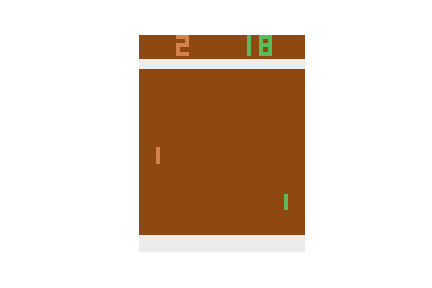
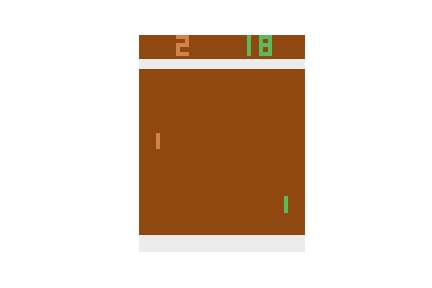
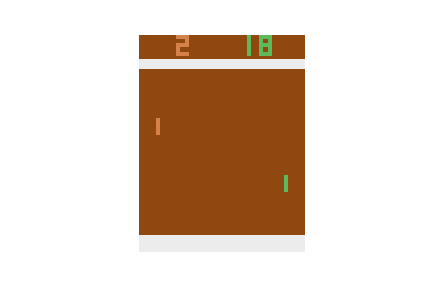
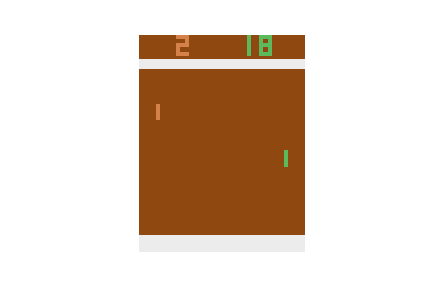
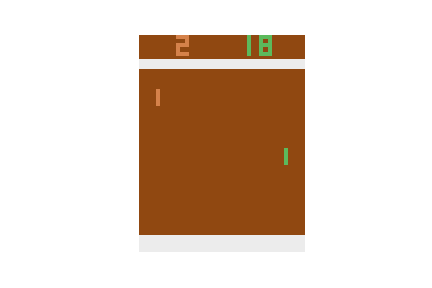
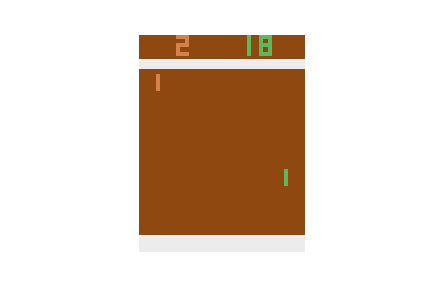
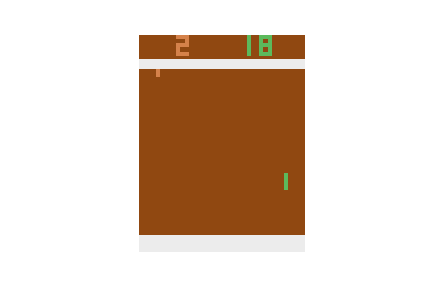
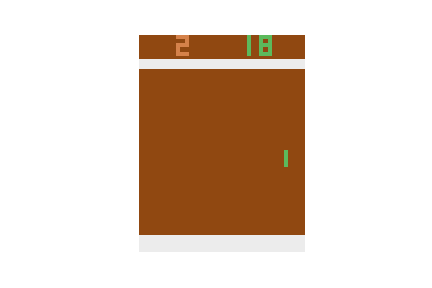
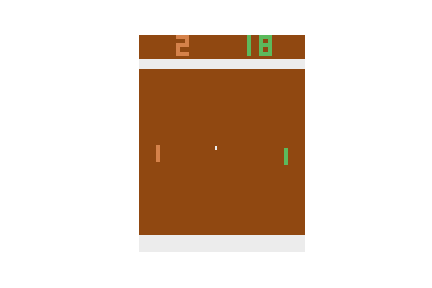
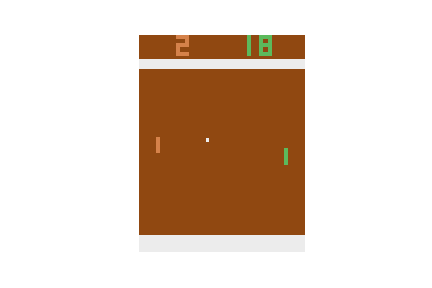
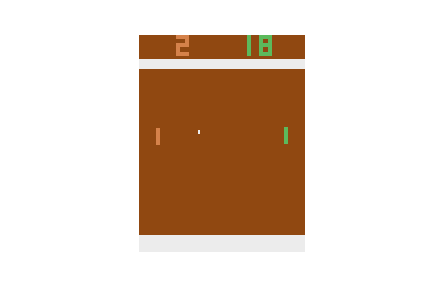
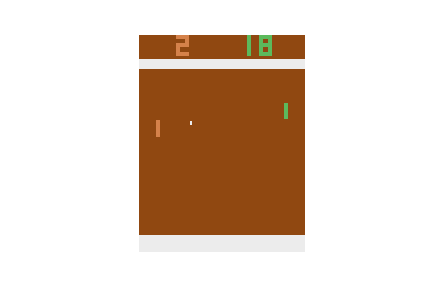
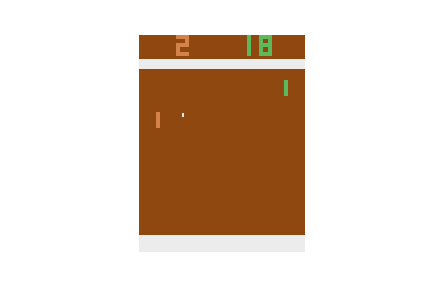
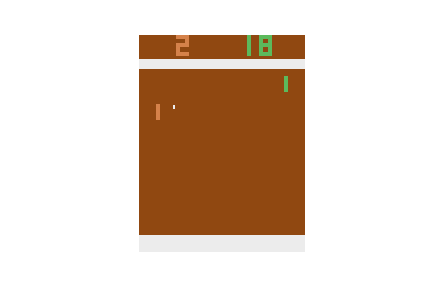
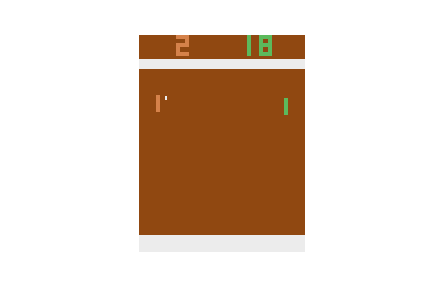
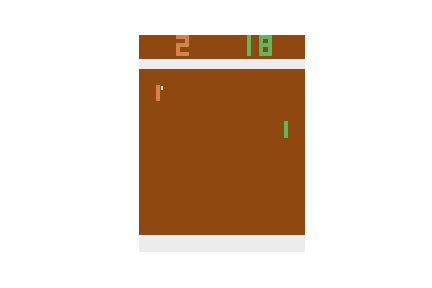
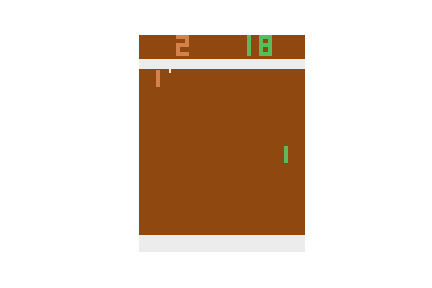
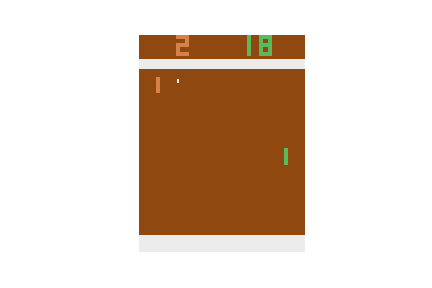
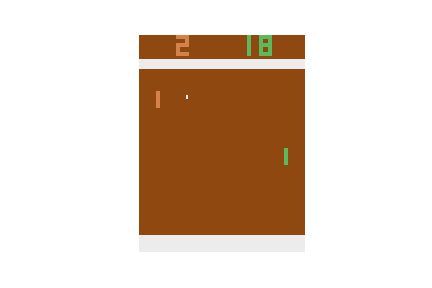
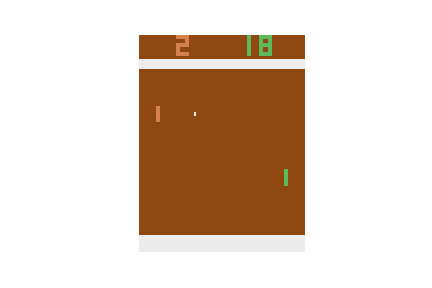
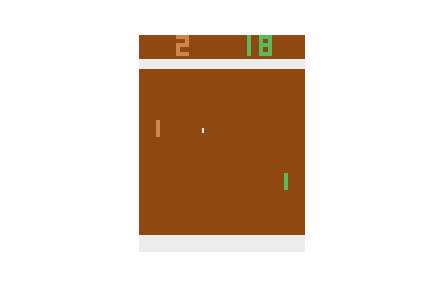
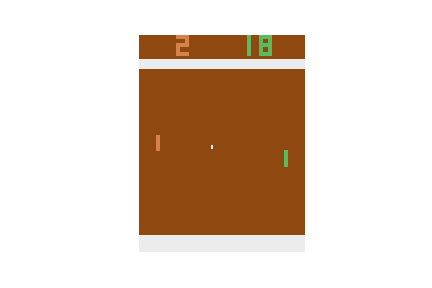
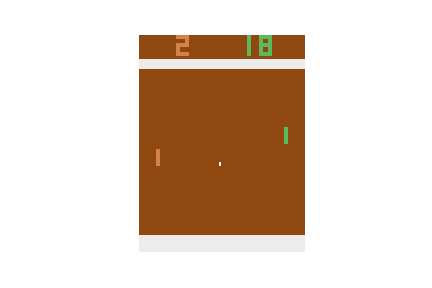
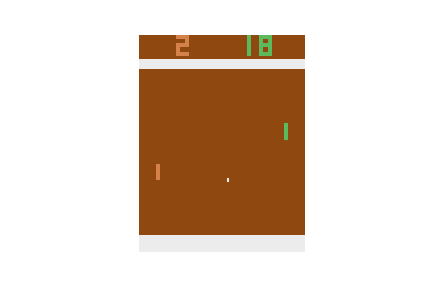
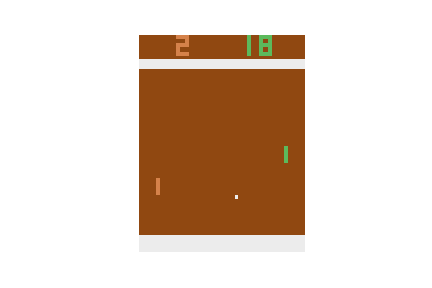
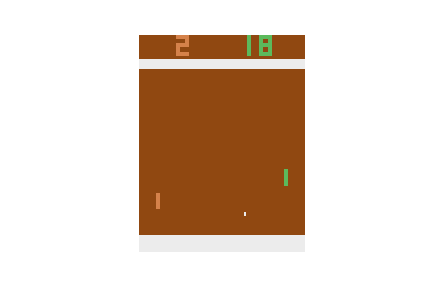
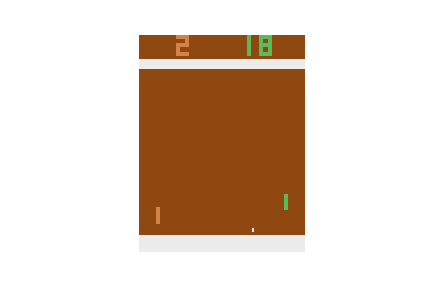
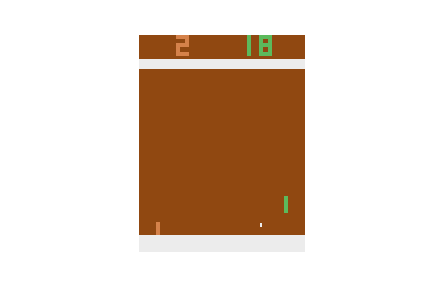
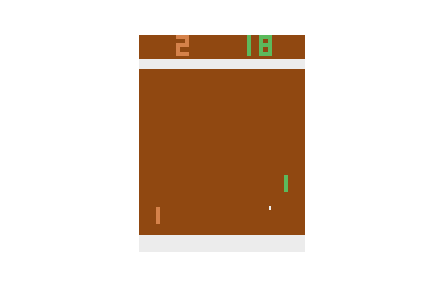
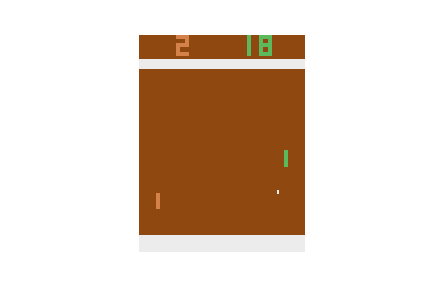
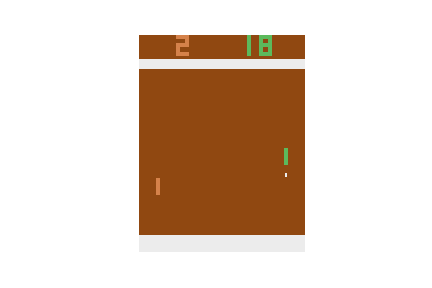
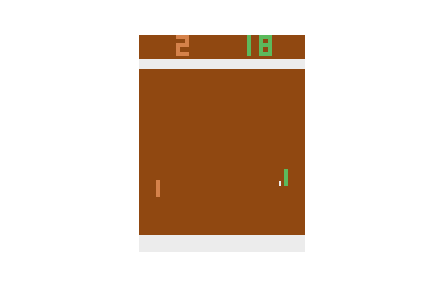
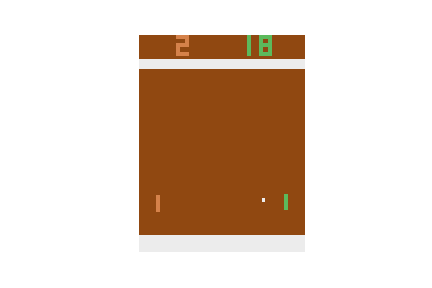
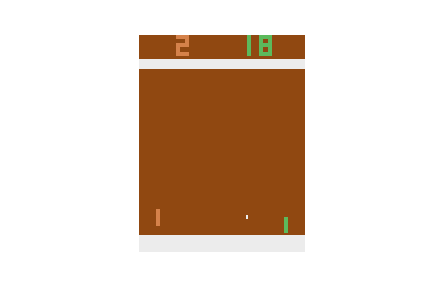
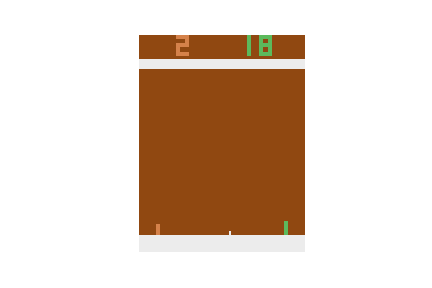
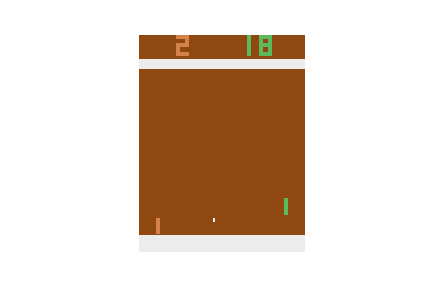
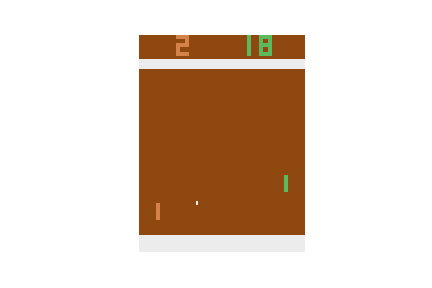
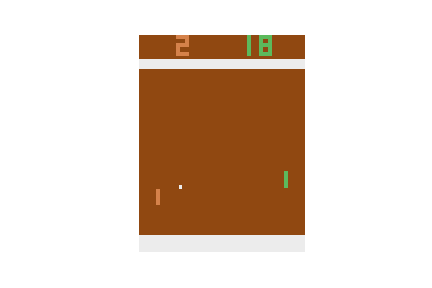
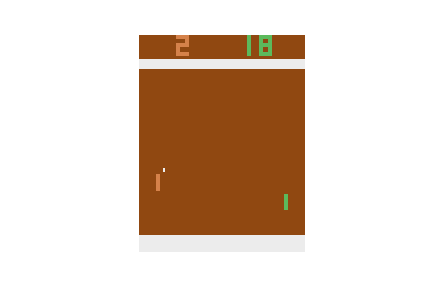
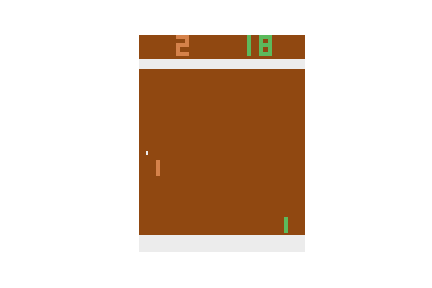
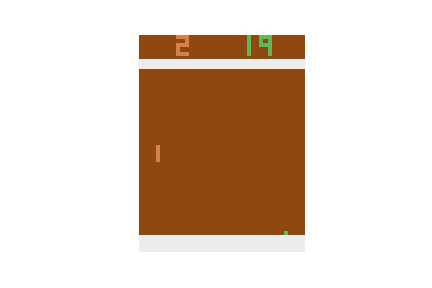
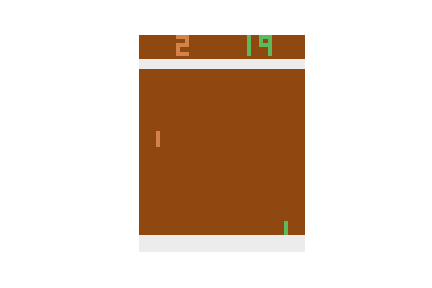
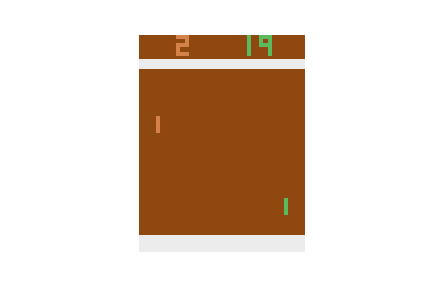
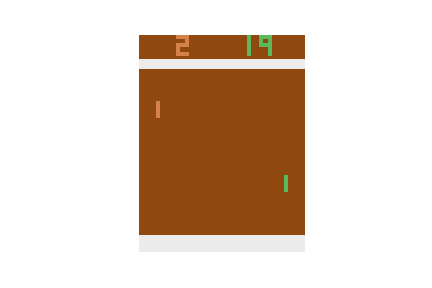
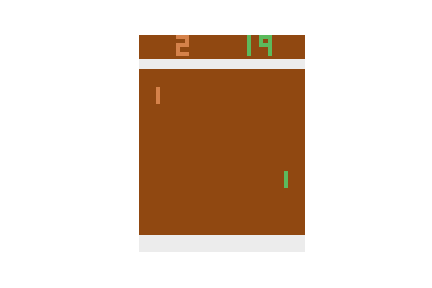
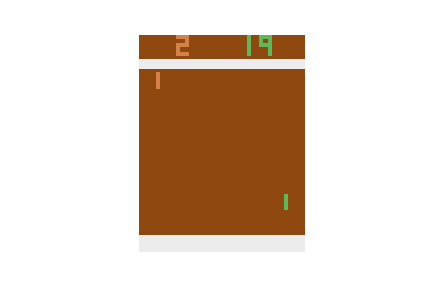
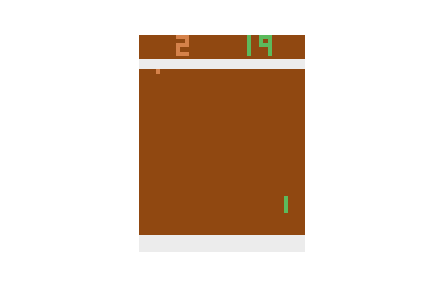
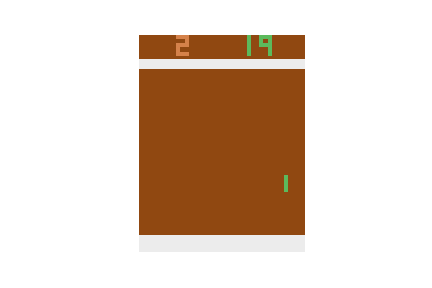
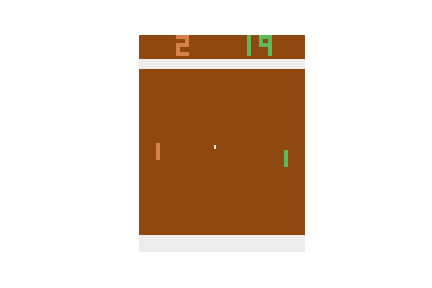
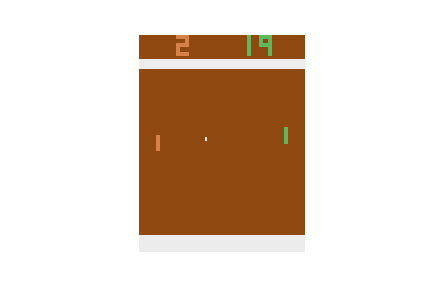
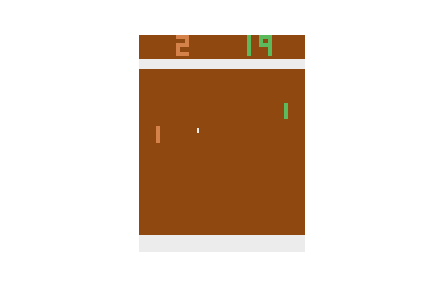
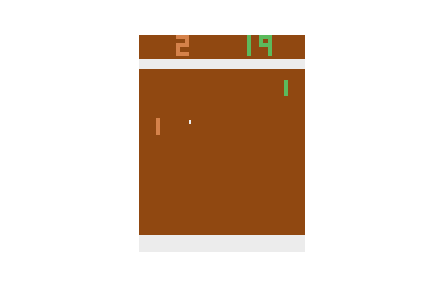
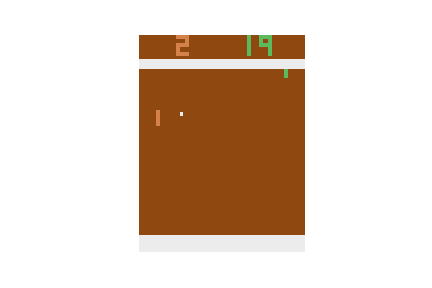
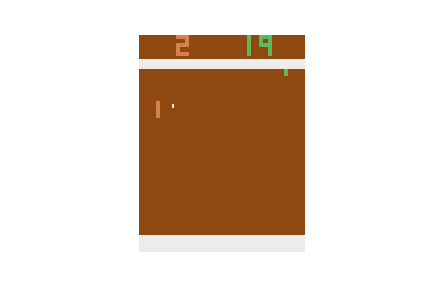
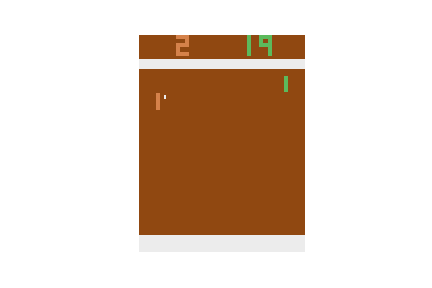
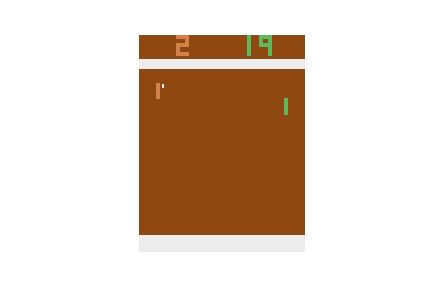
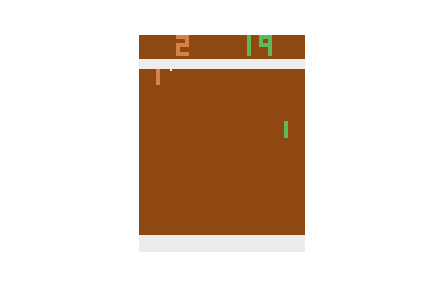
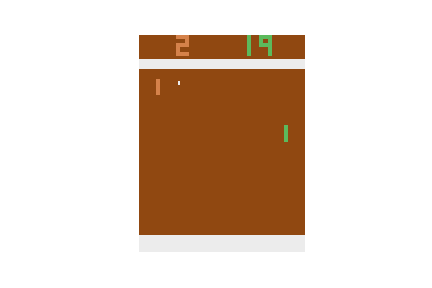
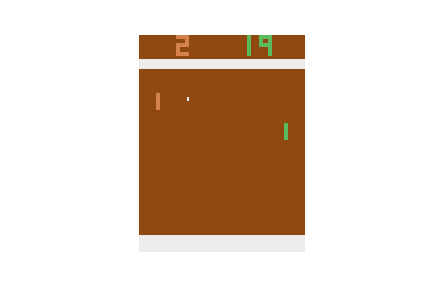
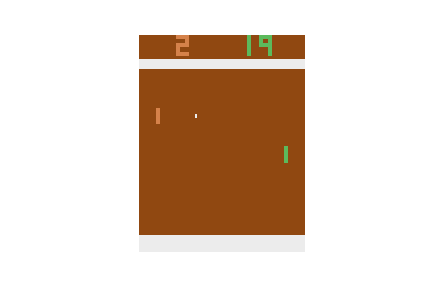
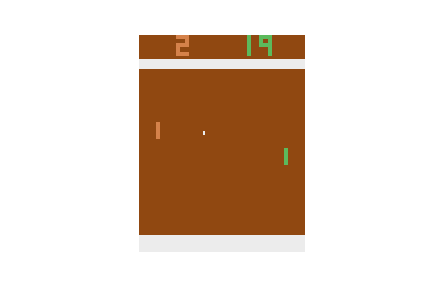
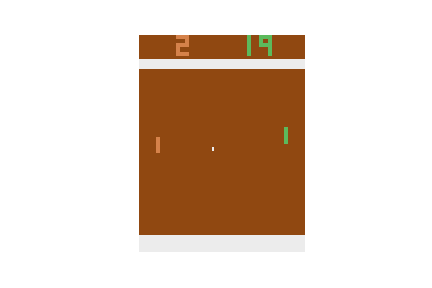
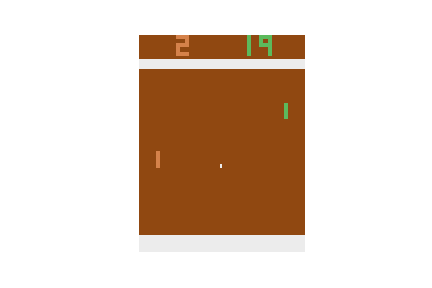
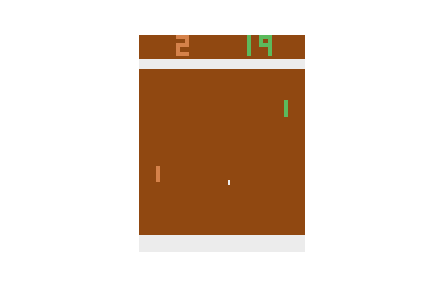
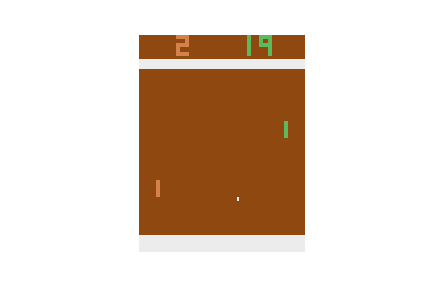
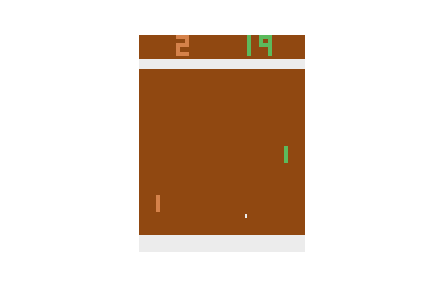
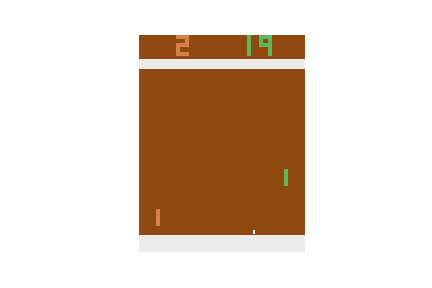
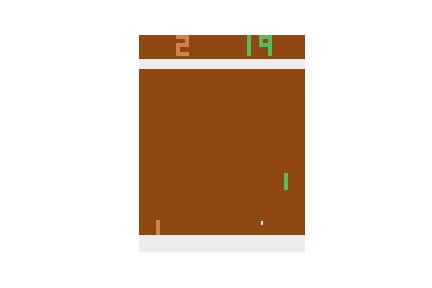
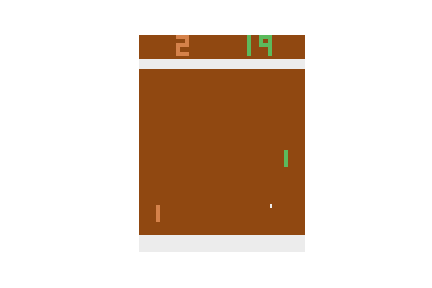
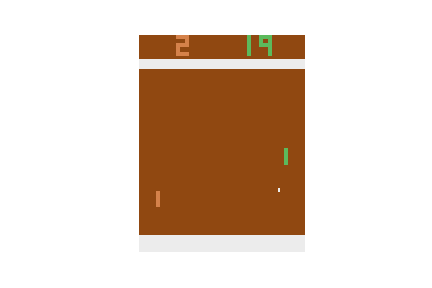
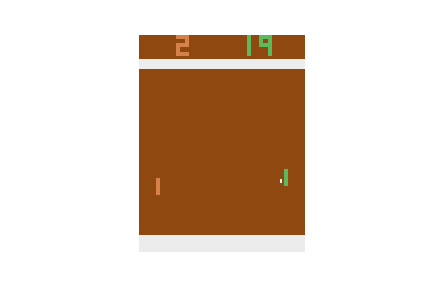
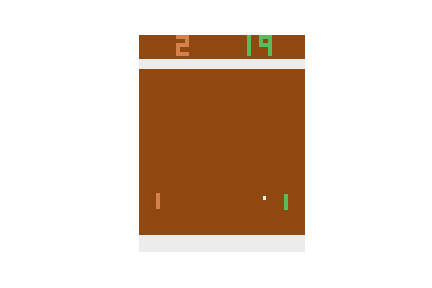
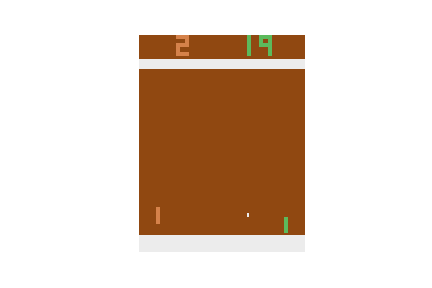
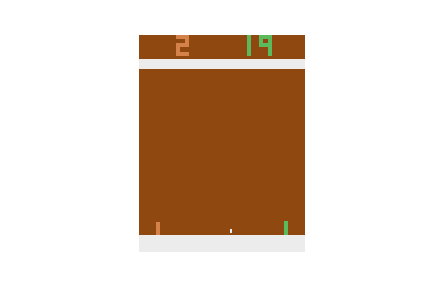
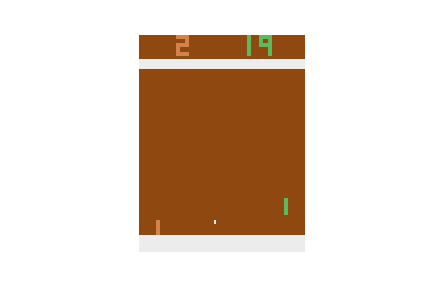
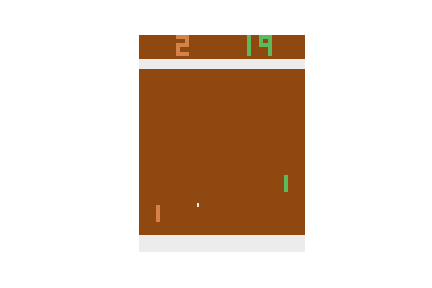
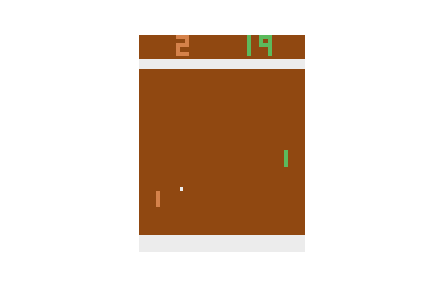
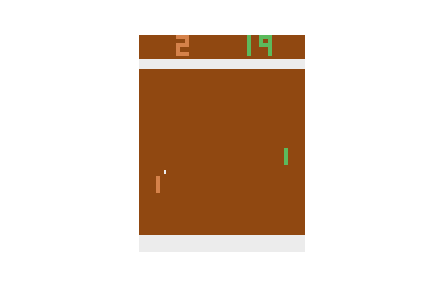
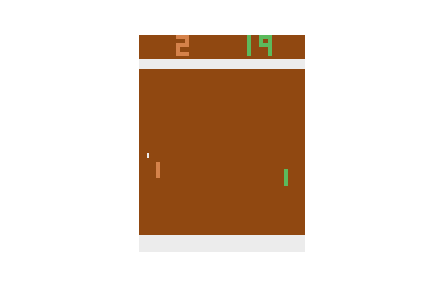
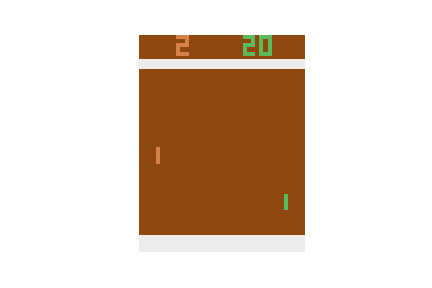
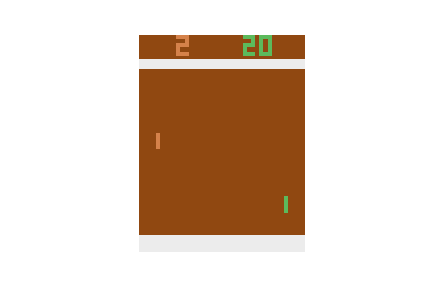
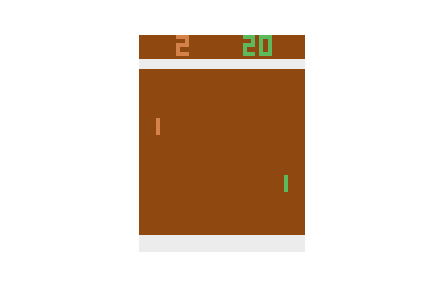
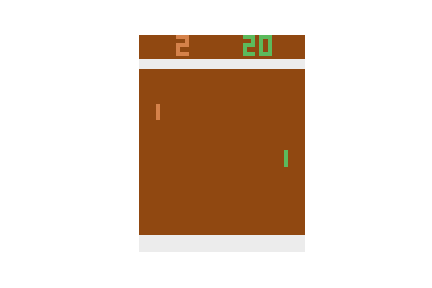
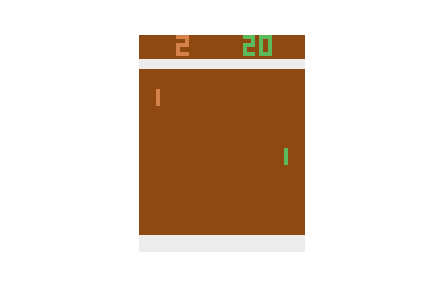
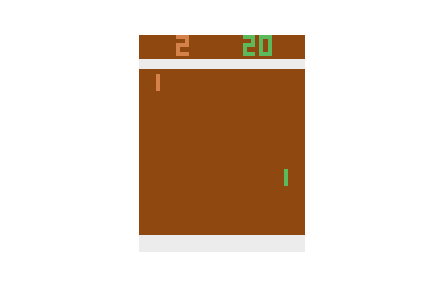
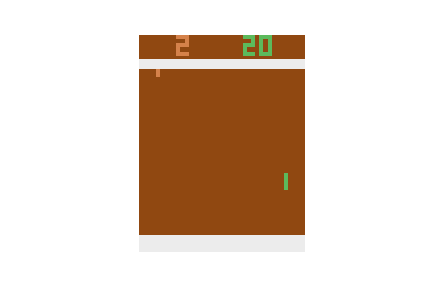
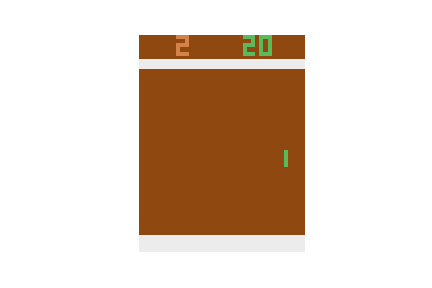
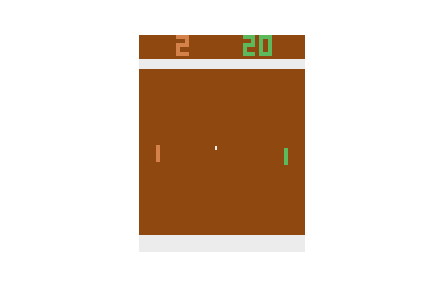
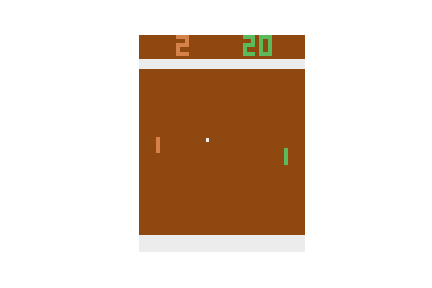
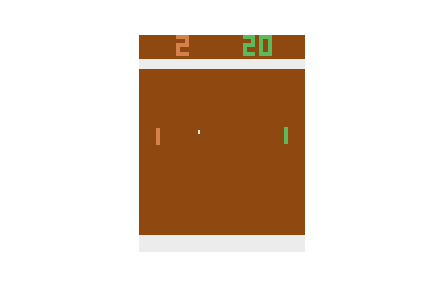
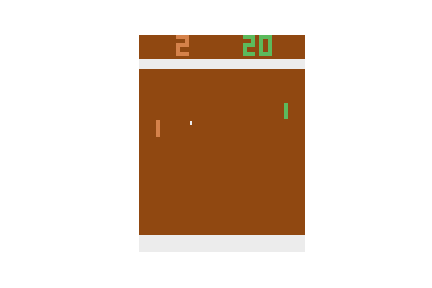
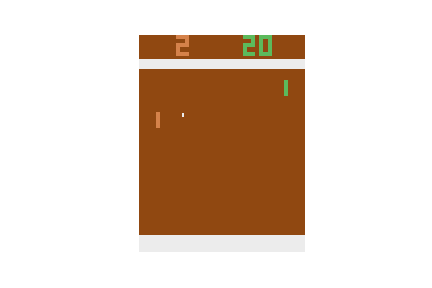
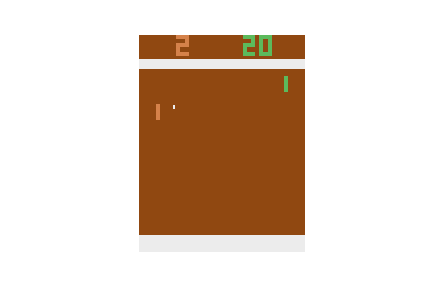
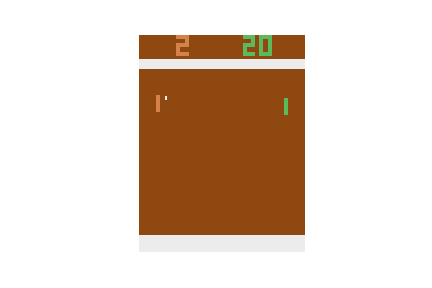
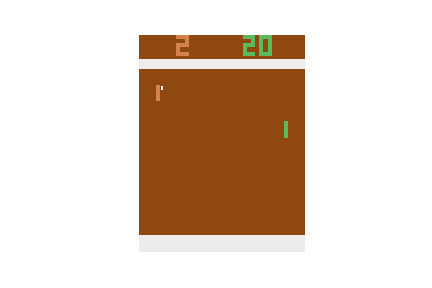
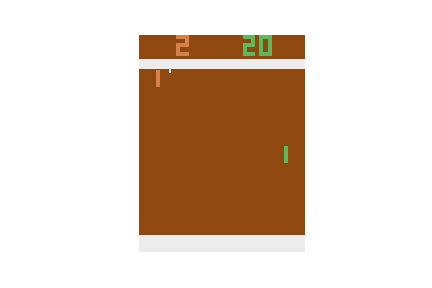
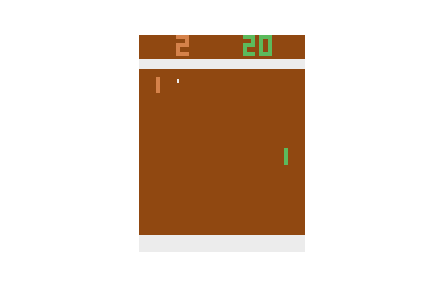
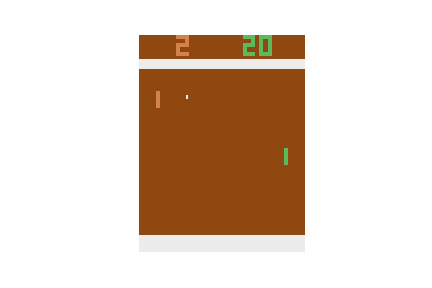
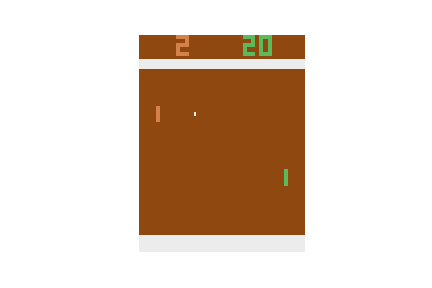
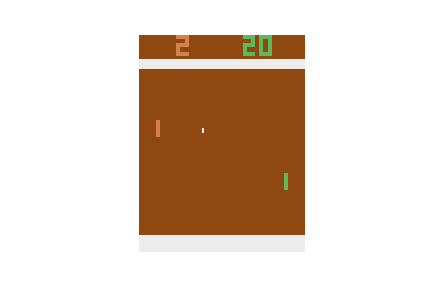
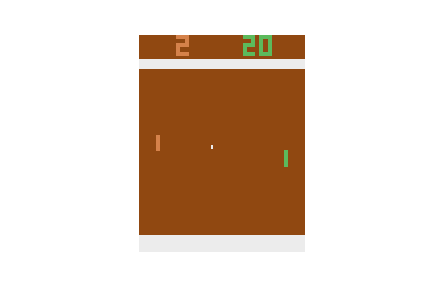
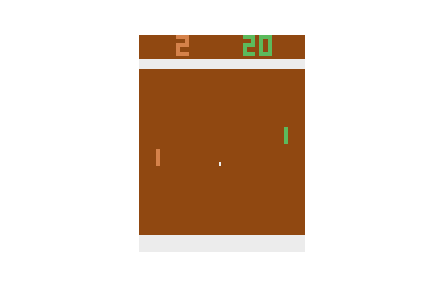
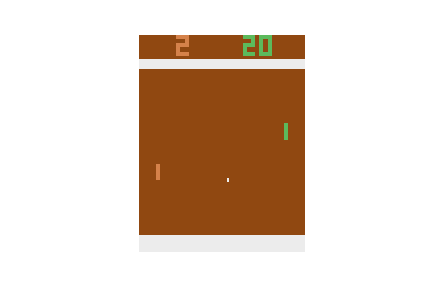
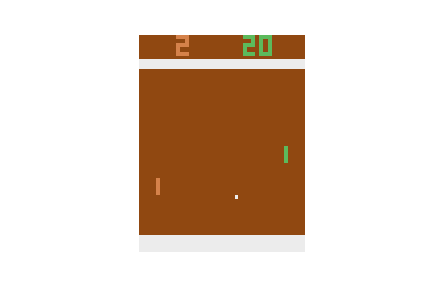
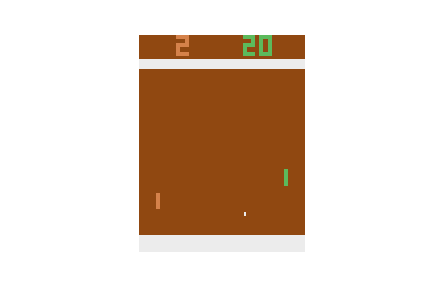
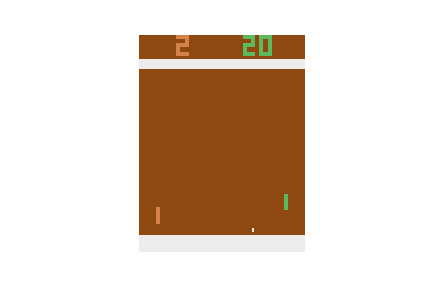
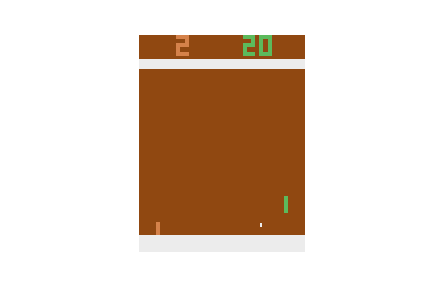
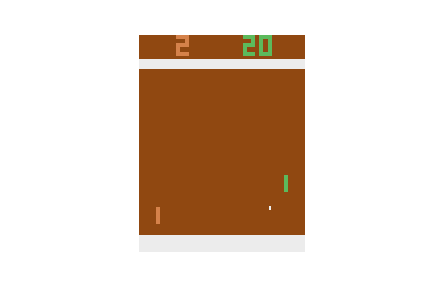
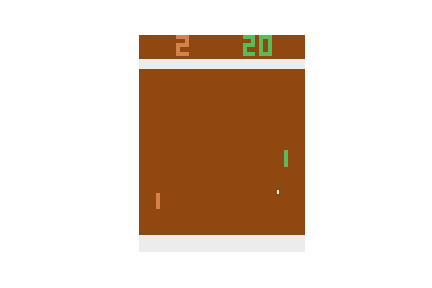
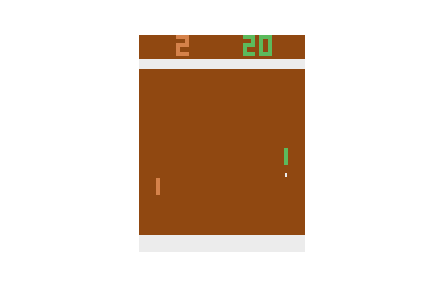
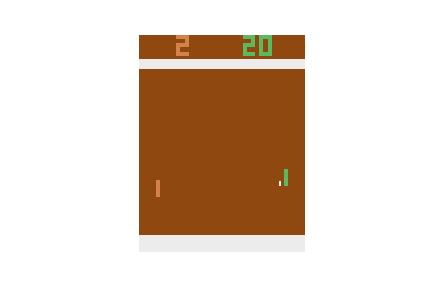
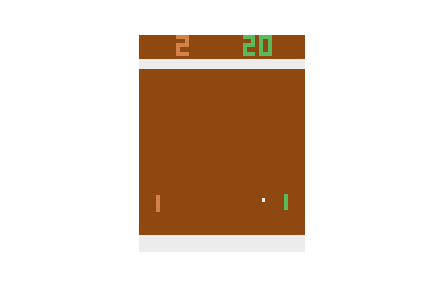
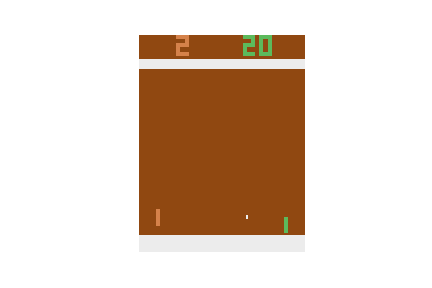
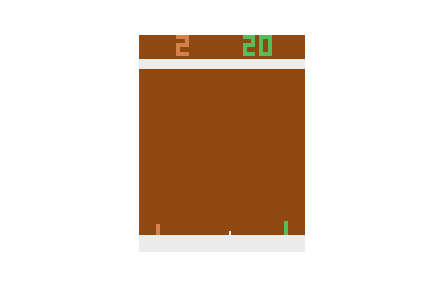
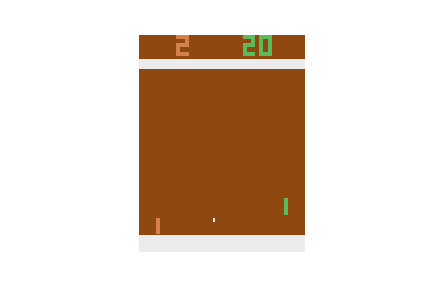
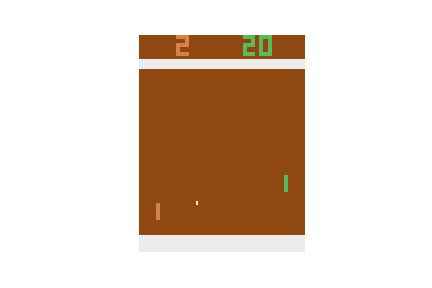
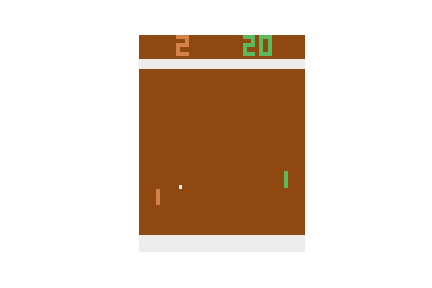
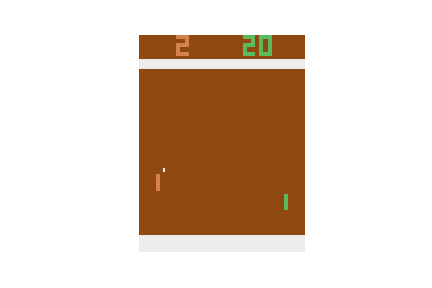
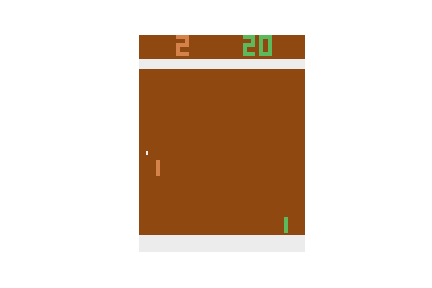

In [12]:
pong_utils.play(env, policy, time=1200) 